For this project, we adopted two different datasets, mentioned below.

ASL alphabet dataset : https://www.kaggle.com/datasets/grassknoted/asl-alphabet

Chatbot dataset : https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets import DatasetDict
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from peft import PeftModel

c:\Users\Paul\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chatbot Dataset - EDA and preprocessing

In [2]:
chatbot_df = pd.read_csv('Conversations_clean.csv')

In [3]:
chatbot_df.head()

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [4]:
chatbot_df.shape

(3725, 2)

#### EDA

EDA was performed by following a similar procedure to the one described by Singh (n.d.).

References:

Singh, H. (n.d.). Complete Guide to EDA on Text Data. Kaggle. https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

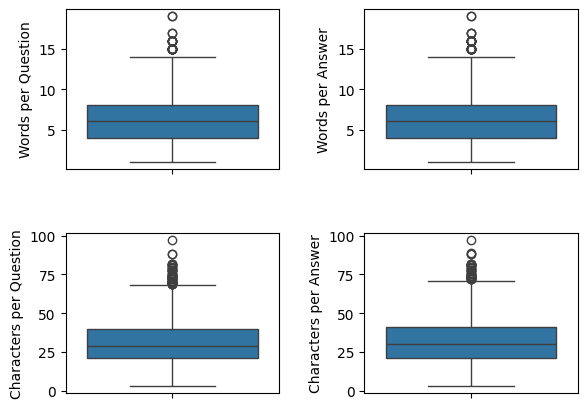

In [5]:
# Function to count the number of words in a sentence
def count_words(text):
    words = text.split() # extract the words from text
    num_words = len(words) # count the number of words
    return num_words

# Function to count the number of characters in a sentence
def count_characters(text):
    num_char = len(text) # count the number of chatacters
    return num_char

num_words_question = chatbot_df['question'].apply(count_words)
num_words_answer = chatbot_df['answer'].apply(count_words)
num_char_question = chatbot_df['question'].apply(count_characters)
num_char_answer = chatbot_df['answer'].apply(count_characters)

plt.subplot(2, 2, 1)
sns.boxplot(y = num_words_question)
plt.ylabel('Words per Question')
plt.subplot(2, 2, 2)
sns.boxplot(y = num_words_answer)
plt.ylabel('Words per Answer')
plt.subplot(2, 2, 3)
sns.boxplot(y = num_char_question)
plt.ylabel('Characters per Question')
plt.subplot(2, 2, 4)
sns.boxplot(y = num_char_answer)
plt.ylabel('Characters per Answer')
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.4, hspace = 0.4)
plt.savefig('Figure3.png')
plt.show()

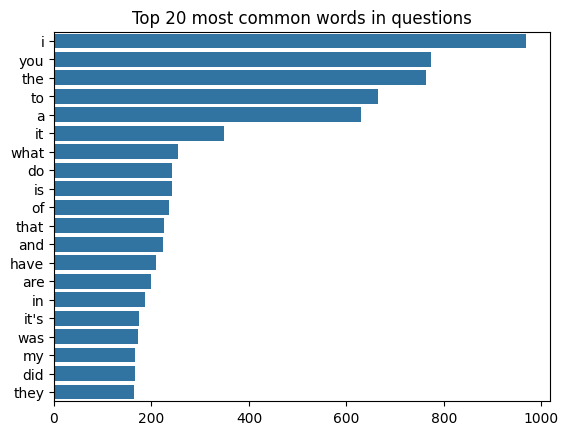

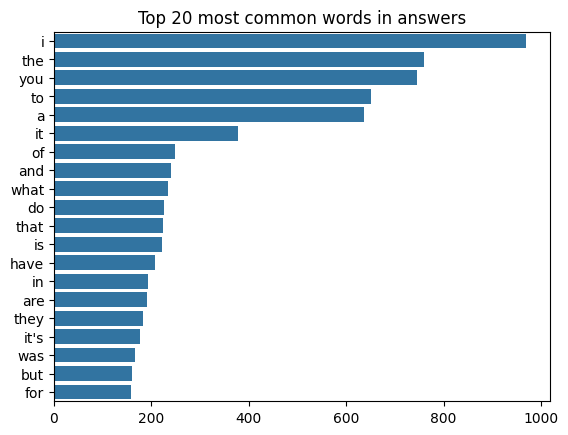

In [6]:
# Identify the most frequent words in the question/answer columns

# Function to get the list of words in a sentence
def list_words(text):
    words = text.split() # extract the words from text
    return words

# Function to get the top 20 most common words and their counts
def words_freq(mostcommon):
    words = []
    counts = []
    for word, count in mostcommon:
        words.append(word)
        counts.append(count)
    return words, counts

words_question = chatbot_df['question'].apply(list_words)
words_answer = chatbot_df['answer'].apply(list_words)
corpus_question = []
for jj in range(len(words_question)):
    corpus_question += words_question[jj] # all the words in all the questions
corpus_answer = []
for jj in range(len(words_answer)):
    corpus_answer += words_answer[jj] # all the words in all the answers
mostcommon_words_question = Counter(corpus_question).most_common(20) # 20 most common words in all the questions
mostcommon_words_answer = Counter(corpus_answer).most_common(20) # 20 most common words in all the answers
words_question, counts_question = words_freq(mostcommon_words_question) # top 20 most common words and their counts in questions
words_answer, counts_answer = words_freq(mostcommon_words_answer) # top 20 most common words and their counts in answers

sns.barplot(x = counts_question, y = words_question)
plt.title('Top 20 most common words in questions')
plt.show()

sns.barplot(x = counts_answer, y = words_answer)
plt.title('Top 20 most common words in answers')
plt.show()

#### Preprocessing

In order to replace contractions, we adopted the same procedure described in Replace apostrophe/short words in python (n.d.). 

References: 

Replace apostrophe/short words in python. (n.d.). Stack Overflow. Retrieved July 24, 2024, from https://owl.purdue.edu/owl/research_and_citation/apa_style/apa_formatting_and_style_guide/reference_list_electronic_sources.html

In [7]:
# List of common contractions 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

# Function to replace contractions, remove punctuation and apply lowercase
def clear_text(text):
    for word in text.split(): # remove contractions and apply lowercase
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    return text

chatbot_df['question'] = chatbot_df['question'].apply(clear_text)
chatbot_df['answer'] = chatbot_df['answer'].apply(clear_text)
chatbot_df.head()

,question,answer
0,hi how are you doing,I am fine how about yourself
1,I am fine how about yourself,I am pretty good thanks for asking
2,I am pretty good thanks for asking,no problem so how have you been
3,no problem so how have you been,I have been great what about you
4,I have been great what about you,I have been good I am in school right now


In [8]:
# Tokenization
chatbot_df['token_question'] = chatbot_df['question'].apply(nltk.word_tokenize)
chatbot_df['token_answer'] = chatbot_df['answer'].apply(nltk.word_tokenize)
chatbot_df.head()

,question,answer,token_question,token_answer
0,hi how are you doing,I am fine how about yourself,"[hi, how, are, you, doing]","[I, am, fine, how, about, yourself]"
1,I am fine how about yourself,I am pretty good thanks for asking,"[I, am, fine, how, about, yourself]","[I, am, pretty, good, thanks, for, asking]"
2,I am pretty good thanks for asking,no problem so how have you been,"[I, am, pretty, good, thanks, for, asking]","[no, problem, so, how, have, you, been]"
3,no problem so how have you been,I have been great what about you,"[no, problem, so, how, have, you, been]","[I, have, been, great, what, about, you]"
4,I have been great what about you,I have been good I am in school right now,"[I, have, been, great, what, about, you]","[I, have, been, good, I, am, in, school, right..."


In [9]:
# Lemmatization

# Function to obtain the right positional tagging prior to lemmatization
# Same function presented in Python – Lemmatization Approaches with Examples (n.d.)
def right_pos_tagging(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Obtain the right positional tagging prior to lemmatization
# Positional tags were modified as suggested by Python – Lemmatization Approaches with Examples (n.d.)

tokens = chatbot_df['token_question']
new_tag_tokens = []
for jj in range(len(tokens)):
    tokens_jj = tokens[jj] # tokens at the jjth row
    tag_tokens_jj = nltk.pos_tag(tokens_jj) # POS tags for the generic tokens_jj
    new_tag_tokens.append(list(map(lambda x: (x[0], right_pos_tagging(x[1])), tag_tokens_jj))) # modified POS tags for the generic tokens_jj (as Python – Lemmatization Approaches with Examples, n.d.)
tagged_token_question = new_tag_tokens

tokens = chatbot_df['token_answer']
new_tag_tokens = []
for jj in range(len(tokens)):
    tokens_jj = tokens[jj] # tokens at the jjth row
    tag_tokens_jj = nltk.pos_tag(tokens_jj) # POS tags for the generic tokens_jj
    new_tag_tokens.append(list(map(lambda x: (x[0], right_pos_tagging(x[1])), tag_tokens_jj))) # modified POS tags for the generic tokens_jj (as Python – Lemmatization Approaches with Examples, n.d.)
tagged_token_answer = new_tag_tokens

# Implement lemmatization on the tokens
# A procedure similar to the one described in Python – Lemmatization Approaches with Examples (n.d.) and by Kumar (2021) was applied

wnl = WordNetLemmatizer()
Lemmatization = []
for jj in range(len(tagged_token_question)):
    lemmatized_question = []
# Same lines of codes used in Python – Lemmatization Approaches with Examples (n.d.)
    for word, tag in tagged_token_question[jj]:
        if tag is None:
            lemmatized_question.append(word)
        else:
            lemmatized_question.append(wnl.lemmatize(word, tag))
    Lemmatization.append(lemmatized_question)
chatbot_df['lem_question'] = Lemmatization

Lemmatization = []
for jj in range(len(tagged_token_answer)):
    lemmatized_answer = []
# Same lines of codes used in Python – Lemmatization Approaches with Examples (n.d.)
    for word, tag in tagged_token_answer[jj]:
        if tag is None:
            lemmatized_answer.append(word)
        else:
            lemmatized_answer.append(wnl.lemmatize(word, tag))
    Lemmatization.append(lemmatized_answer)
chatbot_df['lem_answer'] = Lemmatization

chatbot_df.head()

# References
# Kumar, R. (2021, August 6). Natural Language Processing | Text Preprocessing | Spacy vs NLTK. Medium. https://medium.com/nerd-for-tech/natural-language-processing-text-preprocessing-spacy-vs-nltk-b70b734f5560
# Python – Lemmatization Approaches with Examples. (n.d.). Geeks for Geeks.  https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

,question,answer,token_question,token_answer,lem_question,lem_answer
0,hi how are you doing,I am fine how about yourself,"[hi, how, are, you, doing]","[I, am, fine, how, about, yourself]","[hi, how, be, you, do]","[I, be, fine, how, about, yourself]"
1,I am fine how about yourself,I am pretty good thanks for asking,"[I, am, fine, how, about, yourself]","[I, am, pretty, good, thanks, for, asking]","[I, be, fine, how, about, yourself]","[I, be, pretty, good, thanks, for, ask]"
2,I am pretty good thanks for asking,no problem so how have you been,"[I, am, pretty, good, thanks, for, asking]","[no, problem, so, how, have, you, been]","[I, be, pretty, good, thanks, for, ask]","[no, problem, so, how, have, you, be]"
3,no problem so how have you been,I have been great what about you,"[no, problem, so, how, have, you, been]","[I, have, been, great, what, about, you]","[no, problem, so, how, have, you, be]","[I, have, be, great, what, about, you]"
4,I have been great what about you,I have been good I am in school right now,"[I, have, been, great, what, about, you]","[I, have, been, good, I, am, in, school, right...","[I, have, be, great, what, about, you]","[I, have, be, good, I, be, in, school, right, ..."


## T5 Fine Tuning

This section was created based on a combination of the following references.

References: 
https://www.kaggle.com/code/ajinkyabhandare2002/fine-tune-flan-t5-base-for-chat-with-peft-lora

#### Import tokenizer and model

In [10]:
model_name = 'google/flan-t5-base'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype = torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
# Check number of parameters to train
def model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(model_parameters(model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


### Preprocess Data for Retrain

In [12]:
chatbot_df=chatbot_df.drop(columns=['token_question','token_answer','lem_question','lem_answer'])

In [13]:
train_data, temp_data = train_test_split(chatbot_df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

In [14]:
from datasets import DatasetDict
working_dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

In [15]:
working_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 2980
    })
    validation: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 372
    })
    test: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 373
    })
})

In [16]:
working_dataset["train"] = working_dataset["train"].remove_columns("__index_level_0__")
working_dataset["validation"] = working_dataset["validation"].remove_columns("__index_level_0__")
working_dataset["test"] = working_dataset["test"].remove_columns("__index_level_0__")
working_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 2980
    })
    validation: Dataset({
        features: ['question', 'answer'],
        num_rows: 372
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 373
    })
})

In [17]:
def tokenize_function(example):
    # start_prompt = 'Answer the following question.\n\n'
    # end_prompt = '\n\nSummary: '
    # prompt = [start_prompt + question + end_prompt for question in example["question"]]
    example['input_ids'] = tokenizer(example['question'], padding='max_length', truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["answer"], padding='max_length', truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = working_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['question', 'answer'])

Map: 100%|██████████| 373/373 [00:00<00:00, 7056.44 examples/s]


In [18]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 2980
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 372
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 373
    })
})

In [19]:
# # Subsample the dataset to save time on training
# tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

In [20]:
print(f"Shapes of the datasets:")
print(f"Dataset: {tokenized_datasets.shape}")
print(tokenized_datasets)

Shapes of the datasets:
Dataset: {'train': (2980, 2), 'validation': (372, 2), 'test': (373, 2)}
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 2980
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 372
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 373
    })
})


#### Setup the PEFT/LoRA model for Fine-Tuning

In [21]:
lora_config = LoraConfig(
    r=8, # Rank
    lora_alpha=8,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

#### Add LoRA adapter layers/prameters to the LLM model to be trained

In [22]:
peft_model = get_peft_model(model, lora_config)
print(model_parameters(peft_model))

bin c:\Users\Paul\anaconda3\envs\torch\lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll
trainable model parameters: 884736
all model parameters: 248462592
percentage of trainable model parameters: 0.36%


#### Train PEFT Adapter

In [23]:
# Define Trianing Arguements
output_dir = f'./peft-conversation-training'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=5,
    logging_steps=1
)
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation']
    
)

#### Train the model

In [24]:
try:
    peft_trainer.train()
except OutOfMemoryError:
    print("Training interrupted due to OOM. Saving model checkpoint...")
    peft_model_path="./peft-conversation-checkpoint-local"
    peft_trainer.model.save_pretrained(peft_model_path)
    tokenizer.save_pretrained(peft_model_path)
    print("Checkpoint saved. You can resume training from here.")

  0%|          | 2/1865 [00:00<10:50,  2.87it/s]

{'loss': 41.5, 'grad_norm': 4.094821929931641, 'learning_rate': 0.0009994638069705094, 'epoch': 0.0}


  0%|          | 3/1865 [00:00<08:33,  3.63it/s]

{'loss': 42.0, 'grad_norm': 5.413318634033203, 'learning_rate': 0.0009989276139410188, 'epoch': 0.01}


  0%|          | 4/1865 [00:01<07:29,  4.14it/s]

{'loss': 41.75, 'grad_norm': 7.137814044952393, 'learning_rate': 0.000998391420911528, 'epoch': 0.01}


  0%|          | 5/1865 [00:01<06:53,  4.50it/s]

{'loss': 40.25, 'grad_norm': 9.622596740722656, 'learning_rate': 0.0009978552278820374, 'epoch': 0.01}


  0%|          | 6/1865 [00:01<06:31,  4.75it/s]

{'loss': 37.25, 'grad_norm': 9.371594429016113, 'learning_rate': 0.0009973190348525468, 'epoch': 0.01}


  0%|          | 7/1865 [00:01<06:17,  4.92it/s]

{'loss': 34.25, 'grad_norm': 7.442983150482178, 'learning_rate': 0.0009967828418230562, 'epoch': 0.02}


  0%|          | 8/1865 [00:01<06:08,  5.04it/s]

{'loss': 33.25, 'grad_norm': 7.496304512023926, 'learning_rate': 0.0009962466487935656, 'epoch': 0.02}


  0%|          | 9/1865 [00:02<06:00,  5.15it/s]

{'loss': 31.125, 'grad_norm': 8.448534965515137, 'learning_rate': 0.000995710455764075, 'epoch': 0.02}


  1%|          | 10/1865 [00:02<05:59,  5.16it/s]

{'loss': 29.375, 'grad_norm': 7.0896077156066895, 'learning_rate': 0.0009951742627345845, 'epoch': 0.02}


  1%|          | 11/1865 [00:02<05:59,  5.16it/s]

{'loss': 28.0, 'grad_norm': 8.449664115905762, 'learning_rate': 0.0009946380697050939, 'epoch': 0.03}


  1%|          | 12/1865 [00:02<05:59,  5.16it/s]

{'loss': 26.625, 'grad_norm': 7.011782169342041, 'learning_rate': 0.0009941018766756033, 'epoch': 0.03}


  1%|          | 13/1865 [00:02<06:00,  5.14it/s]

{'loss': 24.875, 'grad_norm': 6.380695343017578, 'learning_rate': 0.0009935656836461127, 'epoch': 0.03}


  1%|          | 14/1865 [00:03<05:57,  5.18it/s]

{'loss': 24.0, 'grad_norm': 6.666173458099365, 'learning_rate': 0.0009930294906166219, 'epoch': 0.03}


  1%|          | 15/1865 [00:03<05:55,  5.21it/s]

{'loss': 22.5, 'grad_norm': 6.85632848739624, 'learning_rate': 0.0009924932975871313, 'epoch': 0.04}


  1%|          | 16/1865 [00:03<05:51,  5.26it/s]

{'loss': 21.375, 'grad_norm': 7.1602582931518555, 'learning_rate': 0.0009919571045576407, 'epoch': 0.04}
{'loss': 19.75, 'grad_norm': 7.728709697723389, 'learning_rate': 0.00099142091152815, 'epoch': 0.04}


  1%|          | 18/1865 [00:03<05:51,  5.25it/s]

{'loss': 18.0, 'grad_norm': 11.000395774841309, 'learning_rate': 0.0009908847184986595, 'epoch': 0.05}


  1%|          | 19/1865 [00:03<05:50,  5.27it/s]

{'loss': 15.9375, 'grad_norm': 8.063335418701172, 'learning_rate': 0.0009903485254691689, 'epoch': 0.05}


  1%|          | 20/1865 [00:04<05:49,  5.27it/s]

{'loss': 14.25, 'grad_norm': 8.15415096282959, 'learning_rate': 0.0009898123324396783, 'epoch': 0.05}


  1%|          | 21/1865 [00:04<05:48,  5.30it/s]

{'loss': 12.0625, 'grad_norm': 10.970466613769531, 'learning_rate': 0.0009892761394101877, 'epoch': 0.05}


  1%|          | 22/1865 [00:04<05:47,  5.31it/s]

{'loss': 9.6875, 'grad_norm': 9.255367279052734, 'learning_rate': 0.000988739946380697, 'epoch': 0.06}


  1%|          | 23/1865 [00:04<05:48,  5.29it/s]

{'loss': 7.1562, 'grad_norm': 6.71974515914917, 'learning_rate': 0.0009882037533512065, 'epoch': 0.06}


  1%|▏         | 24/1865 [00:04<05:47,  5.30it/s]

{'loss': 5.7812, 'grad_norm': 4.004016399383545, 'learning_rate': 0.0009876675603217157, 'epoch': 0.06}


  1%|▏         | 25/1865 [00:05<05:47,  5.30it/s]

{'loss': 5.1875, 'grad_norm': 1.8248860836029053, 'learning_rate': 0.000987131367292225, 'epoch': 0.06}


  1%|▏         | 26/1865 [00:05<05:46,  5.31it/s]

{'loss': 4.9062, 'grad_norm': 0.9842170476913452, 'learning_rate': 0.0009865951742627345, 'epoch': 0.07}


  1%|▏         | 27/1865 [00:05<05:45,  5.33it/s]

{'loss': 4.8125, 'grad_norm': 0.7422013282775879, 'learning_rate': 0.000986058981233244, 'epoch': 0.07}


  2%|▏         | 28/1865 [00:05<05:44,  5.33it/s]

{'loss': 4.7188, 'grad_norm': 0.5527276992797852, 'learning_rate': 0.0009855227882037533, 'epoch': 0.07}


  2%|▏         | 29/1865 [00:05<05:45,  5.31it/s]

{'loss': 4.625, 'grad_norm': 0.433874249458313, 'learning_rate': 0.0009849865951742627, 'epoch': 0.08}


  2%|▏         | 30/1865 [00:06<05:46,  5.30it/s]

{'loss': 4.5625, 'grad_norm': 0.3552132546901703, 'learning_rate': 0.0009844504021447721, 'epoch': 0.08}


  2%|▏         | 31/1865 [00:06<05:45,  5.32it/s]

{'loss': 4.5, 'grad_norm': 0.3121449053287506, 'learning_rate': 0.0009839142091152815, 'epoch': 0.08}


  2%|▏         | 32/1865 [00:06<05:45,  5.31it/s]

{'loss': 4.5, 'grad_norm': 0.299744576215744, 'learning_rate': 0.000983378016085791, 'epoch': 0.08}


  2%|▏         | 33/1865 [00:06<05:45,  5.30it/s]

{'loss': 4.4688, 'grad_norm': 0.4459809958934784, 'learning_rate': 0.0009828418230563003, 'epoch': 0.09}


  2%|▏         | 34/1865 [00:06<05:45,  5.31it/s]

{'loss': 4.4375, 'grad_norm': 0.28072455525398254, 'learning_rate': 0.0009823056300268097, 'epoch': 0.09}


  2%|▏         | 35/1865 [00:07<05:44,  5.31it/s]

{'loss': 4.4062, 'grad_norm': 0.2792031168937683, 'learning_rate': 0.000981769436997319, 'epoch': 0.09}


  2%|▏         | 36/1865 [00:07<05:44,  5.31it/s]

{'loss': 4.3438, 'grad_norm': 0.29252859950065613, 'learning_rate': 0.0009812332439678283, 'epoch': 0.09}


  2%|▏         | 37/1865 [00:07<05:44,  5.30it/s]

{'loss': 4.3125, 'grad_norm': 0.3004789352416992, 'learning_rate': 0.0009806970509383377, 'epoch': 0.1}


  2%|▏         | 38/1865 [00:07<05:44,  5.31it/s]

{'loss': 4.2812, 'grad_norm': 0.28331777453422546, 'learning_rate': 0.0009801608579088471, 'epoch': 0.1}


  2%|▏         | 39/1865 [00:07<05:44,  5.31it/s]

{'loss': 4.2188, 'grad_norm': 0.29593804478645325, 'learning_rate': 0.0009796246648793566, 'epoch': 0.1}


  2%|▏         | 40/1865 [00:07<05:45,  5.28it/s]

{'loss': 4.2188, 'grad_norm': 0.3360207974910736, 'learning_rate': 0.000979088471849866, 'epoch': 0.1}


  2%|▏         | 41/1865 [00:08<05:45,  5.28it/s]

{'loss': 4.125, 'grad_norm': 0.9746589660644531, 'learning_rate': 0.0009785522788203754, 'epoch': 0.11}


  2%|▏         | 42/1865 [00:08<05:44,  5.29it/s]

{'loss': 4.0312, 'grad_norm': 0.40555500984191895, 'learning_rate': 0.0009780160857908848, 'epoch': 0.11}


  2%|▏         | 43/1865 [00:08<05:43,  5.31it/s]

{'loss': 3.9688, 'grad_norm': 0.4915933609008789, 'learning_rate': 0.0009774798927613942, 'epoch': 0.11}


  2%|▏         | 44/1865 [00:08<05:43,  5.30it/s]

{'loss': 3.9062, 'grad_norm': 0.5140253901481628, 'learning_rate': 0.0009769436997319036, 'epoch': 0.12}


  2%|▏         | 45/1865 [00:08<05:45,  5.27it/s]

{'loss': 3.7656, 'grad_norm': 0.59853595495224, 'learning_rate': 0.0009764075067024129, 'epoch': 0.12}


  2%|▏         | 46/1865 [00:09<05:46,  5.24it/s]

{'loss': 3.6562, 'grad_norm': 0.6076123118400574, 'learning_rate': 0.0009758713136729223, 'epoch': 0.12}


  2%|▏         | 46/1865 [00:09<05:46,  5.24it/s]

{'loss': 3.6094, 'grad_norm': 3.3200981616973877, 'learning_rate': 0.0009753351206434317, 'epoch': 0.12}


  3%|▎         | 48/1865 [00:10<10:03,  3.01it/s]

{'loss': 3.4062, 'grad_norm': 1.0076669454574585, 'learning_rate': 0.0009747989276139411, 'epoch': 0.13}


  3%|▎         | 49/1865 [00:10<08:45,  3.46it/s]

{'loss': 3.2656, 'grad_norm': 0.8188648223876953, 'learning_rate': 0.0009742627345844505, 'epoch': 0.13}


  3%|▎         | 50/1865 [00:10<07:52,  3.84it/s]

{'loss': 3.1094, 'grad_norm': 1.087272047996521, 'learning_rate': 0.0009737265415549598, 'epoch': 0.13}


  3%|▎         | 51/1865 [00:10<07:16,  4.16it/s]

{'loss': 2.9688, 'grad_norm': 0.8814945220947266, 'learning_rate': 0.0009731903485254692, 'epoch': 0.13}


  3%|▎         | 51/1865 [00:10<07:16,  4.16it/s]

{'loss': 2.8125, 'grad_norm': 1.3187233209609985, 'learning_rate': 0.0009726541554959786, 'epoch': 0.14}


  3%|▎         | 53/1865 [00:11<06:34,  4.59it/s]

{'loss': 2.6562, 'grad_norm': 9.174578666687012, 'learning_rate': 0.000972117962466488, 'epoch': 0.14}


  3%|▎         | 54/1865 [00:11<06:17,  4.80it/s]

{'loss': 2.6094, 'grad_norm': 0.9857268333435059, 'learning_rate': 0.0009715817694369974, 'epoch': 0.14}


  3%|▎         | 55/1865 [00:11<06:06,  4.94it/s]

{'loss': 2.5625, 'grad_norm': 0.899191677570343, 'learning_rate': 0.0009710455764075067, 'epoch': 0.14}


  3%|▎         | 56/1865 [00:11<05:58,  5.05it/s]

{'loss': 2.4062, 'grad_norm': 1.0879570245742798, 'learning_rate': 0.0009705093833780161, 'epoch': 0.15}


  3%|▎         | 57/1865 [00:11<05:52,  5.13it/s]

{'loss': 2.2031, 'grad_norm': 0.8324114084243774, 'learning_rate': 0.0009699731903485255, 'epoch': 0.15}


  3%|▎         | 58/1865 [00:12<05:48,  5.18it/s]

{'loss': 2.125, 'grad_norm': 0.910655677318573, 'learning_rate': 0.0009694369973190349, 'epoch': 0.15}


  3%|▎         | 59/1865 [00:12<05:49,  5.17it/s]

{'loss': 1.9766, 'grad_norm': 0.6608592867851257, 'learning_rate': 0.0009689008042895443, 'epoch': 0.16}


  3%|▎         | 60/1865 [00:12<05:48,  5.17it/s]

{'loss': 1.8828, 'grad_norm': 0.7495169043540955, 'learning_rate': 0.0009683646112600536, 'epoch': 0.16}


  3%|▎         | 61/1865 [00:12<05:45,  5.22it/s]

{'loss': 1.8516, 'grad_norm': 1.437414526939392, 'learning_rate': 0.000967828418230563, 'epoch': 0.16}


  3%|▎         | 62/1865 [00:12<05:43,  5.25it/s]

{'loss': 1.6562, 'grad_norm': 0.5739189982414246, 'learning_rate': 0.0009672922252010724, 'epoch': 0.16}
{'loss': 1.6172, 'grad_norm': 0.5036547780036926, 'learning_rate': 0.0009667560321715818, 'epoch': 0.17}


  3%|▎         | 64/1865 [00:13<05:39,  5.30it/s]

{'loss': 1.5391, 'grad_norm': 0.49479731917381287, 'learning_rate': 0.0009662198391420912, 'epoch': 0.17}
{'loss': 1.4531, 'grad_norm': 0.5023074746131897, 'learning_rate': 0.0009656836461126005, 'epoch': 0.17}


  4%|▎         | 66/1865 [00:13<05:38,  5.31it/s]

{'loss': 1.4375, 'grad_norm': 1.9169942140579224, 'learning_rate': 0.00096514745308311, 'epoch': 0.17}


{'loss': 1.3047, 'grad_norm': 0.556627631187439, 'learning_rate': 0.0009646112600536194, 'epoch': 0.18}


  4%|▎         | 68/1865 [00:13<05:38,  5.31it/s]

{'loss': 1.2188, 'grad_norm': 0.7504363656044006, 'learning_rate': 0.0009640750670241288, 'epoch': 0.18}


  4%|▎         | 69/1865 [00:14<05:38,  5.31it/s]

{'loss': 1.1406, 'grad_norm': 0.4650214910507202, 'learning_rate': 0.0009635388739946382, 'epoch': 0.18}


  4%|▍         | 70/1865 [00:14<05:38,  5.31it/s]

{'loss': 1.1094, 'grad_norm': 0.49165165424346924, 'learning_rate': 0.0009630026809651475, 'epoch': 0.18}


  4%|▍         | 71/1865 [00:14<05:37,  5.32it/s]

{'loss': 1.0312, 'grad_norm': 0.3694368898868561, 'learning_rate': 0.0009624664879356569, 'epoch': 0.19}


  4%|▍         | 72/1865 [00:14<05:37,  5.31it/s]

{'loss': 0.9727, 'grad_norm': 0.45134884119033813, 'learning_rate': 0.0009619302949061663, 'epoch': 0.19}


  4%|▍         | 73/1865 [00:14<05:38,  5.30it/s]

{'loss': 0.9609, 'grad_norm': 0.6614948511123657, 'learning_rate': 0.0009613941018766757, 'epoch': 0.19}


  4%|▍         | 74/1865 [00:15<05:38,  5.29it/s]

{'loss': 0.918, 'grad_norm': 0.41007348895072937, 'learning_rate': 0.0009608579088471851, 'epoch': 0.2}


  4%|▍         | 75/1865 [00:15<05:37,  5.30it/s]

{'loss': 0.8984, 'grad_norm': 0.39174968004226685, 'learning_rate': 0.0009603217158176944, 'epoch': 0.2}


  4%|▍         | 76/1865 [00:15<05:37,  5.30it/s]

{'loss': 0.875, 'grad_norm': 0.2502189576625824, 'learning_rate': 0.0009597855227882038, 'epoch': 0.2}


  4%|▍         | 77/1865 [00:15<05:36,  5.31it/s]

{'loss': 0.8086, 'grad_norm': 0.3806720972061157, 'learning_rate': 0.0009592493297587132, 'epoch': 0.2}


  4%|▍         | 78/1865 [00:15<05:35,  5.33it/s]

{'loss': 0.7461, 'grad_norm': 0.2548300325870514, 'learning_rate': 0.0009587131367292226, 'epoch': 0.21}


  4%|▍         | 79/1865 [00:16<05:36,  5.31it/s]

{'loss': 0.6758, 'grad_norm': 0.25718289613723755, 'learning_rate': 0.000958176943699732, 'epoch': 0.21}


  4%|▍         | 80/1865 [00:16<05:37,  5.28it/s]

{'loss': 0.668, 'grad_norm': 0.26958543062210083, 'learning_rate': 0.0009576407506702413, 'epoch': 0.21}


{'loss': 0.6406, 'grad_norm': 0.29016542434692383, 'learning_rate': 0.0009571045576407507, 'epoch': 0.21}


  4%|▍         | 82/1865 [00:16<05:36,  5.31it/s]

{'loss': 0.6133, 'grad_norm': 0.30451810359954834, 'learning_rate': 0.0009565683646112601, 'epoch': 0.22}


  4%|▍         | 83/1865 [00:16<05:34,  5.33it/s]

{'loss': 0.582, 'grad_norm': 0.2497199922800064, 'learning_rate': 0.0009560321715817695, 'epoch': 0.22}
{'loss': 0.582, 'grad_norm': 0.2642647325992584, 'learning_rate': 0.0009554959785522789, 'epoch': 0.22}


  5%|▍         | 85/1865 [00:17<05:33,  5.33it/s]

{'loss': 0.582, 'grad_norm': 0.33330249786376953, 'learning_rate': 0.0009549597855227882, 'epoch': 0.23}
{'loss': 0.5664, 'grad_norm': 0.2956954836845398, 'learning_rate': 0.0009544235924932976, 'epoch': 0.23}


  5%|▍         | 87/1865 [00:17<05:34,  5.32it/s]

{'loss': 0.5703, 'grad_norm': 0.1924213320016861, 'learning_rate': 0.000953887399463807, 'epoch': 0.23}


  5%|▍         | 88/1865 [00:17<05:34,  5.31it/s]

{'loss': 0.5273, 'grad_norm': 0.2678512930870056, 'learning_rate': 0.0009533512064343164, 'epoch': 0.23}


  5%|▍         | 89/1865 [00:17<05:34,  5.30it/s]

{'loss': 0.5273, 'grad_norm': 0.15428487956523895, 'learning_rate': 0.0009528150134048258, 'epoch': 0.24}


  5%|▍         | 90/1865 [00:18<05:36,  5.28it/s]

{'loss': 0.4648, 'grad_norm': 0.1895735263824463, 'learning_rate': 0.0009522788203753351, 'epoch': 0.24}


  5%|▍         | 91/1865 [00:18<05:35,  5.28it/s]

{'loss': 0.4941, 'grad_norm': 0.2505476176738739, 'learning_rate': 0.0009517426273458445, 'epoch': 0.24}


  5%|▍         | 92/1865 [00:18<05:34,  5.29it/s]

{'loss': 0.4648, 'grad_norm': 0.17959438264369965, 'learning_rate': 0.0009512064343163539, 'epoch': 0.24}


  5%|▍         | 93/1865 [00:18<05:33,  5.31it/s]

{'loss': 0.4609, 'grad_norm': 0.30983635783195496, 'learning_rate': 0.0009506702412868633, 'epoch': 0.25}


  5%|▌         | 94/1865 [00:18<05:33,  5.32it/s]

{'loss': 0.457, 'grad_norm': 0.14923739433288574, 'learning_rate': 0.0009501340482573728, 'epoch': 0.25}


  5%|▌         | 95/1865 [00:19<05:32,  5.33it/s]

{'loss': 0.4316, 'grad_norm': 0.20119239389896393, 'learning_rate': 0.0009495978552278822, 'epoch': 0.25}


  5%|▌         | 96/1865 [00:19<05:31,  5.34it/s]

{'loss': 0.4082, 'grad_norm': 0.1832408756017685, 'learning_rate': 0.0009490616621983915, 'epoch': 0.25}


  5%|▌         | 97/1865 [00:19<05:33,  5.31it/s]

{'loss': 0.4258, 'grad_norm': 0.13889513909816742, 'learning_rate': 0.0009485254691689009, 'epoch': 0.26}


  5%|▌         | 98/1865 [00:19<05:33,  5.30it/s]

{'loss': 0.4082, 'grad_norm': 0.18250522017478943, 'learning_rate': 0.0009479892761394103, 'epoch': 0.26}


  5%|▌         | 99/1865 [00:19<05:32,  5.32it/s]

{'loss': 0.4004, 'grad_norm': 0.16289867460727692, 'learning_rate': 0.0009474530831099197, 'epoch': 0.26}


  5%|▌         | 100/1865 [00:19<05:32,  5.32it/s]

{'loss': 0.4141, 'grad_norm': 0.2458774447441101, 'learning_rate': 0.0009469168900804291, 'epoch': 0.27}


  5%|▌         | 101/1865 [00:20<05:31,  5.32it/s]

{'loss': 0.3965, 'grad_norm': 0.12051112949848175, 'learning_rate': 0.0009463806970509384, 'epoch': 0.27}


  5%|▌         | 102/1865 [00:20<05:30,  5.34it/s]

{'loss': 0.3574, 'grad_norm': 0.14612841606140137, 'learning_rate': 0.0009458445040214478, 'epoch': 0.27}


  6%|▌         | 103/1865 [00:20<05:29,  5.34it/s]

{'loss': 0.3516, 'grad_norm': 0.1700150966644287, 'learning_rate': 0.0009453083109919572, 'epoch': 0.27}


  6%|▌         | 104/1865 [00:20<05:30,  5.33it/s]

{'loss': 0.3262, 'grad_norm': 0.20658668875694275, 'learning_rate': 0.0009447721179624666, 'epoch': 0.28}


  6%|▌         | 105/1865 [00:20<05:30,  5.33it/s]

{'loss': 0.3555, 'grad_norm': 0.3899141252040863, 'learning_rate': 0.000944235924932976, 'epoch': 0.28}


  6%|▌         | 106/1865 [00:21<05:30,  5.33it/s]

{'loss': 0.3105, 'grad_norm': 0.2859193980693817, 'learning_rate': 0.0009436997319034852, 'epoch': 0.28}


  6%|▌         | 107/1865 [00:21<05:30,  5.32it/s]

{'loss': 0.3262, 'grad_norm': 0.25368359684944153, 'learning_rate': 0.0009431635388739946, 'epoch': 0.28}


  6%|▌         | 108/1865 [00:21<05:29,  5.32it/s]

{'loss': 0.3242, 'grad_norm': 0.17001894116401672, 'learning_rate': 0.000942627345844504, 'epoch': 0.29}


  6%|▌         | 109/1865 [00:21<05:29,  5.33it/s]

{'loss': 0.3555, 'grad_norm': 0.15162426233291626, 'learning_rate': 0.0009420911528150134, 'epoch': 0.29}


  6%|▌         | 110/1865 [00:21<05:30,  5.32it/s]

{'loss': 0.3262, 'grad_norm': 0.20448242127895355, 'learning_rate': 0.0009415549597855228, 'epoch': 0.29}


  6%|▌         | 111/1865 [00:22<05:30,  5.31it/s]

{'loss': 0.3203, 'grad_norm': 0.23639830946922302, 'learning_rate': 0.0009410187667560321, 'epoch': 0.29}


  6%|▌         | 112/1865 [00:22<05:29,  5.33it/s]

{'loss': 0.3066, 'grad_norm': 0.1214347779750824, 'learning_rate': 0.0009404825737265415, 'epoch': 0.3}


  6%|▌         | 113/1865 [00:22<05:28,  5.33it/s]

{'loss': 0.293, 'grad_norm': 0.12820422649383545, 'learning_rate': 0.0009399463806970509, 'epoch': 0.3}


  6%|▌         | 113/1865 [00:22<05:28,  5.33it/s]

{'loss': 0.3223, 'grad_norm': 0.18421916663646698, 'learning_rate': 0.0009394101876675603, 'epoch': 0.3}


  6%|▌         | 115/1865 [00:22<05:29,  5.31it/s]

{'loss': 0.2656, 'grad_norm': 0.12301234155893326, 'learning_rate': 0.0009388739946380697, 'epoch': 0.31}


  6%|▌         | 116/1865 [00:22<05:29,  5.30it/s]

{'loss': 0.3105, 'grad_norm': 0.2842372953891754, 'learning_rate': 0.000938337801608579, 'epoch': 0.31}


  6%|▋         | 117/1865 [00:23<05:28,  5.32it/s]

{'loss': 0.2715, 'grad_norm': 0.1376074105501175, 'learning_rate': 0.0009378016085790884, 'epoch': 0.31}


  6%|▋         | 118/1865 [00:23<05:27,  5.34it/s]

{'loss': 0.3086, 'grad_norm': 0.14928561449050903, 'learning_rate': 0.0009372654155495978, 'epoch': 0.31}


  6%|▋         | 119/1865 [00:23<05:26,  5.34it/s]

{'loss': 0.2637, 'grad_norm': 0.1665962040424347, 'learning_rate': 0.0009367292225201072, 'epoch': 0.32}


  6%|▋         | 120/1865 [00:23<05:26,  5.34it/s]

{'loss': 0.293, 'grad_norm': 0.1384596973657608, 'learning_rate': 0.0009361930294906166, 'epoch': 0.32}


  6%|▋         | 121/1865 [00:23<05:26,  5.34it/s]

{'loss': 0.2793, 'grad_norm': 0.11943553388118744, 'learning_rate': 0.0009356568364611259, 'epoch': 0.32}


  7%|▋         | 122/1865 [00:24<05:26,  5.33it/s]

{'loss': 0.2617, 'grad_norm': 0.15297870337963104, 'learning_rate': 0.0009351206434316353, 'epoch': 0.32}


  7%|▋         | 123/1865 [00:24<05:25,  5.35it/s]

{'loss': 0.2578, 'grad_norm': 0.1746274083852768, 'learning_rate': 0.0009345844504021447, 'epoch': 0.33}


  7%|▋         | 124/1865 [00:24<05:24,  5.36it/s]

{'loss': 0.2715, 'grad_norm': 0.23644663393497467, 'learning_rate': 0.0009340482573726542, 'epoch': 0.33}


{'loss': 0.25, 'grad_norm': 0.23075322806835175, 'learning_rate': 0.0009335120643431636, 'epoch': 0.33}


  7%|▋         | 126/1865 [00:24<05:24,  5.36it/s]

{'loss': 0.3145, 'grad_norm': 0.11434713006019592, 'learning_rate': 0.0009329758713136729, 'epoch': 0.34}
{'loss': 0.2832, 'grad_norm': 0.2182014435529709, 'learning_rate': 0.0009324396782841823, 'epoch': 0.34}


  7%|▋         | 128/1865 [00:25<05:24,  5.36it/s]

{'loss': 0.2617, 'grad_norm': 0.1463240683078766, 'learning_rate': 0.0009319034852546917, 'epoch': 0.34}


  7%|▋         | 129/1865 [00:25<05:23,  5.36it/s]

{'loss': 0.2656, 'grad_norm': 0.16704979538917542, 'learning_rate': 0.0009313672922252011, 'epoch': 0.34}


  7%|▋         | 130/1865 [00:25<05:23,  5.36it/s]

{'loss': 0.248, 'grad_norm': 0.10418020188808441, 'learning_rate': 0.0009308310991957105, 'epoch': 0.35}


  7%|▋         | 131/1865 [00:25<05:24,  5.35it/s]

{'loss': 0.2266, 'grad_norm': 0.10229937732219696, 'learning_rate': 0.0009302949061662198, 'epoch': 0.35}


  7%|▋         | 132/1865 [00:25<05:23,  5.35it/s]

{'loss': 0.2412, 'grad_norm': 0.12001902610063553, 'learning_rate': 0.0009297587131367292, 'epoch': 0.35}


  7%|▋         | 133/1865 [00:26<05:23,  5.35it/s]

{'loss': 0.2354, 'grad_norm': 0.09072788059711456, 'learning_rate': 0.0009292225201072386, 'epoch': 0.35}


  7%|▋         | 134/1865 [00:26<05:25,  5.32it/s]

{'loss': 0.2578, 'grad_norm': 0.09861829876899719, 'learning_rate': 0.000928686327077748, 'epoch': 0.36}


  7%|▋         | 135/1865 [00:26<05:25,  5.32it/s]

{'loss': 0.293, 'grad_norm': 0.1684478521347046, 'learning_rate': 0.0009281501340482574, 'epoch': 0.36}


  7%|▋         | 136/1865 [00:26<05:24,  5.33it/s]

{'loss': 0.2539, 'grad_norm': 0.14725051820278168, 'learning_rate': 0.0009276139410187667, 'epoch': 0.36}


  7%|▋         | 137/1865 [00:26<05:24,  5.33it/s]

{'loss': 0.2188, 'grad_norm': 0.12352783977985382, 'learning_rate': 0.0009270777479892761, 'epoch': 0.36}


  7%|▋         | 138/1865 [00:27<05:24,  5.33it/s]

{'loss': 0.2354, 'grad_norm': 0.1417471468448639, 'learning_rate': 0.0009265415549597855, 'epoch': 0.37}


  7%|▋         | 139/1865 [00:27<05:22,  5.35it/s]

{'loss': 0.2598, 'grad_norm': 0.08479699492454529, 'learning_rate': 0.0009260053619302949, 'epoch': 0.37}


  8%|▊         | 140/1865 [00:27<05:22,  5.34it/s]

{'loss': 0.2266, 'grad_norm': 0.20304365456104279, 'learning_rate': 0.0009254691689008043, 'epoch': 0.37}


  8%|▊         | 141/1865 [00:27<05:22,  5.34it/s]

{'loss': 0.2285, 'grad_norm': 0.22194866836071014, 'learning_rate': 0.0009249329758713136, 'epoch': 0.38}


  8%|▊         | 142/1865 [00:27<05:21,  5.35it/s]

{'loss': 0.2363, 'grad_norm': 0.11341596394777298, 'learning_rate': 0.000924396782841823, 'epoch': 0.38}


  8%|▊         | 143/1865 [00:28<05:23,  5.33it/s]

{'loss': 0.2197, 'grad_norm': 0.13468405604362488, 'learning_rate': 0.0009238605898123324, 'epoch': 0.38}


  8%|▊         | 144/1865 [00:28<05:22,  5.34it/s]

{'loss': 0.2031, 'grad_norm': 0.076375313103199, 'learning_rate': 0.0009233243967828418, 'epoch': 0.38}


  8%|▊         | 145/1865 [00:28<05:22,  5.33it/s]

{'loss': 0.2119, 'grad_norm': 0.10989118367433548, 'learning_rate': 0.0009227882037533512, 'epoch': 0.39}


  8%|▊         | 146/1865 [00:28<05:23,  5.32it/s]

{'loss': 0.2285, 'grad_norm': 0.1874612271785736, 'learning_rate': 0.0009222520107238605, 'epoch': 0.39}


  8%|▊         | 147/1865 [00:28<05:22,  5.32it/s]

{'loss': 0.2129, 'grad_norm': 0.10381874442100525, 'learning_rate': 0.0009217158176943699, 'epoch': 0.39}


  8%|▊         | 148/1865 [00:28<05:22,  5.32it/s]

{'loss': 0.1992, 'grad_norm': 0.0737760066986084, 'learning_rate': 0.0009211796246648793, 'epoch': 0.39}


  8%|▊         | 149/1865 [00:29<05:23,  5.30it/s]

{'loss': 0.2002, 'grad_norm': 0.13673646748065948, 'learning_rate': 0.0009206434316353887, 'epoch': 0.4}


  8%|▊         | 150/1865 [00:29<05:22,  5.32it/s]

{'loss': 0.2002, 'grad_norm': 0.1284661889076233, 'learning_rate': 0.0009201072386058981, 'epoch': 0.4}
{'loss': 0.2197, 'grad_norm': 0.07227208465337753, 'learning_rate': 0.0009195710455764074, 'epoch': 0.4}


  8%|▊         | 152/1865 [00:29<05:21,  5.33it/s]

{'loss': 0.2178, 'grad_norm': 0.053542088717222214, 'learning_rate': 0.0009190348525469168, 'epoch': 0.4}
{'loss': 0.2119, 'grad_norm': 0.0772889256477356, 'learning_rate': 0.0009184986595174263, 'epoch': 0.41}


  8%|▊         | 154/1865 [00:30<05:20,  5.35it/s]

{'loss': 0.2363, 'grad_norm': 0.12116805464029312, 'learning_rate': 0.0009179624664879357, 'epoch': 0.41}


  8%|▊         | 155/1865 [00:30<05:19,  5.35it/s]

{'loss': 0.2109, 'grad_norm': 0.12567327916622162, 'learning_rate': 0.0009174262734584451, 'epoch': 0.41}


  8%|▊         | 156/1865 [00:30<05:19,  5.35it/s]

{'loss': 0.1963, 'grad_norm': 0.1039428859949112, 'learning_rate': 0.0009168900804289544, 'epoch': 0.42}


  8%|▊         | 156/1865 [00:30<05:19,  5.35it/s]

{'loss': 0.1875, 'grad_norm': 0.06572925299406052, 'learning_rate': 0.0009163538873994638, 'epoch': 0.42}


  8%|▊         | 158/1865 [00:31<07:54,  3.60it/s]

{'loss': 0.1943, 'grad_norm': 0.27020809054374695, 'learning_rate': 0.0009158176943699732, 'epoch': 0.42}


  9%|▊         | 159/1865 [00:31<07:07,  3.99it/s]

{'loss': 0.207, 'grad_norm': 0.09034383296966553, 'learning_rate': 0.0009152815013404826, 'epoch': 0.42}


  9%|▊         | 160/1865 [00:31<06:34,  4.32it/s]

{'loss': 0.2041, 'grad_norm': 0.083586186170578, 'learning_rate': 0.000914745308310992, 'epoch': 0.43}


  9%|▊         | 161/1865 [00:31<06:10,  4.59it/s]

{'loss': 0.1797, 'grad_norm': 0.07210909575223923, 'learning_rate': 0.0009142091152815014, 'epoch': 0.43}


  9%|▊         | 162/1865 [00:32<05:55,  4.78it/s]

{'loss': 0.2002, 'grad_norm': 0.17327412962913513, 'learning_rate': 0.0009136729222520107, 'epoch': 0.43}


  9%|▊         | 163/1865 [00:32<05:43,  4.95it/s]

{'loss': 0.2109, 'grad_norm': 0.1793481856584549, 'learning_rate': 0.0009131367292225201, 'epoch': 0.43}


  9%|▉         | 164/1865 [00:32<05:35,  5.06it/s]

{'loss': 0.2002, 'grad_norm': 0.10437821596860886, 'learning_rate': 0.0009126005361930295, 'epoch': 0.44}


  9%|▉         | 165/1865 [00:32<05:29,  5.16it/s]

{'loss': 0.1943, 'grad_norm': 0.059607233852148056, 'learning_rate': 0.0009120643431635389, 'epoch': 0.44}
{'loss': 0.2061, 'grad_norm': 0.14320355653762817, 'learning_rate': 0.0009115281501340483, 'epoch': 0.44}


  9%|▉         | 167/1865 [00:32<05:23,  5.25it/s]

{'loss': 0.1816, 'grad_norm': 0.09005400538444519, 'learning_rate': 0.0009109919571045576, 'epoch': 0.45}
{'loss': 0.1963, 'grad_norm': 0.13945037126541138, 'learning_rate': 0.000910455764075067, 'epoch': 0.45}


  9%|▉         | 169/1865 [00:33<05:19,  5.31it/s]

{'loss': 0.1836, 'grad_norm': 0.11178182065486908, 'learning_rate': 0.0009099195710455764, 'epoch': 0.45}


  9%|▉         | 170/1865 [00:33<05:19,  5.31it/s]

{'loss': 0.21, 'grad_norm': 0.07875479757785797, 'learning_rate': 0.0009093833780160858, 'epoch': 0.45}


  9%|▉         | 171/1865 [00:33<05:18,  5.33it/s]

{'loss': 0.1992, 'grad_norm': 0.0738530308008194, 'learning_rate': 0.0009088471849865952, 'epoch': 0.46}


  9%|▉         | 172/1865 [00:33<05:17,  5.32it/s]

{'loss': 0.2324, 'grad_norm': 0.10385853052139282, 'learning_rate': 0.0009083109919571045, 'epoch': 0.46}


  9%|▉         | 173/1865 [00:34<05:17,  5.34it/s]

{'loss': 0.1934, 'grad_norm': 0.09368574619293213, 'learning_rate': 0.0009077747989276139, 'epoch': 0.46}


  9%|▉         | 174/1865 [00:34<05:16,  5.35it/s]

{'loss': 0.1875, 'grad_norm': 0.12734414637088776, 'learning_rate': 0.0009072386058981233, 'epoch': 0.46}


  9%|▉         | 175/1865 [00:34<05:16,  5.34it/s]

{'loss': 0.1924, 'grad_norm': 0.1611405313014984, 'learning_rate': 0.0009067024128686327, 'epoch': 0.47}


  9%|▉         | 176/1865 [00:34<05:15,  5.35it/s]

{'loss': 0.1943, 'grad_norm': 0.061755552887916565, 'learning_rate': 0.0009061662198391421, 'epoch': 0.47}


  9%|▉         | 177/1865 [00:34<05:15,  5.35it/s]

{'loss': 0.1797, 'grad_norm': 0.05461574345827103, 'learning_rate': 0.0009056300268096514, 'epoch': 0.47}


 10%|▉         | 178/1865 [00:35<05:15,  5.34it/s]

{'loss': 0.1846, 'grad_norm': 0.1244334727525711, 'learning_rate': 0.0009050938337801608, 'epoch': 0.47}


 10%|▉         | 179/1865 [00:35<05:18,  5.29it/s]

{'loss': 0.2139, 'grad_norm': 0.0824100449681282, 'learning_rate': 0.0009045576407506702, 'epoch': 0.48}


 10%|▉         | 180/1865 [00:35<05:20,  5.26it/s]

{'loss': 0.1787, 'grad_norm': 0.05865325406193733, 'learning_rate': 0.0009040214477211797, 'epoch': 0.48}


 10%|▉         | 181/1865 [00:35<05:17,  5.30it/s]

{'loss': 0.2383, 'grad_norm': 0.08235130459070206, 'learning_rate': 0.0009034852546916891, 'epoch': 0.48}


 10%|▉         | 182/1865 [00:35<05:17,  5.31it/s]

{'loss': 0.1943, 'grad_norm': 0.10341799259185791, 'learning_rate': 0.0009029490616621984, 'epoch': 0.49}


 10%|▉         | 183/1865 [00:35<05:15,  5.33it/s]

{'loss': 0.2021, 'grad_norm': 0.1217346340417862, 'learning_rate': 0.0009024128686327078, 'epoch': 0.49}


 10%|▉         | 184/1865 [00:36<05:15,  5.33it/s]

{'loss': 0.2129, 'grad_norm': 0.1199263259768486, 'learning_rate': 0.0009018766756032172, 'epoch': 0.49}


 10%|▉         | 185/1865 [00:36<05:15,  5.32it/s]

{'loss': 0.1875, 'grad_norm': 0.11809111386537552, 'learning_rate': 0.0009013404825737266, 'epoch': 0.49}


 10%|▉         | 186/1865 [00:36<05:14,  5.33it/s]

{'loss': 0.1572, 'grad_norm': 0.0808391124010086, 'learning_rate': 0.000900804289544236, 'epoch': 0.5}


 10%|█         | 187/1865 [00:36<05:14,  5.33it/s]

{'loss': 0.1611, 'grad_norm': 0.07058607041835785, 'learning_rate': 0.0009002680965147453, 'epoch': 0.5}


 10%|█         | 188/1865 [00:36<05:14,  5.34it/s]

{'loss': 0.1758, 'grad_norm': 0.05178661644458771, 'learning_rate': 0.0008997319034852547, 'epoch': 0.5}
{'loss': 0.1689, 'grad_norm': 0.05557653680443764, 'learning_rate': 0.0008991957104557641, 'epoch': 0.5}


 10%|█         | 190/1865 [00:37<05:13,  5.35it/s]

{'loss': 0.2178, 'grad_norm': 0.3273487389087677, 'learning_rate': 0.0008986595174262735, 'epoch': 0.51}


 10%|█         | 191/1865 [00:37<05:12,  5.36it/s]

{'loss': 0.1895, 'grad_norm': 0.045605387538671494, 'learning_rate': 0.0008981233243967829, 'epoch': 0.51}


 10%|█         | 192/1865 [00:37<05:12,  5.36it/s]

{'loss': 0.1729, 'grad_norm': 0.04935331642627716, 'learning_rate': 0.0008975871313672922, 'epoch': 0.51}


 10%|█         | 193/1865 [00:37<05:12,  5.35it/s]

{'loss': 0.2012, 'grad_norm': 0.08618231862783432, 'learning_rate': 0.0008970509383378016, 'epoch': 0.51}


 10%|█         | 194/1865 [00:38<05:12,  5.34it/s]

{'loss': 0.1758, 'grad_norm': 0.08344287425279617, 'learning_rate': 0.000896514745308311, 'epoch': 0.52}


 10%|█         | 195/1865 [00:38<05:12,  5.35it/s]

{'loss': 0.1455, 'grad_norm': 0.19316883385181427, 'learning_rate': 0.0008959785522788204, 'epoch': 0.52}


 11%|█         | 196/1865 [00:38<05:12,  5.34it/s]

{'loss': 0.1807, 'grad_norm': 0.09006964415311813, 'learning_rate': 0.0008954423592493298, 'epoch': 0.52}


 11%|█         | 197/1865 [00:38<05:11,  5.35it/s]

{'loss': 0.1797, 'grad_norm': 0.053801920264959335, 'learning_rate': 0.0008949061662198391, 'epoch': 0.53}


 11%|█         | 198/1865 [00:38<05:10,  5.36it/s]

{'loss': 0.1748, 'grad_norm': 0.08190446346998215, 'learning_rate': 0.0008943699731903485, 'epoch': 0.53}


 11%|█         | 199/1865 [00:38<05:10,  5.37it/s]

{'loss': 0.1787, 'grad_norm': 0.09411688148975372, 'learning_rate': 0.0008938337801608579, 'epoch': 0.53}


 11%|█         | 200/1865 [00:39<05:11,  5.35it/s]

{'loss': 0.1934, 'grad_norm': 0.1295836716890335, 'learning_rate': 0.0008932975871313673, 'epoch': 0.53}


 11%|█         | 201/1865 [00:39<05:10,  5.37it/s]

{'loss': 0.1709, 'grad_norm': 0.08562759310007095, 'learning_rate': 0.0008927613941018767, 'epoch': 0.54}


 11%|█         | 202/1865 [00:39<05:10,  5.36it/s]

{'loss': 0.1621, 'grad_norm': 0.20388098061084747, 'learning_rate': 0.000892225201072386, 'epoch': 0.54}


 11%|█         | 203/1865 [00:39<05:11,  5.34it/s]

{'loss': 0.1826, 'grad_norm': 0.10955978184938431, 'learning_rate': 0.0008916890080428954, 'epoch': 0.54}


 11%|█         | 204/1865 [00:39<05:10,  5.35it/s]

{'loss': 0.1865, 'grad_norm': 0.0738179013133049, 'learning_rate': 0.0008911528150134048, 'epoch': 0.54}


 11%|█         | 205/1865 [00:40<05:11,  5.33it/s]

{'loss': 0.2031, 'grad_norm': 0.061613500118255615, 'learning_rate': 0.0008906166219839142, 'epoch': 0.55}


 11%|█         | 206/1865 [00:40<05:10,  5.34it/s]

{'loss': 0.1494, 'grad_norm': 0.06783407926559448, 'learning_rate': 0.0008900804289544236, 'epoch': 0.55}


 11%|█         | 207/1865 [00:40<05:10,  5.34it/s]

{'loss': 0.1973, 'grad_norm': 0.10419407486915588, 'learning_rate': 0.0008895442359249329, 'epoch': 0.55}


 11%|█         | 208/1865 [00:40<05:09,  5.36it/s]

{'loss': 0.1602, 'grad_norm': 0.07235944271087646, 'learning_rate': 0.0008890080428954423, 'epoch': 0.55}


 11%|█         | 209/1865 [00:40<05:09,  5.36it/s]

{'loss': 0.1533, 'grad_norm': 0.13933910429477692, 'learning_rate': 0.0008884718498659518, 'epoch': 0.56}


{'loss': 0.1592, 'grad_norm': 0.11489327251911163, 'learning_rate': 0.0008879356568364612, 'epoch': 0.56}


 11%|█▏        | 211/1865 [00:41<05:09,  5.35it/s]

{'loss': 0.1533, 'grad_norm': 0.044777993112802505, 'learning_rate': 0.0008873994638069706, 'epoch': 0.56}
{'loss': 0.2236, 'grad_norm': 0.19592058658599854, 'learning_rate': 0.0008868632707774799, 'epoch': 0.57}


 11%|█▏        | 213/1865 [00:41<05:08,  5.36it/s]

{'loss': 0.1641, 'grad_norm': 0.05544446036219597, 'learning_rate': 0.0008863270777479893, 'epoch': 0.57}


 11%|█▏        | 214/1865 [00:41<05:08,  5.36it/s]

{'loss': 0.1445, 'grad_norm': 0.043395090848207474, 'learning_rate': 0.0008857908847184987, 'epoch': 0.57}


 12%|█▏        | 215/1865 [00:41<05:08,  5.35it/s]

{'loss': 0.1553, 'grad_norm': 0.0692722275853157, 'learning_rate': 0.0008852546916890081, 'epoch': 0.57}


 12%|█▏        | 216/1865 [00:42<05:07,  5.36it/s]

{'loss': 0.1777, 'grad_norm': 0.06531191617250443, 'learning_rate': 0.0008847184986595175, 'epoch': 0.58}


 12%|█▏        | 217/1865 [00:42<05:07,  5.36it/s]

{'loss': 0.1611, 'grad_norm': 0.1452934741973877, 'learning_rate': 0.0008841823056300268, 'epoch': 0.58}


 12%|█▏        | 218/1865 [00:42<05:07,  5.35it/s]

{'loss': 0.1689, 'grad_norm': 0.049949754029512405, 'learning_rate': 0.0008836461126005362, 'epoch': 0.58}


 12%|█▏        | 219/1865 [00:42<05:08,  5.34it/s]

{'loss': 0.1729, 'grad_norm': 0.19114215672016144, 'learning_rate': 0.0008831099195710456, 'epoch': 0.58}


 12%|█▏        | 220/1865 [00:42<05:07,  5.35it/s]

{'loss': 0.1797, 'grad_norm': 0.06373316049575806, 'learning_rate': 0.000882573726541555, 'epoch': 0.59}


 12%|█▏        | 221/1865 [00:43<05:07,  5.35it/s]

{'loss': 0.1885, 'grad_norm': 0.11046735942363739, 'learning_rate': 0.0008820375335120644, 'epoch': 0.59}


 12%|█▏        | 222/1865 [00:43<05:06,  5.36it/s]

{'loss': 0.1797, 'grad_norm': 0.0927487462759018, 'learning_rate': 0.0008815013404825738, 'epoch': 0.59}


 12%|█▏        | 223/1865 [00:43<05:06,  5.36it/s]

{'loss': 0.1514, 'grad_norm': 0.07419651746749878, 'learning_rate': 0.0008809651474530831, 'epoch': 0.6}


 12%|█▏        | 224/1865 [00:43<05:05,  5.36it/s]

{'loss': 0.1621, 'grad_norm': 0.09310788661241531, 'learning_rate': 0.0008804289544235925, 'epoch': 0.6}


 12%|█▏        | 225/1865 [00:43<05:06,  5.35it/s]

{'loss': 0.1748, 'grad_norm': 0.1004592627286911, 'learning_rate': 0.0008798927613941019, 'epoch': 0.6}


 12%|█▏        | 226/1865 [00:43<05:06,  5.35it/s]

{'loss': 0.1455, 'grad_norm': 0.10664056241512299, 'learning_rate': 0.0008793565683646113, 'epoch': 0.6}


 12%|█▏        | 227/1865 [00:44<05:06,  5.35it/s]

{'loss': 0.1426, 'grad_norm': 0.05210558697581291, 'learning_rate': 0.0008788203753351207, 'epoch': 0.61}


 12%|█▏        | 228/1865 [00:44<05:05,  5.36it/s]

{'loss': 0.1699, 'grad_norm': 0.1263301819562912, 'learning_rate': 0.00087828418230563, 'epoch': 0.61}


 12%|█▏        | 229/1865 [00:44<05:05,  5.36it/s]

{'loss': 0.1582, 'grad_norm': 0.06279142200946808, 'learning_rate': 0.0008777479892761394, 'epoch': 0.61}


{'loss': 0.1533, 'grad_norm': 0.054576706141233444, 'learning_rate': 0.0008772117962466488, 'epoch': 0.61}
{'loss': 0.1602, 'grad_norm': 0.06367652118206024, 'learning_rate': 0.0008766756032171582, 'epoch': 0.62}


 12%|█▏        | 232/1865 [00:45<05:04,  5.37it/s]

{'loss': 0.1494, 'grad_norm': 0.07885829359292984, 'learning_rate': 0.0008761394101876676, 'epoch': 0.62}


 12%|█▏        | 233/1865 [00:45<05:03,  5.38it/s]

{'loss': 0.1592, 'grad_norm': 0.06232517212629318, 'learning_rate': 0.0008756032171581769, 'epoch': 0.62}


 13%|█▎        | 234/1865 [00:45<05:03,  5.37it/s]

{'loss': 0.167, 'grad_norm': 0.049303747713565826, 'learning_rate': 0.0008750670241286863, 'epoch': 0.62}


 13%|█▎        | 235/1865 [00:45<05:03,  5.37it/s]

{'loss': 0.1426, 'grad_norm': 0.06622445583343506, 'learning_rate': 0.0008745308310991957, 'epoch': 0.63}


 13%|█▎        | 236/1865 [00:45<05:02,  5.38it/s]

{'loss': 0.167, 'grad_norm': 0.05847148224711418, 'learning_rate': 0.0008739946380697052, 'epoch': 0.63}


 13%|█▎        | 237/1865 [00:46<05:02,  5.37it/s]

{'loss': 0.1514, 'grad_norm': 0.06749963760375977, 'learning_rate': 0.0008734584450402146, 'epoch': 0.63}


 13%|█▎        | 238/1865 [00:46<05:04,  5.35it/s]

{'loss': 0.1523, 'grad_norm': 0.07203942537307739, 'learning_rate': 0.0008729222520107239, 'epoch': 0.64}


 13%|█▎        | 239/1865 [00:46<05:05,  5.33it/s]

{'loss': 0.1885, 'grad_norm': 0.05947582423686981, 'learning_rate': 0.0008723860589812333, 'epoch': 0.64}


 13%|█▎        | 240/1865 [00:46<05:07,  5.28it/s]

{'loss': 0.1445, 'grad_norm': 0.0655047819018364, 'learning_rate': 0.0008718498659517427, 'epoch': 0.64}


 13%|█▎        | 241/1865 [00:46<05:08,  5.27it/s]

{'loss': 0.1504, 'grad_norm': 0.06399145722389221, 'learning_rate': 0.0008713136729222521, 'epoch': 0.64}


 13%|█▎        | 242/1865 [00:46<05:06,  5.29it/s]

{'loss': 0.1787, 'grad_norm': 0.06266233325004578, 'learning_rate': 0.0008707774798927615, 'epoch': 0.65}


 13%|█▎        | 243/1865 [00:47<05:06,  5.29it/s]

{'loss': 0.1621, 'grad_norm': 0.051591433584690094, 'learning_rate': 0.0008702412868632708, 'epoch': 0.65}


 13%|█▎        | 244/1865 [00:47<05:07,  5.27it/s]

{'loss': 0.1367, 'grad_norm': 0.043494343757629395, 'learning_rate': 0.0008697050938337802, 'epoch': 0.65}


 13%|█▎        | 245/1865 [00:47<05:09,  5.24it/s]

{'loss': 0.1514, 'grad_norm': 0.08618957549333572, 'learning_rate': 0.0008691689008042896, 'epoch': 0.65}


 13%|█▎        | 246/1865 [00:47<05:10,  5.21it/s]

{'loss': 0.1514, 'grad_norm': 0.03784509748220444, 'learning_rate': 0.000868632707774799, 'epoch': 0.66}


 13%|█▎        | 246/1865 [00:47<05:10,  5.21it/s]

{'loss': 0.1719, 'grad_norm': 0.04608543962240219, 'learning_rate': 0.0008680965147453084, 'epoch': 0.66}


 13%|█▎        | 247/1865 [00:47<05:30,  4.89it/s]

{'loss': 0.1514, 'grad_norm': 0.04573862627148628, 'learning_rate': 0.0008675603217158177, 'epoch': 0.66}


 13%|█▎        | 249/1865 [00:48<05:36,  4.81it/s]

{'loss': 0.1387, 'grad_norm': 0.06628686934709549, 'learning_rate': 0.0008670241286863271, 'epoch': 0.66}


 13%|█▎        | 250/1865 [00:48<05:26,  4.95it/s]

{'loss': 0.1611, 'grad_norm': 0.42227041721343994, 'learning_rate': 0.0008664879356568365, 'epoch': 0.67}


 13%|█▎        | 250/1865 [00:48<05:26,  4.95it/s]

{'loss': 0.1543, 'grad_norm': 0.06363939493894577, 'learning_rate': 0.0008659517426273459, 'epoch': 0.67}


 14%|█▎        | 252/1865 [00:49<05:32,  4.85it/s]

{'loss': 0.1592, 'grad_norm': 0.1291762739419937, 'learning_rate': 0.0008654155495978553, 'epoch': 0.67}


 14%|█▎        | 252/1865 [00:49<05:32,  4.85it/s]

{'loss': 0.1289, 'grad_norm': 0.08465231955051422, 'learning_rate': 0.0008648793565683646, 'epoch': 0.68}


 14%|█▎        | 254/1865 [00:49<05:36,  4.79it/s]

{'loss': 0.1245, 'grad_norm': 0.07102254033088684, 'learning_rate': 0.000864343163538874, 'epoch': 0.68}


 14%|█▎        | 254/1865 [00:49<05:36,  4.79it/s]

{'loss': 0.1572, 'grad_norm': 0.04320219159126282, 'learning_rate': 0.0008638069705093834, 'epoch': 0.68}


 14%|█▎        | 256/1865 [00:49<05:23,  4.97it/s]

{'loss': 0.1494, 'grad_norm': 0.06793917715549469, 'learning_rate': 0.0008632707774798928, 'epoch': 0.68}


 14%|█▍        | 257/1865 [00:50<05:17,  5.06it/s]

{'loss': 0.1396, 'grad_norm': 0.0851428210735321, 'learning_rate': 0.0008627345844504022, 'epoch': 0.69}


 14%|█▍        | 258/1865 [00:50<05:13,  5.13it/s]

{'loss': 0.1475, 'grad_norm': 0.08463411778211594, 'learning_rate': 0.0008621983914209115, 'epoch': 0.69}


 14%|█▍        | 259/1865 [00:50<05:09,  5.20it/s]

{'loss': 0.1396, 'grad_norm': 0.060161739587783813, 'learning_rate': 0.0008616621983914209, 'epoch': 0.69}
{'loss': 0.1641, 'grad_norm': 0.2213987112045288, 'learning_rate': 0.0008611260053619303, 'epoch': 0.69}


 14%|█▍        | 260/1865 [00:50<05:07,  5.21it/s]

{'loss': 0.165, 'grad_norm': 0.10599017888307571, 'learning_rate': 0.0008605898123324397, 'epoch': 0.7}


 14%|█▍        | 261/1865 [00:50<05:26,  4.91it/s]

{'loss': 0.1147, 'grad_norm': 0.062436603009700775, 'learning_rate': 0.0008600536193029491, 'epoch': 0.7}


 14%|█▍        | 263/1865 [00:51<05:31,  4.83it/s]

{'loss': 0.1348, 'grad_norm': 0.06163270026445389, 'learning_rate': 0.0008595174262734584, 'epoch': 0.7}


 14%|█▍        | 264/1865 [00:51<05:27,  4.89it/s]

{'loss': 0.1475, 'grad_norm': 0.0510433204472065, 'learning_rate': 0.0008589812332439678, 'epoch': 0.71}


 14%|█▍        | 265/1865 [00:51<05:22,  4.96it/s]

{'loss': 0.1543, 'grad_norm': 0.08835092186927795, 'learning_rate': 0.0008584450402144773, 'epoch': 0.71}


 14%|█▍        | 266/1865 [00:51<05:19,  5.00it/s]

{'loss': 0.1533, 'grad_norm': 0.05050614848732948, 'learning_rate': 0.0008579088471849867, 'epoch': 0.71}


 14%|█▍        | 267/1865 [00:52<05:17,  5.03it/s]

{'loss': 0.1504, 'grad_norm': 0.06976881623268127, 'learning_rate': 0.0008573726541554961, 'epoch': 0.71}


 14%|█▍        | 268/1865 [00:52<05:16,  5.05it/s]

{'loss': 0.1455, 'grad_norm': 0.05639524757862091, 'learning_rate': 0.0008568364611260054, 'epoch': 0.72}


 14%|█▍        | 269/1865 [00:52<05:18,  5.02it/s]

{'loss': 0.1553, 'grad_norm': 0.08397939056158066, 'learning_rate': 0.0008563002680965148, 'epoch': 0.72}


 14%|█▍        | 269/1865 [00:52<05:18,  5.02it/s]

{'loss': 0.1592, 'grad_norm': 0.052056312561035156, 'learning_rate': 0.0008557640750670242, 'epoch': 0.72}


 14%|█▍        | 270/1865 [00:52<05:18,  5.00it/s]

{'loss': 0.1357, 'grad_norm': 0.09511702507734299, 'learning_rate': 0.0008552278820375336, 'epoch': 0.72}


 15%|█▍        | 272/1865 [00:53<05:17,  5.02it/s]

{'loss': 0.1396, 'grad_norm': 0.09636112302541733, 'learning_rate': 0.000854691689008043, 'epoch': 0.73}


 15%|█▍        | 273/1865 [00:53<05:17,  5.01it/s]

{'loss': 0.1621, 'grad_norm': 0.04150195047259331, 'learning_rate': 0.0008541554959785523, 'epoch': 0.73}


 15%|█▍        | 274/1865 [00:53<05:15,  5.04it/s]

{'loss': 0.1543, 'grad_norm': 0.05346078798174858, 'learning_rate': 0.0008536193029490617, 'epoch': 0.73}


 15%|█▍        | 275/1865 [00:53<05:14,  5.05it/s]

{'loss': 0.1445, 'grad_norm': 0.05552854761481285, 'learning_rate': 0.0008530831099195711, 'epoch': 0.73}


 15%|█▍        | 276/1865 [00:53<05:14,  5.06it/s]

{'loss': 0.1338, 'grad_norm': 0.062398068606853485, 'learning_rate': 0.0008525469168900805, 'epoch': 0.74}


 15%|█▍        | 277/1865 [00:54<05:13,  5.07it/s]

{'loss': 0.1475, 'grad_norm': 0.03844363987445831, 'learning_rate': 0.0008520107238605899, 'epoch': 0.74}


 15%|█▍        | 278/1865 [00:54<05:12,  5.08it/s]

{'loss': 0.1338, 'grad_norm': 0.052530135959386826, 'learning_rate': 0.0008514745308310992, 'epoch': 0.74}


 15%|█▍        | 279/1865 [00:54<05:12,  5.08it/s]

{'loss': 0.1187, 'grad_norm': 0.041506487876176834, 'learning_rate': 0.0008509383378016086, 'epoch': 0.75}


 15%|█▌        | 280/1865 [00:54<05:11,  5.08it/s]

{'loss': 0.1177, 'grad_norm': 0.08080233633518219, 'learning_rate': 0.000850402144772118, 'epoch': 0.75}


 15%|█▌        | 281/1865 [00:54<05:10,  5.10it/s]

{'loss': 0.1309, 'grad_norm': 0.0633867159485817, 'learning_rate': 0.0008498659517426274, 'epoch': 0.75}


 15%|█▌        | 282/1865 [00:55<05:09,  5.11it/s]

{'loss': 0.127, 'grad_norm': 0.08870905637741089, 'learning_rate': 0.0008493297587131368, 'epoch': 0.75}


 15%|█▌        | 283/1865 [00:55<05:11,  5.08it/s]

{'loss': 0.1279, 'grad_norm': 0.03916940093040466, 'learning_rate': 0.0008487935656836462, 'epoch': 0.76}


 15%|█▌        | 284/1865 [00:55<05:10,  5.08it/s]

{'loss': 0.1226, 'grad_norm': 0.10012105107307434, 'learning_rate': 0.0008482573726541555, 'epoch': 0.76}


 15%|█▌        | 285/1865 [00:55<05:09,  5.10it/s]

{'loss': 0.127, 'grad_norm': 0.046535003930330276, 'learning_rate': 0.0008477211796246649, 'epoch': 0.76}


 15%|█▌        | 286/1865 [00:55<05:09,  5.11it/s]

{'loss': 0.1196, 'grad_norm': 0.111423060297966, 'learning_rate': 0.0008471849865951743, 'epoch': 0.76}


 15%|█▌        | 287/1865 [00:55<05:11,  5.07it/s]

{'loss': 0.125, 'grad_norm': 0.08397562056779861, 'learning_rate': 0.0008466487935656837, 'epoch': 0.77}


 15%|█▌        | 288/1865 [00:56<05:10,  5.08it/s]

{'loss': 0.1216, 'grad_norm': 0.044796377420425415, 'learning_rate': 0.0008461126005361931, 'epoch': 0.77}


 15%|█▌        | 289/1865 [00:56<05:09,  5.09it/s]

{'loss': 0.1191, 'grad_norm': 0.12027771025896072, 'learning_rate': 0.0008455764075067024, 'epoch': 0.77}


 16%|█▌        | 290/1865 [00:56<05:11,  5.05it/s]

{'loss': 0.124, 'grad_norm': 0.10016563534736633, 'learning_rate': 0.0008450402144772118, 'epoch': 0.77}


 16%|█▌        | 291/1865 [00:56<05:11,  5.06it/s]

{'loss': 0.1729, 'grad_norm': 0.42838335037231445, 'learning_rate': 0.0008445040214477212, 'epoch': 0.78}


 16%|█▌        | 292/1865 [00:56<05:11,  5.06it/s]

{'loss': 0.125, 'grad_norm': 0.052443262189626694, 'learning_rate': 0.0008439678284182307, 'epoch': 0.78}


 16%|█▌        | 293/1865 [00:57<05:11,  5.04it/s]

{'loss': 0.1504, 'grad_norm': 0.08069542795419693, 'learning_rate': 0.0008434316353887401, 'epoch': 0.78}


 16%|█▌        | 294/1865 [00:57<05:10,  5.06it/s]

{'loss': 0.1279, 'grad_norm': 0.03764799237251282, 'learning_rate': 0.0008428954423592494, 'epoch': 0.79}


 16%|█▌        | 295/1865 [00:57<05:10,  5.06it/s]

{'loss': 0.1445, 'grad_norm': 0.1475696861743927, 'learning_rate': 0.0008423592493297588, 'epoch': 0.79}


 16%|█▌        | 296/1865 [00:57<05:12,  5.01it/s]

{'loss': 0.1318, 'grad_norm': 0.07482592761516571, 'learning_rate': 0.0008418230563002682, 'epoch': 0.79}


 16%|█▌        | 297/1865 [00:57<05:11,  5.04it/s]

{'loss': 0.1123, 'grad_norm': 0.06922169774770737, 'learning_rate': 0.0008412868632707776, 'epoch': 0.79}


 16%|█▌        | 298/1865 [00:58<05:09,  5.06it/s]

{'loss': 0.1211, 'grad_norm': 0.05724015459418297, 'learning_rate': 0.000840750670241287, 'epoch': 0.8}


 16%|█▌        | 299/1865 [00:58<05:09,  5.06it/s]

{'loss': 0.1436, 'grad_norm': 0.05015747249126434, 'learning_rate': 0.0008402144772117963, 'epoch': 0.8}


 16%|█▌        | 300/1865 [00:58<05:06,  5.10it/s]

{'loss': 0.1328, 'grad_norm': 0.08031390607357025, 'learning_rate': 0.0008396782841823057, 'epoch': 0.8}


 16%|█▌        | 301/1865 [00:58<05:06,  5.10it/s]

{'loss': 0.1216, 'grad_norm': 0.03802446275949478, 'learning_rate': 0.0008391420911528151, 'epoch': 0.8}


 16%|█▌        | 302/1865 [00:58<05:05,  5.11it/s]

{'loss': 0.1338, 'grad_norm': 0.1009891927242279, 'learning_rate': 0.0008386058981233245, 'epoch': 0.81}


 16%|█▌        | 303/1865 [00:59<05:06,  5.10it/s]

{'loss': 0.1533, 'grad_norm': 0.055782414972782135, 'learning_rate': 0.0008380697050938339, 'epoch': 0.81}


 16%|█▋        | 304/1865 [00:59<05:06,  5.10it/s]

{'loss': 0.1211, 'grad_norm': 0.0549689382314682, 'learning_rate': 0.0008375335120643432, 'epoch': 0.81}


 16%|█▋        | 305/1865 [00:59<05:05,  5.11it/s]

{'loss': 0.1201, 'grad_norm': 0.05988747254014015, 'learning_rate': 0.0008369973190348526, 'epoch': 0.82}


 16%|█▋        | 306/1865 [00:59<05:05,  5.11it/s]

{'loss': 0.1533, 'grad_norm': 0.05380743369460106, 'learning_rate': 0.000836461126005362, 'epoch': 0.82}


 16%|█▋        | 307/1865 [00:59<05:05,  5.11it/s]

{'loss': 0.1196, 'grad_norm': 0.06101953983306885, 'learning_rate': 0.0008359249329758714, 'epoch': 0.82}


 17%|█▋        | 308/1865 [01:00<05:04,  5.11it/s]

{'loss': 0.1436, 'grad_norm': 0.0857744961977005, 'learning_rate': 0.0008353887399463808, 'epoch': 0.82}


 17%|█▋        | 309/1865 [01:00<05:04,  5.11it/s]

{'loss': 0.127, 'grad_norm': 0.04452688992023468, 'learning_rate': 0.0008348525469168901, 'epoch': 0.83}


 17%|█▋        | 310/1865 [01:00<05:03,  5.12it/s]

{'loss': 0.1377, 'grad_norm': 0.0668758824467659, 'learning_rate': 0.0008343163538873995, 'epoch': 0.83}


 17%|█▋        | 311/1865 [01:00<05:05,  5.08it/s]

{'loss': 0.1465, 'grad_norm': 0.05803262069821358, 'learning_rate': 0.0008337801608579089, 'epoch': 0.83}


 17%|█▋        | 312/1865 [01:00<05:05,  5.09it/s]

{'loss': 0.1367, 'grad_norm': 0.14284424483776093, 'learning_rate': 0.0008332439678284183, 'epoch': 0.83}


 17%|█▋        | 313/1865 [01:01<05:07,  5.05it/s]

{'loss': 0.127, 'grad_norm': 0.043850041925907135, 'learning_rate': 0.0008327077747989277, 'epoch': 0.84}


 17%|█▋        | 314/1865 [01:01<05:06,  5.06it/s]

{'loss': 0.1211, 'grad_norm': 0.05412169173359871, 'learning_rate': 0.0008321715817694369, 'epoch': 0.84}


 17%|█▋        | 315/1865 [01:01<05:05,  5.07it/s]

{'loss': 0.1113, 'grad_norm': 0.05096200853586197, 'learning_rate': 0.0008316353887399463, 'epoch': 0.84}


 17%|█▋        | 316/1865 [01:01<05:04,  5.08it/s]

{'loss': 0.1484, 'grad_norm': 0.043587151914834976, 'learning_rate': 0.0008310991957104557, 'epoch': 0.84}


 17%|█▋        | 317/1865 [01:01<05:03,  5.10it/s]

{'loss': 0.105, 'grad_norm': 0.06496094167232513, 'learning_rate': 0.0008305630026809651, 'epoch': 0.85}


 17%|█▋        | 318/1865 [01:02<05:03,  5.10it/s]

{'loss': 0.1338, 'grad_norm': 0.05088473856449127, 'learning_rate': 0.0008300268096514745, 'epoch': 0.85}


 17%|█▋        | 319/1865 [01:02<05:04,  5.08it/s]

{'loss': 0.126, 'grad_norm': 0.03873397037386894, 'learning_rate': 0.0008294906166219838, 'epoch': 0.85}


 17%|█▋        | 320/1865 [01:02<05:06,  5.04it/s]

{'loss': 0.1152, 'grad_norm': 0.044868286699056625, 'learning_rate': 0.0008289544235924932, 'epoch': 0.86}


 17%|█▋        | 321/1865 [01:02<05:07,  5.03it/s]

{'loss': 0.1152, 'grad_norm': 0.05869198963046074, 'learning_rate': 0.0008284182305630026, 'epoch': 0.86}


 17%|█▋        | 322/1865 [01:02<05:06,  5.03it/s]

{'loss': 0.1426, 'grad_norm': 0.040986642241477966, 'learning_rate': 0.000827882037533512, 'epoch': 0.86}


 17%|█▋        | 323/1865 [01:03<05:06,  5.04it/s]

{'loss': 0.1299, 'grad_norm': 0.05536036565899849, 'learning_rate': 0.0008273458445040215, 'epoch': 0.86}


 17%|█▋        | 324/1865 [01:03<05:05,  5.04it/s]

{'loss': 0.1328, 'grad_norm': 0.04869738593697548, 'learning_rate': 0.0008268096514745308, 'epoch': 0.87}


 17%|█▋        | 325/1865 [01:03<05:04,  5.05it/s]

{'loss': 0.1226, 'grad_norm': 0.052299272269010544, 'learning_rate': 0.0008262734584450402, 'epoch': 0.87}


 17%|█▋        | 326/1865 [01:03<05:02,  5.08it/s]

{'loss': 0.1108, 'grad_norm': 0.060558613389730453, 'learning_rate': 0.0008257372654155496, 'epoch': 0.87}


 18%|█▊        | 327/1865 [01:03<05:02,  5.09it/s]

{'loss': 0.0933, 'grad_norm': 0.04293038323521614, 'learning_rate': 0.000825201072386059, 'epoch': 0.87}


 18%|█▊        | 328/1865 [01:04<05:01,  5.09it/s]

{'loss': 0.1338, 'grad_norm': 0.07904618978500366, 'learning_rate': 0.0008246648793565684, 'epoch': 0.88}


 18%|█▊        | 329/1865 [01:04<05:00,  5.11it/s]

{'loss': 0.1504, 'grad_norm': 0.06765228509902954, 'learning_rate': 0.0008241286863270777, 'epoch': 0.88}


 18%|█▊        | 330/1865 [01:04<05:04,  5.05it/s]

{'loss': 0.1445, 'grad_norm': 0.08700711280107498, 'learning_rate': 0.0008235924932975871, 'epoch': 0.88}


 18%|█▊        | 331/1865 [01:04<05:02,  5.08it/s]

{'loss': 0.1123, 'grad_norm': 0.12562793493270874, 'learning_rate': 0.0008230563002680965, 'epoch': 0.88}


 18%|█▊        | 332/1865 [01:04<05:00,  5.09it/s]

{'loss': 0.1094, 'grad_norm': 0.044028472155332565, 'learning_rate': 0.0008225201072386059, 'epoch': 0.89}


 18%|█▊        | 333/1865 [01:05<05:00,  5.10it/s]

{'loss': 0.1206, 'grad_norm': 0.039789676666259766, 'learning_rate': 0.0008219839142091153, 'epoch': 0.89}


 18%|█▊        | 334/1865 [01:05<05:01,  5.08it/s]

{'loss': 0.1108, 'grad_norm': 0.05778714641928673, 'learning_rate': 0.0008214477211796246, 'epoch': 0.89}


 18%|█▊        | 335/1865 [01:05<05:00,  5.09it/s]

{'loss': 0.1182, 'grad_norm': 0.03794701024889946, 'learning_rate': 0.000820911528150134, 'epoch': 0.9}


 18%|█▊        | 336/1865 [01:05<05:00,  5.08it/s]

{'loss': 0.1104, 'grad_norm': 0.039037540555000305, 'learning_rate': 0.0008203753351206434, 'epoch': 0.9}


 18%|█▊        | 337/1865 [01:05<05:00,  5.09it/s]

{'loss': 0.125, 'grad_norm': 0.06138968467712402, 'learning_rate': 0.0008198391420911528, 'epoch': 0.9}


 18%|█▊        | 338/1865 [01:06<04:59,  5.10it/s]

{'loss': 0.1133, 'grad_norm': 0.0952741801738739, 'learning_rate': 0.0008193029490616622, 'epoch': 0.9}


 18%|█▊        | 338/1865 [01:06<04:59,  5.10it/s]

{'loss': 0.1216, 'grad_norm': 0.0911797434091568, 'learning_rate': 0.0008187667560321715, 'epoch': 0.91}


 18%|█▊        | 340/1865 [01:06<04:59,  5.09it/s]

{'loss': 0.1416, 'grad_norm': 0.04408690705895424, 'learning_rate': 0.0008182305630026809, 'epoch': 0.91}


 18%|█▊        | 341/1865 [01:06<04:59,  5.08it/s]

{'loss': 0.1328, 'grad_norm': 0.04354093596339226, 'learning_rate': 0.0008176943699731903, 'epoch': 0.91}


 18%|█▊        | 342/1865 [01:06<04:59,  5.08it/s]

{'loss': 0.1191, 'grad_norm': 0.04691474512219429, 'learning_rate': 0.0008171581769436997, 'epoch': 0.91}


 18%|█▊        | 343/1865 [01:07<05:00,  5.06it/s]

{'loss': 0.1089, 'grad_norm': 0.03107368014752865, 'learning_rate': 0.0008166219839142091, 'epoch': 0.92}


 18%|█▊        | 344/1865 [01:07<04:59,  5.07it/s]

{'loss': 0.1328, 'grad_norm': 0.07571236044168472, 'learning_rate': 0.0008160857908847185, 'epoch': 0.92}


 18%|█▊        | 345/1865 [01:07<05:00,  5.07it/s]

{'loss': 0.125, 'grad_norm': 0.06326805800199509, 'learning_rate': 0.0008155495978552278, 'epoch': 0.92}


 19%|█▊        | 346/1865 [01:07<04:59,  5.06it/s]

{'loss': 0.1289, 'grad_norm': 0.03810399770736694, 'learning_rate': 0.0008150134048257372, 'epoch': 0.92}


 19%|█▊        | 347/1865 [01:07<04:59,  5.07it/s]

{'loss': 0.126, 'grad_norm': 0.04458208382129669, 'learning_rate': 0.0008144772117962466, 'epoch': 0.93}


 19%|█▊        | 348/1865 [01:08<04:58,  5.08it/s]

{'loss': 0.1089, 'grad_norm': 0.04252784326672554, 'learning_rate': 0.000813941018766756, 'epoch': 0.93}


 19%|█▊        | 349/1865 [01:08<04:58,  5.07it/s]

{'loss': 0.1055, 'grad_norm': 0.04729359596967697, 'learning_rate': 0.0008134048257372654, 'epoch': 0.93}


 19%|█▊        | 349/1865 [01:08<04:58,  5.07it/s]

{'loss': 0.1318, 'grad_norm': 0.07467181235551834, 'learning_rate': 0.0008128686327077747, 'epoch': 0.94}


 19%|█▉        | 351/1865 [01:08<04:58,  5.07it/s]

{'loss': 0.1216, 'grad_norm': 0.03208956494927406, 'learning_rate': 0.0008123324396782842, 'epoch': 0.94}


 19%|█▉        | 352/1865 [01:08<04:57,  5.08it/s]

{'loss': 0.1118, 'grad_norm': 0.03872699663043022, 'learning_rate': 0.0008117962466487936, 'epoch': 0.94}


 19%|█▉        | 353/1865 [01:08<04:57,  5.08it/s]

{'loss': 0.1514, 'grad_norm': 0.11080144345760345, 'learning_rate': 0.000811260053619303, 'epoch': 0.94}


 19%|█▉        | 354/1865 [01:09<04:56,  5.09it/s]

{'loss': 0.1182, 'grad_norm': 0.050729699432849884, 'learning_rate': 0.0008107238605898124, 'epoch': 0.95}


 19%|█▉        | 355/1865 [01:09<04:56,  5.09it/s]

{'loss': 0.125, 'grad_norm': 0.03472788259387016, 'learning_rate': 0.0008101876675603217, 'epoch': 0.95}


 19%|█▉        | 356/1865 [01:09<04:55,  5.11it/s]

{'loss': 0.0947, 'grad_norm': 0.03542723506689072, 'learning_rate': 0.0008096514745308311, 'epoch': 0.95}


 19%|█▉        | 357/1865 [01:09<04:54,  5.12it/s]

{'loss': 0.1299, 'grad_norm': 0.03658240661025047, 'learning_rate': 0.0008091152815013405, 'epoch': 0.95}


 19%|█▉        | 358/1865 [01:09<04:55,  5.11it/s]

{'loss': 0.1167, 'grad_norm': 0.042796600610017776, 'learning_rate': 0.0008085790884718499, 'epoch': 0.96}


 19%|█▉        | 359/1865 [01:10<04:54,  5.11it/s]

{'loss': 0.1289, 'grad_norm': 0.045325081795454025, 'learning_rate': 0.0008080428954423593, 'epoch': 0.96}


 19%|█▉        | 360/1865 [01:10<04:57,  5.06it/s]

{'loss': 0.1226, 'grad_norm': 0.04898901283740997, 'learning_rate': 0.0008075067024128686, 'epoch': 0.96}


 19%|█▉        | 361/1865 [01:10<04:58,  5.04it/s]

{'loss': 0.0986, 'grad_norm': 0.05655749887228012, 'learning_rate': 0.000806970509383378, 'epoch': 0.97}


 19%|█▉        | 362/1865 [01:10<04:56,  5.06it/s]

{'loss': 0.1396, 'grad_norm': 0.11963232606649399, 'learning_rate': 0.0008064343163538874, 'epoch': 0.97}


 19%|█▉        | 363/1865 [01:10<04:55,  5.08it/s]

{'loss': 0.1475, 'grad_norm': 0.08576340228319168, 'learning_rate': 0.0008058981233243968, 'epoch': 0.97}


 20%|█▉        | 364/1865 [01:11<04:56,  5.06it/s]

{'loss': 0.1035, 'grad_norm': 0.19159342348575592, 'learning_rate': 0.0008053619302949062, 'epoch': 0.97}


 20%|█▉        | 365/1865 [01:11<04:55,  5.08it/s]

{'loss': 0.1177, 'grad_norm': 0.08273222297430038, 'learning_rate': 0.0008048257372654155, 'epoch': 0.98}


 20%|█▉        | 366/1865 [01:11<04:54,  5.09it/s]

{'loss': 0.1113, 'grad_norm': 0.06683661788702011, 'learning_rate': 0.0008042895442359249, 'epoch': 0.98}


 20%|█▉        | 367/1865 [01:11<04:54,  5.09it/s]

{'loss': 0.1289, 'grad_norm': 0.05177105590701103, 'learning_rate': 0.0008037533512064343, 'epoch': 0.98}


 20%|█▉        | 368/1865 [01:11<04:53,  5.11it/s]

{'loss': 0.1309, 'grad_norm': 0.10126637667417526, 'learning_rate': 0.0008032171581769437, 'epoch': 0.98}


 20%|█▉        | 369/1865 [01:12<04:51,  5.12it/s]

{'loss': 0.126, 'grad_norm': 0.039314959198236465, 'learning_rate': 0.0008026809651474531, 'epoch': 0.99}


 20%|█▉        | 370/1865 [01:12<04:52,  5.11it/s]

{'loss': 0.1069, 'grad_norm': 0.05990242585539818, 'learning_rate': 0.0008021447721179624, 'epoch': 0.99}


 20%|█▉        | 371/1865 [01:12<04:53,  5.09it/s]

{'loss': 0.1157, 'grad_norm': 0.06147317588329315, 'learning_rate': 0.0008016085790884718, 'epoch': 0.99}


 20%|█▉        | 372/1865 [01:12<04:54,  5.08it/s]

{'loss': 0.1113, 'grad_norm': 0.07681682705879211, 'learning_rate': 0.0008010723860589812, 'epoch': 0.99}


 20%|██        | 373/1865 [01:12<04:13,  5.88it/s]

{'loss': 0.126, 'grad_norm': 0.11717309802770615, 'learning_rate': 0.0008005361930294906, 'epoch': 1.0}
{'loss': 0.1245, 'grad_norm': 0.0514214001595974, 'learning_rate': 0.0008, 'epoch': 1.0}


 20%|██        | 374/1865 [01:13<04:27,  5.58it/s]

{'loss': 0.126, 'grad_norm': 0.09134218841791153, 'learning_rate': 0.0007994638069705093, 'epoch': 1.0}


 20%|██        | 376/1865 [01:13<04:40,  5.31it/s]

{'loss': 0.1089, 'grad_norm': 0.04214397445321083, 'learning_rate': 0.0007989276139410187, 'epoch': 1.01}


 20%|██        | 377/1865 [01:13<04:44,  5.24it/s]

{'loss': 0.1348, 'grad_norm': 0.046443305909633636, 'learning_rate': 0.0007983914209115281, 'epoch': 1.01}


 20%|██        | 378/1865 [01:13<04:47,  5.16it/s]

{'loss': 0.106, 'grad_norm': 0.053925734013319016, 'learning_rate': 0.0007978552278820376, 'epoch': 1.01}


 20%|██        | 379/1865 [01:14<04:50,  5.12it/s]

{'loss': 0.1318, 'grad_norm': 0.04247036948800087, 'learning_rate': 0.000797319034852547, 'epoch': 1.01}


 20%|██        | 380/1865 [01:14<04:51,  5.10it/s]

{'loss': 0.1128, 'grad_norm': 0.04120238497853279, 'learning_rate': 0.0007967828418230563, 'epoch': 1.02}


 20%|██        | 381/1865 [01:14<04:53,  5.06it/s]

{'loss': 0.1377, 'grad_norm': 0.04126602038741112, 'learning_rate': 0.0007962466487935657, 'epoch': 1.02}


 20%|██        | 381/1865 [01:14<04:53,  5.06it/s]

{'loss': 0.0952, 'grad_norm': 0.03885405510663986, 'learning_rate': 0.0007957104557640751, 'epoch': 1.02}


 21%|██        | 383/1865 [01:14<04:52,  5.07it/s]

{'loss': 0.1152, 'grad_norm': 0.04503221809864044, 'learning_rate': 0.0007951742627345845, 'epoch': 1.02}


 21%|██        | 384/1865 [01:15<04:52,  5.07it/s]

{'loss': 0.1338, 'grad_norm': 0.054775744676589966, 'learning_rate': 0.0007946380697050939, 'epoch': 1.03}


 21%|██        | 385/1865 [01:15<04:52,  5.06it/s]

{'loss': 0.0918, 'grad_norm': 0.031669747084379196, 'learning_rate': 0.0007941018766756032, 'epoch': 1.03}


 21%|██        | 386/1865 [01:15<04:51,  5.08it/s]

{'loss': 0.1157, 'grad_norm': 0.08022021502256393, 'learning_rate': 0.0007935656836461126, 'epoch': 1.03}


 21%|██        | 387/1865 [01:15<04:50,  5.08it/s]

{'loss': 0.1045, 'grad_norm': 0.045495133846998215, 'learning_rate': 0.000793029490616622, 'epoch': 1.03}


 21%|██        | 388/1865 [01:15<04:53,  5.04it/s]

{'loss': 0.1436, 'grad_norm': 0.07396295666694641, 'learning_rate': 0.0007924932975871314, 'epoch': 1.04}


 21%|██        | 389/1865 [01:16<04:51,  5.06it/s]

{'loss': 0.1367, 'grad_norm': 0.06620173901319504, 'learning_rate': 0.0007919571045576408, 'epoch': 1.04}


 21%|██        | 389/1865 [01:16<04:51,  5.06it/s]

{'loss': 0.1099, 'grad_norm': 0.05925356596708298, 'learning_rate': 0.0007914209115281501, 'epoch': 1.04}


 21%|██        | 391/1865 [01:16<04:50,  5.07it/s]

{'loss': 0.125, 'grad_norm': 0.049868494272232056, 'learning_rate': 0.0007908847184986595, 'epoch': 1.05}


 21%|██        | 392/1865 [01:16<04:50,  5.06it/s]

{'loss': 0.1318, 'grad_norm': 0.036422017961740494, 'learning_rate': 0.0007903485254691689, 'epoch': 1.05}


 21%|██        | 392/1865 [01:16<04:50,  5.06it/s]

{'loss': 0.1172, 'grad_norm': 0.04537982866168022, 'learning_rate': 0.0007898123324396783, 'epoch': 1.05}


 21%|██        | 394/1865 [01:16<04:49,  5.07it/s]

{'loss': 0.1152, 'grad_norm': 0.05305970087647438, 'learning_rate': 0.0007892761394101877, 'epoch': 1.05}


 21%|██        | 395/1865 [01:17<04:50,  5.06it/s]

{'loss': 0.1152, 'grad_norm': 0.16633930802345276, 'learning_rate': 0.000788739946380697, 'epoch': 1.06}


 21%|██        | 396/1865 [01:17<04:48,  5.08it/s]

{'loss': 0.1152, 'grad_norm': 0.06072550639510155, 'learning_rate': 0.0007882037533512064, 'epoch': 1.06}


 21%|██▏       | 397/1865 [01:17<04:48,  5.09it/s]

{'loss': 0.0933, 'grad_norm': 0.04000595957040787, 'learning_rate': 0.0007876675603217158, 'epoch': 1.06}


 21%|██▏       | 398/1865 [01:17<04:48,  5.09it/s]

{'loss': 0.1377, 'grad_norm': 0.05180668830871582, 'learning_rate': 0.0007871313672922252, 'epoch': 1.06}


 21%|██▏       | 399/1865 [01:17<04:47,  5.09it/s]

{'loss': 0.1118, 'grad_norm': 0.04465843364596367, 'learning_rate': 0.0007865951742627346, 'epoch': 1.07}


 21%|██▏       | 399/1865 [01:17<04:47,  5.09it/s]

{'loss': 0.0977, 'grad_norm': 0.051155298948287964, 'learning_rate': 0.0007860589812332439, 'epoch': 1.07}


 22%|██▏       | 401/1865 [01:18<04:46,  5.11it/s]

{'loss': 0.1191, 'grad_norm': 0.049843739718198776, 'learning_rate': 0.0007855227882037533, 'epoch': 1.07}


 22%|██▏       | 402/1865 [01:18<04:45,  5.13it/s]

{'loss': 0.1108, 'grad_norm': 0.06626590341329575, 'learning_rate': 0.0007849865951742627, 'epoch': 1.08}


 22%|██▏       | 403/1865 [01:18<04:45,  5.12it/s]

{'loss': 0.1377, 'grad_norm': 0.040575362741947174, 'learning_rate': 0.0007844504021447721, 'epoch': 1.08}


 22%|██▏       | 404/1865 [01:18<04:45,  5.11it/s]

{'loss': 0.1396, 'grad_norm': 0.040420133620500565, 'learning_rate': 0.0007839142091152815, 'epoch': 1.08}


 22%|██▏       | 405/1865 [01:19<04:45,  5.12it/s]

{'loss': 0.1108, 'grad_norm': 0.034759487956762314, 'learning_rate': 0.0007833780160857908, 'epoch': 1.08}


 22%|██▏       | 406/1865 [01:19<04:46,  5.09it/s]

{'loss': 0.1045, 'grad_norm': 0.03712080791592598, 'learning_rate': 0.0007828418230563002, 'epoch': 1.09}


 22%|██▏       | 407/1865 [01:19<04:50,  5.02it/s]

{'loss': 0.0967, 'grad_norm': 0.06715606153011322, 'learning_rate': 0.0007823056300268097, 'epoch': 1.09}


 22%|██▏       | 408/1865 [01:19<04:48,  5.05it/s]

{'loss': 0.1001, 'grad_norm': 0.03446543961763382, 'learning_rate': 0.0007817694369973191, 'epoch': 1.09}


 22%|██▏       | 409/1865 [01:19<04:46,  5.08it/s]

{'loss': 0.1128, 'grad_norm': 0.10375390201807022, 'learning_rate': 0.0007812332439678285, 'epoch': 1.09}


 22%|██▏       | 410/1865 [01:20<04:45,  5.09it/s]

{'loss': 0.1064, 'grad_norm': 0.051837362349033356, 'learning_rate': 0.0007806970509383379, 'epoch': 1.1}


 22%|██▏       | 411/1865 [01:20<04:45,  5.10it/s]

{'loss': 0.1177, 'grad_norm': 0.12197627872228622, 'learning_rate': 0.0007801608579088472, 'epoch': 1.1}


 22%|██▏       | 412/1865 [01:20<04:45,  5.09it/s]

{'loss': 0.1157, 'grad_norm': 0.3301435112953186, 'learning_rate': 0.0007796246648793566, 'epoch': 1.1}


 22%|██▏       | 413/1865 [01:20<04:45,  5.09it/s]

{'loss': 0.0903, 'grad_norm': 0.06505794078111649, 'learning_rate': 0.000779088471849866, 'epoch': 1.1}


 22%|██▏       | 413/1865 [01:20<04:45,  5.09it/s]

{'loss': 0.1104, 'grad_norm': 0.04316914454102516, 'learning_rate': 0.0007785522788203754, 'epoch': 1.11}


 22%|██▏       | 415/1865 [01:21<04:56,  4.89it/s]

{'loss': 0.0938, 'grad_norm': 0.05794845148921013, 'learning_rate': 0.0007780160857908848, 'epoch': 1.11}


 22%|██▏       | 416/1865 [01:21<04:49,  5.01it/s]

{'loss': 0.104, 'grad_norm': 0.042976390570402145, 'learning_rate': 0.0007774798927613941, 'epoch': 1.11}


 22%|██▏       | 416/1865 [01:21<04:49,  5.01it/s]

{'loss': 0.1216, 'grad_norm': 0.04087655991315842, 'learning_rate': 0.0007769436997319035, 'epoch': 1.12}


 22%|██▏       | 417/1865 [01:21<05:04,  4.76it/s]

{'loss': 0.1104, 'grad_norm': 0.04101721569895744, 'learning_rate': 0.0007764075067024129, 'epoch': 1.12}


 22%|██▏       | 419/1865 [01:21<04:59,  4.83it/s]

{'loss': 0.1147, 'grad_norm': 0.0990547388792038, 'learning_rate': 0.0007758713136729223, 'epoch': 1.12}


 23%|██▎       | 420/1865 [01:22<04:50,  4.98it/s]

{'loss': 0.0996, 'grad_norm': 0.06716539710760117, 'learning_rate': 0.0007753351206434317, 'epoch': 1.12}


 23%|██▎       | 421/1865 [01:22<04:45,  5.05it/s]

{'loss': 0.1387, 'grad_norm': 0.08820836991071701, 'learning_rate': 0.000774798927613941, 'epoch': 1.13}


 23%|██▎       | 422/1865 [01:22<04:40,  5.15it/s]

{'loss': 0.127, 'grad_norm': 0.06045705825090408, 'learning_rate': 0.0007742627345844504, 'epoch': 1.13}


 23%|██▎       | 423/1865 [01:22<04:37,  5.20it/s]

{'loss': 0.104, 'grad_norm': 0.0752866119146347, 'learning_rate': 0.0007737265415549598, 'epoch': 1.13}


 23%|██▎       | 424/1865 [01:22<04:35,  5.23it/s]

{'loss': 0.1128, 'grad_norm': 0.11385703831911087, 'learning_rate': 0.0007731903485254692, 'epoch': 1.13}


 23%|██▎       | 425/1865 [01:23<04:32,  5.29it/s]

{'loss': 0.124, 'grad_norm': 0.04446065425872803, 'learning_rate': 0.0007726541554959786, 'epoch': 1.14}


 23%|██▎       | 426/1865 [01:23<04:31,  5.30it/s]

{'loss': 0.1104, 'grad_norm': 0.10648512095212936, 'learning_rate': 0.0007721179624664879, 'epoch': 1.14}


 23%|██▎       | 427/1865 [01:23<04:31,  5.29it/s]

{'loss': 0.1211, 'grad_norm': 0.0577947162091732, 'learning_rate': 0.0007715817694369973, 'epoch': 1.14}


 23%|██▎       | 428/1865 [01:23<04:33,  5.25it/s]

{'loss': 0.1309, 'grad_norm': 0.07637406140565872, 'learning_rate': 0.0007710455764075067, 'epoch': 1.14}


 23%|██▎       | 429/1865 [01:23<04:34,  5.24it/s]

{'loss': 0.1094, 'grad_norm': 0.13297788798809052, 'learning_rate': 0.0007705093833780161, 'epoch': 1.15}


 23%|██▎       | 430/1865 [01:24<04:33,  5.25it/s]

{'loss': 0.1196, 'grad_norm': 0.03967242315411568, 'learning_rate': 0.0007699731903485255, 'epoch': 1.15}


 23%|██▎       | 431/1865 [01:24<04:33,  5.24it/s]

{'loss': 0.1289, 'grad_norm': 0.05673348531126976, 'learning_rate': 0.0007694369973190348, 'epoch': 1.15}


 23%|██▎       | 432/1865 [01:24<04:34,  5.22it/s]

{'loss': 0.1079, 'grad_norm': 0.08055753260850906, 'learning_rate': 0.0007689008042895442, 'epoch': 1.16}


 23%|██▎       | 433/1865 [01:24<04:35,  5.20it/s]

{'loss': 0.1128, 'grad_norm': 0.061955470591783524, 'learning_rate': 0.0007683646112600536, 'epoch': 1.16}


 23%|██▎       | 434/1865 [01:24<04:33,  5.24it/s]

{'loss': 0.1396, 'grad_norm': 0.04938064143061638, 'learning_rate': 0.000767828418230563, 'epoch': 1.16}


 23%|██▎       | 435/1865 [01:25<04:31,  5.28it/s]

{'loss': 0.0845, 'grad_norm': 0.03912496194243431, 'learning_rate': 0.0007672922252010725, 'epoch': 1.16}


 23%|██▎       | 435/1865 [01:25<04:31,  5.28it/s]

{'loss': 0.1211, 'grad_norm': 0.06021473929286003, 'learning_rate': 0.0007667560321715818, 'epoch': 1.17}


 23%|██▎       | 437/1865 [01:25<04:33,  5.21it/s]

{'loss': 0.105, 'grad_norm': 0.09824032336473465, 'learning_rate': 0.0007662198391420912, 'epoch': 1.17}


 23%|██▎       | 438/1865 [01:25<04:31,  5.26it/s]

{'loss': 0.1074, 'grad_norm': 0.04695698246359825, 'learning_rate': 0.0007656836461126006, 'epoch': 1.17}


 23%|██▎       | 438/1865 [01:25<04:31,  5.26it/s]

{'loss': 0.1025, 'grad_norm': 0.03620569407939911, 'learning_rate': 0.00076514745308311, 'epoch': 1.17}


 24%|██▎       | 440/1865 [01:26<04:47,  4.96it/s]

{'loss': 0.0894, 'grad_norm': 0.048227984458208084, 'learning_rate': 0.0007646112600536194, 'epoch': 1.18}


 24%|██▎       | 440/1865 [01:26<04:47,  4.96it/s]

{'loss': 0.1138, 'grad_norm': 0.05152279511094093, 'learning_rate': 0.0007640750670241287, 'epoch': 1.18}


 24%|██▎       | 442/1865 [01:26<05:02,  4.70it/s]

{'loss': 0.1011, 'grad_norm': 0.052527353167533875, 'learning_rate': 0.0007635388739946381, 'epoch': 1.18}


 24%|██▍       | 443/1865 [01:26<04:51,  4.88it/s]

{'loss': 0.1147, 'grad_norm': 0.05657774582505226, 'learning_rate': 0.0007630026809651475, 'epoch': 1.18}


 24%|██▍       | 444/1865 [01:26<04:48,  4.92it/s]

{'loss': 0.1138, 'grad_norm': 0.06153494119644165, 'learning_rate': 0.0007624664879356569, 'epoch': 1.19}


 24%|██▍       | 445/1865 [01:27<04:47,  4.94it/s]

{'loss': 0.1079, 'grad_norm': 0.036200109869241714, 'learning_rate': 0.0007619302949061663, 'epoch': 1.19}


 24%|██▍       | 446/1865 [01:27<04:44,  4.99it/s]

{'loss': 0.1094, 'grad_norm': 0.06986283510923386, 'learning_rate': 0.0007613941018766756, 'epoch': 1.19}


 24%|██▍       | 447/1865 [01:27<04:43,  5.01it/s]

{'loss': 0.0947, 'grad_norm': 0.046245086938142776, 'learning_rate': 0.000760857908847185, 'epoch': 1.2}


 24%|██▍       | 448/1865 [01:27<04:41,  5.03it/s]

{'loss': 0.1118, 'grad_norm': 0.03321978449821472, 'learning_rate': 0.0007603217158176944, 'epoch': 1.2}


 24%|██▍       | 449/1865 [01:27<04:40,  5.04it/s]

{'loss': 0.1133, 'grad_norm': 0.03489430621266365, 'learning_rate': 0.0007597855227882038, 'epoch': 1.2}


 24%|██▍       | 450/1865 [01:28<04:37,  5.10it/s]

{'loss': 0.1094, 'grad_norm': 0.040769703686237335, 'learning_rate': 0.0007592493297587132, 'epoch': 1.2}


 24%|██▍       | 451/1865 [01:28<04:36,  5.11it/s]

{'loss': 0.1367, 'grad_norm': 0.07447294890880585, 'learning_rate': 0.0007587131367292225, 'epoch': 1.21}


 24%|██▍       | 452/1865 [01:28<04:33,  5.16it/s]

{'loss': 0.1289, 'grad_norm': 0.035061147063970566, 'learning_rate': 0.0007581769436997319, 'epoch': 1.21}


 24%|██▍       | 453/1865 [01:28<04:40,  5.03it/s]

{'loss': 0.127, 'grad_norm': 0.04936068132519722, 'learning_rate': 0.0007576407506702413, 'epoch': 1.21}


 24%|██▍       | 453/1865 [01:28<04:40,  5.03it/s]

{'loss': 0.1157, 'grad_norm': 0.06961347162723541, 'learning_rate': 0.0007571045576407507, 'epoch': 1.21}


 24%|██▍       | 455/1865 [01:29<04:38,  5.06it/s]

{'loss': 0.1123, 'grad_norm': 0.06500349193811417, 'learning_rate': 0.0007565683646112601, 'epoch': 1.22}


{'loss': 0.1064, 'grad_norm': 0.05681437999010086, 'learning_rate': 0.0007560321715817694, 'epoch': 1.22}


 25%|██▍       | 457/1865 [01:29<04:33,  5.15it/s]

{'loss': 0.1089, 'grad_norm': 0.042462870478630066, 'learning_rate': 0.0007554959785522788, 'epoch': 1.22}


 25%|██▍       | 458/1865 [01:29<04:36,  5.08it/s]

{'loss': 0.0928, 'grad_norm': 0.031834717839956284, 'learning_rate': 0.0007549597855227882, 'epoch': 1.23}


 25%|██▍       | 458/1865 [01:29<04:36,  5.08it/s]

{'loss': 0.0796, 'grad_norm': 0.058806296437978745, 'learning_rate': 0.0007544235924932976, 'epoch': 1.23}


 25%|██▍       | 460/1865 [01:30<05:04,  4.62it/s]

{'loss': 0.1089, 'grad_norm': 0.11173803359270096, 'learning_rate': 0.000753887399463807, 'epoch': 1.23}


 25%|██▍       | 461/1865 [01:30<04:59,  4.69it/s]

{'loss': 0.1299, 'grad_norm': 0.05673281103372574, 'learning_rate': 0.0007533512064343163, 'epoch': 1.23}


 25%|██▍       | 461/1865 [01:30<04:59,  4.69it/s]

{'loss': 0.0933, 'grad_norm': 0.03993743285536766, 'learning_rate': 0.0007528150134048257, 'epoch': 1.24}


 25%|██▍       | 462/1865 [01:30<05:10,  4.52it/s]

{'loss': 0.1113, 'grad_norm': 0.03976181149482727, 'learning_rate': 0.0007522788203753352, 'epoch': 1.24}


 25%|██▍       | 464/1865 [01:31<08:25,  2.77it/s]

{'loss': 0.1084, 'grad_norm': 0.060153573751449585, 'learning_rate': 0.0007517426273458446, 'epoch': 1.24}


 25%|██▍       | 465/1865 [01:31<07:14,  3.23it/s]

{'loss': 0.0962, 'grad_norm': 0.0652385801076889, 'learning_rate': 0.000751206434316354, 'epoch': 1.24}


 25%|██▍       | 466/1865 [01:32<06:25,  3.63it/s]

{'loss': 0.0957, 'grad_norm': 0.04295577481389046, 'learning_rate': 0.0007506702412868633, 'epoch': 1.25}


 25%|██▌       | 467/1865 [01:32<05:53,  3.95it/s]

{'loss': 0.1064, 'grad_norm': 0.03654337674379349, 'learning_rate': 0.0007501340482573727, 'epoch': 1.25}


 25%|██▌       | 468/1865 [01:32<05:25,  4.29it/s]

{'loss': 0.1011, 'grad_norm': 0.03914329409599304, 'learning_rate': 0.0007495978552278821, 'epoch': 1.25}


 25%|██▌       | 469/1865 [01:32<05:05,  4.56it/s]

{'loss': 0.0991, 'grad_norm': 0.055491309612989426, 'learning_rate': 0.0007490616621983915, 'epoch': 1.25}
{'loss': 0.1104, 'grad_norm': 0.14385013282299042, 'learning_rate': 0.0007485254691689009, 'epoch': 1.26}


 25%|██▌       | 471/1865 [01:33<04:42,  4.93it/s]

{'loss': 0.1348, 'grad_norm': 0.041834477335214615, 'learning_rate': 0.0007479892761394103, 'epoch': 1.26}
{'loss': 0.1133, 'grad_norm': 0.04362652078270912, 'learning_rate': 0.0007474530831099196, 'epoch': 1.26}


 25%|██▌       | 473/1865 [01:33<04:31,  5.12it/s]

{'loss': 0.0776, 'grad_norm': 0.03786700591444969, 'learning_rate': 0.000746916890080429, 'epoch': 1.27}


 25%|██▌       | 474/1865 [01:33<04:30,  5.15it/s]

{'loss': 0.1035, 'grad_norm': 0.05023612454533577, 'learning_rate': 0.0007463806970509384, 'epoch': 1.27}


 25%|██▌       | 475/1865 [01:33<04:27,  5.20it/s]

{'loss': 0.1045, 'grad_norm': 0.06704123318195343, 'learning_rate': 0.0007458445040214478, 'epoch': 1.27}


 26%|██▌       | 476/1865 [01:33<04:25,  5.24it/s]

{'loss': 0.0981, 'grad_norm': 0.03324117138981819, 'learning_rate': 0.0007453083109919572, 'epoch': 1.27}


 26%|██▌       | 477/1865 [01:34<04:22,  5.29it/s]

{'loss': 0.1128, 'grad_norm': 0.08028421550989151, 'learning_rate': 0.0007447721179624665, 'epoch': 1.28}


 26%|██▌       | 478/1865 [01:34<04:21,  5.31it/s]

{'loss': 0.0981, 'grad_norm': 0.04832794889807701, 'learning_rate': 0.0007442359249329759, 'epoch': 1.28}


 26%|██▌       | 479/1865 [01:34<04:20,  5.32it/s]

{'loss': 0.0815, 'grad_norm': 0.058108240365982056, 'learning_rate': 0.0007436997319034853, 'epoch': 1.28}


 26%|██▌       | 480/1865 [01:34<04:19,  5.34it/s]

{'loss': 0.127, 'grad_norm': 0.04811503365635872, 'learning_rate': 0.0007431635388739947, 'epoch': 1.28}
{'loss': 0.1021, 'grad_norm': 0.041951317340135574, 'learning_rate': 0.0007426273458445041, 'epoch': 1.29}


 26%|██▌       | 482/1865 [01:35<04:20,  5.32it/s]

{'loss': 0.0981, 'grad_norm': 0.0333263985812664, 'learning_rate': 0.0007420911528150134, 'epoch': 1.29}


 26%|██▌       | 483/1865 [01:35<04:22,  5.26it/s]

{'loss': 0.1001, 'grad_norm': 0.04993249475955963, 'learning_rate': 0.0007415549597855228, 'epoch': 1.29}


 26%|██▌       | 484/1865 [01:35<04:23,  5.24it/s]

{'loss': 0.0864, 'grad_norm': 0.0402793362736702, 'learning_rate': 0.0007410187667560322, 'epoch': 1.29}


 26%|██▌       | 485/1865 [01:35<04:22,  5.26it/s]

{'loss': 0.0781, 'grad_norm': 0.04187599569559097, 'learning_rate': 0.0007404825737265416, 'epoch': 1.3}


 26%|██▌       | 486/1865 [01:35<04:26,  5.17it/s]

{'loss': 0.1094, 'grad_norm': 0.032300300896167755, 'learning_rate': 0.000739946380697051, 'epoch': 1.3}


 26%|██▌       | 487/1865 [01:36<04:29,  5.11it/s]

{'loss': 0.0952, 'grad_norm': 0.0479496531188488, 'learning_rate': 0.0007394101876675603, 'epoch': 1.3}


 26%|██▌       | 488/1865 [01:36<04:32,  5.06it/s]

{'loss': 0.1216, 'grad_norm': 0.1377042680978775, 'learning_rate': 0.0007388739946380697, 'epoch': 1.31}


 26%|██▌       | 489/1865 [01:36<04:37,  4.96it/s]

{'loss': 0.0933, 'grad_norm': 0.0718507319688797, 'learning_rate': 0.0007383378016085791, 'epoch': 1.31}


 26%|██▌       | 489/1865 [01:36<04:37,  4.96it/s]

{'loss': 0.1143, 'grad_norm': 0.06362006068229675, 'learning_rate': 0.0007378016085790886, 'epoch': 1.31}


 26%|██▋       | 491/1865 [01:36<04:39,  4.92it/s]

{'loss': 0.0952, 'grad_norm': 0.059259604662656784, 'learning_rate': 0.000737265415549598, 'epoch': 1.31}


 26%|██▋       | 492/1865 [01:37<04:36,  4.96it/s]

{'loss': 0.1187, 'grad_norm': 0.048544492572546005, 'learning_rate': 0.0007367292225201073, 'epoch': 1.32}


 26%|██▋       | 493/1865 [01:37<04:34,  5.00it/s]

{'loss': 0.0947, 'grad_norm': 0.054381363093853, 'learning_rate': 0.0007361930294906167, 'epoch': 1.32}


 26%|██▋       | 494/1865 [01:37<04:34,  5.00it/s]

{'loss': 0.1069, 'grad_norm': 0.06608201563358307, 'learning_rate': 0.0007356568364611261, 'epoch': 1.32}


 27%|██▋       | 495/1865 [01:37<04:32,  5.02it/s]

{'loss': 0.1045, 'grad_norm': 0.04577617347240448, 'learning_rate': 0.0007351206434316355, 'epoch': 1.32}


 27%|██▋       | 496/1865 [01:37<04:31,  5.05it/s]

{'loss': 0.123, 'grad_norm': 0.04107692092657089, 'learning_rate': 0.0007345844504021449, 'epoch': 1.33}


 27%|██▋       | 497/1865 [01:38<04:30,  5.05it/s]

{'loss': 0.0806, 'grad_norm': 0.04668464511632919, 'learning_rate': 0.0007340482573726542, 'epoch': 1.33}


 27%|██▋       | 497/1865 [01:38<04:30,  5.05it/s]

{'loss': 0.0933, 'grad_norm': 0.04721759259700775, 'learning_rate': 0.0007335120643431636, 'epoch': 1.33}


 27%|██▋       | 499/1865 [01:38<04:30,  5.05it/s]

{'loss': 0.1099, 'grad_norm': 0.0504222996532917, 'learning_rate': 0.000732975871313673, 'epoch': 1.34}


 27%|██▋       | 500/1865 [01:38<04:30,  5.05it/s]

{'loss': 0.1011, 'grad_norm': 0.07776026427745819, 'learning_rate': 0.0007324396782841824, 'epoch': 1.34}


 27%|██▋       | 500/1865 [01:38<04:30,  5.05it/s]

{'loss': 0.1138, 'grad_norm': 0.04930930212140083, 'learning_rate': 0.0007319034852546918, 'epoch': 1.34}


 27%|██▋       | 502/1865 [01:39<06:07,  3.71it/s]

{'loss': 0.1016, 'grad_norm': 0.05139215290546417, 'learning_rate': 0.0007313672922252011, 'epoch': 1.34}


 27%|██▋       | 503/1865 [01:39<05:38,  4.02it/s]

{'loss': 0.1118, 'grad_norm': 0.055083103477954865, 'learning_rate': 0.0007308310991957105, 'epoch': 1.35}


 27%|██▋       | 503/1865 [01:39<05:38,  4.02it/s]

{'loss': 0.1055, 'grad_norm': 0.03755289316177368, 'learning_rate': 0.0007302949061662199, 'epoch': 1.35}


 27%|██▋       | 505/1865 [01:39<05:01,  4.50it/s]

{'loss': 0.1147, 'grad_norm': 0.03425239399075508, 'learning_rate': 0.0007297587131367293, 'epoch': 1.35}


 27%|██▋       | 506/1865 [01:40<04:51,  4.66it/s]

{'loss': 0.1094, 'grad_norm': 0.037353742867708206, 'learning_rate': 0.0007292225201072387, 'epoch': 1.35}


 27%|██▋       | 507/1865 [01:40<04:44,  4.77it/s]

{'loss': 0.1113, 'grad_norm': 0.061036910861730576, 'learning_rate': 0.000728686327077748, 'epoch': 1.36}


 27%|██▋       | 508/1865 [01:40<04:42,  4.80it/s]

{'loss': 0.1113, 'grad_norm': 0.27556315064430237, 'learning_rate': 0.0007281501340482574, 'epoch': 1.36}


 27%|██▋       | 509/1865 [01:40<04:38,  4.88it/s]

{'loss': 0.1074, 'grad_norm': 0.046286195516586304, 'learning_rate': 0.0007276139410187668, 'epoch': 1.36}


 27%|██▋       | 510/1865 [01:40<04:36,  4.90it/s]

{'loss': 0.1006, 'grad_norm': 0.043877772986888885, 'learning_rate': 0.0007270777479892762, 'epoch': 1.36}


 27%|██▋       | 510/1865 [01:40<04:36,  4.90it/s]

{'loss': 0.0977, 'grad_norm': 0.034168899059295654, 'learning_rate': 0.0007265415549597856, 'epoch': 1.37}


 27%|██▋       | 512/1865 [01:41<04:31,  4.99it/s]

{'loss': 0.0923, 'grad_norm': 0.07602671533823013, 'learning_rate': 0.0007260053619302949, 'epoch': 1.37}


 28%|██▊       | 513/1865 [01:41<04:29,  5.02it/s]

{'loss': 0.105, 'grad_norm': 0.04076689854264259, 'learning_rate': 0.0007254691689008043, 'epoch': 1.37}


 28%|██▊       | 514/1865 [01:41<04:28,  5.04it/s]

{'loss': 0.1191, 'grad_norm': 0.03930553421378136, 'learning_rate': 0.0007249329758713137, 'epoch': 1.38}


 28%|██▊       | 515/1865 [01:41<04:27,  5.05it/s]

{'loss': 0.1064, 'grad_norm': 0.0356135219335556, 'learning_rate': 0.0007243967828418231, 'epoch': 1.38}


 28%|██▊       | 516/1865 [01:42<04:25,  5.07it/s]

{'loss': 0.0967, 'grad_norm': 0.03488024324178696, 'learning_rate': 0.0007238605898123325, 'epoch': 1.38}


 28%|██▊       | 517/1865 [01:42<04:25,  5.08it/s]

{'loss': 0.1147, 'grad_norm': 0.03902392089366913, 'learning_rate': 0.0007233243967828417, 'epoch': 1.38}


 28%|██▊       | 518/1865 [01:42<04:25,  5.08it/s]

{'loss': 0.0938, 'grad_norm': 0.06332410871982574, 'learning_rate': 0.0007227882037533511, 'epoch': 1.39}


 28%|██▊       | 519/1865 [01:42<04:24,  5.08it/s]

{'loss': 0.0947, 'grad_norm': 0.039852239191532135, 'learning_rate': 0.0007222520107238605, 'epoch': 1.39}


 28%|██▊       | 520/1865 [01:42<04:24,  5.09it/s]

{'loss': 0.1011, 'grad_norm': 0.03509104996919632, 'learning_rate': 0.00072171581769437, 'epoch': 1.39}


 28%|██▊       | 521/1865 [01:43<04:24,  5.09it/s]

{'loss': 0.0957, 'grad_norm': 0.04925445467233658, 'learning_rate': 0.0007211796246648794, 'epoch': 1.39}


 28%|██▊       | 522/1865 [01:43<04:23,  5.09it/s]

{'loss': 0.0962, 'grad_norm': 0.05072880908846855, 'learning_rate': 0.0007206434316353887, 'epoch': 1.4}


 28%|██▊       | 522/1865 [01:43<04:23,  5.09it/s]

{'loss': 0.0874, 'grad_norm': 0.032136112451553345, 'learning_rate': 0.0007201072386058981, 'epoch': 1.4}


 28%|██▊       | 524/1865 [01:43<04:23,  5.09it/s]

{'loss': 0.1226, 'grad_norm': 0.06137721240520477, 'learning_rate': 0.0007195710455764075, 'epoch': 1.4}


 28%|██▊       | 525/1865 [01:43<04:23,  5.09it/s]

{'loss': 0.1196, 'grad_norm': 0.09033665060997009, 'learning_rate': 0.0007190348525469169, 'epoch': 1.4}


 28%|██▊       | 526/1865 [01:44<04:23,  5.09it/s]

{'loss': 0.0869, 'grad_norm': 0.05129444971680641, 'learning_rate': 0.0007184986595174263, 'epoch': 1.41}


 28%|██▊       | 527/1865 [01:44<04:23,  5.09it/s]

{'loss': 0.1079, 'grad_norm': 0.04301593452692032, 'learning_rate': 0.0007179624664879356, 'epoch': 1.41}


 28%|██▊       | 528/1865 [01:44<04:23,  5.08it/s]

{'loss': 0.0967, 'grad_norm': 0.030942073091864586, 'learning_rate': 0.000717426273458445, 'epoch': 1.41}


 28%|██▊       | 529/1865 [01:44<04:23,  5.08it/s]

{'loss': 0.106, 'grad_norm': 0.03687169402837753, 'learning_rate': 0.0007168900804289544, 'epoch': 1.42}


 28%|██▊       | 530/1865 [01:44<04:23,  5.08it/s]

{'loss': 0.1064, 'grad_norm': 0.035381801426410675, 'learning_rate': 0.0007163538873994638, 'epoch': 1.42}


 28%|██▊       | 531/1865 [01:45<04:22,  5.09it/s]

{'loss': 0.1094, 'grad_norm': 0.05853291228413582, 'learning_rate': 0.0007158176943699732, 'epoch': 1.42}


 29%|██▊       | 532/1865 [01:45<04:22,  5.08it/s]

{'loss': 0.1001, 'grad_norm': 0.06287603080272675, 'learning_rate': 0.0007152815013404826, 'epoch': 1.42}


 29%|██▊       | 533/1865 [01:45<04:22,  5.08it/s]

{'loss': 0.1133, 'grad_norm': 0.03775661438703537, 'learning_rate': 0.0007147453083109919, 'epoch': 1.43}


 29%|██▊       | 534/1865 [01:45<04:22,  5.07it/s]

{'loss': 0.0991, 'grad_norm': 0.05955362692475319, 'learning_rate': 0.0007142091152815013, 'epoch': 1.43}


 29%|██▊       | 535/1865 [01:45<04:21,  5.08it/s]

{'loss': 0.0986, 'grad_norm': 0.06330487877130508, 'learning_rate': 0.0007136729222520107, 'epoch': 1.43}


 29%|██▊       | 536/1865 [01:46<04:21,  5.08it/s]

{'loss': 0.083, 'grad_norm': 0.053505487740039825, 'learning_rate': 0.0007131367292225201, 'epoch': 1.43}


 29%|██▉       | 537/1865 [01:46<04:21,  5.08it/s]

{'loss': 0.084, 'grad_norm': 0.029733123257756233, 'learning_rate': 0.0007126005361930295, 'epoch': 1.44}


 29%|██▉       | 538/1865 [01:46<04:20,  5.09it/s]

{'loss': 0.1113, 'grad_norm': 0.036740802228450775, 'learning_rate': 0.0007120643431635388, 'epoch': 1.44}


 29%|██▉       | 539/1865 [01:46<04:19,  5.10it/s]

{'loss': 0.1123, 'grad_norm': 0.08972163498401642, 'learning_rate': 0.0007115281501340482, 'epoch': 1.44}


 29%|██▉       | 540/1865 [01:46<04:16,  5.17it/s]

{'loss': 0.0894, 'grad_norm': 0.03469543159008026, 'learning_rate': 0.0007109919571045576, 'epoch': 1.45}


 29%|██▉       | 541/1865 [01:47<04:13,  5.23it/s]

{'loss': 0.0918, 'grad_norm': 0.03413958102464676, 'learning_rate': 0.000710455764075067, 'epoch': 1.45}


 29%|██▉       | 542/1865 [01:47<04:10,  5.28it/s]

{'loss': 0.1162, 'grad_norm': 0.04605596885085106, 'learning_rate': 0.0007099195710455764, 'epoch': 1.45}


 29%|██▉       | 543/1865 [01:47<04:08,  5.32it/s]

{'loss': 0.0913, 'grad_norm': 0.04342813789844513, 'learning_rate': 0.0007093833780160857, 'epoch': 1.45}


 29%|██▉       | 544/1865 [01:47<04:08,  5.32it/s]

{'loss': 0.0791, 'grad_norm': 0.03513413295149803, 'learning_rate': 0.0007088471849865951, 'epoch': 1.46}


 29%|██▉       | 545/1865 [01:47<04:06,  5.35it/s]

{'loss': 0.0908, 'grad_norm': 0.041823577135801315, 'learning_rate': 0.0007083109919571045, 'epoch': 1.46}


 29%|██▉       | 546/1865 [01:47<04:06,  5.34it/s]

{'loss': 0.1182, 'grad_norm': 0.07622428238391876, 'learning_rate': 0.0007077747989276139, 'epoch': 1.46}


 29%|██▉       | 547/1865 [01:48<04:06,  5.34it/s]

{'loss': 0.0981, 'grad_norm': 0.02944333665072918, 'learning_rate': 0.0007072386058981233, 'epoch': 1.46}


 29%|██▉       | 548/1865 [01:48<04:05,  5.36it/s]

{'loss': 0.1206, 'grad_norm': 0.05987898260354996, 'learning_rate': 0.0007067024128686326, 'epoch': 1.47}


 29%|██▉       | 549/1865 [01:48<04:05,  5.37it/s]

{'loss': 0.085, 'grad_norm': 0.0388108566403389, 'learning_rate': 0.000706166219839142, 'epoch': 1.47}


 29%|██▉       | 550/1865 [01:48<04:04,  5.38it/s]

{'loss': 0.0845, 'grad_norm': 0.10303395986557007, 'learning_rate': 0.0007056300268096515, 'epoch': 1.47}
{'loss': 0.0908, 'grad_norm': 0.03565900772809982, 'learning_rate': 0.0007050938337801609, 'epoch': 1.47}


 30%|██▉       | 552/1865 [01:49<04:04,  5.36it/s]

{'loss': 0.1011, 'grad_norm': 0.09259187430143356, 'learning_rate': 0.0007045576407506703, 'epoch': 1.48}


 30%|██▉       | 553/1865 [01:49<04:04,  5.37it/s]

{'loss': 0.1064, 'grad_norm': 0.049213260412216187, 'learning_rate': 0.0007040214477211796, 'epoch': 1.48}


 30%|██▉       | 554/1865 [01:49<04:05,  5.35it/s]

{'loss': 0.1377, 'grad_norm': 0.046823132783174515, 'learning_rate': 0.000703485254691689, 'epoch': 1.48}


 30%|██▉       | 555/1865 [01:49<04:04,  5.35it/s]

{'loss': 0.1064, 'grad_norm': 0.041788045316934586, 'learning_rate': 0.0007029490616621984, 'epoch': 1.49}


 30%|██▉       | 556/1865 [01:49<04:03,  5.37it/s]

{'loss': 0.0981, 'grad_norm': 0.06347786635160446, 'learning_rate': 0.0007024128686327078, 'epoch': 1.49}


 30%|██▉       | 557/1865 [01:50<04:03,  5.38it/s]

{'loss': 0.0869, 'grad_norm': 0.04448361322283745, 'learning_rate': 0.0007018766756032172, 'epoch': 1.49}


 30%|██▉       | 558/1865 [01:50<04:03,  5.37it/s]

{'loss': 0.1089, 'grad_norm': 0.04716790094971657, 'learning_rate': 0.0007013404825737265, 'epoch': 1.49}


 30%|██▉       | 559/1865 [01:50<04:03,  5.36it/s]

{'loss': 0.084, 'grad_norm': 0.03406123071908951, 'learning_rate': 0.0007008042895442359, 'epoch': 1.5}


 30%|███       | 560/1865 [01:50<04:03,  5.37it/s]

{'loss': 0.0996, 'grad_norm': 0.08022797852754593, 'learning_rate': 0.0007002680965147453, 'epoch': 1.5}


 30%|███       | 561/1865 [01:50<04:03,  5.36it/s]

{'loss': 0.0952, 'grad_norm': 0.035018082708120346, 'learning_rate': 0.0006997319034852547, 'epoch': 1.5}


 30%|███       | 562/1865 [01:50<04:02,  5.37it/s]

{'loss': 0.1074, 'grad_norm': 0.0382620133459568, 'learning_rate': 0.0006991957104557641, 'epoch': 1.5}


{'loss': 0.0894, 'grad_norm': 0.032989244908094406, 'learning_rate': 0.0006986595174262734, 'epoch': 1.51}


 30%|███       | 564/1865 [01:51<04:01,  5.38it/s]

{'loss': 0.1025, 'grad_norm': 0.04077911004424095, 'learning_rate': 0.0006981233243967828, 'epoch': 1.51}
{'loss': 0.0874, 'grad_norm': 0.03434010595083237, 'learning_rate': 0.0006975871313672922, 'epoch': 1.51}


 30%|███       | 566/1865 [01:51<04:01,  5.38it/s]

{'loss': 0.0986, 'grad_norm': 0.0420994758605957, 'learning_rate': 0.0006970509383378016, 'epoch': 1.51}


 30%|███       | 567/1865 [01:51<04:01,  5.38it/s]

{'loss': 0.0894, 'grad_norm': 0.061451442539691925, 'learning_rate': 0.000696514745308311, 'epoch': 1.52}


 30%|███       | 568/1865 [01:52<04:00,  5.38it/s]

{'loss': 0.0903, 'grad_norm': 0.048312947154045105, 'learning_rate': 0.0006959785522788203, 'epoch': 1.52}


 31%|███       | 569/1865 [01:52<04:01,  5.37it/s]

{'loss': 0.1021, 'grad_norm': 0.04021066799759865, 'learning_rate': 0.0006954423592493297, 'epoch': 1.52}


 31%|███       | 570/1865 [01:52<04:00,  5.38it/s]

{'loss': 0.0889, 'grad_norm': 0.04300690442323685, 'learning_rate': 0.0006949061662198391, 'epoch': 1.53}


 31%|███       | 571/1865 [01:52<04:01,  5.36it/s]

{'loss': 0.0942, 'grad_norm': 0.03647777810692787, 'learning_rate': 0.0006943699731903485, 'epoch': 1.53}


 31%|███       | 572/1865 [01:52<04:01,  5.35it/s]

{'loss': 0.0903, 'grad_norm': 0.06660760194063187, 'learning_rate': 0.0006938337801608579, 'epoch': 1.53}


 31%|███       | 573/1865 [01:53<04:00,  5.37it/s]

{'loss': 0.085, 'grad_norm': 0.03831843286752701, 'learning_rate': 0.0006932975871313672, 'epoch': 1.53}


 31%|███       | 574/1865 [01:53<04:00,  5.37it/s]

{'loss': 0.1133, 'grad_norm': 0.03509709611535072, 'learning_rate': 0.0006927613941018766, 'epoch': 1.54}


{'loss': 0.0854, 'grad_norm': 0.03339695930480957, 'learning_rate': 0.000692225201072386, 'epoch': 1.54}


 31%|███       | 576/1865 [01:53<04:00,  5.37it/s]

{'loss': 0.0835, 'grad_norm': 0.029331503435969353, 'learning_rate': 0.0006916890080428954, 'epoch': 1.54}
{'loss': 0.1123, 'grad_norm': 0.044259533286094666, 'learning_rate': 0.0006911528150134049, 'epoch': 1.54}


 31%|███       | 578/1865 [01:53<03:59,  5.37it/s]

{'loss': 0.085, 'grad_norm': 0.1104215458035469, 'learning_rate': 0.0006906166219839142, 'epoch': 1.55}


 31%|███       | 579/1865 [01:54<03:59,  5.36it/s]

{'loss': 0.0889, 'grad_norm': 0.03132126107811928, 'learning_rate': 0.0006900804289544236, 'epoch': 1.55}


 31%|███       | 580/1865 [01:54<03:59,  5.37it/s]

{'loss': 0.105, 'grad_norm': 0.03774578496813774, 'learning_rate': 0.000689544235924933, 'epoch': 1.55}


 31%|███       | 581/1865 [01:54<03:58,  5.38it/s]

{'loss': 0.0938, 'grad_norm': 0.03556313365697861, 'learning_rate': 0.0006890080428954424, 'epoch': 1.55}


 31%|███       | 582/1865 [01:54<03:58,  5.38it/s]

{'loss': 0.104, 'grad_norm': 0.060462772846221924, 'learning_rate': 0.0006884718498659518, 'epoch': 1.56}


 31%|███▏      | 583/1865 [01:54<03:58,  5.37it/s]

{'loss': 0.1045, 'grad_norm': 0.06803324818611145, 'learning_rate': 0.0006879356568364611, 'epoch': 1.56}


 31%|███▏      | 584/1865 [01:55<03:58,  5.38it/s]

{'loss': 0.0967, 'grad_norm': 0.03435233235359192, 'learning_rate': 0.0006873994638069705, 'epoch': 1.56}


 31%|███▏      | 585/1865 [01:55<03:58,  5.37it/s]

{'loss': 0.0967, 'grad_norm': 0.06937245279550552, 'learning_rate': 0.0006868632707774799, 'epoch': 1.57}


 31%|███▏      | 586/1865 [01:55<03:57,  5.38it/s]

{'loss': 0.1006, 'grad_norm': 0.058249812573194504, 'learning_rate': 0.0006863270777479893, 'epoch': 1.57}
{'loss': 0.1011, 'grad_norm': 0.04290178790688515, 'learning_rate': 0.0006857908847184987, 'epoch': 1.57}


 32%|███▏      | 588/1865 [01:55<03:57,  5.38it/s]

{'loss': 0.0732, 'grad_norm': 0.031614307314157486, 'learning_rate': 0.000685254691689008, 'epoch': 1.57}


 32%|███▏      | 589/1865 [01:55<03:57,  5.38it/s]

{'loss': 0.0962, 'grad_norm': 0.06755483150482178, 'learning_rate': 0.0006847184986595174, 'epoch': 1.58}


 32%|███▏      | 590/1865 [01:56<03:57,  5.37it/s]

{'loss': 0.0947, 'grad_norm': 0.043806977570056915, 'learning_rate': 0.0006841823056300268, 'epoch': 1.58}


 32%|███▏      | 591/1865 [01:56<03:57,  5.37it/s]

{'loss': 0.0913, 'grad_norm': 0.04403859004378319, 'learning_rate': 0.0006836461126005362, 'epoch': 1.58}


 32%|███▏      | 592/1865 [01:56<03:56,  5.38it/s]

{'loss': 0.1152, 'grad_norm': 0.05758955702185631, 'learning_rate': 0.0006831099195710456, 'epoch': 1.58}


 32%|███▏      | 593/1865 [01:56<03:56,  5.37it/s]

{'loss': 0.0991, 'grad_norm': 0.09294259548187256, 'learning_rate': 0.000682573726541555, 'epoch': 1.59}


 32%|███▏      | 594/1865 [01:56<03:56,  5.37it/s]

{'loss': 0.1309, 'grad_norm': 0.05314783751964569, 'learning_rate': 0.0006820375335120643, 'epoch': 1.59}


 32%|███▏      | 595/1865 [01:57<03:56,  5.37it/s]

{'loss': 0.1045, 'grad_norm': 0.03911600634455681, 'learning_rate': 0.0006815013404825737, 'epoch': 1.59}


 32%|███▏      | 596/1865 [01:57<03:56,  5.37it/s]

{'loss': 0.1157, 'grad_norm': 0.04651249572634697, 'learning_rate': 0.0006809651474530831, 'epoch': 1.6}


 32%|███▏      | 597/1865 [01:57<03:56,  5.35it/s]

{'loss': 0.084, 'grad_norm': 0.045887503772974014, 'learning_rate': 0.0006804289544235925, 'epoch': 1.6}


 32%|███▏      | 598/1865 [01:57<04:00,  5.28it/s]

{'loss': 0.1016, 'grad_norm': 0.04048018530011177, 'learning_rate': 0.0006798927613941019, 'epoch': 1.6}


 32%|███▏      | 599/1865 [01:57<03:57,  5.32it/s]

{'loss': 0.0967, 'grad_norm': 0.037670742720365524, 'learning_rate': 0.0006793565683646112, 'epoch': 1.6}


 32%|███▏      | 600/1865 [01:58<03:56,  5.34it/s]

{'loss': 0.084, 'grad_norm': 0.029867587611079216, 'learning_rate': 0.0006788203753351206, 'epoch': 1.61}


 32%|███▏      | 601/1865 [01:58<03:56,  5.35it/s]

{'loss': 0.0947, 'grad_norm': 0.05724148824810982, 'learning_rate': 0.00067828418230563, 'epoch': 1.61}


 32%|███▏      | 602/1865 [01:58<03:55,  5.37it/s]

{'loss': 0.1201, 'grad_norm': 0.040982212871313095, 'learning_rate': 0.0006777479892761394, 'epoch': 1.61}


 32%|███▏      | 603/1865 [01:58<03:55,  5.36it/s]

{'loss': 0.0811, 'grad_norm': 0.03761983662843704, 'learning_rate': 0.0006772117962466488, 'epoch': 1.61}


{'loss': 0.1094, 'grad_norm': 0.06299537420272827, 'learning_rate': 0.0006766756032171581, 'epoch': 1.62}


 32%|███▏      | 605/1865 [01:58<03:54,  5.36it/s]

{'loss': 0.103, 'grad_norm': 0.07088592648506165, 'learning_rate': 0.0006761394101876675, 'epoch': 1.62}
{'loss': 0.1079, 'grad_norm': 0.03746599704027176, 'learning_rate': 0.000675603217158177, 'epoch': 1.62}


 33%|███▎      | 607/1865 [01:59<03:54,  5.37it/s]

{'loss': 0.0786, 'grad_norm': 0.04793906211853027, 'learning_rate': 0.0006750670241286864, 'epoch': 1.62}


 33%|███▎      | 608/1865 [01:59<03:54,  5.36it/s]

{'loss': 0.0894, 'grad_norm': 0.0485326424241066, 'learning_rate': 0.0006745308310991958, 'epoch': 1.63}


 33%|███▎      | 609/1865 [01:59<03:54,  5.35it/s]

{'loss': 0.0957, 'grad_norm': 0.04811655357480049, 'learning_rate': 0.0006739946380697051, 'epoch': 1.63}


 33%|███▎      | 610/1865 [01:59<03:53,  5.37it/s]

{'loss': 0.084, 'grad_norm': 0.037618160247802734, 'learning_rate': 0.0006734584450402145, 'epoch': 1.63}


 33%|███▎      | 611/1865 [02:00<03:53,  5.38it/s]

{'loss': 0.0776, 'grad_norm': 0.059875261038541794, 'learning_rate': 0.0006729222520107239, 'epoch': 1.64}


 33%|███▎      | 612/1865 [02:00<03:53,  5.38it/s]

{'loss': 0.0938, 'grad_norm': 0.03591162711381912, 'learning_rate': 0.0006723860589812333, 'epoch': 1.64}


 33%|███▎      | 613/1865 [02:00<03:52,  5.38it/s]

{'loss': 0.1069, 'grad_norm': 0.039722394198179245, 'learning_rate': 0.0006718498659517427, 'epoch': 1.64}


 33%|███▎      | 614/1865 [02:00<03:52,  5.37it/s]

{'loss': 0.0728, 'grad_norm': 0.032908614724874496, 'learning_rate': 0.000671313672922252, 'epoch': 1.64}


 33%|███▎      | 615/1865 [02:00<03:52,  5.37it/s]

{'loss': 0.1011, 'grad_norm': 0.03397935628890991, 'learning_rate': 0.0006707774798927614, 'epoch': 1.65}


 33%|███▎      | 616/1865 [02:01<03:52,  5.38it/s]

{'loss': 0.0952, 'grad_norm': 0.07602355629205704, 'learning_rate': 0.0006702412868632708, 'epoch': 1.65}
{'loss': 0.104, 'grad_norm': 0.04519004747271538, 'learning_rate': 0.0006697050938337802, 'epoch': 1.65}


 33%|███▎      | 618/1865 [02:01<03:51,  5.38it/s]

{'loss': 0.1079, 'grad_norm': 0.07860317826271057, 'learning_rate': 0.0006691689008042896, 'epoch': 1.65}


 33%|███▎      | 619/1865 [02:01<03:52,  5.37it/s]

{'loss': 0.0947, 'grad_norm': 0.043541934341192245, 'learning_rate': 0.0006686327077747989, 'epoch': 1.66}


 33%|███▎      | 620/1865 [02:01<03:52,  5.36it/s]

{'loss': 0.083, 'grad_norm': 0.03397178649902344, 'learning_rate': 0.0006680965147453083, 'epoch': 1.66}


 33%|███▎      | 621/1865 [02:01<03:51,  5.37it/s]

{'loss': 0.0728, 'grad_norm': 0.031535740941762924, 'learning_rate': 0.0006675603217158177, 'epoch': 1.66}


 33%|███▎      | 622/1865 [02:02<03:51,  5.37it/s]

{'loss': 0.1011, 'grad_norm': 0.07710004597902298, 'learning_rate': 0.0006670241286863271, 'epoch': 1.66}


 33%|███▎      | 623/1865 [02:02<03:52,  5.35it/s]

{'loss': 0.0835, 'grad_norm': 0.03302523493766785, 'learning_rate': 0.0006664879356568365, 'epoch': 1.67}


 33%|███▎      | 624/1865 [02:02<03:51,  5.36it/s]

{'loss': 0.124, 'grad_norm': 0.05227351561188698, 'learning_rate': 0.0006659517426273458, 'epoch': 1.67}


 34%|███▎      | 625/1865 [02:02<03:51,  5.36it/s]

{'loss': 0.0947, 'grad_norm': 0.058933693915605545, 'learning_rate': 0.0006654155495978552, 'epoch': 1.67}


 34%|███▎      | 626/1865 [02:02<03:51,  5.36it/s]

{'loss': 0.1016, 'grad_norm': 0.04874420166015625, 'learning_rate': 0.0006648793565683646, 'epoch': 1.68}


 34%|███▎      | 627/1865 [02:03<03:50,  5.38it/s]

{'loss': 0.0874, 'grad_norm': 0.03734862431883812, 'learning_rate': 0.000664343163538874, 'epoch': 1.68}


 34%|███▎      | 628/1865 [02:03<03:50,  5.37it/s]

{'loss': 0.1108, 'grad_norm': 0.03725391998887062, 'learning_rate': 0.0006638069705093834, 'epoch': 1.68}


 34%|███▎      | 629/1865 [02:03<03:50,  5.36it/s]

{'loss': 0.0967, 'grad_norm': 0.03566949442028999, 'learning_rate': 0.0006632707774798927, 'epoch': 1.68}


 34%|███▍      | 630/1865 [02:03<03:50,  5.36it/s]

{'loss': 0.0776, 'grad_norm': 0.04120577499270439, 'learning_rate': 0.0006627345844504021, 'epoch': 1.69}


 34%|███▍      | 631/1865 [02:03<03:54,  5.27it/s]

{'loss': 0.0889, 'grad_norm': 0.03609228506684303, 'learning_rate': 0.0006621983914209115, 'epoch': 1.69}


 34%|███▍      | 632/1865 [02:04<03:54,  5.26it/s]

{'loss': 0.0918, 'grad_norm': 0.034433916211128235, 'learning_rate': 0.000661662198391421, 'epoch': 1.69}


 34%|███▍      | 633/1865 [02:04<03:52,  5.29it/s]

{'loss': 0.1006, 'grad_norm': 0.03521991893649101, 'learning_rate': 0.0006611260053619304, 'epoch': 1.69}


 34%|███▍      | 634/1865 [02:04<03:51,  5.31it/s]

{'loss': 0.1074, 'grad_norm': 0.037951648235321045, 'learning_rate': 0.0006605898123324397, 'epoch': 1.7}


 34%|███▍      | 635/1865 [02:04<03:51,  5.32it/s]

{'loss': 0.0952, 'grad_norm': 0.05361508950591087, 'learning_rate': 0.0006600536193029491, 'epoch': 1.7}


 34%|███▍      | 636/1865 [02:04<03:54,  5.24it/s]

{'loss': 0.0781, 'grad_norm': 0.04750974103808403, 'learning_rate': 0.0006595174262734585, 'epoch': 1.7}


 34%|███▍      | 637/1865 [02:04<03:58,  5.14it/s]

{'loss': 0.0806, 'grad_norm': 0.046655938029289246, 'learning_rate': 0.0006589812332439679, 'epoch': 1.71}


 34%|███▍      | 638/1865 [02:05<03:56,  5.20it/s]

{'loss': 0.0977, 'grad_norm': 0.03164898604154587, 'learning_rate': 0.0006584450402144773, 'epoch': 1.71}


 34%|███▍      | 639/1865 [02:05<03:57,  5.16it/s]

{'loss': 0.0869, 'grad_norm': 0.0662396252155304, 'learning_rate': 0.0006579088471849866, 'epoch': 1.71}


 34%|███▍      | 639/1865 [02:05<03:57,  5.16it/s]

{'loss': 0.084, 'grad_norm': 0.03163400664925575, 'learning_rate': 0.000657372654155496, 'epoch': 1.71}


 34%|███▍      | 641/1865 [02:05<03:56,  5.17it/s]

{'loss': 0.0874, 'grad_norm': 0.07160817831754684, 'learning_rate': 0.0006568364611260054, 'epoch': 1.72}


 34%|███▍      | 642/1865 [02:05<03:54,  5.22it/s]

{'loss': 0.0845, 'grad_norm': 0.03731532022356987, 'learning_rate': 0.0006563002680965148, 'epoch': 1.72}


 34%|███▍      | 643/1865 [02:06<03:52,  5.25it/s]

{'loss': 0.1172, 'grad_norm': 0.07238434255123138, 'learning_rate': 0.0006557640750670242, 'epoch': 1.72}


 35%|███▍      | 644/1865 [02:06<03:50,  5.29it/s]

{'loss': 0.0928, 'grad_norm': 0.03840181604027748, 'learning_rate': 0.0006552278820375335, 'epoch': 1.72}


 35%|███▍      | 645/1865 [02:06<03:50,  5.28it/s]

{'loss': 0.0781, 'grad_norm': 0.034525465220212936, 'learning_rate': 0.0006546916890080429, 'epoch': 1.73}


 35%|███▍      | 646/1865 [02:06<03:52,  5.24it/s]

{'loss': 0.0854, 'grad_norm': 0.03352326154708862, 'learning_rate': 0.0006541554959785523, 'epoch': 1.73}


 35%|███▍      | 647/1865 [02:06<03:51,  5.26it/s]

{'loss': 0.0996, 'grad_norm': 0.04455629736185074, 'learning_rate': 0.0006536193029490617, 'epoch': 1.73}


 35%|███▍      | 648/1865 [02:07<03:52,  5.23it/s]

{'loss': 0.103, 'grad_norm': 0.0432487428188324, 'learning_rate': 0.0006530831099195711, 'epoch': 1.73}


 35%|███▍      | 649/1865 [02:07<03:52,  5.24it/s]

{'loss': 0.0889, 'grad_norm': 0.03995256498456001, 'learning_rate': 0.0006525469168900804, 'epoch': 1.74}


 35%|███▍      | 650/1865 [02:07<03:52,  5.23it/s]

{'loss': 0.082, 'grad_norm': 0.03333340585231781, 'learning_rate': 0.0006520107238605898, 'epoch': 1.74}


 35%|███▍      | 651/1865 [02:07<03:52,  5.22it/s]

{'loss': 0.1152, 'grad_norm': 0.04562292620539665, 'learning_rate': 0.0006514745308310992, 'epoch': 1.74}


 35%|███▍      | 652/1865 [02:07<03:56,  5.14it/s]

{'loss': 0.0742, 'grad_norm': 0.031180959194898605, 'learning_rate': 0.0006509383378016086, 'epoch': 1.75}


 35%|███▌      | 653/1865 [02:08<03:53,  5.18it/s]

{'loss': 0.0991, 'grad_norm': 0.051821913570165634, 'learning_rate': 0.000650402144772118, 'epoch': 1.75}


 35%|███▌      | 654/1865 [02:08<03:51,  5.22it/s]

{'loss': 0.0879, 'grad_norm': 0.03943241387605667, 'learning_rate': 0.0006498659517426274, 'epoch': 1.75}


 35%|███▌      | 655/1865 [02:08<03:50,  5.25it/s]

{'loss': 0.0889, 'grad_norm': 0.04481467977166176, 'learning_rate': 0.0006493297587131367, 'epoch': 1.75}


 35%|███▌      | 656/1865 [02:08<03:50,  5.25it/s]

{'loss': 0.104, 'grad_norm': 0.06367837637662888, 'learning_rate': 0.0006487935656836461, 'epoch': 1.76}


 35%|███▌      | 657/1865 [02:08<03:49,  5.27it/s]

{'loss': 0.103, 'grad_norm': 0.03282579034566879, 'learning_rate': 0.0006482573726541555, 'epoch': 1.76}


 35%|███▌      | 658/1865 [02:08<03:48,  5.29it/s]

{'loss': 0.106, 'grad_norm': 0.03364764526486397, 'learning_rate': 0.0006477211796246649, 'epoch': 1.76}


 35%|███▌      | 659/1865 [02:09<03:47,  5.30it/s]

{'loss': 0.0811, 'grad_norm': 0.09112652391195297, 'learning_rate': 0.0006471849865951743, 'epoch': 1.76}


 35%|███▌      | 660/1865 [02:09<03:46,  5.32it/s]

{'loss': 0.0894, 'grad_norm': 0.03631673380732536, 'learning_rate': 0.0006466487935656836, 'epoch': 1.77}


 35%|███▌      | 661/1865 [02:09<03:45,  5.34it/s]

{'loss': 0.1006, 'grad_norm': 0.2668725848197937, 'learning_rate': 0.000646112600536193, 'epoch': 1.77}


 35%|███▌      | 662/1865 [02:09<03:47,  5.29it/s]

{'loss': 0.0835, 'grad_norm': 0.05296935886144638, 'learning_rate': 0.0006455764075067025, 'epoch': 1.77}


 36%|███▌      | 663/1865 [02:09<03:50,  5.22it/s]

{'loss': 0.0986, 'grad_norm': 0.03983982652425766, 'learning_rate': 0.0006450402144772119, 'epoch': 1.77}


 36%|███▌      | 663/1865 [02:09<03:50,  5.22it/s]

{'loss': 0.082, 'grad_norm': 0.03526284918189049, 'learning_rate': 0.0006445040214477213, 'epoch': 1.78}


 36%|███▌      | 664/1865 [02:10<04:10,  4.79it/s]

{'loss': 0.1143, 'grad_norm': 0.05491136386990547, 'learning_rate': 0.0006439678284182306, 'epoch': 1.78}


 36%|███▌      | 666/1865 [02:10<04:07,  4.85it/s]

{'loss': 0.1211, 'grad_norm': 0.06086675077676773, 'learning_rate': 0.00064343163538874, 'epoch': 1.78}


 36%|███▌      | 667/1865 [02:10<04:03,  4.92it/s]

{'loss': 0.0654, 'grad_norm': 0.03084493614733219, 'learning_rate': 0.0006428954423592494, 'epoch': 1.79}


 36%|███▌      | 668/1865 [02:10<04:03,  4.92it/s]

{'loss': 0.0884, 'grad_norm': 0.03004429303109646, 'learning_rate': 0.0006423592493297588, 'epoch': 1.79}


 36%|███▌      | 669/1865 [02:11<04:00,  4.97it/s]

{'loss': 0.0903, 'grad_norm': 0.02999439835548401, 'learning_rate': 0.0006418230563002682, 'epoch': 1.79}


 36%|███▌      | 670/1865 [02:11<03:58,  5.00it/s]

{'loss': 0.0859, 'grad_norm': 0.08487444370985031, 'learning_rate': 0.0006412868632707775, 'epoch': 1.79}


 36%|███▌      | 671/1865 [02:11<03:58,  5.01it/s]

{'loss': 0.1157, 'grad_norm': 0.05282389000058174, 'learning_rate': 0.0006407506702412869, 'epoch': 1.8}


 36%|███▌      | 672/1865 [02:11<03:59,  4.98it/s]

{'loss': 0.0811, 'grad_norm': 0.05163947865366936, 'learning_rate': 0.0006402144772117963, 'epoch': 1.8}


 36%|███▌      | 673/1865 [02:11<03:59,  4.99it/s]

{'loss': 0.0879, 'grad_norm': 0.03628304600715637, 'learning_rate': 0.0006396782841823057, 'epoch': 1.8}


 36%|███▌      | 674/1865 [02:12<04:00,  4.96it/s]

{'loss': 0.0811, 'grad_norm': 0.03398411348462105, 'learning_rate': 0.0006391420911528151, 'epoch': 1.8}


 36%|███▌      | 675/1865 [02:12<04:00,  4.94it/s]

{'loss': 0.0859, 'grad_norm': 0.03489488735795021, 'learning_rate': 0.0006386058981233244, 'epoch': 1.81}


 36%|███▌      | 676/1865 [02:12<04:00,  4.94it/s]

{'loss': 0.0996, 'grad_norm': 0.10462342947721481, 'learning_rate': 0.0006380697050938338, 'epoch': 1.81}


 36%|███▋      | 677/1865 [02:12<03:58,  4.97it/s]

{'loss': 0.0952, 'grad_norm': 0.04418081417679787, 'learning_rate': 0.0006375335120643432, 'epoch': 1.81}


 36%|███▋      | 678/1865 [02:13<03:59,  4.95it/s]

{'loss': 0.0898, 'grad_norm': 0.04059178754687309, 'learning_rate': 0.0006369973190348526, 'epoch': 1.82}


 36%|███▋      | 678/1865 [02:13<03:59,  4.95it/s]

{'loss': 0.0923, 'grad_norm': 0.039256852120161057, 'learning_rate': 0.000636461126005362, 'epoch': 1.82}


 36%|███▋      | 679/1865 [02:13<04:05,  4.83it/s]

{'loss': 0.106, 'grad_norm': 0.04564589262008667, 'learning_rate': 0.0006359249329758713, 'epoch': 1.82}


 36%|███▋      | 680/1865 [02:13<04:30,  4.38it/s]

{'loss': 0.0947, 'grad_norm': 0.03321092948317528, 'learning_rate': 0.0006353887399463807, 'epoch': 1.82}


 37%|███▋      | 682/1865 [02:13<04:13,  4.66it/s]

{'loss': 0.0962, 'grad_norm': 0.04797625541687012, 'learning_rate': 0.0006348525469168901, 'epoch': 1.83}


 37%|███▋      | 683/1865 [02:14<04:05,  4.82it/s]

{'loss': 0.0962, 'grad_norm': 0.030749857425689697, 'learning_rate': 0.0006343163538873995, 'epoch': 1.83}


 37%|███▋      | 684/1865 [02:14<04:00,  4.91it/s]

{'loss': 0.0889, 'grad_norm': 0.05395966395735741, 'learning_rate': 0.0006337801608579089, 'epoch': 1.83}


 37%|███▋      | 685/1865 [02:14<03:56,  5.00it/s]

{'loss': 0.0903, 'grad_norm': 0.07870075106620789, 'learning_rate': 0.0006332439678284182, 'epoch': 1.83}


 37%|███▋      | 686/1865 [02:14<03:52,  5.07it/s]

{'loss': 0.0815, 'grad_norm': 0.04637882858514786, 'learning_rate': 0.0006327077747989276, 'epoch': 1.84}


 37%|███▋      | 687/1865 [02:14<03:49,  5.13it/s]

{'loss': 0.0806, 'grad_norm': 0.05572907626628876, 'learning_rate': 0.000632171581769437, 'epoch': 1.84}


 37%|███▋      | 688/1865 [02:15<03:45,  5.21it/s]

{'loss': 0.0977, 'grad_norm': 0.0728142186999321, 'learning_rate': 0.0006316353887399464, 'epoch': 1.84}
{'loss': 0.0986, 'grad_norm': 0.04549106955528259, 'learning_rate': 0.0006310991957104559, 'epoch': 1.84}


 37%|███▋      | 690/1865 [02:15<03:41,  5.31it/s]

{'loss': 0.1138, 'grad_norm': 0.045741572976112366, 'learning_rate': 0.0006305630026809652, 'epoch': 1.85}


 37%|███▋      | 691/1865 [02:15<03:41,  5.31it/s]

{'loss': 0.0854, 'grad_norm': 0.03676038980484009, 'learning_rate': 0.0006300268096514746, 'epoch': 1.85}


 37%|███▋      | 692/1865 [02:15<03:41,  5.31it/s]

{'loss': 0.1025, 'grad_norm': 0.03530310094356537, 'learning_rate': 0.000629490616621984, 'epoch': 1.85}


 37%|███▋      | 693/1865 [02:15<03:40,  5.33it/s]

{'loss': 0.0811, 'grad_norm': 0.08328412473201752, 'learning_rate': 0.0006289544235924934, 'epoch': 1.86}


 37%|███▋      | 694/1865 [02:16<03:39,  5.34it/s]

{'loss': 0.106, 'grad_norm': 0.03384043648838997, 'learning_rate': 0.0006284182305630028, 'epoch': 1.86}


 37%|███▋      | 695/1865 [02:16<03:39,  5.34it/s]

{'loss': 0.0981, 'grad_norm': 0.03660734370350838, 'learning_rate': 0.0006278820375335121, 'epoch': 1.86}


 37%|███▋      | 696/1865 [02:16<03:38,  5.34it/s]

{'loss': 0.0747, 'grad_norm': 0.03478599712252617, 'learning_rate': 0.0006273458445040215, 'epoch': 1.86}


 37%|███▋      | 697/1865 [02:16<03:39,  5.31it/s]

{'loss': 0.1021, 'grad_norm': 0.044746220111846924, 'learning_rate': 0.0006268096514745309, 'epoch': 1.87}


 37%|███▋      | 698/1865 [02:16<03:39,  5.32it/s]

{'loss': 0.0811, 'grad_norm': 0.03477809950709343, 'learning_rate': 0.0006262734584450403, 'epoch': 1.87}


 37%|███▋      | 699/1865 [02:17<03:39,  5.32it/s]

{'loss': 0.0996, 'grad_norm': 0.042874209582805634, 'learning_rate': 0.0006257372654155497, 'epoch': 1.87}


 38%|███▊      | 700/1865 [02:17<03:38,  5.33it/s]

{'loss': 0.0869, 'grad_norm': 0.04167487844824791, 'learning_rate': 0.000625201072386059, 'epoch': 1.87}


 38%|███▊      | 701/1865 [02:17<03:38,  5.33it/s]

{'loss': 0.0947, 'grad_norm': 0.03343311697244644, 'learning_rate': 0.0006246648793565684, 'epoch': 1.88}


 38%|███▊      | 702/1865 [02:17<03:37,  5.34it/s]

{'loss': 0.083, 'grad_norm': 0.03143227472901344, 'learning_rate': 0.0006241286863270778, 'epoch': 1.88}


 38%|███▊      | 703/1865 [02:17<03:37,  5.34it/s]

{'loss': 0.0845, 'grad_norm': 0.03336033970117569, 'learning_rate': 0.0006235924932975872, 'epoch': 1.88}


 38%|███▊      | 704/1865 [02:18<03:38,  5.32it/s]

{'loss': 0.0801, 'grad_norm': 0.049359869211912155, 'learning_rate': 0.0006230563002680966, 'epoch': 1.88}


 38%|███▊      | 705/1865 [02:18<03:38,  5.32it/s]

{'loss': 0.0845, 'grad_norm': 0.05212642252445221, 'learning_rate': 0.0006225201072386059, 'epoch': 1.89}


 38%|███▊      | 706/1865 [02:18<03:37,  5.33it/s]

{'loss': 0.0806, 'grad_norm': 0.034898541867733, 'learning_rate': 0.0006219839142091153, 'epoch': 1.89}


 38%|███▊      | 707/1865 [02:18<03:36,  5.34it/s]

{'loss': 0.0859, 'grad_norm': 0.06740362197160721, 'learning_rate': 0.0006214477211796247, 'epoch': 1.89}


 38%|███▊      | 708/1865 [02:18<03:36,  5.34it/s]

{'loss': 0.0908, 'grad_norm': 0.034282781183719635, 'learning_rate': 0.0006209115281501341, 'epoch': 1.9}


 38%|███▊      | 709/1865 [02:18<03:36,  5.33it/s]

{'loss': 0.0859, 'grad_norm': 0.0332472026348114, 'learning_rate': 0.0006203753351206435, 'epoch': 1.9}


 38%|███▊      | 710/1865 [02:19<03:36,  5.33it/s]

{'loss': 0.0952, 'grad_norm': 0.04226452484726906, 'learning_rate': 0.0006198391420911528, 'epoch': 1.9}


 38%|███▊      | 711/1865 [02:19<03:36,  5.33it/s]

{'loss': 0.1099, 'grad_norm': 0.04115695506334305, 'learning_rate': 0.0006193029490616622, 'epoch': 1.9}


 38%|███▊      | 712/1865 [02:19<03:36,  5.33it/s]

{'loss': 0.0815, 'grad_norm': 0.03898955509066582, 'learning_rate': 0.0006187667560321716, 'epoch': 1.91}


 38%|███▊      | 713/1865 [02:19<03:35,  5.34it/s]

{'loss': 0.0947, 'grad_norm': 0.05828113481402397, 'learning_rate': 0.000618230563002681, 'epoch': 1.91}


 38%|███▊      | 714/1865 [02:19<03:35,  5.34it/s]

{'loss': 0.0874, 'grad_norm': 0.0349823422729969, 'learning_rate': 0.0006176943699731904, 'epoch': 1.91}


 38%|███▊      | 715/1865 [02:20<03:35,  5.34it/s]

{'loss': 0.0938, 'grad_norm': 0.03551993891596794, 'learning_rate': 0.0006171581769436997, 'epoch': 1.91}


 38%|███▊      | 716/1865 [02:20<03:34,  5.35it/s]

{'loss': 0.0913, 'grad_norm': 0.05521970987319946, 'learning_rate': 0.0006166219839142091, 'epoch': 1.92}


 38%|███▊      | 717/1865 [02:20<03:34,  5.35it/s]

{'loss': 0.0962, 'grad_norm': 0.05087597295641899, 'learning_rate': 0.0006160857908847185, 'epoch': 1.92}


 38%|███▊      | 718/1865 [02:20<03:35,  5.32it/s]

{'loss': 0.0894, 'grad_norm': 0.059400126338005066, 'learning_rate': 0.000615549597855228, 'epoch': 1.92}


 39%|███▊      | 719/1865 [02:20<03:35,  5.32it/s]

{'loss': 0.0889, 'grad_norm': 0.03561253100633621, 'learning_rate': 0.0006150134048257374, 'epoch': 1.92}


 39%|███▊      | 720/1865 [02:21<03:34,  5.33it/s]

{'loss': 0.0698, 'grad_norm': 0.029261864721775055, 'learning_rate': 0.0006144772117962468, 'epoch': 1.93}


 39%|███▊      | 721/1865 [02:21<03:33,  5.35it/s]

{'loss': 0.082, 'grad_norm': 0.07530271261930466, 'learning_rate': 0.0006139410187667561, 'epoch': 1.93}


 39%|███▊      | 722/1865 [02:21<03:33,  5.36it/s]

{'loss': 0.0762, 'grad_norm': 0.02858825773000717, 'learning_rate': 0.0006134048257372655, 'epoch': 1.93}


 39%|███▉      | 723/1865 [02:21<03:35,  5.31it/s]

{'loss': 0.1006, 'grad_norm': 0.031396981328725815, 'learning_rate': 0.0006128686327077749, 'epoch': 1.94}


 39%|███▉      | 724/1865 [02:21<03:35,  5.30it/s]

{'loss': 0.1064, 'grad_norm': 0.046662043780088425, 'learning_rate': 0.0006123324396782843, 'epoch': 1.94}


 39%|███▉      | 724/1865 [02:21<03:35,  5.30it/s]

{'loss': 0.0825, 'grad_norm': 0.07535764575004578, 'learning_rate': 0.0006117962466487937, 'epoch': 1.94}


 39%|███▉      | 726/1865 [02:22<03:36,  5.26it/s]

{'loss': 0.0903, 'grad_norm': 0.060698263347148895, 'learning_rate': 0.0006112600536193029, 'epoch': 1.94}


 39%|███▉      | 727/1865 [02:22<03:35,  5.29it/s]

{'loss': 0.0806, 'grad_norm': 0.03282945603132248, 'learning_rate': 0.0006107238605898123, 'epoch': 1.95}


 39%|███▉      | 728/1865 [02:22<03:34,  5.29it/s]

{'loss': 0.0918, 'grad_norm': 0.0497354120016098, 'learning_rate': 0.0006101876675603217, 'epoch': 1.95}


 39%|███▉      | 729/1865 [02:22<03:33,  5.31it/s]

{'loss': 0.0913, 'grad_norm': 0.05658402666449547, 'learning_rate': 0.0006096514745308311, 'epoch': 1.95}


 39%|███▉      | 730/1865 [02:22<03:33,  5.31it/s]

{'loss': 0.1025, 'grad_norm': 0.05371883884072304, 'learning_rate': 0.0006091152815013405, 'epoch': 1.95}


 39%|███▉      | 731/1865 [02:23<03:33,  5.31it/s]

{'loss': 0.0825, 'grad_norm': 0.049372974783182144, 'learning_rate': 0.0006085790884718498, 'epoch': 1.96}


 39%|███▉      | 732/1865 [02:23<03:32,  5.33it/s]

{'loss': 0.0698, 'grad_norm': 0.03492110222578049, 'learning_rate': 0.0006080428954423592, 'epoch': 1.96}


 39%|███▉      | 733/1865 [02:23<03:31,  5.34it/s]

{'loss': 0.0977, 'grad_norm': 0.03575868904590607, 'learning_rate': 0.0006075067024128686, 'epoch': 1.96}


 39%|███▉      | 734/1865 [02:23<03:31,  5.34it/s]

{'loss': 0.0713, 'grad_norm': 0.032048679888248444, 'learning_rate': 0.000606970509383378, 'epoch': 1.97}


 39%|███▉      | 735/1865 [02:23<03:31,  5.35it/s]

{'loss': 0.0913, 'grad_norm': 0.03137800097465515, 'learning_rate': 0.0006064343163538874, 'epoch': 1.97}


 39%|███▉      | 736/1865 [02:24<03:31,  5.35it/s]

{'loss': 0.1089, 'grad_norm': 0.03848005831241608, 'learning_rate': 0.0006058981233243967, 'epoch': 1.97}


 40%|███▉      | 737/1865 [02:24<03:31,  5.34it/s]

{'loss': 0.0967, 'grad_norm': 0.03390797600150108, 'learning_rate': 0.0006053619302949061, 'epoch': 1.97}


 40%|███▉      | 738/1865 [02:24<03:31,  5.34it/s]

{'loss': 0.0879, 'grad_norm': 0.043038297444581985, 'learning_rate': 0.0006048257372654155, 'epoch': 1.98}


 40%|███▉      | 739/1865 [02:24<03:30,  5.34it/s]

{'loss': 0.0996, 'grad_norm': 0.0331210121512413, 'learning_rate': 0.0006042895442359249, 'epoch': 1.98}


 40%|███▉      | 740/1865 [02:24<03:31,  5.33it/s]

{'loss': 0.0884, 'grad_norm': 0.048743851482868195, 'learning_rate': 0.0006037533512064343, 'epoch': 1.98}


 40%|███▉      | 741/1865 [02:24<03:31,  5.32it/s]

{'loss': 0.0918, 'grad_norm': 0.03731883689761162, 'learning_rate': 0.0006032171581769436, 'epoch': 1.98}


 40%|███▉      | 742/1865 [02:25<03:30,  5.32it/s]

{'loss': 0.0693, 'grad_norm': 0.03445059433579445, 'learning_rate': 0.000602680965147453, 'epoch': 1.99}


 40%|███▉      | 743/1865 [02:25<03:30,  5.34it/s]

{'loss': 0.0854, 'grad_norm': 0.04463675618171692, 'learning_rate': 0.0006021447721179624, 'epoch': 1.99}


 40%|███▉      | 744/1865 [02:25<03:29,  5.34it/s]

{'loss': 0.0845, 'grad_norm': 0.06414873152971268, 'learning_rate': 0.0006016085790884718, 'epoch': 1.99}


 40%|███▉      | 745/1865 [02:25<03:28,  5.36it/s]

{'loss': 0.1045, 'grad_norm': 0.04409773275256157, 'learning_rate': 0.0006010723860589812, 'epoch': 1.99}


 40%|████      | 746/1865 [02:25<03:28,  5.36it/s]

{'loss': 0.0737, 'grad_norm': 0.033543091267347336, 'learning_rate': 0.0006005361930294905, 'epoch': 2.0}
{'loss': 0.0923, 'grad_norm': 0.10569846630096436, 'learning_rate': 0.0006, 'epoch': 2.0}


 40%|████      | 748/1865 [02:26<03:11,  5.83it/s]

{'loss': 0.0806, 'grad_norm': 0.03430378809571266, 'learning_rate': 0.0005994638069705094, 'epoch': 2.0}


 40%|████      | 749/1865 [02:26<03:15,  5.70it/s]

{'loss': 0.0894, 'grad_norm': 0.08312736451625824, 'learning_rate': 0.0005989276139410188, 'epoch': 2.01}


 40%|████      | 750/1865 [02:26<03:19,  5.60it/s]

{'loss': 0.0923, 'grad_norm': 0.03626048192381859, 'learning_rate': 0.0005983914209115282, 'epoch': 2.01}


 40%|████      | 751/1865 [02:26<03:21,  5.52it/s]

{'loss': 0.1011, 'grad_norm': 0.09385457634925842, 'learning_rate': 0.0005978552278820375, 'epoch': 2.01}


 40%|████      | 752/1865 [02:26<03:23,  5.48it/s]

{'loss': 0.0864, 'grad_norm': 0.03677622601389885, 'learning_rate': 0.0005973190348525469, 'epoch': 2.01}


 40%|████      | 753/1865 [02:27<03:24,  5.44it/s]

{'loss': 0.064, 'grad_norm': 0.034742023795843124, 'learning_rate': 0.0005967828418230563, 'epoch': 2.02}


 40%|████      | 754/1865 [02:27<03:25,  5.40it/s]

{'loss': 0.0845, 'grad_norm': 0.03367893397808075, 'learning_rate': 0.0005962466487935657, 'epoch': 2.02}


 40%|████      | 755/1865 [02:27<03:26,  5.38it/s]

{'loss': 0.0884, 'grad_norm': 0.04199318587779999, 'learning_rate': 0.0005957104557640751, 'epoch': 2.02}


 41%|████      | 756/1865 [02:27<03:26,  5.38it/s]

{'loss': 0.0845, 'grad_norm': 0.03277599439024925, 'learning_rate': 0.0005951742627345844, 'epoch': 2.02}


 41%|████      | 757/1865 [02:27<03:26,  5.35it/s]

{'loss': 0.1021, 'grad_norm': 0.04273903742432594, 'learning_rate': 0.0005946380697050938, 'epoch': 2.03}


 41%|████      | 758/1865 [02:28<03:27,  5.34it/s]

{'loss': 0.0869, 'grad_norm': 0.0347498282790184, 'learning_rate': 0.0005941018766756032, 'epoch': 2.03}


 41%|████      | 759/1865 [02:28<03:27,  5.34it/s]

{'loss': 0.0776, 'grad_norm': 0.026582347229123116, 'learning_rate': 0.0005935656836461126, 'epoch': 2.03}


 41%|████      | 760/1865 [02:28<03:26,  5.34it/s]

{'loss': 0.0869, 'grad_norm': 0.038381777703762054, 'learning_rate': 0.000593029490616622, 'epoch': 2.03}


 41%|████      | 761/1865 [02:28<03:29,  5.28it/s]

{'loss': 0.0713, 'grad_norm': 0.05644490569829941, 'learning_rate': 0.0005924932975871313, 'epoch': 2.04}


 41%|████      | 762/1865 [02:28<03:28,  5.30it/s]

{'loss': 0.0889, 'grad_norm': 0.0436444953083992, 'learning_rate': 0.0005919571045576407, 'epoch': 2.04}


 41%|████      | 763/1865 [02:29<03:26,  5.32it/s]

{'loss': 0.0598, 'grad_norm': 0.030998896807432175, 'learning_rate': 0.0005914209115281501, 'epoch': 2.04}


 41%|████      | 764/1865 [02:29<03:27,  5.31it/s]

{'loss': 0.0918, 'grad_norm': 0.04905093088746071, 'learning_rate': 0.0005908847184986595, 'epoch': 2.05}


 41%|████      | 765/1865 [02:29<03:25,  5.34it/s]

{'loss': 0.0684, 'grad_norm': 0.0583963617682457, 'learning_rate': 0.0005903485254691689, 'epoch': 2.05}


 41%|████      | 766/1865 [02:29<03:25,  5.35it/s]

{'loss': 0.0879, 'grad_norm': 0.03368112072348595, 'learning_rate': 0.0005898123324396782, 'epoch': 2.05}


 41%|████      | 767/1865 [02:29<03:25,  5.34it/s]

{'loss': 0.0977, 'grad_norm': 0.03272809460759163, 'learning_rate': 0.0005892761394101876, 'epoch': 2.05}


 41%|████      | 768/1865 [02:29<03:26,  5.31it/s]

{'loss': 0.0718, 'grad_norm': 0.0349864698946476, 'learning_rate': 0.000588739946380697, 'epoch': 2.06}


 41%|████      | 769/1865 [02:30<03:28,  5.25it/s]

{'loss': 0.0854, 'grad_norm': 0.05612928047776222, 'learning_rate': 0.0005882037533512064, 'epoch': 2.06}


 41%|████▏     | 770/1865 [02:30<03:31,  5.19it/s]

{'loss': 0.0859, 'grad_norm': 0.05394940450787544, 'learning_rate': 0.0005876675603217158, 'epoch': 2.06}


 41%|████▏     | 770/1865 [02:30<03:31,  5.19it/s]

{'loss': 0.0825, 'grad_norm': 0.042839981615543365, 'learning_rate': 0.0005871313672922251, 'epoch': 2.06}


 41%|████▏     | 772/1865 [02:30<03:32,  5.15it/s]

{'loss': 0.0957, 'grad_norm': 0.038818251341581345, 'learning_rate': 0.0005865951742627345, 'epoch': 2.07}


 41%|████▏     | 773/1865 [02:30<03:33,  5.12it/s]

{'loss': 0.0776, 'grad_norm': 0.035749390721321106, 'learning_rate': 0.0005860589812332439, 'epoch': 2.07}


 42%|████▏     | 774/1865 [02:31<03:34,  5.09it/s]

{'loss': 0.0786, 'grad_norm': 0.03299698978662491, 'learning_rate': 0.0005855227882037533, 'epoch': 2.07}


 42%|████▏     | 775/1865 [02:31<03:33,  5.10it/s]

{'loss': 0.0747, 'grad_norm': 0.036197513341903687, 'learning_rate': 0.0005849865951742628, 'epoch': 2.08}


 42%|████▏     | 776/1865 [02:31<03:34,  5.09it/s]

{'loss': 0.0942, 'grad_norm': 0.03660275414586067, 'learning_rate': 0.000584450402144772, 'epoch': 2.08}


 42%|████▏     | 777/1865 [02:31<03:33,  5.10it/s]

{'loss': 0.0996, 'grad_norm': 0.04527246579527855, 'learning_rate': 0.0005839142091152815, 'epoch': 2.08}


 42%|████▏     | 778/1865 [02:31<03:33,  5.08it/s]

{'loss': 0.0757, 'grad_norm': 0.040299467742443085, 'learning_rate': 0.0005833780160857909, 'epoch': 2.08}


 42%|████▏     | 779/1865 [02:32<03:35,  5.05it/s]

{'loss': 0.0898, 'grad_norm': 0.05915040895342827, 'learning_rate': 0.0005828418230563003, 'epoch': 2.09}


 42%|████▏     | 780/1865 [02:32<03:34,  5.06it/s]

{'loss': 0.0815, 'grad_norm': 0.03083060123026371, 'learning_rate': 0.0005823056300268097, 'epoch': 2.09}


 42%|████▏     | 781/1865 [02:32<03:34,  5.05it/s]

{'loss': 0.0942, 'grad_norm': 0.03326166048645973, 'learning_rate': 0.0005817694369973191, 'epoch': 2.09}


 42%|████▏     | 782/1865 [02:32<03:34,  5.05it/s]

{'loss': 0.0864, 'grad_norm': 0.05566205084323883, 'learning_rate': 0.0005812332439678284, 'epoch': 2.09}


 42%|████▏     | 783/1865 [02:32<03:35,  5.02it/s]

{'loss': 0.0942, 'grad_norm': 0.05487316474318504, 'learning_rate': 0.0005806970509383378, 'epoch': 2.1}


 42%|████▏     | 784/1865 [02:33<03:34,  5.04it/s]

{'loss': 0.0781, 'grad_norm': 0.03324287757277489, 'learning_rate': 0.0005801608579088472, 'epoch': 2.1}


 42%|████▏     | 785/1865 [02:33<03:34,  5.04it/s]

{'loss': 0.084, 'grad_norm': 0.031884972006082535, 'learning_rate': 0.0005796246648793566, 'epoch': 2.1}


 42%|████▏     | 785/1865 [02:33<03:34,  5.04it/s]

{'loss': 0.0957, 'grad_norm': 0.0285988487303257, 'learning_rate': 0.000579088471849866, 'epoch': 2.1}


 42%|████▏     | 787/1865 [02:33<03:32,  5.07it/s]

{'loss': 0.0806, 'grad_norm': 0.05139920487999916, 'learning_rate': 0.0005785522788203753, 'epoch': 2.11}


 42%|████▏     | 788/1865 [02:33<03:32,  5.07it/s]

{'loss': 0.0811, 'grad_norm': 0.031143812462687492, 'learning_rate': 0.0005780160857908847, 'epoch': 2.11}


 42%|████▏     | 789/1865 [02:34<03:32,  5.07it/s]

{'loss': 0.1206, 'grad_norm': 0.03788631781935692, 'learning_rate': 0.0005774798927613941, 'epoch': 2.11}


 42%|████▏     | 790/1865 [02:34<03:31,  5.08it/s]

{'loss': 0.105, 'grad_norm': 0.07246872037649155, 'learning_rate': 0.0005769436997319035, 'epoch': 2.12}


 42%|████▏     | 791/1865 [02:34<03:31,  5.09it/s]

{'loss': 0.0957, 'grad_norm': 0.043266043066978455, 'learning_rate': 0.0005764075067024129, 'epoch': 2.12}


 42%|████▏     | 792/1865 [02:34<03:31,  5.08it/s]

{'loss': 0.0928, 'grad_norm': 0.032101962715387344, 'learning_rate': 0.0005758713136729222, 'epoch': 2.12}


 43%|████▎     | 793/1865 [02:34<03:31,  5.07it/s]

{'loss': 0.0654, 'grad_norm': 0.03318500146269798, 'learning_rate': 0.0005753351206434316, 'epoch': 2.12}


 43%|████▎     | 794/1865 [02:35<03:30,  5.08it/s]

{'loss': 0.1011, 'grad_norm': 0.03730318695306778, 'learning_rate': 0.000574798927613941, 'epoch': 2.13}


 43%|████▎     | 795/1865 [02:35<03:30,  5.08it/s]

{'loss': 0.0806, 'grad_norm': 0.031890664249658585, 'learning_rate': 0.0005742627345844504, 'epoch': 2.13}


 43%|████▎     | 796/1865 [02:35<03:30,  5.07it/s]

{'loss': 0.0918, 'grad_norm': 0.042605917900800705, 'learning_rate': 0.0005737265415549598, 'epoch': 2.13}


 43%|████▎     | 797/1865 [02:35<03:32,  5.02it/s]

{'loss': 0.0977, 'grad_norm': 0.07057476043701172, 'learning_rate': 0.0005731903485254691, 'epoch': 2.13}


 43%|████▎     | 797/1865 [02:35<03:32,  5.02it/s]

{'loss': 0.0864, 'grad_norm': 0.04181036725640297, 'learning_rate': 0.0005726541554959785, 'epoch': 2.14}


 43%|████▎     | 799/1865 [02:36<03:31,  5.05it/s]

{'loss': 0.0854, 'grad_norm': 0.04225916787981987, 'learning_rate': 0.0005721179624664879, 'epoch': 2.14}


 43%|████▎     | 800/1865 [02:36<03:30,  5.05it/s]

{'loss': 0.083, 'grad_norm': 0.04498101770877838, 'learning_rate': 0.0005715817694369973, 'epoch': 2.14}


 43%|████▎     | 801/1865 [02:36<03:31,  5.04it/s]

{'loss': 0.0898, 'grad_norm': 0.054196715354919434, 'learning_rate': 0.0005710455764075067, 'epoch': 2.14}


 43%|████▎     | 802/1865 [02:36<03:30,  5.05it/s]

{'loss': 0.0684, 'grad_norm': 0.03904839977622032, 'learning_rate': 0.000570509383378016, 'epoch': 2.15}


 43%|████▎     | 803/1865 [02:36<03:29,  5.06it/s]

{'loss': 0.0879, 'grad_norm': 0.02953147515654564, 'learning_rate': 0.0005699731903485254, 'epoch': 2.15}


 43%|████▎     | 804/1865 [02:37<03:29,  5.06it/s]

{'loss': 0.105, 'grad_norm': 0.034660082310438156, 'learning_rate': 0.0005694369973190349, 'epoch': 2.15}


 43%|████▎     | 805/1865 [02:37<03:29,  5.07it/s]

{'loss': 0.0952, 'grad_norm': 0.03498854488134384, 'learning_rate': 0.0005689008042895443, 'epoch': 2.16}


 43%|████▎     | 806/1865 [02:37<03:29,  5.06it/s]

{'loss': 0.0781, 'grad_norm': 0.03896281123161316, 'learning_rate': 0.0005683646112600537, 'epoch': 2.16}


 43%|████▎     | 807/1865 [02:37<03:30,  5.04it/s]

{'loss': 0.0903, 'grad_norm': 0.04157179221510887, 'learning_rate': 0.000567828418230563, 'epoch': 2.16}


 43%|████▎     | 808/1865 [02:37<03:29,  5.04it/s]

{'loss': 0.1021, 'grad_norm': 0.032259151339530945, 'learning_rate': 0.0005672922252010724, 'epoch': 2.16}


 43%|████▎     | 809/1865 [02:38<03:28,  5.06it/s]

{'loss': 0.0771, 'grad_norm': 0.03174324333667755, 'learning_rate': 0.0005667560321715818, 'epoch': 2.17}


 43%|████▎     | 810/1865 [02:38<03:28,  5.06it/s]

{'loss': 0.0991, 'grad_norm': 0.03328792005777359, 'learning_rate': 0.0005662198391420912, 'epoch': 2.17}


 43%|████▎     | 811/1865 [02:38<03:27,  5.08it/s]

{'loss': 0.1084, 'grad_norm': 0.033644065260887146, 'learning_rate': 0.0005656836461126006, 'epoch': 2.17}


 44%|████▎     | 812/1865 [02:38<03:26,  5.10it/s]

{'loss': 0.0854, 'grad_norm': 0.06733627617359161, 'learning_rate': 0.0005651474530831099, 'epoch': 2.17}


 44%|████▎     | 813/1865 [02:38<03:26,  5.09it/s]

{'loss': 0.0679, 'grad_norm': 0.04686626046895981, 'learning_rate': 0.0005646112600536193, 'epoch': 2.18}


 44%|████▎     | 814/1865 [02:39<03:27,  5.07it/s]

{'loss': 0.0776, 'grad_norm': 0.058080222457647324, 'learning_rate': 0.0005640750670241287, 'epoch': 2.18}


 44%|████▎     | 815/1865 [02:39<03:26,  5.08it/s]

{'loss': 0.0928, 'grad_norm': 0.048811398446559906, 'learning_rate': 0.0005635388739946381, 'epoch': 2.18}


 44%|████▍     | 816/1865 [02:39<03:26,  5.09it/s]

{'loss': 0.0913, 'grad_norm': 0.04923953488469124, 'learning_rate': 0.0005630026809651475, 'epoch': 2.18}


 44%|████▍     | 817/1865 [02:39<03:25,  5.10it/s]

{'loss': 0.1006, 'grad_norm': 0.04501518979668617, 'learning_rate': 0.0005624664879356568, 'epoch': 2.19}


 44%|████▍     | 817/1865 [02:39<03:25,  5.10it/s]

{'loss': 0.0752, 'grad_norm': 0.029153862968087196, 'learning_rate': 0.0005619302949061662, 'epoch': 2.19}


 44%|████▍     | 819/1865 [02:40<03:25,  5.09it/s]

{'loss': 0.0869, 'grad_norm': 0.038546644151210785, 'learning_rate': 0.0005613941018766756, 'epoch': 2.19}


 44%|████▍     | 820/1865 [02:40<03:24,  5.10it/s]

{'loss': 0.1011, 'grad_norm': 0.03335211053490639, 'learning_rate': 0.000560857908847185, 'epoch': 2.2}


 44%|████▍     | 821/1865 [02:40<03:24,  5.11it/s]

{'loss': 0.0791, 'grad_norm': 0.04229817911982536, 'learning_rate': 0.0005603217158176944, 'epoch': 2.2}


 44%|████▍     | 822/1865 [02:40<03:26,  5.05it/s]

{'loss': 0.084, 'grad_norm': 0.043795496225357056, 'learning_rate': 0.0005597855227882037, 'epoch': 2.2}


 44%|████▍     | 823/1865 [02:40<03:25,  5.07it/s]

{'loss': 0.0806, 'grad_norm': 0.049313656985759735, 'learning_rate': 0.0005592493297587131, 'epoch': 2.2}


 44%|████▍     | 824/1865 [02:41<03:24,  5.09it/s]

{'loss': 0.082, 'grad_norm': 0.0329517163336277, 'learning_rate': 0.0005587131367292225, 'epoch': 2.21}


 44%|████▍     | 825/1865 [02:41<03:24,  5.09it/s]

{'loss': 0.1133, 'grad_norm': 0.10225845873355865, 'learning_rate': 0.0005581769436997319, 'epoch': 2.21}


 44%|████▍     | 826/1865 [02:41<03:24,  5.09it/s]

{'loss': 0.0796, 'grad_norm': 0.03261163830757141, 'learning_rate': 0.0005576407506702413, 'epoch': 2.21}


 44%|████▍     | 827/1865 [02:41<03:24,  5.08it/s]

{'loss': 0.0752, 'grad_norm': 0.04693250730633736, 'learning_rate': 0.0005571045576407506, 'epoch': 2.21}


 44%|████▍     | 828/1865 [02:41<03:24,  5.07it/s]

{'loss': 0.0811, 'grad_norm': 0.03484063223004341, 'learning_rate': 0.00055656836461126, 'epoch': 2.22}


 44%|████▍     | 829/1865 [02:42<03:23,  5.09it/s]

{'loss': 0.1089, 'grad_norm': 0.051512461155653, 'learning_rate': 0.0005560321715817694, 'epoch': 2.22}


 45%|████▍     | 830/1865 [02:42<03:23,  5.09it/s]

{'loss': 0.0781, 'grad_norm': 0.03606724366545677, 'learning_rate': 0.0005554959785522788, 'epoch': 2.22}


 45%|████▍     | 831/1865 [02:42<03:23,  5.08it/s]

{'loss': 0.0986, 'grad_norm': 0.042556263506412506, 'learning_rate': 0.0005549597855227883, 'epoch': 2.23}


 45%|████▍     | 832/1865 [02:42<03:23,  5.07it/s]

{'loss': 0.124, 'grad_norm': 0.0402558296918869, 'learning_rate': 0.0005544235924932975, 'epoch': 2.23}


 45%|████▍     | 833/1865 [02:42<03:22,  5.09it/s]

{'loss': 0.0889, 'grad_norm': 0.032840028405189514, 'learning_rate': 0.000553887399463807, 'epoch': 2.23}


 45%|████▍     | 834/1865 [02:42<03:23,  5.07it/s]

{'loss': 0.0767, 'grad_norm': 0.06358606368303299, 'learning_rate': 0.0005533512064343164, 'epoch': 2.23}


 45%|████▍     | 835/1865 [02:43<03:23,  5.05it/s]

{'loss': 0.0835, 'grad_norm': 0.07437573373317719, 'learning_rate': 0.0005528150134048258, 'epoch': 2.24}


 45%|████▍     | 836/1865 [02:43<03:22,  5.07it/s]

{'loss': 0.0757, 'grad_norm': 0.08423195034265518, 'learning_rate': 0.0005522788203753352, 'epoch': 2.24}


 45%|████▍     | 837/1865 [02:43<03:22,  5.08it/s]

{'loss': 0.0801, 'grad_norm': 0.03759710490703583, 'learning_rate': 0.0005517426273458445, 'epoch': 2.24}


 45%|████▍     | 838/1865 [02:43<03:22,  5.08it/s]

{'loss': 0.0728, 'grad_norm': 0.06274528801441193, 'learning_rate': 0.0005512064343163539, 'epoch': 2.24}


 45%|████▍     | 839/1865 [02:43<03:21,  5.09it/s]

{'loss': 0.0698, 'grad_norm': 0.048998963087797165, 'learning_rate': 0.0005506702412868633, 'epoch': 2.25}


 45%|████▍     | 839/1865 [02:43<03:21,  5.09it/s]

{'loss': 0.0781, 'grad_norm': 0.055721841752529144, 'learning_rate': 0.0005501340482573727, 'epoch': 2.25}


 45%|████▌     | 841/1865 [02:44<03:21,  5.09it/s]

{'loss': 0.0894, 'grad_norm': 0.03229285031557083, 'learning_rate': 0.0005495978552278821, 'epoch': 2.25}


 45%|████▌     | 842/1865 [02:44<03:21,  5.07it/s]

{'loss': 0.0664, 'grad_norm': 0.03315029665827751, 'learning_rate': 0.0005490616621983915, 'epoch': 2.25}


 45%|████▌     | 843/1865 [02:44<03:22,  5.05it/s]

{'loss': 0.083, 'grad_norm': 0.08098700642585754, 'learning_rate': 0.0005485254691689008, 'epoch': 2.26}


 45%|████▌     | 844/1865 [02:44<03:22,  5.05it/s]

{'loss': 0.0898, 'grad_norm': 0.03128039464354515, 'learning_rate': 0.0005479892761394102, 'epoch': 2.26}


 45%|████▌     | 845/1865 [02:45<03:21,  5.06it/s]

{'loss': 0.084, 'grad_norm': 0.03564932197332382, 'learning_rate': 0.0005474530831099196, 'epoch': 2.26}


 45%|████▌     | 845/1865 [02:45<03:21,  5.06it/s]

{'loss': 0.0713, 'grad_norm': 0.03421381860971451, 'learning_rate': 0.000546916890080429, 'epoch': 2.27}


 45%|████▌     | 847/1865 [02:45<03:21,  5.05it/s]

{'loss': 0.0747, 'grad_norm': 0.032776832580566406, 'learning_rate': 0.0005463806970509384, 'epoch': 2.27}


 45%|████▌     | 848/1865 [02:45<03:19,  5.09it/s]

{'loss': 0.0742, 'grad_norm': 0.029902128502726555, 'learning_rate': 0.0005458445040214477, 'epoch': 2.27}


 46%|████▌     | 849/1865 [02:45<03:19,  5.10it/s]

{'loss': 0.0825, 'grad_norm': 0.035277996212244034, 'learning_rate': 0.0005453083109919571, 'epoch': 2.27}


 46%|████▌     | 850/1865 [02:46<03:19,  5.10it/s]

{'loss': 0.0723, 'grad_norm': 0.03023644909262657, 'learning_rate': 0.0005447721179624665, 'epoch': 2.28}


 46%|████▌     | 851/1865 [02:46<03:18,  5.10it/s]

{'loss': 0.0942, 'grad_norm': 0.06994642317295074, 'learning_rate': 0.0005442359249329759, 'epoch': 2.28}


 46%|████▌     | 852/1865 [02:46<03:18,  5.10it/s]

{'loss': 0.0825, 'grad_norm': 0.03942849859595299, 'learning_rate': 0.0005436997319034853, 'epoch': 2.28}


 46%|████▌     | 853/1865 [02:46<03:18,  5.09it/s]

{'loss': 0.1187, 'grad_norm': 0.04563867673277855, 'learning_rate': 0.0005431635388739946, 'epoch': 2.28}


 46%|████▌     | 854/1865 [02:46<03:19,  5.07it/s]

{'loss': 0.0762, 'grad_norm': 0.051533445715904236, 'learning_rate': 0.000542627345844504, 'epoch': 2.29}


 46%|████▌     | 855/1865 [02:47<03:18,  5.09it/s]

{'loss': 0.0732, 'grad_norm': 0.03819504752755165, 'learning_rate': 0.0005420911528150134, 'epoch': 2.29}


 46%|████▌     | 856/1865 [02:47<03:18,  5.08it/s]

{'loss': 0.0977, 'grad_norm': 0.0456085279583931, 'learning_rate': 0.0005415549597855228, 'epoch': 2.29}


 46%|████▌     | 857/1865 [02:47<03:18,  5.09it/s]

{'loss': 0.0771, 'grad_norm': 0.06104753911495209, 'learning_rate': 0.0005410187667560322, 'epoch': 2.29}


 46%|████▌     | 858/1865 [02:47<03:18,  5.08it/s]

{'loss': 0.0952, 'grad_norm': 0.0399252288043499, 'learning_rate': 0.0005404825737265415, 'epoch': 2.3}


 46%|████▌     | 859/1865 [02:47<03:17,  5.09it/s]

{'loss': 0.0815, 'grad_norm': 0.034094683825969696, 'learning_rate': 0.000539946380697051, 'epoch': 2.3}


 46%|████▌     | 859/1865 [02:47<03:17,  5.09it/s]

{'loss': 0.0786, 'grad_norm': 0.027968382462859154, 'learning_rate': 0.0005394101876675604, 'epoch': 2.3}


 46%|████▌     | 860/1865 [02:48<03:17,  5.08it/s]

{'loss': 0.0835, 'grad_norm': 0.03289773687720299, 'learning_rate': 0.0005388739946380698, 'epoch': 2.31}


 46%|████▌     | 862/1865 [02:48<03:17,  5.09it/s]

{'loss': 0.0952, 'grad_norm': 0.1652454137802124, 'learning_rate': 0.0005383378016085792, 'epoch': 2.31}


 46%|████▋     | 863/1865 [02:48<03:16,  5.09it/s]

{'loss': 0.0957, 'grad_norm': 0.04320806637406349, 'learning_rate': 0.0005378016085790885, 'epoch': 2.31}


 46%|████▋     | 864/1865 [02:48<03:16,  5.09it/s]

{'loss': 0.0894, 'grad_norm': 0.04303862527012825, 'learning_rate': 0.0005372654155495979, 'epoch': 2.31}


 46%|████▋     | 865/1865 [02:49<03:16,  5.08it/s]

{'loss': 0.0825, 'grad_norm': 0.040943849831819534, 'learning_rate': 0.0005367292225201073, 'epoch': 2.32}


 46%|████▋     | 866/1865 [02:49<03:16,  5.09it/s]

{'loss': 0.0845, 'grad_norm': 0.036241866648197174, 'learning_rate': 0.0005361930294906167, 'epoch': 2.32}


 46%|████▋     | 866/1865 [02:49<03:16,  5.09it/s]

{'loss': 0.1079, 'grad_norm': 0.07375852763652802, 'learning_rate': 0.0005356568364611261, 'epoch': 2.32}


 47%|████▋     | 868/1865 [02:49<03:15,  5.09it/s]

{'loss': 0.0757, 'grad_norm': 0.055429697036743164, 'learning_rate': 0.0005351206434316354, 'epoch': 2.32}


 47%|████▋     | 869/1865 [02:49<03:15,  5.11it/s]

{'loss': 0.0928, 'grad_norm': 0.04170104116201401, 'learning_rate': 0.0005345844504021448, 'epoch': 2.33}


 47%|████▋     | 870/1865 [02:50<03:15,  5.09it/s]

{'loss': 0.0815, 'grad_norm': 0.0324278324842453, 'learning_rate': 0.0005340482573726542, 'epoch': 2.33}


 47%|████▋     | 871/1865 [02:50<03:15,  5.09it/s]

{'loss': 0.0918, 'grad_norm': 0.04998921602964401, 'learning_rate': 0.0005335120643431636, 'epoch': 2.33}


 47%|████▋     | 872/1865 [02:50<03:14,  5.10it/s]

{'loss': 0.0771, 'grad_norm': 0.033685605973005295, 'learning_rate': 0.000532975871313673, 'epoch': 2.34}


 47%|████▋     | 873/1865 [02:50<03:14,  5.11it/s]

{'loss': 0.0845, 'grad_norm': 0.03649421036243439, 'learning_rate': 0.0005324396782841823, 'epoch': 2.34}


 47%|████▋     | 874/1865 [02:50<03:14,  5.10it/s]

{'loss': 0.0923, 'grad_norm': 0.04425225034356117, 'learning_rate': 0.0005319034852546917, 'epoch': 2.34}


 47%|████▋     | 875/1865 [02:51<03:16,  5.04it/s]

{'loss': 0.084, 'grad_norm': 0.034396544098854065, 'learning_rate': 0.0005313672922252011, 'epoch': 2.34}


 47%|████▋     | 876/1865 [02:51<03:16,  5.03it/s]

{'loss': 0.0938, 'grad_norm': 0.04160553589463234, 'learning_rate': 0.0005308310991957105, 'epoch': 2.35}


 47%|████▋     | 877/1865 [02:51<03:15,  5.06it/s]

{'loss': 0.0918, 'grad_norm': 0.03773968666791916, 'learning_rate': 0.0005302949061662199, 'epoch': 2.35}


 47%|████▋     | 878/1865 [02:51<03:14,  5.08it/s]

{'loss': 0.0669, 'grad_norm': 0.03922989219427109, 'learning_rate': 0.0005297587131367292, 'epoch': 2.35}


 47%|████▋     | 879/1865 [02:51<03:13,  5.10it/s]

{'loss': 0.084, 'grad_norm': 0.031548600643873215, 'learning_rate': 0.0005292225201072386, 'epoch': 2.35}


 47%|████▋     | 880/1865 [02:52<03:13,  5.09it/s]

{'loss': 0.0908, 'grad_norm': 0.03844838589429855, 'learning_rate': 0.000528686327077748, 'epoch': 2.36}


 47%|████▋     | 881/1865 [02:52<03:12,  5.10it/s]

{'loss': 0.0747, 'grad_norm': 0.045294880867004395, 'learning_rate': 0.0005281501340482574, 'epoch': 2.36}


 47%|████▋     | 882/1865 [02:52<03:12,  5.10it/s]

{'loss': 0.0894, 'grad_norm': 0.03127607703208923, 'learning_rate': 0.0005276139410187668, 'epoch': 2.36}


 47%|████▋     | 883/1865 [02:52<03:12,  5.10it/s]

{'loss': 0.0801, 'grad_norm': 0.03715170919895172, 'learning_rate': 0.0005270777479892761, 'epoch': 2.36}


 47%|████▋     | 884/1865 [02:52<03:12,  5.09it/s]

{'loss': 0.0854, 'grad_norm': 0.03258066624403, 'learning_rate': 0.0005265415549597855, 'epoch': 2.37}


 47%|████▋     | 885/1865 [02:53<03:12,  5.09it/s]

{'loss': 0.0825, 'grad_norm': 0.036446329206228256, 'learning_rate': 0.0005260053619302949, 'epoch': 2.37}


 48%|████▊     | 886/1865 [02:53<03:12,  5.08it/s]

{'loss': 0.0723, 'grad_norm': 0.03712620213627815, 'learning_rate': 0.0005254691689008043, 'epoch': 2.37}


 48%|████▊     | 887/1865 [02:53<03:12,  5.07it/s]

{'loss': 0.083, 'grad_norm': 0.0445614829659462, 'learning_rate': 0.0005249329758713138, 'epoch': 2.38}


 48%|████▊     | 888/1865 [02:53<03:13,  5.04it/s]

{'loss': 0.0889, 'grad_norm': 0.06324391812086105, 'learning_rate': 0.000524396782841823, 'epoch': 2.38}


 48%|████▊     | 889/1865 [02:53<03:13,  5.05it/s]

{'loss': 0.0957, 'grad_norm': 0.04107050597667694, 'learning_rate': 0.0005238605898123325, 'epoch': 2.38}


 48%|████▊     | 890/1865 [02:54<03:12,  5.06it/s]

{'loss': 0.0811, 'grad_norm': 0.03606544807553291, 'learning_rate': 0.0005233243967828419, 'epoch': 2.38}


 48%|████▊     | 891/1865 [02:54<03:11,  5.08it/s]

{'loss': 0.085, 'grad_norm': 0.03712540864944458, 'learning_rate': 0.0005227882037533513, 'epoch': 2.39}


 48%|████▊     | 892/1865 [02:54<03:12,  5.06it/s]

{'loss': 0.0874, 'grad_norm': 0.11446812748908997, 'learning_rate': 0.0005222520107238607, 'epoch': 2.39}


 48%|████▊     | 893/1865 [02:54<03:11,  5.07it/s]

{'loss': 0.0747, 'grad_norm': 0.031547050923109055, 'learning_rate': 0.00052171581769437, 'epoch': 2.39}


 48%|████▊     | 894/1865 [02:54<03:10,  5.09it/s]

{'loss': 0.0596, 'grad_norm': 0.034981995820999146, 'learning_rate': 0.0005211796246648794, 'epoch': 2.39}


 48%|████▊     | 895/1865 [02:54<03:10,  5.10it/s]

{'loss': 0.0762, 'grad_norm': 0.03033776767551899, 'learning_rate': 0.0005206434316353888, 'epoch': 2.4}


 48%|████▊     | 896/1865 [02:55<03:09,  5.11it/s]

{'loss': 0.0771, 'grad_norm': 0.056878089904785156, 'learning_rate': 0.0005201072386058982, 'epoch': 2.4}


 48%|████▊     | 897/1865 [02:55<03:09,  5.12it/s]

{'loss': 0.0703, 'grad_norm': 0.043199218809604645, 'learning_rate': 0.0005195710455764076, 'epoch': 2.4}


 48%|████▊     | 898/1865 [02:55<03:09,  5.11it/s]

{'loss': 0.0664, 'grad_norm': 0.029607243835926056, 'learning_rate': 0.0005190348525469169, 'epoch': 2.4}


 48%|████▊     | 898/1865 [02:55<03:09,  5.11it/s]

{'loss': 0.103, 'grad_norm': 0.04446909576654434, 'learning_rate': 0.0005184986595174263, 'epoch': 2.41}


 48%|████▊     | 900/1865 [02:55<03:10,  5.07it/s]

{'loss': 0.083, 'grad_norm': 0.03762441873550415, 'learning_rate': 0.0005179624664879357, 'epoch': 2.41}


 48%|████▊     | 901/1865 [02:56<03:10,  5.07it/s]

{'loss': 0.0806, 'grad_norm': 0.05300010368227959, 'learning_rate': 0.0005174262734584451, 'epoch': 2.41}


 48%|████▊     | 902/1865 [02:56<03:09,  5.09it/s]

{'loss': 0.0791, 'grad_norm': 0.03600887954235077, 'learning_rate': 0.0005168900804289545, 'epoch': 2.42}


 48%|████▊     | 903/1865 [02:56<03:10,  5.06it/s]

{'loss': 0.0859, 'grad_norm': 0.05163959413766861, 'learning_rate': 0.0005163538873994639, 'epoch': 2.42}


 48%|████▊     | 904/1865 [02:56<03:09,  5.06it/s]

{'loss': 0.0864, 'grad_norm': 0.06449629366397858, 'learning_rate': 0.0005158176943699732, 'epoch': 2.42}


 49%|████▊     | 905/1865 [02:56<03:09,  5.07it/s]

{'loss': 0.0757, 'grad_norm': 0.17042610049247742, 'learning_rate': 0.0005152815013404826, 'epoch': 2.42}


 49%|████▊     | 906/1865 [02:57<03:08,  5.09it/s]

{'loss': 0.0801, 'grad_norm': 0.030833955854177475, 'learning_rate': 0.000514745308310992, 'epoch': 2.43}


 49%|████▊     | 907/1865 [02:57<03:09,  5.05it/s]

{'loss': 0.0942, 'grad_norm': 0.04969592019915581, 'learning_rate': 0.0005142091152815014, 'epoch': 2.43}


 49%|████▊     | 908/1865 [02:57<03:11,  4.99it/s]

{'loss': 0.0815, 'grad_norm': 0.033548422157764435, 'learning_rate': 0.0005136729222520108, 'epoch': 2.43}


 49%|████▊     | 909/1865 [02:57<03:10,  5.03it/s]

{'loss': 0.0967, 'grad_norm': 0.041085485368967056, 'learning_rate': 0.0005131367292225201, 'epoch': 2.43}


 49%|████▉     | 910/1865 [02:57<03:09,  5.05it/s]

{'loss': 0.0796, 'grad_norm': 0.030732743442058563, 'learning_rate': 0.0005126005361930295, 'epoch': 2.44}


 49%|████▉     | 910/1865 [02:57<03:09,  5.05it/s]

{'loss': 0.0864, 'grad_norm': 0.04744518920779228, 'learning_rate': 0.0005120643431635389, 'epoch': 2.44}


 49%|████▉     | 911/1865 [02:58<03:09,  5.04it/s]

{'loss': 0.083, 'grad_norm': 0.03321860730648041, 'learning_rate': 0.0005115281501340483, 'epoch': 2.44}


 49%|████▉     | 913/1865 [02:58<03:07,  5.08it/s]

{'loss': 0.0762, 'grad_norm': 0.03522844985127449, 'learning_rate': 0.0005109919571045577, 'epoch': 2.45}


 49%|████▉     | 914/1865 [02:58<03:07,  5.08it/s]

{'loss': 0.0713, 'grad_norm': 0.036423467099666595, 'learning_rate': 0.000510455764075067, 'epoch': 2.45}


 49%|████▉     | 915/1865 [02:58<03:06,  5.09it/s]

{'loss': 0.0894, 'grad_norm': 0.03411766514182091, 'learning_rate': 0.0005099195710455764, 'epoch': 2.45}


 49%|████▉     | 916/1865 [02:59<03:06,  5.09it/s]

{'loss': 0.0801, 'grad_norm': 0.032221630215644836, 'learning_rate': 0.0005093833780160859, 'epoch': 2.45}


 49%|████▉     | 917/1865 [02:59<03:06,  5.09it/s]

{'loss': 0.0972, 'grad_norm': 0.0723690539598465, 'learning_rate': 0.0005088471849865953, 'epoch': 2.46}


 49%|████▉     | 917/1865 [02:59<03:06,  5.09it/s]

{'loss': 0.0713, 'grad_norm': 0.07299646735191345, 'learning_rate': 0.0005083109919571047, 'epoch': 2.46}


 49%|████▉     | 918/1865 [02:59<03:16,  4.82it/s]

{'loss': 0.0815, 'grad_norm': 0.05316649377346039, 'learning_rate': 0.000507774798927614, 'epoch': 2.46}


 49%|████▉     | 920/1865 [02:59<03:09,  4.98it/s]

{'loss': 0.0776, 'grad_norm': 0.07026220858097076, 'learning_rate': 0.0005072386058981234, 'epoch': 2.46}


 49%|████▉     | 920/1865 [02:59<03:09,  4.98it/s]

{'loss': 0.0879, 'grad_norm': 0.042193662375211716, 'learning_rate': 0.0005067024128686328, 'epoch': 2.47}


 49%|████▉     | 922/1865 [03:00<03:08,  5.00it/s]

{'loss': 0.0859, 'grad_norm': 0.031097421422600746, 'learning_rate': 0.0005061662198391422, 'epoch': 2.47}


 49%|████▉     | 923/1865 [03:00<03:06,  5.04it/s]

{'loss': 0.0669, 'grad_norm': 0.0680055245757103, 'learning_rate': 0.0005056300268096516, 'epoch': 2.47}


 49%|████▉     | 923/1865 [03:00<03:06,  5.04it/s]

{'loss': 0.0835, 'grad_norm': 0.03323804587125778, 'learning_rate': 0.0005050938337801609, 'epoch': 2.47}


 50%|████▉     | 925/1865 [03:00<03:03,  5.12it/s]

{'loss': 0.0859, 'grad_norm': 0.03791726008057594, 'learning_rate': 0.0005045576407506703, 'epoch': 2.48}


 50%|████▉     | 926/1865 [03:01<03:02,  5.15it/s]

{'loss': 0.0791, 'grad_norm': 0.03308619186282158, 'learning_rate': 0.0005040214477211797, 'epoch': 2.48}


 50%|████▉     | 927/1865 [03:01<03:00,  5.20it/s]

{'loss': 0.0938, 'grad_norm': 0.03673257306218147, 'learning_rate': 0.0005034852546916891, 'epoch': 2.48}


 50%|████▉     | 928/1865 [03:01<02:58,  5.24it/s]

{'loss': 0.0791, 'grad_norm': 0.079349584877491, 'learning_rate': 0.0005029490616621985, 'epoch': 2.49}


 50%|████▉     | 928/1865 [03:01<02:58,  5.24it/s]

{'loss': 0.0693, 'grad_norm': 0.03134139999747276, 'learning_rate': 0.0005024128686327078, 'epoch': 2.49}


 50%|████▉     | 929/1865 [03:01<03:07,  5.00it/s]

{'loss': 0.0747, 'grad_norm': 0.03280682861804962, 'learning_rate': 0.0005018766756032172, 'epoch': 2.49}


 50%|████▉     | 930/1865 [03:01<03:13,  4.83it/s]

{'loss': 0.0845, 'grad_norm': 0.03331838920712471, 'learning_rate': 0.0005013404825737266, 'epoch': 2.49}


 50%|████▉     | 931/1865 [03:02<03:15,  4.79it/s]

{'loss': 0.0884, 'grad_norm': 0.030452143400907516, 'learning_rate': 0.000500804289544236, 'epoch': 2.5}


 50%|█████     | 933/1865 [03:02<03:11,  4.87it/s]

{'loss': 0.0972, 'grad_norm': 0.07069593667984009, 'learning_rate': 0.0005002680965147454, 'epoch': 2.5}


 50%|█████     | 934/1865 [03:02<03:09,  4.92it/s]

{'loss': 0.0894, 'grad_norm': 0.0656808540225029, 'learning_rate': 0.0004997319034852547, 'epoch': 2.5}


 50%|█████     | 935/1865 [03:02<03:04,  5.04it/s]

{'loss': 0.0898, 'grad_norm': 0.04986843466758728, 'learning_rate': 0.000499195710455764, 'epoch': 2.5}


 50%|█████     | 936/1865 [03:03<03:01,  5.12it/s]

{'loss': 0.0781, 'grad_norm': 0.06059977412223816, 'learning_rate': 0.0004986595174262734, 'epoch': 2.51}


 50%|█████     | 937/1865 [03:03<03:01,  5.11it/s]

{'loss': 0.0781, 'grad_norm': 0.03439248725771904, 'learning_rate': 0.0004981233243967828, 'epoch': 2.51}


 50%|█████     | 938/1865 [03:03<02:59,  5.18it/s]

{'loss': 0.0747, 'grad_norm': 0.052568960934877396, 'learning_rate': 0.0004975871313672922, 'epoch': 2.51}


 50%|█████     | 939/1865 [03:03<02:57,  5.22it/s]

{'loss': 0.0581, 'grad_norm': 0.04947372525930405, 'learning_rate': 0.0004970509383378016, 'epoch': 2.51}


 50%|█████     | 940/1865 [03:03<02:55,  5.26it/s]

{'loss': 0.0752, 'grad_norm': 0.031085053458809853, 'learning_rate': 0.0004965147453083109, 'epoch': 2.52}


 50%|█████     | 941/1865 [03:04<02:55,  5.28it/s]

{'loss': 0.062, 'grad_norm': 0.07879003137350082, 'learning_rate': 0.0004959785522788203, 'epoch': 2.52}


 51%|█████     | 942/1865 [03:04<02:54,  5.29it/s]

{'loss': 0.0869, 'grad_norm': 0.03165212646126747, 'learning_rate': 0.0004954423592493297, 'epoch': 2.52}


 51%|█████     | 943/1865 [03:04<02:53,  5.30it/s]

{'loss': 0.0703, 'grad_norm': 0.035223327577114105, 'learning_rate': 0.0004949061662198391, 'epoch': 2.53}


 51%|█████     | 944/1865 [03:04<02:53,  5.31it/s]

{'loss': 0.0864, 'grad_norm': 0.03868938982486725, 'learning_rate': 0.0004943699731903485, 'epoch': 2.53}


 51%|█████     | 945/1865 [03:04<02:53,  5.31it/s]

{'loss': 0.0801, 'grad_norm': 0.031144825741648674, 'learning_rate': 0.0004938337801608578, 'epoch': 2.53}


 51%|█████     | 946/1865 [03:05<02:53,  5.31it/s]

{'loss': 0.0737, 'grad_norm': 0.0464402511715889, 'learning_rate': 0.0004932975871313673, 'epoch': 2.53}


 51%|█████     | 947/1865 [03:05<02:54,  5.27it/s]

{'loss': 0.0864, 'grad_norm': 0.04566359147429466, 'learning_rate': 0.0004927613941018767, 'epoch': 2.54}


 51%|█████     | 948/1865 [03:05<02:54,  5.25it/s]

{'loss': 0.0913, 'grad_norm': 0.03489857539534569, 'learning_rate': 0.0004922252010723861, 'epoch': 2.54}


 51%|█████     | 949/1865 [03:05<02:54,  5.26it/s]

{'loss': 0.0913, 'grad_norm': 0.03278469666838646, 'learning_rate': 0.0004916890080428955, 'epoch': 2.54}


 51%|█████     | 950/1865 [03:05<02:54,  5.25it/s]

{'loss': 0.0898, 'grad_norm': 0.04365338385105133, 'learning_rate': 0.0004911528150134049, 'epoch': 2.54}


 51%|█████     | 951/1865 [03:05<02:53,  5.28it/s]

{'loss': 0.0879, 'grad_norm': 0.029206858947873116, 'learning_rate': 0.0004906166219839142, 'epoch': 2.55}


 51%|█████     | 952/1865 [03:06<02:53,  5.25it/s]

{'loss': 0.0854, 'grad_norm': 0.037212420254945755, 'learning_rate': 0.0004900804289544236, 'epoch': 2.55}


 51%|█████     | 953/1865 [03:06<02:54,  5.22it/s]

{'loss': 0.0591, 'grad_norm': 0.0352712981402874, 'learning_rate': 0.000489544235924933, 'epoch': 2.55}


 51%|█████     | 954/1865 [03:06<02:54,  5.22it/s]

{'loss': 0.082, 'grad_norm': 0.04692136123776436, 'learning_rate': 0.0004890080428954424, 'epoch': 2.55}


 51%|█████     | 955/1865 [03:06<02:54,  5.20it/s]

{'loss': 0.0649, 'grad_norm': 0.02897484228014946, 'learning_rate': 0.0004884718498659518, 'epoch': 2.56}


 51%|█████▏    | 956/1865 [03:06<02:53,  5.24it/s]

{'loss': 0.0869, 'grad_norm': 0.034926243126392365, 'learning_rate': 0.00048793565683646114, 'epoch': 2.56}


 51%|█████▏    | 957/1865 [03:07<02:52,  5.26it/s]

{'loss': 0.1001, 'grad_norm': 0.22672568261623383, 'learning_rate': 0.00048739946380697055, 'epoch': 2.56}


 51%|█████▏    | 958/1865 [03:07<02:53,  5.24it/s]

{'loss': 0.0752, 'grad_norm': 0.03080684132874012, 'learning_rate': 0.0004868632707774799, 'epoch': 2.57}


 51%|█████▏    | 959/1865 [03:07<02:53,  5.23it/s]

{'loss': 0.0654, 'grad_norm': 0.03376643732190132, 'learning_rate': 0.0004863270777479893, 'epoch': 2.57}


 51%|█████▏    | 960/1865 [03:07<02:52,  5.24it/s]

{'loss': 0.084, 'grad_norm': 0.0361662395298481, 'learning_rate': 0.0004857908847184987, 'epoch': 2.57}


 52%|█████▏    | 961/1865 [03:07<02:54,  5.19it/s]

{'loss': 0.0806, 'grad_norm': 0.05537430942058563, 'learning_rate': 0.00048525469168900806, 'epoch': 2.57}


 52%|█████▏    | 962/1865 [03:08<02:54,  5.16it/s]

{'loss': 0.0732, 'grad_norm': 0.038983382284641266, 'learning_rate': 0.00048471849865951746, 'epoch': 2.58}


 52%|█████▏    | 963/1865 [03:08<02:53,  5.19it/s]

{'loss': 0.0698, 'grad_norm': 0.040517695248126984, 'learning_rate': 0.0004841823056300268, 'epoch': 2.58}


 52%|█████▏    | 964/1865 [03:08<02:51,  5.25it/s]

{'loss': 0.0957, 'grad_norm': 0.05526214838027954, 'learning_rate': 0.0004836461126005362, 'epoch': 2.58}


 52%|█████▏    | 965/1865 [03:08<02:50,  5.26it/s]

{'loss': 0.0874, 'grad_norm': 0.043390434235334396, 'learning_rate': 0.0004831099195710456, 'epoch': 2.58}


 52%|█████▏    | 966/1865 [03:08<02:51,  5.24it/s]

{'loss': 0.0815, 'grad_norm': 0.04111999273300171, 'learning_rate': 0.000482573726541555, 'epoch': 2.59}


 52%|█████▏    | 967/1865 [03:09<02:50,  5.27it/s]

{'loss': 0.082, 'grad_norm': 0.060075607150793076, 'learning_rate': 0.0004820375335120644, 'epoch': 2.59}


 52%|█████▏    | 968/1865 [03:09<02:49,  5.29it/s]

{'loss': 0.0718, 'grad_norm': 0.04818848520517349, 'learning_rate': 0.00048150134048257373, 'epoch': 2.59}


 52%|█████▏    | 969/1865 [03:09<02:53,  5.17it/s]

{'loss': 0.0752, 'grad_norm': 0.047483719885349274, 'learning_rate': 0.00048096514745308314, 'epoch': 2.6}


 52%|█████▏    | 969/1865 [03:09<02:53,  5.17it/s]

{'loss': 0.0879, 'grad_norm': 0.04930832237005234, 'learning_rate': 0.00048042895442359254, 'epoch': 2.6}


 52%|█████▏    | 970/1865 [03:09<03:00,  4.95it/s]

{'loss': 0.0898, 'grad_norm': 0.03939960151910782, 'learning_rate': 0.0004798927613941019, 'epoch': 2.6}


 52%|█████▏    | 972/1865 [03:10<03:13,  4.62it/s]

{'loss': 0.1016, 'grad_norm': 0.035421498119831085, 'learning_rate': 0.0004793565683646113, 'epoch': 2.6}


 52%|█████▏    | 973/1865 [03:10<03:05,  4.81it/s]

{'loss': 0.0952, 'grad_norm': 0.04112277179956436, 'learning_rate': 0.00047882037533512065, 'epoch': 2.61}


 52%|█████▏    | 974/1865 [03:10<02:58,  4.98it/s]

{'loss': 0.083, 'grad_norm': 0.03933054953813553, 'learning_rate': 0.00047828418230563005, 'epoch': 2.61}


 52%|█████▏    | 975/1865 [03:10<02:57,  5.02it/s]

{'loss': 0.0732, 'grad_norm': 0.03497800976037979, 'learning_rate': 0.00047774798927613946, 'epoch': 2.61}


 52%|█████▏    | 976/1865 [03:10<02:54,  5.09it/s]

{'loss': 0.1001, 'grad_norm': 0.03845300152897835, 'learning_rate': 0.0004772117962466488, 'epoch': 2.61}


 52%|█████▏    | 977/1865 [03:11<02:55,  5.07it/s]

{'loss': 0.084, 'grad_norm': 0.03700267896056175, 'learning_rate': 0.0004766756032171582, 'epoch': 2.62}


 52%|█████▏    | 977/1865 [03:11<02:55,  5.07it/s]

{'loss': 0.0767, 'grad_norm': 0.03986675664782524, 'learning_rate': 0.00047613941018766757, 'epoch': 2.62}


 52%|█████▏    | 979/1865 [03:11<03:00,  4.90it/s]

{'loss': 0.0845, 'grad_norm': 0.031253695487976074, 'learning_rate': 0.00047560321715817697, 'epoch': 2.62}


 53%|█████▎    | 980/1865 [03:11<02:59,  4.94it/s]

{'loss': 0.0659, 'grad_norm': 0.02897724322974682, 'learning_rate': 0.0004750670241286864, 'epoch': 2.62}


 53%|█████▎    | 981/1865 [03:11<02:57,  4.97it/s]

{'loss': 0.0869, 'grad_norm': 0.04062271490693092, 'learning_rate': 0.00047453083109919573, 'epoch': 2.63}


 53%|█████▎    | 982/1865 [03:12<02:56,  4.99it/s]

{'loss': 0.0923, 'grad_norm': 0.11298771947622299, 'learning_rate': 0.00047399463806970513, 'epoch': 2.63}


 53%|█████▎    | 983/1865 [03:12<02:55,  5.02it/s]

{'loss': 0.0776, 'grad_norm': 0.053234368562698364, 'learning_rate': 0.00047345844504021454, 'epoch': 2.63}


 53%|█████▎    | 984/1865 [03:12<02:55,  5.02it/s]

{'loss': 0.0786, 'grad_norm': 0.07163837552070618, 'learning_rate': 0.0004729222520107239, 'epoch': 2.64}


 53%|█████▎    | 985/1865 [03:12<02:55,  5.03it/s]

{'loss': 0.0859, 'grad_norm': 0.03232762962579727, 'learning_rate': 0.0004723860589812333, 'epoch': 2.64}


 53%|█████▎    | 986/1865 [03:12<02:54,  5.05it/s]

{'loss': 0.0623, 'grad_norm': 0.04475165531039238, 'learning_rate': 0.0004718498659517426, 'epoch': 2.64}


 53%|█████▎    | 987/1865 [03:13<02:54,  5.04it/s]

{'loss': 0.0732, 'grad_norm': 0.031020859256386757, 'learning_rate': 0.000471313672922252, 'epoch': 2.64}


 53%|█████▎    | 988/1865 [03:13<02:54,  5.02it/s]

{'loss': 0.0815, 'grad_norm': 0.034749507904052734, 'learning_rate': 0.0004707774798927614, 'epoch': 2.65}


 53%|█████▎    | 989/1865 [03:13<02:55,  4.98it/s]

{'loss': 0.0693, 'grad_norm': 0.03299165144562721, 'learning_rate': 0.00047024128686327075, 'epoch': 2.65}


 53%|█████▎    | 990/1865 [03:13<02:54,  5.00it/s]

{'loss': 0.0786, 'grad_norm': 0.03954298049211502, 'learning_rate': 0.00046970509383378016, 'epoch': 2.65}


 53%|█████▎    | 991/1865 [03:13<02:53,  5.03it/s]

{'loss': 0.0615, 'grad_norm': 0.03215185925364494, 'learning_rate': 0.0004691689008042895, 'epoch': 2.65}


 53%|█████▎    | 992/1865 [03:14<02:52,  5.05it/s]

{'loss': 0.083, 'grad_norm': 0.03450610861182213, 'learning_rate': 0.0004686327077747989, 'epoch': 2.66}


 53%|█████▎    | 993/1865 [03:14<02:52,  5.05it/s]

{'loss': 0.0781, 'grad_norm': 0.039525460451841354, 'learning_rate': 0.0004680965147453083, 'epoch': 2.66}


 53%|█████▎    | 993/1865 [03:14<02:52,  5.05it/s]

{'loss': 0.0684, 'grad_norm': 0.033783383667469025, 'learning_rate': 0.00046756032171581767, 'epoch': 2.66}


 53%|█████▎    | 995/1865 [03:14<02:52,  5.03it/s]

{'loss': 0.0732, 'grad_norm': 0.07378853857517242, 'learning_rate': 0.0004670241286863271, 'epoch': 2.66}


 53%|█████▎    | 996/1865 [03:14<02:52,  5.05it/s]

{'loss': 0.0806, 'grad_norm': 0.04803871363401413, 'learning_rate': 0.00046648793565683643, 'epoch': 2.67}


 53%|█████▎    | 997/1865 [03:15<02:51,  5.07it/s]

{'loss': 0.0608, 'grad_norm': 0.0473891943693161, 'learning_rate': 0.00046595174262734583, 'epoch': 2.67}


 54%|█████▎    | 998/1865 [03:15<02:50,  5.08it/s]

{'loss': 0.0781, 'grad_norm': 0.027387388050556183, 'learning_rate': 0.00046541554959785524, 'epoch': 2.67}


 54%|█████▎    | 999/1865 [03:15<02:50,  5.07it/s]

{'loss': 0.062, 'grad_norm': 0.058801863342523575, 'learning_rate': 0.0004648793565683646, 'epoch': 2.68}


 54%|█████▎    | 1000/1865 [03:15<02:51,  5.05it/s]

{'loss': 0.0801, 'grad_norm': 0.06370819360017776, 'learning_rate': 0.000464343163538874, 'epoch': 2.68}


 54%|█████▎    | 1000/1865 [03:15<02:51,  5.05it/s]

{'loss': 0.1025, 'grad_norm': 0.08050252497196198, 'learning_rate': 0.00046380697050938335, 'epoch': 2.68}


 54%|█████▎    | 1002/1865 [03:16<03:38,  3.96it/s]

{'loss': 0.0737, 'grad_norm': 0.03231462836265564, 'learning_rate': 0.00046327077747989275, 'epoch': 2.68}


 54%|█████▍    | 1003/1865 [03:16<03:25,  4.19it/s]

{'loss': 0.084, 'grad_norm': 0.04999430477619171, 'learning_rate': 0.00046273458445040216, 'epoch': 2.69}


 54%|█████▍    | 1003/1865 [03:16<03:25,  4.19it/s]

{'loss': 0.0859, 'grad_norm': 0.0440647229552269, 'learning_rate': 0.0004621983914209115, 'epoch': 2.69}


 54%|█████▍    | 1005/1865 [03:16<03:08,  4.57it/s]

{'loss': 0.0957, 'grad_norm': 0.03151547536253929, 'learning_rate': 0.0004616621983914209, 'epoch': 2.69}


 54%|█████▍    | 1006/1865 [03:17<03:01,  4.72it/s]

{'loss': 0.0601, 'grad_norm': 0.029061518609523773, 'learning_rate': 0.00046112600536193026, 'epoch': 2.69}


 54%|█████▍    | 1007/1865 [03:17<02:57,  4.83it/s]

{'loss': 0.084, 'grad_norm': 0.02973254770040512, 'learning_rate': 0.00046058981233243967, 'epoch': 2.7}


 54%|█████▍    | 1008/1865 [03:17<02:54,  4.91it/s]

{'loss': 0.0962, 'grad_norm': 0.039933279156684875, 'learning_rate': 0.0004600536193029491, 'epoch': 2.7}


 54%|█████▍    | 1009/1865 [03:17<02:52,  4.96it/s]

{'loss': 0.0869, 'grad_norm': 0.04637759178876877, 'learning_rate': 0.0004595174262734584, 'epoch': 2.7}


 54%|█████▍    | 1010/1865 [03:17<02:51,  4.98it/s]

{'loss': 0.1064, 'grad_norm': 0.037191569805145264, 'learning_rate': 0.00045898123324396783, 'epoch': 2.71}


 54%|█████▍    | 1011/1865 [03:18<02:49,  5.03it/s]

{'loss': 0.083, 'grad_norm': 0.10644633322954178, 'learning_rate': 0.0004584450402144772, 'epoch': 2.71}


 54%|█████▍    | 1012/1865 [03:18<02:48,  5.05it/s]

{'loss': 0.0815, 'grad_norm': 0.03369465097784996, 'learning_rate': 0.0004579088471849866, 'epoch': 2.71}


 54%|█████▍    | 1013/1865 [03:18<02:48,  5.05it/s]

{'loss': 0.0859, 'grad_norm': 0.03413769602775574, 'learning_rate': 0.000457372654155496, 'epoch': 2.71}


 54%|█████▍    | 1014/1865 [03:18<02:48,  5.05it/s]

{'loss': 0.0747, 'grad_norm': 0.02774645946919918, 'learning_rate': 0.00045683646112600534, 'epoch': 2.72}


 54%|█████▍    | 1015/1865 [03:18<02:48,  5.04it/s]

{'loss': 0.0659, 'grad_norm': 0.0507267601788044, 'learning_rate': 0.00045630026809651475, 'epoch': 2.72}


 54%|█████▍    | 1016/1865 [03:19<02:48,  5.05it/s]

{'loss': 0.0703, 'grad_norm': 0.03088841587305069, 'learning_rate': 0.00045576407506702415, 'epoch': 2.72}


 55%|█████▍    | 1017/1865 [03:19<02:47,  5.07it/s]

{'loss': 0.0869, 'grad_norm': 0.03674368932843208, 'learning_rate': 0.0004552278820375335, 'epoch': 2.72}


 55%|█████▍    | 1018/1865 [03:19<02:46,  5.07it/s]

{'loss': 0.0688, 'grad_norm': 0.03926585614681244, 'learning_rate': 0.0004546916890080429, 'epoch': 2.73}


 55%|█████▍    | 1019/1865 [03:19<02:46,  5.07it/s]

{'loss': 0.0742, 'grad_norm': 0.03078903630375862, 'learning_rate': 0.00045415549597855226, 'epoch': 2.73}


 55%|█████▍    | 1019/1865 [03:19<02:46,  5.07it/s]

{'loss': 0.0903, 'grad_norm': 0.03132256492972374, 'learning_rate': 0.00045361930294906167, 'epoch': 2.73}


 55%|█████▍    | 1021/1865 [03:20<02:47,  5.05it/s]

{'loss': 0.0679, 'grad_norm': 0.03946792706847191, 'learning_rate': 0.00045308310991957107, 'epoch': 2.73}


 55%|█████▍    | 1022/1865 [03:20<02:46,  5.06it/s]

{'loss': 0.063, 'grad_norm': 0.04852665215730667, 'learning_rate': 0.0004525469168900804, 'epoch': 2.74}


 55%|█████▍    | 1023/1865 [03:20<02:46,  5.07it/s]

{'loss': 0.0859, 'grad_norm': 0.05886615812778473, 'learning_rate': 0.0004520107238605898, 'epoch': 2.74}


 55%|█████▍    | 1024/1865 [03:20<02:46,  5.06it/s]

{'loss': 0.1064, 'grad_norm': 0.042024776339530945, 'learning_rate': 0.0004514745308310992, 'epoch': 2.74}


 55%|█████▍    | 1025/1865 [03:20<02:45,  5.06it/s]

{'loss': 0.0723, 'grad_norm': 0.04712005704641342, 'learning_rate': 0.0004509383378016086, 'epoch': 2.75}


 55%|█████▌    | 1026/1865 [03:21<02:47,  5.02it/s]

{'loss': 0.0825, 'grad_norm': 0.035773102194070816, 'learning_rate': 0.000450402144772118, 'epoch': 2.75}


 55%|█████▌    | 1027/1865 [03:21<02:46,  5.02it/s]

{'loss': 0.0693, 'grad_norm': 0.040228888392448425, 'learning_rate': 0.00044986595174262734, 'epoch': 2.75}


 55%|█████▌    | 1028/1865 [03:21<02:46,  5.03it/s]

{'loss': 0.0859, 'grad_norm': 0.032590318471193314, 'learning_rate': 0.00044932975871313674, 'epoch': 2.75}


 55%|█████▌    | 1029/1865 [03:21<02:45,  5.05it/s]

{'loss': 0.0933, 'grad_norm': 0.0362604558467865, 'learning_rate': 0.0004487935656836461, 'epoch': 2.76}


 55%|█████▌    | 1030/1865 [03:21<02:45,  5.05it/s]

{'loss': 0.0801, 'grad_norm': 0.040936391800642014, 'learning_rate': 0.0004482573726541555, 'epoch': 2.76}


 55%|█████▌    | 1031/1865 [03:22<02:45,  5.04it/s]

{'loss': 0.0928, 'grad_norm': 0.03555183857679367, 'learning_rate': 0.0004477211796246649, 'epoch': 2.76}


 55%|█████▌    | 1032/1865 [03:22<02:45,  5.05it/s]

{'loss': 0.0889, 'grad_norm': 0.052926015108823776, 'learning_rate': 0.00044718498659517426, 'epoch': 2.76}


 55%|█████▌    | 1033/1865 [03:22<02:44,  5.06it/s]

{'loss': 0.0771, 'grad_norm': 0.06223062053322792, 'learning_rate': 0.00044664879356568366, 'epoch': 2.77}


 55%|█████▌    | 1034/1865 [03:22<02:44,  5.06it/s]

{'loss': 0.0605, 'grad_norm': 0.05688551813364029, 'learning_rate': 0.000446112600536193, 'epoch': 2.77}


 55%|█████▌    | 1035/1865 [03:22<02:43,  5.07it/s]

{'loss': 0.0962, 'grad_norm': 0.0625266432762146, 'learning_rate': 0.0004455764075067024, 'epoch': 2.77}


 56%|█████▌    | 1036/1865 [03:23<02:42,  5.09it/s]

{'loss': 0.0903, 'grad_norm': 0.05045560002326965, 'learning_rate': 0.0004450402144772118, 'epoch': 2.77}


 56%|█████▌    | 1037/1865 [03:23<02:43,  5.08it/s]

{'loss': 0.0757, 'grad_norm': 0.036591432988643646, 'learning_rate': 0.0004445040214477212, 'epoch': 2.78}


 56%|█████▌    | 1038/1865 [03:23<02:43,  5.06it/s]

{'loss': 0.0654, 'grad_norm': 0.027004383504390717, 'learning_rate': 0.0004439678284182306, 'epoch': 2.78}


 56%|█████▌    | 1039/1865 [03:23<02:42,  5.08it/s]

{'loss': 0.0884, 'grad_norm': 0.03382125869393349, 'learning_rate': 0.00044343163538873993, 'epoch': 2.78}


 56%|█████▌    | 1040/1865 [03:23<02:42,  5.08it/s]

{'loss': 0.0835, 'grad_norm': 0.059165533632040024, 'learning_rate': 0.00044289544235924934, 'epoch': 2.79}


 56%|█████▌    | 1041/1865 [03:24<02:42,  5.08it/s]

{'loss': 0.0659, 'grad_norm': 0.02429327741265297, 'learning_rate': 0.00044235924932975874, 'epoch': 2.79}


 56%|█████▌    | 1042/1865 [03:24<02:43,  5.04it/s]

{'loss': 0.1055, 'grad_norm': 0.08322098106145859, 'learning_rate': 0.0004418230563002681, 'epoch': 2.79}


 56%|█████▌    | 1043/1865 [03:24<02:43,  5.03it/s]

{'loss': 0.0781, 'grad_norm': 0.0398312471807003, 'learning_rate': 0.0004412868632707775, 'epoch': 2.79}


 56%|█████▌    | 1043/1865 [03:24<02:43,  5.03it/s]

{'loss': 0.0938, 'grad_norm': 0.03364887461066246, 'learning_rate': 0.0004407506702412869, 'epoch': 2.8}


 56%|█████▌    | 1045/1865 [03:24<02:42,  5.04it/s]

{'loss': 0.0889, 'grad_norm': 0.058709923177957535, 'learning_rate': 0.00044021447721179625, 'epoch': 2.8}


 56%|█████▌    | 1046/1865 [03:25<02:42,  5.06it/s]

{'loss': 0.0889, 'grad_norm': 0.04049253463745117, 'learning_rate': 0.00043967828418230566, 'epoch': 2.8}


 56%|█████▌    | 1047/1865 [03:25<02:41,  5.06it/s]

{'loss': 0.0786, 'grad_norm': 0.03731603920459747, 'learning_rate': 0.000439142091152815, 'epoch': 2.8}


 56%|█████▌    | 1048/1865 [03:25<02:41,  5.06it/s]

{'loss': 0.0879, 'grad_norm': 0.03580477461218834, 'learning_rate': 0.0004386058981233244, 'epoch': 2.81}


 56%|█████▌    | 1049/1865 [03:25<02:41,  5.06it/s]

{'loss': 0.104, 'grad_norm': 0.039729807525873184, 'learning_rate': 0.0004380697050938338, 'epoch': 2.81}


 56%|█████▋    | 1050/1865 [03:25<02:40,  5.07it/s]

{'loss': 0.0762, 'grad_norm': 0.02945406176149845, 'learning_rate': 0.00043753351206434317, 'epoch': 2.81}


 56%|█████▋    | 1051/1865 [03:26<02:40,  5.08it/s]

{'loss': 0.1064, 'grad_norm': 0.03572060540318489, 'learning_rate': 0.0004369973190348526, 'epoch': 2.82}


 56%|█████▋    | 1052/1865 [03:26<02:40,  5.07it/s]

{'loss': 0.0659, 'grad_norm': 0.029210586100816727, 'learning_rate': 0.00043646112600536193, 'epoch': 2.82}


 56%|█████▋    | 1053/1865 [03:26<02:40,  5.07it/s]

{'loss': 0.0579, 'grad_norm': 0.03101716935634613, 'learning_rate': 0.00043592493297587133, 'epoch': 2.82}


 57%|█████▋    | 1054/1865 [03:26<02:39,  5.08it/s]

{'loss': 0.1045, 'grad_norm': 0.03780188038945198, 'learning_rate': 0.00043538873994638074, 'epoch': 2.82}


 57%|█████▋    | 1055/1865 [03:26<02:39,  5.09it/s]

{'loss': 0.0679, 'grad_norm': 0.028615346178412437, 'learning_rate': 0.0004348525469168901, 'epoch': 2.83}


 57%|█████▋    | 1056/1865 [03:26<02:38,  5.09it/s]

{'loss': 0.0879, 'grad_norm': 0.08167009055614471, 'learning_rate': 0.0004343163538873995, 'epoch': 2.83}


 57%|█████▋    | 1057/1865 [03:27<02:38,  5.10it/s]

{'loss': 0.0771, 'grad_norm': 0.04827873408794403, 'learning_rate': 0.00043378016085790885, 'epoch': 2.83}


 57%|█████▋    | 1058/1865 [03:27<02:38,  5.10it/s]

{'loss': 0.0747, 'grad_norm': 0.04596373438835144, 'learning_rate': 0.00043324396782841825, 'epoch': 2.83}


 57%|█████▋    | 1059/1865 [03:27<02:37,  5.11it/s]

{'loss': 0.0767, 'grad_norm': 0.0463244654238224, 'learning_rate': 0.00043270777479892766, 'epoch': 2.84}


 57%|█████▋    | 1060/1865 [03:27<02:37,  5.12it/s]

{'loss': 0.0781, 'grad_norm': 0.05879902094602585, 'learning_rate': 0.000432171581769437, 'epoch': 2.84}


 57%|█████▋    | 1061/1865 [03:27<02:36,  5.13it/s]

{'loss': 0.0703, 'grad_norm': 0.04210151359438896, 'learning_rate': 0.0004316353887399464, 'epoch': 2.84}


 57%|█████▋    | 1062/1865 [03:28<02:36,  5.12it/s]

{'loss': 0.1001, 'grad_norm': 0.06502574682235718, 'learning_rate': 0.00043109919571045576, 'epoch': 2.84}


 57%|█████▋    | 1063/1865 [03:28<02:36,  5.12it/s]

{'loss': 0.0874, 'grad_norm': 0.04148052632808685, 'learning_rate': 0.00043056300268096517, 'epoch': 2.85}


 57%|█████▋    | 1064/1865 [03:28<02:36,  5.12it/s]

{'loss': 0.0776, 'grad_norm': 0.02800106629729271, 'learning_rate': 0.0004300268096514746, 'epoch': 2.85}


 57%|█████▋    | 1065/1865 [03:28<02:36,  5.11it/s]

{'loss': 0.0942, 'grad_norm': 0.037974923849105835, 'learning_rate': 0.0004294906166219839, 'epoch': 2.85}


 57%|█████▋    | 1066/1865 [03:28<02:38,  5.04it/s]

{'loss': 0.0781, 'grad_norm': 0.028500718995928764, 'learning_rate': 0.00042895442359249333, 'epoch': 2.86}


 57%|█████▋    | 1067/1865 [03:29<02:37,  5.07it/s]

{'loss': 0.082, 'grad_norm': 0.03200831264257431, 'learning_rate': 0.0004284182305630027, 'epoch': 2.86}


 57%|█████▋    | 1068/1865 [03:29<02:37,  5.07it/s]

{'loss': 0.0791, 'grad_norm': 0.05240514501929283, 'learning_rate': 0.0004278820375335121, 'epoch': 2.86}


 57%|█████▋    | 1069/1865 [03:29<02:36,  5.08it/s]

{'loss': 0.0776, 'grad_norm': 0.03158421441912651, 'learning_rate': 0.0004273458445040215, 'epoch': 2.86}


 57%|█████▋    | 1070/1865 [03:29<02:36,  5.09it/s]

{'loss': 0.0786, 'grad_norm': 0.027602870017290115, 'learning_rate': 0.00042680965147453084, 'epoch': 2.87}


 57%|█████▋    | 1071/1865 [03:29<02:35,  5.11it/s]

{'loss': 0.0869, 'grad_norm': 0.038074661046266556, 'learning_rate': 0.00042627345844504025, 'epoch': 2.87}


 57%|█████▋    | 1071/1865 [03:29<02:35,  5.11it/s]

{'loss': 0.0747, 'grad_norm': 0.029944658279418945, 'learning_rate': 0.0004257372654155496, 'epoch': 2.87}


 58%|█████▊    | 1073/1865 [03:30<02:36,  5.06it/s]

{'loss': 0.0923, 'grad_norm': 0.050761908292770386, 'learning_rate': 0.000425201072386059, 'epoch': 2.87}


 58%|█████▊    | 1074/1865 [03:30<02:39,  4.97it/s]

{'loss': 0.0757, 'grad_norm': 0.17589108645915985, 'learning_rate': 0.0004246648793565684, 'epoch': 2.88}


 58%|█████▊    | 1075/1865 [03:30<02:39,  4.94it/s]

{'loss': 0.0752, 'grad_norm': 0.02960900217294693, 'learning_rate': 0.00042412868632707776, 'epoch': 2.88}


 58%|█████▊    | 1076/1865 [03:30<02:38,  4.98it/s]

{'loss': 0.0742, 'grad_norm': 0.04145786166191101, 'learning_rate': 0.00042359249329758717, 'epoch': 2.88}


 58%|█████▊    | 1077/1865 [03:31<02:37,  4.99it/s]

{'loss': 0.0718, 'grad_norm': 0.026367345824837685, 'learning_rate': 0.00042305630026809657, 'epoch': 2.88}


 58%|█████▊    | 1078/1865 [03:31<02:38,  4.96it/s]

{'loss': 0.0718, 'grad_norm': 0.034391775727272034, 'learning_rate': 0.0004225201072386059, 'epoch': 2.89}


 58%|█████▊    | 1078/1865 [03:31<02:38,  4.96it/s]

{'loss': 0.0752, 'grad_norm': 0.03386280685663223, 'learning_rate': 0.0004219839142091153, 'epoch': 2.89}


 58%|█████▊    | 1080/1865 [03:32<03:39,  3.57it/s]

{'loss': 0.0776, 'grad_norm': 0.042457643896341324, 'learning_rate': 0.0004214477211796247, 'epoch': 2.89}


 58%|█████▊    | 1081/1865 [03:32<03:17,  3.97it/s]

{'loss': 0.0845, 'grad_norm': 0.047997619956731796, 'learning_rate': 0.0004209115281501341, 'epoch': 2.9}


 58%|█████▊    | 1082/1865 [03:32<03:02,  4.30it/s]

{'loss': 0.0879, 'grad_norm': 0.06609110534191132, 'learning_rate': 0.0004203753351206435, 'epoch': 2.9}


 58%|█████▊    | 1083/1865 [03:32<02:51,  4.56it/s]

{'loss': 0.0786, 'grad_norm': 0.027180559933185577, 'learning_rate': 0.00041983914209115284, 'epoch': 2.9}


 58%|█████▊    | 1084/1865 [03:32<02:43,  4.77it/s]

{'loss': 0.0947, 'grad_norm': 0.03159182146191597, 'learning_rate': 0.00041930294906166224, 'epoch': 2.9}


 58%|█████▊    | 1085/1865 [03:33<02:38,  4.94it/s]

{'loss': 0.0967, 'grad_norm': 0.050074514001607895, 'learning_rate': 0.0004187667560321716, 'epoch': 2.91}


 58%|█████▊    | 1086/1865 [03:33<02:34,  5.05it/s]

{'loss': 0.0674, 'grad_norm': 0.028459057211875916, 'learning_rate': 0.000418230563002681, 'epoch': 2.91}


 58%|█████▊    | 1087/1865 [03:33<02:31,  5.14it/s]

{'loss': 0.0884, 'grad_norm': 0.07017023116350174, 'learning_rate': 0.0004176943699731904, 'epoch': 2.91}


 58%|█████▊    | 1088/1865 [03:33<02:28,  5.22it/s]

{'loss': 0.0879, 'grad_norm': 0.052338212728500366, 'learning_rate': 0.00041715817694369976, 'epoch': 2.91}


 58%|█████▊    | 1089/1865 [03:33<02:27,  5.26it/s]

{'loss': 0.0913, 'grad_norm': 0.05541515722870827, 'learning_rate': 0.00041662198391420916, 'epoch': 2.92}
{'loss': 0.1104, 'grad_norm': 0.040169961750507355, 'learning_rate': 0.00041608579088471846, 'epoch': 2.92}


 58%|█████▊    | 1091/1865 [03:34<02:26,  5.30it/s]

{'loss': 0.0913, 'grad_norm': 0.09185714274644852, 'learning_rate': 0.00041554959785522786, 'epoch': 2.92}


 59%|█████▊    | 1092/1865 [03:34<02:25,  5.32it/s]

{'loss': 0.0732, 'grad_norm': 0.03457530960440636, 'learning_rate': 0.00041501340482573727, 'epoch': 2.92}


 59%|█████▊    | 1093/1865 [03:34<02:25,  5.32it/s]

{'loss': 0.0811, 'grad_norm': 0.06300072371959686, 'learning_rate': 0.0004144772117962466, 'epoch': 2.93}


 59%|█████▊    | 1094/1865 [03:34<02:24,  5.34it/s]

{'loss': 0.0835, 'grad_norm': 0.0364382304251194, 'learning_rate': 0.000413941018766756, 'epoch': 2.93}


 59%|█████▊    | 1095/1865 [03:34<02:24,  5.33it/s]

{'loss': 0.0928, 'grad_norm': 0.044789452105760574, 'learning_rate': 0.0004134048257372654, 'epoch': 2.93}


 59%|█████▉    | 1096/1865 [03:35<02:23,  5.34it/s]

{'loss': 0.0718, 'grad_norm': 0.03221514821052551, 'learning_rate': 0.0004128686327077748, 'epoch': 2.94}


 59%|█████▉    | 1097/1865 [03:35<02:23,  5.35it/s]

{'loss': 0.0723, 'grad_norm': 0.029771551489830017, 'learning_rate': 0.0004123324396782842, 'epoch': 2.94}


 59%|█████▉    | 1098/1865 [03:35<02:23,  5.36it/s]

{'loss': 0.0825, 'grad_norm': 0.0368044376373291, 'learning_rate': 0.00041179624664879354, 'epoch': 2.94}


 59%|█████▉    | 1099/1865 [03:35<02:23,  5.34it/s]

{'loss': 0.0923, 'grad_norm': 0.030489442870020866, 'learning_rate': 0.00041126005361930294, 'epoch': 2.94}


 59%|█████▉    | 1100/1865 [03:35<02:23,  5.35it/s]

{'loss': 0.0723, 'grad_norm': 0.024206336587667465, 'learning_rate': 0.0004107238605898123, 'epoch': 2.95}


 59%|█████▉    | 1101/1865 [03:36<02:22,  5.36it/s]

{'loss': 0.0791, 'grad_norm': 0.03732249140739441, 'learning_rate': 0.0004101876675603217, 'epoch': 2.95}


 59%|█████▉    | 1102/1865 [03:36<02:22,  5.35it/s]

{'loss': 0.0674, 'grad_norm': 0.05361761152744293, 'learning_rate': 0.0004096514745308311, 'epoch': 2.95}


 59%|█████▉    | 1103/1865 [03:36<02:22,  5.36it/s]

{'loss': 0.0698, 'grad_norm': 0.10293260216712952, 'learning_rate': 0.00040911528150134046, 'epoch': 2.95}


 59%|█████▉    | 1104/1865 [03:36<02:21,  5.36it/s]

{'loss': 0.083, 'grad_norm': 0.03260527178645134, 'learning_rate': 0.00040857908847184986, 'epoch': 2.96}


 59%|█████▉    | 1105/1865 [03:36<02:21,  5.37it/s]

{'loss': 0.0835, 'grad_norm': 0.029955795034766197, 'learning_rate': 0.00040804289544235927, 'epoch': 2.96}


{'loss': 0.0623, 'grad_norm': 0.03247825801372528, 'learning_rate': 0.0004075067024128686, 'epoch': 2.96}


 59%|█████▉    | 1107/1865 [03:37<02:21,  5.37it/s]

{'loss': 0.0947, 'grad_norm': 0.03552715480327606, 'learning_rate': 0.000406970509383378, 'epoch': 2.97}
{'loss': 0.0669, 'grad_norm': 0.0394044928252697, 'learning_rate': 0.0004064343163538874, 'epoch': 2.97}


 59%|█████▉    | 1109/1865 [03:37<02:20,  5.37it/s]

{'loss': 0.0889, 'grad_norm': 0.03406401723623276, 'learning_rate': 0.0004058981233243968, 'epoch': 2.97}


 60%|█████▉    | 1110/1865 [03:37<02:20,  5.37it/s]

{'loss': 0.0703, 'grad_norm': 0.026281308382749557, 'learning_rate': 0.0004053619302949062, 'epoch': 2.97}


 60%|█████▉    | 1111/1865 [03:37<02:20,  5.38it/s]

{'loss': 0.0796, 'grad_norm': 0.037719063460826874, 'learning_rate': 0.00040482573726541553, 'epoch': 2.98}


 60%|█████▉    | 1112/1865 [03:38<02:20,  5.37it/s]

{'loss': 0.0894, 'grad_norm': 0.031569186598062515, 'learning_rate': 0.00040428954423592494, 'epoch': 2.98}


 60%|█████▉    | 1113/1865 [03:38<02:20,  5.34it/s]

{'loss': 0.0747, 'grad_norm': 0.03349839150905609, 'learning_rate': 0.0004037533512064343, 'epoch': 2.98}


 60%|█████▉    | 1114/1865 [03:38<02:20,  5.35it/s]

{'loss': 0.0913, 'grad_norm': 0.03181237727403641, 'learning_rate': 0.0004032171581769437, 'epoch': 2.98}


 60%|█████▉    | 1115/1865 [03:38<02:19,  5.36it/s]

{'loss': 0.0605, 'grad_norm': 0.056648217141628265, 'learning_rate': 0.0004026809651474531, 'epoch': 2.99}


 60%|█████▉    | 1116/1865 [03:38<02:19,  5.35it/s]

{'loss': 0.0918, 'grad_norm': 0.07495208829641342, 'learning_rate': 0.00040214477211796245, 'epoch': 2.99}


 60%|█████▉    | 1117/1865 [03:39<02:19,  5.36it/s]

{'loss': 0.0728, 'grad_norm': 0.0336093045771122, 'learning_rate': 0.00040160857908847186, 'epoch': 2.99}


 60%|█████▉    | 1118/1865 [03:39<02:18,  5.37it/s]

{'loss': 0.0986, 'grad_norm': 0.03369176387786865, 'learning_rate': 0.0004010723860589812, 'epoch': 2.99}


 60%|██████    | 1119/1865 [03:39<02:18,  5.37it/s]

{'loss': 0.0854, 'grad_norm': 0.03685678914189339, 'learning_rate': 0.0004005361930294906, 'epoch': 3.0}
{'loss': 0.0547, 'grad_norm': 0.03245530650019646, 'learning_rate': 0.0004, 'epoch': 3.0}


 60%|██████    | 1121/1865 [03:39<02:07,  5.84it/s]

{'loss': 0.0815, 'grad_norm': 0.03277844563126564, 'learning_rate': 0.00039946380697050937, 'epoch': 3.0}


 60%|██████    | 1122/1865 [03:39<02:10,  5.71it/s]

{'loss': 0.0874, 'grad_norm': 0.06806467473506927, 'learning_rate': 0.0003989276139410188, 'epoch': 3.01}


 60%|██████    | 1123/1865 [03:40<02:12,  5.62it/s]

{'loss': 0.0781, 'grad_norm': 0.041492853313684464, 'learning_rate': 0.0003983914209115281, 'epoch': 3.01}


 60%|██████    | 1124/1865 [03:40<02:13,  5.55it/s]

{'loss': 0.0796, 'grad_norm': 0.03076254390180111, 'learning_rate': 0.00039785522788203753, 'epoch': 3.01}


 60%|██████    | 1125/1865 [03:40<02:14,  5.50it/s]

{'loss': 0.0757, 'grad_norm': 0.034003082662820816, 'learning_rate': 0.00039731903485254694, 'epoch': 3.01}


 60%|██████    | 1126/1865 [03:40<02:16,  5.43it/s]

{'loss': 0.0981, 'grad_norm': 0.041023366153240204, 'learning_rate': 0.0003967828418230563, 'epoch': 3.02}


 60%|██████    | 1127/1865 [03:40<02:17,  5.39it/s]

{'loss': 0.0786, 'grad_norm': 0.03503429889678955, 'learning_rate': 0.0003962466487935657, 'epoch': 3.02}


 60%|██████    | 1128/1865 [03:41<02:16,  5.38it/s]

{'loss': 0.0923, 'grad_norm': 0.06694110482931137, 'learning_rate': 0.00039571045576407504, 'epoch': 3.02}


 61%|██████    | 1129/1865 [03:41<02:16,  5.38it/s]

{'loss': 0.0742, 'grad_norm': 0.051724910736083984, 'learning_rate': 0.00039517426273458445, 'epoch': 3.02}


 61%|██████    | 1130/1865 [03:41<02:17,  5.36it/s]

{'loss': 0.0757, 'grad_norm': 0.03006994165480137, 'learning_rate': 0.00039463806970509385, 'epoch': 3.03}


 61%|██████    | 1131/1865 [03:41<02:18,  5.30it/s]

{'loss': 0.0757, 'grad_norm': 0.06167367473244667, 'learning_rate': 0.0003941018766756032, 'epoch': 3.03}


 61%|██████    | 1132/1865 [03:41<02:19,  5.25it/s]

{'loss': 0.0649, 'grad_norm': 0.03927365690469742, 'learning_rate': 0.0003935656836461126, 'epoch': 3.03}


 61%|██████    | 1133/1865 [03:41<02:20,  5.21it/s]

{'loss': 0.0996, 'grad_norm': 0.04477586969733238, 'learning_rate': 0.00039302949061662196, 'epoch': 3.03}


 61%|██████    | 1134/1865 [03:42<02:21,  5.18it/s]

{'loss': 0.0723, 'grad_norm': 0.03170441463589668, 'learning_rate': 0.00039249329758713137, 'epoch': 3.04}


 61%|██████    | 1135/1865 [03:42<02:21,  5.15it/s]

{'loss': 0.0776, 'grad_norm': 0.03327858820557594, 'learning_rate': 0.00039195710455764077, 'epoch': 3.04}


 61%|██████    | 1136/1865 [03:42<02:21,  5.15it/s]

{'loss': 0.0845, 'grad_norm': 0.0373825877904892, 'learning_rate': 0.0003914209115281501, 'epoch': 3.04}


 61%|██████    | 1136/1865 [03:42<02:21,  5.15it/s]

{'loss': 0.0713, 'grad_norm': 0.030060725286602974, 'learning_rate': 0.00039088471849865953, 'epoch': 3.05}


 61%|██████    | 1138/1865 [03:42<02:21,  5.13it/s]

{'loss': 0.0703, 'grad_norm': 0.05186782777309418, 'learning_rate': 0.00039034852546916893, 'epoch': 3.05}


 61%|██████    | 1139/1865 [03:43<02:22,  5.10it/s]

{'loss': 0.0889, 'grad_norm': 0.03249288350343704, 'learning_rate': 0.0003898123324396783, 'epoch': 3.05}


 61%|██████    | 1140/1865 [03:43<02:22,  5.09it/s]

{'loss': 0.0815, 'grad_norm': 0.05311422795057297, 'learning_rate': 0.0003892761394101877, 'epoch': 3.05}


 61%|██████    | 1141/1865 [03:43<02:21,  5.10it/s]

{'loss': 0.0684, 'grad_norm': 0.031951431185007095, 'learning_rate': 0.00038873994638069704, 'epoch': 3.06}


 61%|██████    | 1141/1865 [03:43<02:21,  5.10it/s]

{'loss': 0.0679, 'grad_norm': 0.02679007686674595, 'learning_rate': 0.00038820375335120645, 'epoch': 3.06}


 61%|██████▏   | 1143/1865 [03:43<02:21,  5.11it/s]

{'loss': 0.0869, 'grad_norm': 0.05651160702109337, 'learning_rate': 0.00038766756032171585, 'epoch': 3.06}


 61%|██████▏   | 1144/1865 [03:44<02:21,  5.11it/s]

{'loss': 0.0601, 'grad_norm': 0.02834707498550415, 'learning_rate': 0.0003871313672922252, 'epoch': 3.06}


 61%|██████▏   | 1145/1865 [03:44<02:20,  5.11it/s]

{'loss': 0.0649, 'grad_norm': 0.02937077172100544, 'learning_rate': 0.0003865951742627346, 'epoch': 3.07}


 61%|██████▏   | 1146/1865 [03:44<02:20,  5.11it/s]

{'loss': 0.0674, 'grad_norm': 0.028337009251117706, 'learning_rate': 0.00038605898123324396, 'epoch': 3.07}


 62%|██████▏   | 1147/1865 [03:44<02:21,  5.09it/s]

{'loss': 0.0654, 'grad_norm': 0.03767447546124458, 'learning_rate': 0.00038552278820375336, 'epoch': 3.07}


 62%|██████▏   | 1148/1865 [03:44<02:20,  5.10it/s]

{'loss': 0.064, 'grad_norm': 0.02610686607658863, 'learning_rate': 0.00038498659517426277, 'epoch': 3.08}


 62%|██████▏   | 1149/1865 [03:45<02:20,  5.11it/s]

{'loss': 0.0991, 'grad_norm': 0.03487027809023857, 'learning_rate': 0.0003844504021447721, 'epoch': 3.08}


 62%|██████▏   | 1150/1865 [03:45<02:20,  5.07it/s]

{'loss': 0.0908, 'grad_norm': 0.042496051639318466, 'learning_rate': 0.0003839142091152815, 'epoch': 3.08}


 62%|██████▏   | 1150/1865 [03:45<02:20,  5.07it/s]

{'loss': 0.0781, 'grad_norm': 0.040199145674705505, 'learning_rate': 0.0003833780160857909, 'epoch': 3.08}


 62%|██████▏   | 1152/1865 [03:45<02:20,  5.09it/s]

{'loss': 0.0732, 'grad_norm': 0.05231470614671707, 'learning_rate': 0.0003828418230563003, 'epoch': 3.09}


 62%|██████▏   | 1153/1865 [03:45<02:19,  5.09it/s]

{'loss': 0.0869, 'grad_norm': 0.04808224365115166, 'learning_rate': 0.0003823056300268097, 'epoch': 3.09}


 62%|██████▏   | 1154/1865 [03:46<02:20,  5.08it/s]

{'loss': 0.0718, 'grad_norm': 0.03946748375892639, 'learning_rate': 0.00038176943699731904, 'epoch': 3.09}


 62%|██████▏   | 1155/1865 [03:46<02:19,  5.09it/s]

{'loss': 0.082, 'grad_norm': 0.04962804168462753, 'learning_rate': 0.00038123324396782844, 'epoch': 3.09}


 62%|██████▏   | 1156/1865 [03:46<02:19,  5.09it/s]

{'loss': 0.0864, 'grad_norm': 0.03630224987864494, 'learning_rate': 0.0003806970509383378, 'epoch': 3.1}


 62%|██████▏   | 1157/1865 [03:46<02:19,  5.07it/s]

{'loss': 0.1064, 'grad_norm': 0.04379481077194214, 'learning_rate': 0.0003801608579088472, 'epoch': 3.1}


 62%|██████▏   | 1158/1865 [03:46<02:18,  5.09it/s]

{'loss': 0.0981, 'grad_norm': 0.05480719730257988, 'learning_rate': 0.0003796246648793566, 'epoch': 3.1}


 62%|██████▏   | 1159/1865 [03:47<02:18,  5.11it/s]

{'loss': 0.0679, 'grad_norm': 0.03582946956157684, 'learning_rate': 0.00037908847184986596, 'epoch': 3.1}


 62%|██████▏   | 1160/1865 [03:47<02:18,  5.11it/s]

{'loss': 0.0889, 'grad_norm': 0.036040231585502625, 'learning_rate': 0.00037855227882037536, 'epoch': 3.11}


 62%|██████▏   | 1161/1865 [03:47<02:17,  5.11it/s]

{'loss': 0.0854, 'grad_norm': 0.05075172707438469, 'learning_rate': 0.0003780160857908847, 'epoch': 3.11}


 62%|██████▏   | 1162/1865 [03:47<02:17,  5.13it/s]

{'loss': 0.0898, 'grad_norm': 0.03874471038579941, 'learning_rate': 0.0003774798927613941, 'epoch': 3.11}


 62%|██████▏   | 1163/1865 [03:47<02:16,  5.13it/s]

{'loss': 0.0967, 'grad_norm': 0.03551827743649483, 'learning_rate': 0.0003769436997319035, 'epoch': 3.12}


 62%|██████▏   | 1164/1865 [03:48<02:16,  5.13it/s]

{'loss': 0.0757, 'grad_norm': 0.05120358243584633, 'learning_rate': 0.0003764075067024129, 'epoch': 3.12}


 62%|██████▏   | 1165/1865 [03:48<02:16,  5.13it/s]

{'loss': 0.0649, 'grad_norm': 0.031119104474782944, 'learning_rate': 0.0003758713136729223, 'epoch': 3.12}


 62%|██████▏   | 1165/1865 [03:48<02:16,  5.13it/s]

{'loss': 0.0569, 'grad_norm': 0.03743491321802139, 'learning_rate': 0.00037533512064343163, 'epoch': 3.12}


 63%|██████▎   | 1167/1865 [03:48<02:16,  5.11it/s]

{'loss': 0.0957, 'grad_norm': 0.03263011574745178, 'learning_rate': 0.00037479892761394103, 'epoch': 3.13}


 63%|██████▎   | 1168/1865 [03:48<02:16,  5.10it/s]

{'loss': 0.0752, 'grad_norm': 0.03201788291335106, 'learning_rate': 0.00037426273458445044, 'epoch': 3.13}


 63%|██████▎   | 1169/1865 [03:49<02:16,  5.11it/s]

{'loss': 0.0933, 'grad_norm': 0.05748312920331955, 'learning_rate': 0.0003737265415549598, 'epoch': 3.13}


 63%|██████▎   | 1170/1865 [03:49<02:16,  5.11it/s]

{'loss': 0.0659, 'grad_norm': 0.03199242055416107, 'learning_rate': 0.0003731903485254692, 'epoch': 3.13}


 63%|██████▎   | 1171/1865 [03:49<02:15,  5.11it/s]

{'loss': 0.0903, 'grad_norm': 0.034793272614479065, 'learning_rate': 0.0003726541554959786, 'epoch': 3.14}


 63%|██████▎   | 1172/1865 [03:49<02:15,  5.11it/s]

{'loss': 0.0645, 'grad_norm': 0.031522106379270554, 'learning_rate': 0.00037211796246648795, 'epoch': 3.14}


 63%|██████▎   | 1173/1865 [03:49<02:15,  5.10it/s]

{'loss': 0.0781, 'grad_norm': 0.030599724501371384, 'learning_rate': 0.00037158176943699736, 'epoch': 3.14}


 63%|██████▎   | 1174/1865 [03:50<02:15,  5.11it/s]

{'loss': 0.0713, 'grad_norm': 0.05822475999593735, 'learning_rate': 0.0003710455764075067, 'epoch': 3.14}


 63%|██████▎   | 1175/1865 [03:50<02:14,  5.11it/s]

{'loss': 0.0815, 'grad_norm': 0.04841301590204239, 'learning_rate': 0.0003705093833780161, 'epoch': 3.15}


 63%|██████▎   | 1176/1865 [03:50<02:14,  5.11it/s]

{'loss': 0.0767, 'grad_norm': 0.02836763672530651, 'learning_rate': 0.0003699731903485255, 'epoch': 3.15}


 63%|██████▎   | 1177/1865 [03:50<02:14,  5.12it/s]

{'loss': 0.0952, 'grad_norm': 0.05070895701646805, 'learning_rate': 0.00036943699731903487, 'epoch': 3.15}


 63%|██████▎   | 1178/1865 [03:50<02:14,  5.12it/s]

{'loss': 0.0835, 'grad_norm': 0.03582862392067909, 'learning_rate': 0.0003689008042895443, 'epoch': 3.16}


 63%|██████▎   | 1179/1865 [03:50<02:15,  5.07it/s]

{'loss': 0.0703, 'grad_norm': 0.036862485110759735, 'learning_rate': 0.0003683646112600536, 'epoch': 3.16}


 63%|██████▎   | 1180/1865 [03:51<02:15,  5.05it/s]

{'loss': 0.0815, 'grad_norm': 0.02986104041337967, 'learning_rate': 0.00036782841823056303, 'epoch': 3.16}


 63%|██████▎   | 1181/1865 [03:51<02:14,  5.07it/s]

{'loss': 0.0762, 'grad_norm': 0.04187887907028198, 'learning_rate': 0.00036729222520107244, 'epoch': 3.16}


 63%|██████▎   | 1182/1865 [03:51<02:14,  5.08it/s]

{'loss': 0.0737, 'grad_norm': 0.03460077941417694, 'learning_rate': 0.0003667560321715818, 'epoch': 3.17}


 63%|██████▎   | 1183/1865 [03:51<02:14,  5.09it/s]

{'loss': 0.0845, 'grad_norm': 0.036015983670949936, 'learning_rate': 0.0003662198391420912, 'epoch': 3.17}


 63%|██████▎   | 1184/1865 [03:51<02:13,  5.10it/s]

{'loss': 0.0713, 'grad_norm': 0.024904776364564896, 'learning_rate': 0.00036568364611260054, 'epoch': 3.17}


 64%|██████▎   | 1185/1865 [03:52<02:14,  5.07it/s]

{'loss': 0.0693, 'grad_norm': 0.027834787964820862, 'learning_rate': 0.00036514745308310995, 'epoch': 3.17}


 64%|██████▎   | 1186/1865 [03:52<02:14,  5.04it/s]

{'loss': 0.0815, 'grad_norm': 0.03998340666294098, 'learning_rate': 0.00036461126005361935, 'epoch': 3.18}


 64%|██████▎   | 1187/1865 [03:52<02:14,  5.05it/s]

{'loss': 0.0703, 'grad_norm': 0.026167551055550575, 'learning_rate': 0.0003640750670241287, 'epoch': 3.18}


 64%|██████▎   | 1188/1865 [03:52<02:13,  5.05it/s]

{'loss': 0.0669, 'grad_norm': 0.029190821573138237, 'learning_rate': 0.0003635388739946381, 'epoch': 3.18}


 64%|██████▍   | 1189/1865 [03:52<02:13,  5.06it/s]

{'loss': 0.0903, 'grad_norm': 0.06588421761989594, 'learning_rate': 0.00036300268096514746, 'epoch': 3.18}


 64%|██████▍   | 1190/1865 [03:53<02:13,  5.07it/s]

{'loss': 0.0693, 'grad_norm': 0.03886842727661133, 'learning_rate': 0.00036246648793565687, 'epoch': 3.19}


 64%|██████▍   | 1191/1865 [03:53<02:12,  5.08it/s]

{'loss': 0.0625, 'grad_norm': 0.03674694523215294, 'learning_rate': 0.00036193029490616627, 'epoch': 3.19}


 64%|██████▍   | 1192/1865 [03:53<02:12,  5.08it/s]

{'loss': 0.0684, 'grad_norm': 0.02318837307393551, 'learning_rate': 0.00036139410187667557, 'epoch': 3.19}


 64%|██████▍   | 1193/1865 [03:53<02:12,  5.08it/s]

{'loss': 0.0747, 'grad_norm': 0.03618048503994942, 'learning_rate': 0.000360857908847185, 'epoch': 3.2}


 64%|██████▍   | 1194/1865 [03:53<02:12,  5.08it/s]

{'loss': 0.0728, 'grad_norm': 0.04246396943926811, 'learning_rate': 0.0003603217158176943, 'epoch': 3.2}


 64%|██████▍   | 1194/1865 [03:53<02:12,  5.08it/s]

{'loss': 0.0771, 'grad_norm': 0.03609563037753105, 'learning_rate': 0.00035978552278820373, 'epoch': 3.2}


 64%|██████▍   | 1196/1865 [03:54<02:11,  5.07it/s]

{'loss': 0.0781, 'grad_norm': 0.07818553596735, 'learning_rate': 0.00035924932975871314, 'epoch': 3.2}


 64%|██████▍   | 1197/1865 [03:54<02:12,  5.05it/s]

{'loss': 0.0845, 'grad_norm': 0.05115446448326111, 'learning_rate': 0.0003587131367292225, 'epoch': 3.21}


 64%|██████▍   | 1198/1865 [03:54<02:11,  5.08it/s]

{'loss': 0.0903, 'grad_norm': 0.03055175207555294, 'learning_rate': 0.0003581769436997319, 'epoch': 3.21}


 64%|██████▍   | 1199/1865 [03:54<02:11,  5.05it/s]

{'loss': 0.0986, 'grad_norm': 0.03697918727993965, 'learning_rate': 0.0003576407506702413, 'epoch': 3.21}


 64%|██████▍   | 1200/1865 [03:55<02:11,  5.05it/s]

{'loss': 0.0776, 'grad_norm': 0.03510752320289612, 'learning_rate': 0.00035710455764075065, 'epoch': 3.21}


 64%|██████▍   | 1201/1865 [03:55<02:11,  5.06it/s]

{'loss': 0.0659, 'grad_norm': 0.02908395230770111, 'learning_rate': 0.00035656836461126005, 'epoch': 3.22}


 64%|██████▍   | 1202/1865 [03:55<02:10,  5.07it/s]

{'loss': 0.0796, 'grad_norm': 0.032455626875162125, 'learning_rate': 0.0003560321715817694, 'epoch': 3.22}


 65%|██████▍   | 1203/1865 [03:55<02:10,  5.09it/s]

{'loss': 0.0623, 'grad_norm': 0.02606186456978321, 'learning_rate': 0.0003554959785522788, 'epoch': 3.22}


 65%|██████▍   | 1204/1865 [03:55<02:10,  5.08it/s]

{'loss': 0.0684, 'grad_norm': 0.053990159183740616, 'learning_rate': 0.0003549597855227882, 'epoch': 3.23}


 65%|██████▍   | 1205/1865 [03:56<02:09,  5.10it/s]

{'loss': 0.0923, 'grad_norm': 0.038250118494033813, 'learning_rate': 0.00035442359249329757, 'epoch': 3.23}


 65%|██████▍   | 1206/1865 [03:56<02:10,  5.05it/s]

{'loss': 0.0752, 'grad_norm': 0.033119093626737595, 'learning_rate': 0.00035388739946380697, 'epoch': 3.23}


 65%|██████▍   | 1207/1865 [03:56<02:11,  5.00it/s]

{'loss': 0.0864, 'grad_norm': 0.03740472346544266, 'learning_rate': 0.0003533512064343163, 'epoch': 3.23}


 65%|██████▍   | 1208/1865 [03:56<02:12,  4.98it/s]

{'loss': 0.0737, 'grad_norm': 0.030398106202483177, 'learning_rate': 0.00035281501340482573, 'epoch': 3.24}


 65%|██████▍   | 1209/1865 [03:56<02:12,  4.96it/s]

{'loss': 0.0684, 'grad_norm': 0.029684768989682198, 'learning_rate': 0.00035227882037533513, 'epoch': 3.24}


 65%|██████▍   | 1209/1865 [03:56<02:12,  4.96it/s]

{'loss': 0.0747, 'grad_norm': 0.03212269768118858, 'learning_rate': 0.0003517426273458445, 'epoch': 3.24}


 65%|██████▍   | 1211/1865 [03:57<02:11,  4.99it/s]

{'loss': 0.0649, 'grad_norm': 0.028080709278583527, 'learning_rate': 0.0003512064343163539, 'epoch': 3.24}


 65%|██████▍   | 1212/1865 [03:57<02:08,  5.07it/s]

{'loss': 0.0708, 'grad_norm': 0.026197899132966995, 'learning_rate': 0.00035067024128686324, 'epoch': 3.25}


 65%|██████▌   | 1213/1865 [03:57<02:06,  5.16it/s]

{'loss': 0.0698, 'grad_norm': 0.02543788030743599, 'learning_rate': 0.00035013404825737265, 'epoch': 3.25}


 65%|██████▌   | 1214/1865 [03:57<02:04,  5.22it/s]

{'loss': 0.0894, 'grad_norm': 0.04757139831781387, 'learning_rate': 0.00034959785522788205, 'epoch': 3.25}


 65%|██████▌   | 1215/1865 [03:58<02:03,  5.27it/s]

{'loss': 0.0942, 'grad_norm': 0.08300507068634033, 'learning_rate': 0.0003490616621983914, 'epoch': 3.25}


 65%|██████▌   | 1216/1865 [03:58<02:02,  5.30it/s]

{'loss': 0.0664, 'grad_norm': 0.02985581010580063, 'learning_rate': 0.0003485254691689008, 'epoch': 3.26}


 65%|██████▌   | 1217/1865 [03:58<02:03,  5.23it/s]

{'loss': 0.0688, 'grad_norm': 0.026353834196925163, 'learning_rate': 0.00034798927613941016, 'epoch': 3.26}


 65%|██████▌   | 1218/1865 [03:58<02:06,  5.12it/s]

{'loss': 0.0874, 'grad_norm': 0.035963356494903564, 'learning_rate': 0.00034745308310991956, 'epoch': 3.26}


 65%|██████▌   | 1219/1865 [03:58<02:06,  5.10it/s]

{'loss': 0.0645, 'grad_norm': 0.08141160756349564, 'learning_rate': 0.00034691689008042897, 'epoch': 3.27}


 65%|██████▌   | 1220/1865 [03:59<02:05,  5.14it/s]

{'loss': 0.0986, 'grad_norm': 0.03532231226563454, 'learning_rate': 0.0003463806970509383, 'epoch': 3.27}


 65%|██████▌   | 1221/1865 [03:59<02:03,  5.20it/s]

{'loss': 0.0869, 'grad_norm': 0.04750114679336548, 'learning_rate': 0.0003458445040214477, 'epoch': 3.27}


 66%|██████▌   | 1222/1865 [03:59<02:03,  5.21it/s]

{'loss': 0.0757, 'grad_norm': 0.035722360014915466, 'learning_rate': 0.0003453083109919571, 'epoch': 3.27}


 66%|██████▌   | 1222/1865 [03:59<02:03,  5.21it/s]

{'loss': 0.0986, 'grad_norm': 0.06193907558917999, 'learning_rate': 0.0003447721179624665, 'epoch': 3.28}


 66%|██████▌   | 1224/1865 [03:59<02:03,  5.21it/s]

{'loss': 0.0728, 'grad_norm': 0.029415367171168327, 'learning_rate': 0.0003442359249329759, 'epoch': 3.28}


 66%|██████▌   | 1225/1865 [04:00<02:02,  5.21it/s]

{'loss': 0.0859, 'grad_norm': 0.0652938112616539, 'learning_rate': 0.00034369973190348524, 'epoch': 3.28}


 66%|██████▌   | 1226/1865 [04:00<02:02,  5.24it/s]

{'loss': 0.0781, 'grad_norm': 0.029697133228182793, 'learning_rate': 0.00034316353887399464, 'epoch': 3.28}


 66%|██████▌   | 1227/1865 [04:00<02:02,  5.21it/s]

{'loss': 0.083, 'grad_norm': 0.04141112044453621, 'learning_rate': 0.000342627345844504, 'epoch': 3.29}


 66%|██████▌   | 1228/1865 [04:00<02:02,  5.21it/s]

{'loss': 0.0854, 'grad_norm': 0.03615032881498337, 'learning_rate': 0.0003420911528150134, 'epoch': 3.29}


 66%|██████▌   | 1229/1865 [04:00<02:01,  5.25it/s]

{'loss': 0.083, 'grad_norm': 0.041690852493047714, 'learning_rate': 0.0003415549597855228, 'epoch': 3.29}


 66%|██████▌   | 1230/1865 [04:00<02:01,  5.24it/s]

{'loss': 0.0845, 'grad_norm': 0.036837466061115265, 'learning_rate': 0.00034101876675603215, 'epoch': 3.29}


 66%|██████▌   | 1231/1865 [04:01<02:01,  5.22it/s]

{'loss': 0.0776, 'grad_norm': 0.03561146929860115, 'learning_rate': 0.00034048257372654156, 'epoch': 3.3}


 66%|██████▌   | 1232/1865 [04:01<02:01,  5.22it/s]

{'loss': 0.0698, 'grad_norm': 0.03173920139670372, 'learning_rate': 0.00033994638069705096, 'epoch': 3.3}


 66%|██████▌   | 1233/1865 [04:01<02:00,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.035302452743053436, 'learning_rate': 0.0003394101876675603, 'epoch': 3.3}


 66%|██████▌   | 1234/1865 [04:01<02:00,  5.22it/s]

{'loss': 0.0767, 'grad_norm': 0.02961171418428421, 'learning_rate': 0.0003388739946380697, 'epoch': 3.31}


 66%|██████▌   | 1235/1865 [04:01<02:00,  5.24it/s]

{'loss': 0.0845, 'grad_norm': 0.04417235031723976, 'learning_rate': 0.00033833780160857907, 'epoch': 3.31}


 66%|██████▋   | 1236/1865 [04:02<02:02,  5.12it/s]

{'loss': 0.0952, 'grad_norm': 0.03309549391269684, 'learning_rate': 0.0003378016085790885, 'epoch': 3.31}


 66%|██████▋   | 1237/1865 [04:02<02:02,  5.12it/s]

{'loss': 0.0977, 'grad_norm': 0.03206102177500725, 'learning_rate': 0.0003372654155495979, 'epoch': 3.31}


 66%|██████▋   | 1238/1865 [04:02<02:03,  5.09it/s]

{'loss': 0.0674, 'grad_norm': 0.0547473318874836, 'learning_rate': 0.00033672922252010723, 'epoch': 3.32}


 66%|██████▋   | 1239/1865 [04:02<02:02,  5.11it/s]

{'loss': 0.0698, 'grad_norm': 0.05866596847772598, 'learning_rate': 0.00033619302949061664, 'epoch': 3.32}


 66%|██████▋   | 1240/1865 [04:02<02:00,  5.18it/s]

{'loss': 0.0757, 'grad_norm': 0.03863851726055145, 'learning_rate': 0.000335656836461126, 'epoch': 3.32}


 67%|██████▋   | 1241/1865 [04:03<01:59,  5.23it/s]

{'loss': 0.0713, 'grad_norm': 0.025782180950045586, 'learning_rate': 0.0003351206434316354, 'epoch': 3.32}


 67%|██████▋   | 1242/1865 [04:03<01:59,  5.20it/s]

{'loss': 0.0786, 'grad_norm': 0.025920294225215912, 'learning_rate': 0.0003345844504021448, 'epoch': 3.33}


 67%|██████▋   | 1243/1865 [04:03<01:59,  5.21it/s]

{'loss': 0.082, 'grad_norm': 0.03911149874329567, 'learning_rate': 0.00033404825737265415, 'epoch': 3.33}


 67%|██████▋   | 1244/1865 [04:03<01:58,  5.23it/s]

{'loss': 0.0645, 'grad_norm': 0.03754686936736107, 'learning_rate': 0.00033351206434316356, 'epoch': 3.33}


 67%|██████▋   | 1245/1865 [04:03<01:57,  5.26it/s]

{'loss': 0.0859, 'grad_norm': 0.03719719871878624, 'learning_rate': 0.0003329758713136729, 'epoch': 3.34}


 67%|██████▋   | 1246/1865 [04:04<01:57,  5.27it/s]

{'loss': 0.0859, 'grad_norm': 0.03324700891971588, 'learning_rate': 0.0003324396782841823, 'epoch': 3.34}


 67%|██████▋   | 1247/1865 [04:04<01:56,  5.29it/s]

{'loss': 0.0674, 'grad_norm': 0.04692884162068367, 'learning_rate': 0.0003319034852546917, 'epoch': 3.34}


 67%|██████▋   | 1248/1865 [04:04<01:57,  5.26it/s]

{'loss': 0.0625, 'grad_norm': 0.02390638180077076, 'learning_rate': 0.00033136729222520107, 'epoch': 3.34}


 67%|██████▋   | 1249/1865 [04:04<01:57,  5.22it/s]

{'loss': 0.0894, 'grad_norm': 0.03016151860356331, 'learning_rate': 0.0003308310991957105, 'epoch': 3.35}


 67%|██████▋   | 1250/1865 [04:04<01:56,  5.26it/s]

{'loss': 0.0737, 'grad_norm': 0.033840104937553406, 'learning_rate': 0.0003302949061662198, 'epoch': 3.35}


 67%|██████▋   | 1251/1865 [04:04<01:57,  5.21it/s]

{'loss': 0.0684, 'grad_norm': 0.029963430017232895, 'learning_rate': 0.00032975871313672923, 'epoch': 3.35}


 67%|██████▋   | 1252/1865 [04:05<01:58,  5.19it/s]

{'loss': 0.0742, 'grad_norm': 0.042990636080503464, 'learning_rate': 0.00032922252010723864, 'epoch': 3.35}


 67%|██████▋   | 1253/1865 [04:05<01:56,  5.24it/s]

{'loss': 0.0708, 'grad_norm': 0.02617058902978897, 'learning_rate': 0.000328686327077748, 'epoch': 3.36}


 67%|██████▋   | 1254/1865 [04:05<01:57,  5.22it/s]

{'loss': 0.0757, 'grad_norm': 0.029373887926340103, 'learning_rate': 0.0003281501340482574, 'epoch': 3.36}


 67%|██████▋   | 1255/1865 [04:05<01:56,  5.22it/s]

{'loss': 0.0623, 'grad_norm': 0.02845337614417076, 'learning_rate': 0.00032761394101876674, 'epoch': 3.36}


 67%|██████▋   | 1256/1865 [04:05<01:56,  5.22it/s]

{'loss': 0.0713, 'grad_norm': 0.028054095804691315, 'learning_rate': 0.00032707774798927615, 'epoch': 3.36}


 67%|██████▋   | 1257/1865 [04:06<01:57,  5.19it/s]

{'loss': 0.0613, 'grad_norm': 0.021321898326277733, 'learning_rate': 0.00032654155495978555, 'epoch': 3.37}


 67%|██████▋   | 1257/1865 [04:06<01:57,  5.19it/s]

{'loss': 0.0693, 'grad_norm': 0.04538533464074135, 'learning_rate': 0.0003260053619302949, 'epoch': 3.37}


 68%|██████▊   | 1259/1865 [04:06<02:02,  4.95it/s]

{'loss': 0.1035, 'grad_norm': 0.0342772975564003, 'learning_rate': 0.0003254691689008043, 'epoch': 3.37}


 68%|██████▊   | 1259/1865 [04:06<02:02,  4.95it/s]

{'loss': 0.0791, 'grad_norm': 0.03728620707988739, 'learning_rate': 0.0003249329758713137, 'epoch': 3.38}


 68%|██████▊   | 1260/1865 [04:06<02:11,  4.59it/s]

{'loss': 0.1147, 'grad_norm': 0.039319779723882675, 'learning_rate': 0.00032439678284182307, 'epoch': 3.38}


 68%|██████▊   | 1262/1865 [04:07<02:06,  4.76it/s]

{'loss': 0.0547, 'grad_norm': 0.05012175068259239, 'learning_rate': 0.00032386058981233247, 'epoch': 3.38}


 68%|██████▊   | 1263/1865 [04:07<02:03,  4.86it/s]

{'loss': 0.084, 'grad_norm': 0.07105555385351181, 'learning_rate': 0.0003233243967828418, 'epoch': 3.38}


 68%|██████▊   | 1263/1865 [04:07<02:03,  4.86it/s]

{'loss': 0.0757, 'grad_norm': 0.03161103278398514, 'learning_rate': 0.00032278820375335123, 'epoch': 3.39}


 68%|██████▊   | 1265/1865 [04:07<02:00,  4.97it/s]

{'loss': 0.0767, 'grad_norm': 0.029055580496788025, 'learning_rate': 0.00032225201072386063, 'epoch': 3.39}


 68%|██████▊   | 1266/1865 [04:08<01:59,  5.02it/s]

{'loss': 0.0703, 'grad_norm': 0.026977606117725372, 'learning_rate': 0.00032171581769437, 'epoch': 3.39}


 68%|██████▊   | 1267/1865 [04:08<01:58,  5.05it/s]

{'loss': 0.0654, 'grad_norm': 0.025444334372878075, 'learning_rate': 0.0003211796246648794, 'epoch': 3.39}


 68%|██████▊   | 1268/1865 [04:08<01:57,  5.08it/s]

{'loss': 0.0747, 'grad_norm': 0.028205029666423798, 'learning_rate': 0.00032064343163538874, 'epoch': 3.4}


 68%|██████▊   | 1269/1865 [04:08<01:58,  5.04it/s]

{'loss': 0.0825, 'grad_norm': 0.053283076733350754, 'learning_rate': 0.00032010723860589815, 'epoch': 3.4}


 68%|██████▊   | 1270/1865 [04:08<01:57,  5.08it/s]

{'loss': 0.0598, 'grad_norm': 0.029031915590167046, 'learning_rate': 0.00031957104557640755, 'epoch': 3.4}


 68%|██████▊   | 1271/1865 [04:08<01:56,  5.10it/s]

{'loss': 0.0938, 'grad_norm': 0.03494282811880112, 'learning_rate': 0.0003190348525469169, 'epoch': 3.4}


 68%|██████▊   | 1272/1865 [04:09<01:55,  5.12it/s]

{'loss': 0.0791, 'grad_norm': 0.08644217252731323, 'learning_rate': 0.0003184986595174263, 'epoch': 3.41}


 68%|██████▊   | 1273/1865 [04:09<01:54,  5.16it/s]

{'loss': 0.0718, 'grad_norm': 0.04720237851142883, 'learning_rate': 0.00031796246648793566, 'epoch': 3.41}


 68%|██████▊   | 1274/1865 [04:09<01:53,  5.21it/s]

{'loss': 0.0869, 'grad_norm': 0.17512841522693634, 'learning_rate': 0.00031742627345844506, 'epoch': 3.41}


 68%|██████▊   | 1275/1865 [04:09<01:52,  5.27it/s]

{'loss': 0.0693, 'grad_norm': 0.10443127900362015, 'learning_rate': 0.00031689008042895447, 'epoch': 3.42}


 68%|██████▊   | 1276/1865 [04:09<01:51,  5.29it/s]

{'loss': 0.0767, 'grad_norm': 0.05488937348127365, 'learning_rate': 0.0003163538873994638, 'epoch': 3.42}


 68%|██████▊   | 1277/1865 [04:10<01:50,  5.31it/s]

{'loss': 0.0869, 'grad_norm': 0.03484296053647995, 'learning_rate': 0.0003158176943699732, 'epoch': 3.42}


 69%|██████▊   | 1278/1865 [04:10<01:50,  5.32it/s]

{'loss': 0.0967, 'grad_norm': 0.04889358580112457, 'learning_rate': 0.0003152815013404826, 'epoch': 3.42}


 69%|██████▊   | 1279/1865 [04:10<01:50,  5.31it/s]

{'loss': 0.0825, 'grad_norm': 0.04709077998995781, 'learning_rate': 0.000314745308310992, 'epoch': 3.43}


 69%|██████▊   | 1280/1865 [04:10<01:49,  5.33it/s]

{'loss': 0.0786, 'grad_norm': 0.034053437411785126, 'learning_rate': 0.0003142091152815014, 'epoch': 3.43}


 69%|██████▊   | 1281/1865 [04:10<01:49,  5.33it/s]

{'loss': 0.0698, 'grad_norm': 0.03263230621814728, 'learning_rate': 0.00031367292225201074, 'epoch': 3.43}


 69%|██████▊   | 1282/1865 [04:11<01:49,  5.34it/s]

{'loss': 0.0879, 'grad_norm': 0.038577768951654434, 'learning_rate': 0.00031313672922252014, 'epoch': 3.43}


 69%|██████▉   | 1283/1865 [04:11<01:49,  5.34it/s]

{'loss': 0.0732, 'grad_norm': 0.04602682590484619, 'learning_rate': 0.0003126005361930295, 'epoch': 3.44}


 69%|██████▉   | 1284/1865 [04:11<01:48,  5.34it/s]

{'loss': 0.085, 'grad_norm': 0.03250761702656746, 'learning_rate': 0.0003120643431635389, 'epoch': 3.44}


 69%|██████▉   | 1285/1865 [04:11<01:50,  5.24it/s]

{'loss': 0.0796, 'grad_norm': 0.04057078808546066, 'learning_rate': 0.0003115281501340483, 'epoch': 3.44}


 69%|██████▉   | 1286/1865 [04:11<01:51,  5.19it/s]

{'loss': 0.0654, 'grad_norm': 0.02891436591744423, 'learning_rate': 0.00031099195710455765, 'epoch': 3.45}


 69%|██████▉   | 1287/1865 [04:12<01:52,  5.15it/s]

{'loss': 0.0732, 'grad_norm': 0.030232498422265053, 'learning_rate': 0.00031045576407506706, 'epoch': 3.45}


 69%|██████▉   | 1288/1865 [04:12<01:52,  5.13it/s]

{'loss': 0.0938, 'grad_norm': 0.038392286747694016, 'learning_rate': 0.0003099195710455764, 'epoch': 3.45}


 69%|██████▉   | 1289/1865 [04:12<01:53,  5.10it/s]

{'loss': 0.0796, 'grad_norm': 0.028691567480564117, 'learning_rate': 0.0003093833780160858, 'epoch': 3.45}


 69%|██████▉   | 1290/1865 [04:12<01:53,  5.08it/s]

{'loss': 0.0806, 'grad_norm': 0.03625384718179703, 'learning_rate': 0.0003088471849865952, 'epoch': 3.46}


 69%|██████▉   | 1291/1865 [04:12<01:52,  5.08it/s]

{'loss': 0.0674, 'grad_norm': 0.026191139593720436, 'learning_rate': 0.00030831099195710457, 'epoch': 3.46}


 69%|██████▉   | 1292/1865 [04:13<01:52,  5.09it/s]

{'loss': 0.0635, 'grad_norm': 0.031549014151096344, 'learning_rate': 0.000307774798927614, 'epoch': 3.46}


 69%|██████▉   | 1293/1865 [04:13<01:52,  5.08it/s]

{'loss': 0.0713, 'grad_norm': 0.04131399467587471, 'learning_rate': 0.0003072386058981234, 'epoch': 3.46}


 69%|██████▉   | 1294/1865 [04:13<01:52,  5.09it/s]

{'loss': 0.0825, 'grad_norm': 0.03805892914533615, 'learning_rate': 0.00030670241286863273, 'epoch': 3.47}


 69%|██████▉   | 1295/1865 [04:13<01:53,  5.04it/s]

{'loss': 0.0708, 'grad_norm': 0.025211097672581673, 'learning_rate': 0.00030616621983914214, 'epoch': 3.47}


 69%|██████▉   | 1296/1865 [04:13<01:52,  5.05it/s]

{'loss': 0.0688, 'grad_norm': 0.024309851229190826, 'learning_rate': 0.00030563002680965144, 'epoch': 3.47}


 70%|██████▉   | 1297/1865 [04:14<01:52,  5.04it/s]

{'loss': 0.0879, 'grad_norm': 0.05112079903483391, 'learning_rate': 0.00030509383378016084, 'epoch': 3.47}


 70%|██████▉   | 1298/1865 [04:14<01:52,  5.05it/s]

{'loss': 0.0732, 'grad_norm': 0.033025965094566345, 'learning_rate': 0.00030455764075067025, 'epoch': 3.48}


 70%|██████▉   | 1299/1865 [04:14<01:52,  5.01it/s]

{'loss': 0.0713, 'grad_norm': 0.030088841915130615, 'learning_rate': 0.0003040214477211796, 'epoch': 3.48}


 70%|██████▉   | 1299/1865 [04:14<01:52,  5.01it/s]

{'loss': 0.0645, 'grad_norm': 0.05741027370095253, 'learning_rate': 0.000303485254691689, 'epoch': 3.48}


 70%|██████▉   | 1301/1865 [04:14<01:52,  5.00it/s]

{'loss': 0.0747, 'grad_norm': 0.028669338673353195, 'learning_rate': 0.00030294906166219835, 'epoch': 3.49}


 70%|██████▉   | 1302/1865 [04:15<01:52,  5.02it/s]

{'loss': 0.064, 'grad_norm': 0.02672836370766163, 'learning_rate': 0.00030241286863270776, 'epoch': 3.49}


 70%|██████▉   | 1303/1865 [04:15<01:51,  5.04it/s]

{'loss': 0.0767, 'grad_norm': 0.029432857409119606, 'learning_rate': 0.00030187667560321716, 'epoch': 3.49}


 70%|██████▉   | 1304/1865 [04:15<01:50,  5.06it/s]

{'loss': 0.0649, 'grad_norm': 0.045758239924907684, 'learning_rate': 0.0003013404825737265, 'epoch': 3.49}


 70%|██████▉   | 1305/1865 [04:15<01:50,  5.07it/s]

{'loss': 0.0806, 'grad_norm': 0.03553219884634018, 'learning_rate': 0.0003008042895442359, 'epoch': 3.5}


 70%|██████▉   | 1305/1865 [04:15<01:50,  5.07it/s]

{'loss': 0.0659, 'grad_norm': 0.025657251477241516, 'learning_rate': 0.00030026809651474527, 'epoch': 3.5}


 70%|███████   | 1307/1865 [04:15<01:49,  5.09it/s]

{'loss': 0.0625, 'grad_norm': 0.03380730003118515, 'learning_rate': 0.0002997319034852547, 'epoch': 3.5}


 70%|███████   | 1308/1865 [04:16<01:49,  5.09it/s]

{'loss': 0.0776, 'grad_norm': 0.028105812147259712, 'learning_rate': 0.0002991957104557641, 'epoch': 3.5}


 70%|███████   | 1309/1865 [04:16<01:49,  5.10it/s]

{'loss': 0.0859, 'grad_norm': 0.032987676560878754, 'learning_rate': 0.00029865951742627343, 'epoch': 3.51}


 70%|███████   | 1310/1865 [04:16<01:48,  5.09it/s]

{'loss': 0.0776, 'grad_norm': 0.05391217768192291, 'learning_rate': 0.00029812332439678284, 'epoch': 3.51}


 70%|███████   | 1311/1865 [04:16<01:48,  5.09it/s]

{'loss': 0.0796, 'grad_norm': 0.04665496572852135, 'learning_rate': 0.0002975871313672922, 'epoch': 3.51}


 70%|███████   | 1312/1865 [04:16<01:48,  5.09it/s]

{'loss': 0.0679, 'grad_norm': 0.03015374206006527, 'learning_rate': 0.0002970509383378016, 'epoch': 3.51}


 70%|███████   | 1313/1865 [04:17<01:48,  5.10it/s]

{'loss': 0.0713, 'grad_norm': 0.028533898293972015, 'learning_rate': 0.000296514745308311, 'epoch': 3.52}


 70%|███████   | 1314/1865 [04:17<01:48,  5.10it/s]

{'loss': 0.0889, 'grad_norm': 0.040630362927913666, 'learning_rate': 0.00029597855227882035, 'epoch': 3.52}


 70%|███████   | 1314/1865 [04:17<01:48,  5.10it/s]

{'loss': 0.0688, 'grad_norm': 0.02584851160645485, 'learning_rate': 0.00029544235924932976, 'epoch': 3.52}


 71%|███████   | 1316/1865 [04:17<01:50,  4.99it/s]

{'loss': 0.0698, 'grad_norm': 0.0502389632165432, 'learning_rate': 0.0002949061662198391, 'epoch': 3.53}


 71%|███████   | 1316/1865 [04:17<01:50,  4.99it/s]

{'loss': 0.0879, 'grad_norm': 0.03238983452320099, 'learning_rate': 0.0002943699731903485, 'epoch': 3.53}


 71%|███████   | 1318/1865 [04:18<01:48,  5.04it/s]

{'loss': 0.083, 'grad_norm': 0.04610384628176689, 'learning_rate': 0.0002938337801608579, 'epoch': 3.53}


 71%|███████   | 1319/1865 [04:18<01:48,  5.04it/s]

{'loss': 0.0728, 'grad_norm': 0.029464948922395706, 'learning_rate': 0.00029329758713136727, 'epoch': 3.53}


 71%|███████   | 1320/1865 [04:18<01:47,  5.05it/s]

{'loss': 0.0747, 'grad_norm': 0.03304081782698631, 'learning_rate': 0.0002927613941018767, 'epoch': 3.54}


 71%|███████   | 1321/1865 [04:18<01:50,  4.93it/s]

{'loss': 0.0664, 'grad_norm': 0.025874337181448936, 'learning_rate': 0.000292225201072386, 'epoch': 3.54}


 71%|███████   | 1321/1865 [04:18<01:50,  4.93it/s]

{'loss': 0.0767, 'grad_norm': 0.028072824701666832, 'learning_rate': 0.00029168900804289543, 'epoch': 3.54}


 71%|███████   | 1323/1865 [04:19<01:49,  4.95it/s]

{'loss': 0.0728, 'grad_norm': 0.029722319915890694, 'learning_rate': 0.00029115281501340483, 'epoch': 3.54}


 71%|███████   | 1323/1865 [04:19<01:49,  4.95it/s]

{'loss': 0.0732, 'grad_norm': 0.027455084025859833, 'learning_rate': 0.0002906166219839142, 'epoch': 3.55}


 71%|███████   | 1324/1865 [04:19<01:56,  4.63it/s]

{'loss': 0.0825, 'grad_norm': 0.0320967398583889, 'learning_rate': 0.0002900804289544236, 'epoch': 3.55}


 71%|███████   | 1326/1865 [04:19<01:54,  4.71it/s]

{'loss': 0.0796, 'grad_norm': 0.05319574475288391, 'learning_rate': 0.000289544235924933, 'epoch': 3.55}


 71%|███████   | 1326/1865 [04:19<01:54,  4.71it/s]

{'loss': 0.0737, 'grad_norm': 0.039880137890577316, 'learning_rate': 0.00028900804289544235, 'epoch': 3.55}


 71%|███████   | 1327/1865 [04:20<01:52,  4.78it/s]

{'loss': 0.0952, 'grad_norm': 0.03388873487710953, 'learning_rate': 0.00028847184986595175, 'epoch': 3.56}


 71%|███████▏  | 1329/1865 [04:20<01:49,  4.91it/s]

{'loss': 0.0825, 'grad_norm': 0.03622114285826683, 'learning_rate': 0.0002879356568364611, 'epoch': 3.56}


 71%|███████▏  | 1330/1865 [04:20<01:48,  4.95it/s]

{'loss': 0.0684, 'grad_norm': 0.03615144267678261, 'learning_rate': 0.0002873994638069705, 'epoch': 3.56}


 71%|███████▏  | 1330/1865 [04:20<01:48,  4.95it/s]

{'loss': 0.0933, 'grad_norm': 0.033781472593545914, 'learning_rate': 0.0002868632707774799, 'epoch': 3.57}


 71%|███████▏  | 1332/1865 [04:21<01:47,  4.96it/s]

{'loss': 0.0825, 'grad_norm': 0.05969119817018509, 'learning_rate': 0.00028632707774798926, 'epoch': 3.57}


 71%|███████▏  | 1333/1865 [04:21<01:46,  4.99it/s]

{'loss': 0.064, 'grad_norm': 0.036878202110528946, 'learning_rate': 0.00028579088471849867, 'epoch': 3.57}


 72%|███████▏  | 1334/1865 [04:21<01:46,  5.00it/s]

{'loss': 0.0879, 'grad_norm': 0.02871021255850792, 'learning_rate': 0.000285254691689008, 'epoch': 3.57}


 72%|███████▏  | 1335/1865 [04:21<01:47,  4.95it/s]

{'loss': 0.0732, 'grad_norm': 0.03327145799994469, 'learning_rate': 0.0002847184986595174, 'epoch': 3.58}


 72%|███████▏  | 1336/1865 [04:21<01:46,  4.95it/s]

{'loss': 0.0693, 'grad_norm': 0.0269267950206995, 'learning_rate': 0.00028418230563002683, 'epoch': 3.58}


 72%|███████▏  | 1337/1865 [04:22<01:46,  4.98it/s]

{'loss': 0.0747, 'grad_norm': 0.03655172139406204, 'learning_rate': 0.0002836461126005362, 'epoch': 3.58}


 72%|███████▏  | 1338/1865 [04:22<01:45,  5.00it/s]

{'loss': 0.0757, 'grad_norm': 0.029993301257491112, 'learning_rate': 0.0002831099195710456, 'epoch': 3.58}


 72%|███████▏  | 1339/1865 [04:22<01:44,  5.03it/s]

{'loss': 0.0972, 'grad_norm': 0.03617629408836365, 'learning_rate': 0.00028257372654155494, 'epoch': 3.59}


 72%|███████▏  | 1340/1865 [04:22<01:44,  5.04it/s]

{'loss': 0.0786, 'grad_norm': 0.03175419196486473, 'learning_rate': 0.00028203753351206434, 'epoch': 3.59}


 72%|███████▏  | 1341/1865 [04:22<01:43,  5.05it/s]

{'loss': 0.0732, 'grad_norm': 0.03464057296514511, 'learning_rate': 0.00028150134048257375, 'epoch': 3.59}


 72%|███████▏  | 1342/1865 [04:23<01:44,  5.00it/s]

{'loss': 0.0781, 'grad_norm': 0.041157353669404984, 'learning_rate': 0.0002809651474530831, 'epoch': 3.6}


 72%|███████▏  | 1342/1865 [04:23<01:44,  5.00it/s]

{'loss': 0.0781, 'grad_norm': 0.025731254369020462, 'learning_rate': 0.0002804289544235925, 'epoch': 3.6}


 72%|███████▏  | 1344/1865 [04:23<01:46,  4.89it/s]

{'loss': 0.0801, 'grad_norm': 0.03445269912481308, 'learning_rate': 0.00027989276139410186, 'epoch': 3.6}


 72%|███████▏  | 1345/1865 [04:23<01:43,  5.01it/s]

{'loss': 0.0732, 'grad_norm': 0.05613070726394653, 'learning_rate': 0.00027935656836461126, 'epoch': 3.6}


 72%|███████▏  | 1346/1865 [04:23<01:41,  5.11it/s]

{'loss': 0.0747, 'grad_norm': 0.03786037489771843, 'learning_rate': 0.00027882037533512067, 'epoch': 3.61}


 72%|███████▏  | 1347/1865 [04:24<01:39,  5.18it/s]

{'loss': 0.0757, 'grad_norm': 0.03127570077776909, 'learning_rate': 0.00027828418230563, 'epoch': 3.61}


 72%|███████▏  | 1348/1865 [04:24<01:38,  5.24it/s]

{'loss': 0.0659, 'grad_norm': 0.027085814625024796, 'learning_rate': 0.0002777479892761394, 'epoch': 3.61}


 72%|███████▏  | 1349/1865 [04:24<01:37,  5.28it/s]

{'loss': 0.0737, 'grad_norm': 0.03184673190116882, 'learning_rate': 0.0002772117962466488, 'epoch': 3.61}


 72%|███████▏  | 1350/1865 [04:24<01:37,  5.28it/s]

{'loss': 0.0623, 'grad_norm': 0.02787424623966217, 'learning_rate': 0.0002766756032171582, 'epoch': 3.62}


 72%|███████▏  | 1351/1865 [04:24<01:36,  5.30it/s]

{'loss': 0.0757, 'grad_norm': 0.04375230148434639, 'learning_rate': 0.0002761394101876676, 'epoch': 3.62}


 72%|███████▏  | 1352/1865 [04:24<01:36,  5.31it/s]

{'loss': 0.0544, 'grad_norm': 0.03027694672346115, 'learning_rate': 0.00027560321715817694, 'epoch': 3.62}


 73%|███████▎  | 1353/1865 [04:25<01:36,  5.31it/s]

{'loss': 0.083, 'grad_norm': 0.04269568994641304, 'learning_rate': 0.00027506702412868634, 'epoch': 3.62}


 73%|███████▎  | 1354/1865 [04:25<01:35,  5.34it/s]

{'loss': 0.0674, 'grad_norm': 0.028388885781168938, 'learning_rate': 0.00027453083109919575, 'epoch': 3.63}


 73%|███████▎  | 1355/1865 [04:25<01:35,  5.34it/s]

{'loss': 0.0859, 'grad_norm': 0.03852329030632973, 'learning_rate': 0.0002739946380697051, 'epoch': 3.63}


 73%|███████▎  | 1356/1865 [04:25<01:35,  5.34it/s]

{'loss': 0.0718, 'grad_norm': 0.03670138865709305, 'learning_rate': 0.0002734584450402145, 'epoch': 3.63}


 73%|███████▎  | 1357/1865 [04:25<01:35,  5.34it/s]

{'loss': 0.0601, 'grad_norm': 0.027223480865359306, 'learning_rate': 0.00027292225201072385, 'epoch': 3.64}


 73%|███████▎  | 1358/1865 [04:26<01:34,  5.35it/s]

{'loss': 0.0806, 'grad_norm': 0.035214804112911224, 'learning_rate': 0.00027238605898123326, 'epoch': 3.64}


 73%|███████▎  | 1359/1865 [04:26<01:34,  5.33it/s]

{'loss': 0.0747, 'grad_norm': 0.03346500173211098, 'learning_rate': 0.00027184986595174266, 'epoch': 3.64}


 73%|███████▎  | 1360/1865 [04:26<01:35,  5.29it/s]

{'loss': 0.063, 'grad_norm': 0.030663534998893738, 'learning_rate': 0.000271313672922252, 'epoch': 3.64}


 73%|███████▎  | 1361/1865 [04:26<01:35,  5.28it/s]

{'loss': 0.0791, 'grad_norm': 0.030984990298748016, 'learning_rate': 0.0002707774798927614, 'epoch': 3.65}


 73%|███████▎  | 1362/1865 [04:26<01:36,  5.24it/s]

{'loss': 0.0747, 'grad_norm': 0.03463200852274895, 'learning_rate': 0.00027024128686327077, 'epoch': 3.65}


 73%|███████▎  | 1363/1865 [04:27<01:35,  5.26it/s]

{'loss': 0.0713, 'grad_norm': 0.03247915953397751, 'learning_rate': 0.0002697050938337802, 'epoch': 3.65}


 73%|███████▎  | 1364/1865 [04:27<01:34,  5.30it/s]

{'loss': 0.063, 'grad_norm': 0.040813568979501724, 'learning_rate': 0.0002691689008042896, 'epoch': 3.65}


 73%|███████▎  | 1365/1865 [04:27<01:33,  5.32it/s]

{'loss': 0.0762, 'grad_norm': 0.037628382444381714, 'learning_rate': 0.00026863270777479893, 'epoch': 3.66}


 73%|███████▎  | 1366/1865 [04:27<01:33,  5.34it/s]

{'loss': 0.0889, 'grad_norm': 0.03197995573282242, 'learning_rate': 0.00026809651474530834, 'epoch': 3.66}


 73%|███████▎  | 1367/1865 [04:27<01:33,  5.34it/s]

{'loss': 0.0752, 'grad_norm': 0.03789808973670006, 'learning_rate': 0.0002675603217158177, 'epoch': 3.66}


 73%|███████▎  | 1368/1865 [04:27<01:32,  5.35it/s]

{'loss': 0.0776, 'grad_norm': 0.03462205454707146, 'learning_rate': 0.0002670241286863271, 'epoch': 3.66}
{'loss': 0.0977, 'grad_norm': 0.06897304207086563, 'learning_rate': 0.0002664879356568365, 'epoch': 3.67}


 73%|███████▎  | 1369/1865 [04:28<01:32,  5.36it/s]

{'loss': 0.0918, 'grad_norm': 0.05352567136287689, 'learning_rate': 0.00026595174262734585, 'epoch': 3.67}


 74%|███████▎  | 1371/1865 [04:28<01:32,  5.35it/s]

{'loss': 0.0791, 'grad_norm': 0.0332927405834198, 'learning_rate': 0.00026541554959785526, 'epoch': 3.67}


 74%|███████▎  | 1372/1865 [04:28<01:32,  5.34it/s]

{'loss': 0.085, 'grad_norm': 0.050100117921829224, 'learning_rate': 0.0002648793565683646, 'epoch': 3.68}


 74%|███████▎  | 1373/1865 [04:28<01:32,  5.34it/s]

{'loss': 0.084, 'grad_norm': 0.035059135407209396, 'learning_rate': 0.000264343163538874, 'epoch': 3.68}


 74%|███████▎  | 1374/1865 [04:29<01:31,  5.35it/s]

{'loss': 0.0762, 'grad_norm': 0.02889617718756199, 'learning_rate': 0.0002638069705093834, 'epoch': 3.68}


 74%|███████▎  | 1375/1865 [04:29<01:31,  5.35it/s]

{'loss': 0.0806, 'grad_norm': 0.03887074068188667, 'learning_rate': 0.00026327077747989277, 'epoch': 3.68}


 74%|███████▍  | 1376/1865 [04:29<01:31,  5.36it/s]

{'loss': 0.0562, 'grad_norm': 0.027488449588418007, 'learning_rate': 0.0002627345844504022, 'epoch': 3.69}


 74%|███████▍  | 1377/1865 [04:29<01:30,  5.37it/s]

{'loss': 0.0938, 'grad_norm': 0.06369186192750931, 'learning_rate': 0.0002621983914209115, 'epoch': 3.69}


 74%|███████▍  | 1378/1865 [04:29<01:30,  5.36it/s]

{'loss': 0.0854, 'grad_norm': 0.03575332835316658, 'learning_rate': 0.00026166219839142093, 'epoch': 3.69}


 74%|███████▍  | 1379/1865 [04:30<01:30,  5.37it/s]

{'loss': 0.0811, 'grad_norm': 0.04410622641444206, 'learning_rate': 0.00026112600536193033, 'epoch': 3.69}


 74%|███████▍  | 1380/1865 [04:30<01:30,  5.38it/s]

{'loss': 0.1045, 'grad_norm': 0.07465777546167374, 'learning_rate': 0.0002605898123324397, 'epoch': 3.7}


 74%|███████▍  | 1381/1865 [04:30<01:30,  5.38it/s]

{'loss': 0.0864, 'grad_norm': 0.046771418303251266, 'learning_rate': 0.0002600536193029491, 'epoch': 3.7}


 74%|███████▍  | 1382/1865 [04:30<01:29,  5.38it/s]

{'loss': 0.0596, 'grad_norm': 0.029207749292254448, 'learning_rate': 0.00025951742627345844, 'epoch': 3.7}


 74%|███████▍  | 1383/1865 [04:30<01:30,  5.34it/s]

{'loss': 0.0649, 'grad_norm': 0.02590559795498848, 'learning_rate': 0.00025898123324396785, 'epoch': 3.71}


 74%|███████▍  | 1384/1865 [04:30<01:30,  5.34it/s]

{'loss': 0.0752, 'grad_norm': 0.025705058127641678, 'learning_rate': 0.00025844504021447725, 'epoch': 3.71}


 74%|███████▍  | 1385/1865 [04:31<01:30,  5.33it/s]

{'loss': 0.0986, 'grad_norm': 0.031141260638833046, 'learning_rate': 0.0002579088471849866, 'epoch': 3.71}


 74%|███████▍  | 1386/1865 [04:31<01:29,  5.35it/s]

{'loss': 0.0747, 'grad_norm': 0.03165053203701973, 'learning_rate': 0.000257372654155496, 'epoch': 3.71}


 74%|███████▍  | 1387/1865 [04:31<01:29,  5.35it/s]

{'loss': 0.0728, 'grad_norm': 0.02737121656537056, 'learning_rate': 0.0002568364611260054, 'epoch': 3.72}


 74%|███████▍  | 1388/1865 [04:31<01:29,  5.34it/s]

{'loss': 0.0698, 'grad_norm': 0.030297838151454926, 'learning_rate': 0.00025630026809651476, 'epoch': 3.72}


 74%|███████▍  | 1389/1865 [04:31<01:29,  5.34it/s]

{'loss': 0.0859, 'grad_norm': 0.028656965121626854, 'learning_rate': 0.00025576407506702417, 'epoch': 3.72}


 75%|███████▍  | 1390/1865 [04:32<01:28,  5.35it/s]

{'loss': 0.0796, 'grad_norm': 0.030278898775577545, 'learning_rate': 0.0002552278820375335, 'epoch': 3.72}


 75%|███████▍  | 1390/1865 [04:32<01:28,  5.35it/s]

{'loss': 0.0684, 'grad_norm': 0.046109698712825775, 'learning_rate': 0.0002546916890080429, 'epoch': 3.73}


 75%|███████▍  | 1392/1865 [04:32<01:28,  5.33it/s]

{'loss': 0.0767, 'grad_norm': 0.057817455381155014, 'learning_rate': 0.00025415549597855233, 'epoch': 3.73}


 75%|███████▍  | 1393/1865 [04:32<01:28,  5.34it/s]

{'loss': 0.0894, 'grad_norm': 0.0382850207388401, 'learning_rate': 0.0002536193029490617, 'epoch': 3.73}


 75%|███████▍  | 1394/1865 [04:32<01:28,  5.33it/s]

{'loss': 0.0884, 'grad_norm': 0.035840559750795364, 'learning_rate': 0.0002530831099195711, 'epoch': 3.73}


 75%|███████▍  | 1395/1865 [04:33<01:28,  5.34it/s]

{'loss': 0.0549, 'grad_norm': 0.028509462252259254, 'learning_rate': 0.00025254691689008044, 'epoch': 3.74}


 75%|███████▍  | 1396/1865 [04:33<01:27,  5.34it/s]

{'loss': 0.0752, 'grad_norm': 0.027534563094377518, 'learning_rate': 0.00025201072386058984, 'epoch': 3.74}


{'loss': 0.0771, 'grad_norm': 0.03430178388953209, 'learning_rate': 0.00025147453083109925, 'epoch': 3.74}


 75%|███████▍  | 1398/1865 [04:33<01:27,  5.36it/s]

{'loss': 0.0781, 'grad_norm': 0.03755056485533714, 'learning_rate': 0.0002509383378016086, 'epoch': 3.75}
{'loss': 0.0728, 'grad_norm': 0.03677787259221077, 'learning_rate': 0.000250402144772118, 'epoch': 3.75}


 75%|███████▌  | 1400/1865 [04:33<01:26,  5.37it/s]

{'loss': 0.082, 'grad_norm': 0.03375609964132309, 'learning_rate': 0.00024986595174262736, 'epoch': 3.75}


 75%|███████▌  | 1401/1865 [04:34<01:26,  5.36it/s]

{'loss': 0.083, 'grad_norm': 0.03142120689153671, 'learning_rate': 0.0002493297587131367, 'epoch': 3.75}


 75%|███████▌  | 1402/1865 [04:34<01:27,  5.31it/s]

{'loss': 0.0569, 'grad_norm': 0.030626000836491585, 'learning_rate': 0.0002487935656836461, 'epoch': 3.76}


 75%|███████▌  | 1403/1865 [04:34<01:26,  5.34it/s]

{'loss': 0.0791, 'grad_norm': 0.03432316705584526, 'learning_rate': 0.00024825737265415546, 'epoch': 3.76}
{'loss': 0.0825, 'grad_norm': 0.03319266811013222, 'learning_rate': 0.00024772117962466487, 'epoch': 3.76}


 75%|███████▌  | 1405/1865 [04:34<01:25,  5.36it/s]

{'loss': 0.0845, 'grad_norm': 0.028432555496692657, 'learning_rate': 0.0002471849865951743, 'epoch': 3.76}


 75%|███████▌  | 1406/1865 [04:35<01:25,  5.37it/s]

{'loss': 0.0608, 'grad_norm': 0.033268507570028305, 'learning_rate': 0.0002466487935656836, 'epoch': 3.77}


 75%|███████▌  | 1407/1865 [04:35<01:25,  5.35it/s]

{'loss': 0.0864, 'grad_norm': 0.04506564512848854, 'learning_rate': 0.00024611260053619303, 'epoch': 3.77}


 75%|███████▌  | 1408/1865 [04:35<01:25,  5.37it/s]

{'loss': 0.0737, 'grad_norm': 0.029169423505663872, 'learning_rate': 0.00024557640750670244, 'epoch': 3.77}


 76%|███████▌  | 1409/1865 [04:35<01:25,  5.34it/s]

{'loss': 0.0708, 'grad_norm': 0.033226385712623596, 'learning_rate': 0.0002450402144772118, 'epoch': 3.77}


 76%|███████▌  | 1410/1865 [04:35<01:25,  5.30it/s]

{'loss': 0.0806, 'grad_norm': 0.05100671201944351, 'learning_rate': 0.0002445040214477212, 'epoch': 3.78}


 76%|███████▌  | 1411/1865 [04:36<01:25,  5.28it/s]

{'loss': 0.0708, 'grad_norm': 0.02582046203315258, 'learning_rate': 0.00024396782841823057, 'epoch': 3.78}


 76%|███████▌  | 1412/1865 [04:36<01:26,  5.27it/s]

{'loss': 0.0635, 'grad_norm': 0.02615724690258503, 'learning_rate': 0.00024343163538873995, 'epoch': 3.78}


 76%|███████▌  | 1413/1865 [04:36<01:25,  5.26it/s]

{'loss': 0.061, 'grad_norm': 0.026739971712231636, 'learning_rate': 0.00024289544235924935, 'epoch': 3.79}


 76%|███████▌  | 1414/1865 [04:36<01:25,  5.28it/s]

{'loss': 0.0796, 'grad_norm': 0.06387200206518173, 'learning_rate': 0.00024235924932975873, 'epoch': 3.79}


 76%|███████▌  | 1415/1865 [04:36<01:25,  5.27it/s]

{'loss': 0.0559, 'grad_norm': 0.03846714273095131, 'learning_rate': 0.0002418230563002681, 'epoch': 3.79}


 76%|███████▌  | 1416/1865 [04:36<01:25,  5.28it/s]

{'loss': 0.084, 'grad_norm': 0.04802985116839409, 'learning_rate': 0.0002412868632707775, 'epoch': 3.79}


 76%|███████▌  | 1417/1865 [04:37<01:24,  5.31it/s]

{'loss': 0.083, 'grad_norm': 0.03172937035560608, 'learning_rate': 0.00024075067024128687, 'epoch': 3.8}


 76%|███████▌  | 1418/1865 [04:37<01:23,  5.33it/s]

{'loss': 0.0664, 'grad_norm': 0.05227194353938103, 'learning_rate': 0.00024021447721179627, 'epoch': 3.8}


 76%|███████▌  | 1419/1865 [04:37<01:23,  5.34it/s]

{'loss': 0.0781, 'grad_norm': 0.030537214130163193, 'learning_rate': 0.00023967828418230565, 'epoch': 3.8}


 76%|███████▌  | 1420/1865 [04:37<01:23,  5.35it/s]

{'loss': 0.0491, 'grad_norm': 0.023831214755773544, 'learning_rate': 0.00023914209115281503, 'epoch': 3.8}


 76%|███████▌  | 1421/1865 [04:37<01:23,  5.34it/s]

{'loss': 0.085, 'grad_norm': 0.05554911866784096, 'learning_rate': 0.0002386058981233244, 'epoch': 3.81}


 76%|███████▌  | 1422/1865 [04:38<01:22,  5.35it/s]

{'loss': 0.0801, 'grad_norm': 0.02727903611958027, 'learning_rate': 0.00023806970509383378, 'epoch': 3.81}


 76%|███████▋  | 1423/1865 [04:38<01:22,  5.36it/s]

{'loss': 0.0801, 'grad_norm': 0.03451027348637581, 'learning_rate': 0.0002375335120643432, 'epoch': 3.81}


 76%|███████▋  | 1424/1865 [04:38<01:22,  5.37it/s]

{'loss': 0.0737, 'grad_norm': 0.02877757139503956, 'learning_rate': 0.00023699731903485257, 'epoch': 3.82}


 76%|███████▋  | 1425/1865 [04:38<01:22,  5.36it/s]

{'loss': 0.0903, 'grad_norm': 0.030387260019779205, 'learning_rate': 0.00023646112600536195, 'epoch': 3.82}


 76%|███████▋  | 1426/1865 [04:38<01:21,  5.36it/s]

{'loss': 0.0757, 'grad_norm': 0.027609892189502716, 'learning_rate': 0.0002359249329758713, 'epoch': 3.82}


 77%|███████▋  | 1427/1865 [04:39<01:21,  5.36it/s]

{'loss': 0.0947, 'grad_norm': 0.1657690703868866, 'learning_rate': 0.0002353887399463807, 'epoch': 3.82}
{'loss': 0.0757, 'grad_norm': 0.029361678287386894, 'learning_rate': 0.00023485254691689008, 'epoch': 3.83}


 77%|███████▋  | 1429/1865 [04:39<01:21,  5.36it/s]

{'loss': 0.0684, 'grad_norm': 0.024872561916708946, 'learning_rate': 0.00023431635388739946, 'epoch': 3.83}


 77%|███████▋  | 1430/1865 [04:39<01:21,  5.35it/s]

{'loss': 0.0952, 'grad_norm': 0.029727034270763397, 'learning_rate': 0.00023378016085790884, 'epoch': 3.83}


 77%|███████▋  | 1431/1865 [04:39<01:21,  5.33it/s]

{'loss': 0.0928, 'grad_norm': 0.03690668195486069, 'learning_rate': 0.00023324396782841821, 'epoch': 3.83}


 77%|███████▋  | 1432/1865 [04:39<01:21,  5.34it/s]

{'loss': 0.0669, 'grad_norm': 0.029515238478779793, 'learning_rate': 0.00023270777479892762, 'epoch': 3.84}
{'loss': 0.0742, 'grad_norm': 0.038878653198480606, 'learning_rate': 0.000232171581769437, 'epoch': 3.84}


 77%|███████▋  | 1434/1865 [04:40<01:20,  5.35it/s]

{'loss': 0.0757, 'grad_norm': 0.07269502431154251, 'learning_rate': 0.00023163538873994638, 'epoch': 3.84}


 77%|███████▋  | 1435/1865 [04:40<01:20,  5.36it/s]

{'loss': 0.0786, 'grad_norm': 0.027407802641391754, 'learning_rate': 0.00023109919571045575, 'epoch': 3.84}


 77%|███████▋  | 1436/1865 [04:40<01:20,  5.36it/s]

{'loss': 0.0669, 'grad_norm': 0.02560478262603283, 'learning_rate': 0.00023056300268096513, 'epoch': 3.85}


 77%|███████▋  | 1437/1865 [04:40<01:19,  5.36it/s]

{'loss': 0.085, 'grad_norm': 0.02857394702732563, 'learning_rate': 0.00023002680965147454, 'epoch': 3.85}


 77%|███████▋  | 1438/1865 [04:41<01:19,  5.36it/s]

{'loss': 0.0815, 'grad_norm': 0.03363979607820511, 'learning_rate': 0.00022949061662198391, 'epoch': 3.85}


 77%|███████▋  | 1439/1865 [04:41<01:19,  5.37it/s]

{'loss': 0.0645, 'grad_norm': 0.03130899742245674, 'learning_rate': 0.0002289544235924933, 'epoch': 3.86}


 77%|███████▋  | 1440/1865 [04:41<01:19,  5.35it/s]

{'loss': 0.0635, 'grad_norm': 0.0241266917437315, 'learning_rate': 0.00022841823056300267, 'epoch': 3.86}


 77%|███████▋  | 1441/1865 [04:41<01:19,  5.34it/s]

{'loss': 0.0845, 'grad_norm': 0.028780406340956688, 'learning_rate': 0.00022788203753351208, 'epoch': 3.86}


 77%|███████▋  | 1442/1865 [04:41<01:19,  5.31it/s]

{'loss': 0.0874, 'grad_norm': 0.027683580294251442, 'learning_rate': 0.00022734584450402145, 'epoch': 3.86}


 77%|███████▋  | 1442/1865 [04:41<01:19,  5.31it/s]

{'loss': 0.0684, 'grad_norm': 0.03901103138923645, 'learning_rate': 0.00022680965147453083, 'epoch': 3.87}


 77%|███████▋  | 1444/1865 [04:42<01:22,  5.08it/s]

{'loss': 0.0596, 'grad_norm': 0.026853248476982117, 'learning_rate': 0.0002262734584450402, 'epoch': 3.87}


 77%|███████▋  | 1444/1865 [04:42<01:22,  5.08it/s]

{'loss': 0.0728, 'grad_norm': 0.02530730329453945, 'learning_rate': 0.0002257372654155496, 'epoch': 3.87}


 78%|███████▊  | 1446/1865 [04:42<01:21,  5.12it/s]

{'loss': 0.0918, 'grad_norm': 0.03548326715826988, 'learning_rate': 0.000225201072386059, 'epoch': 3.87}


 78%|███████▊  | 1446/1865 [04:42<01:21,  5.12it/s]

{'loss': 0.0791, 'grad_norm': 0.03210477530956268, 'learning_rate': 0.00022466487935656837, 'epoch': 3.88}


 78%|███████▊  | 1447/1865 [04:42<01:22,  5.04it/s]

{'loss': 0.0986, 'grad_norm': 0.04450000822544098, 'learning_rate': 0.00022412868632707775, 'epoch': 3.88}


 78%|███████▊  | 1448/1865 [04:43<01:25,  4.87it/s]

{'loss': 0.0903, 'grad_norm': 0.036168329417705536, 'learning_rate': 0.00022359249329758713, 'epoch': 3.88}


 78%|███████▊  | 1450/1865 [04:43<01:26,  4.78it/s]

{'loss': 0.0688, 'grad_norm': 0.023086490109562874, 'learning_rate': 0.0002230563002680965, 'epoch': 3.88}


 78%|███████▊  | 1451/1865 [04:43<01:26,  4.81it/s]

{'loss': 0.0767, 'grad_norm': 0.04437140002846718, 'learning_rate': 0.0002225201072386059, 'epoch': 3.89}


 78%|███████▊  | 1451/1865 [04:43<01:26,  4.81it/s]

{'loss': 0.0908, 'grad_norm': 0.060452427715063095, 'learning_rate': 0.0002219839142091153, 'epoch': 3.89}


 78%|███████▊  | 1453/1865 [04:44<01:26,  4.79it/s]

{'loss': 0.0752, 'grad_norm': 0.028978072106838226, 'learning_rate': 0.00022144772117962467, 'epoch': 3.89}


 78%|███████▊  | 1453/1865 [04:44<01:26,  4.79it/s]

{'loss': 0.0664, 'grad_norm': 0.03206819295883179, 'learning_rate': 0.00022091152815013405, 'epoch': 3.9}


 78%|███████▊  | 1454/1865 [04:44<01:27,  4.67it/s]

{'loss': 0.0791, 'grad_norm': 0.03421851620078087, 'learning_rate': 0.00022037533512064345, 'epoch': 3.9}


 78%|███████▊  | 1455/1865 [04:44<01:28,  4.63it/s]

{'loss': 0.0913, 'grad_norm': 0.04121163859963417, 'learning_rate': 0.00021983914209115283, 'epoch': 3.9}


 78%|███████▊  | 1456/1865 [04:44<01:31,  4.46it/s]

{'loss': 0.0981, 'grad_norm': 0.03354668617248535, 'learning_rate': 0.0002193029490616622, 'epoch': 3.9}


 78%|███████▊  | 1457/1865 [04:45<01:31,  4.47it/s]

{'loss': 0.0698, 'grad_norm': 0.03789011389017105, 'learning_rate': 0.00021876675603217159, 'epoch': 3.91}


 78%|███████▊  | 1458/1865 [04:45<01:30,  4.48it/s]

{'loss': 0.082, 'grad_norm': 0.0844682827591896, 'learning_rate': 0.00021823056300268096, 'epoch': 3.91}


 78%|███████▊  | 1459/1865 [04:45<01:30,  4.46it/s]

{'loss': 0.0605, 'grad_norm': 0.02814408391714096, 'learning_rate': 0.00021769436997319037, 'epoch': 3.91}


 78%|███████▊  | 1460/1865 [04:45<01:29,  4.51it/s]

{'loss': 0.0679, 'grad_norm': 0.025226226076483727, 'learning_rate': 0.00021715817694369975, 'epoch': 3.91}


 78%|███████▊  | 1461/1865 [04:45<01:28,  4.56it/s]

{'loss': 0.0928, 'grad_norm': 0.03298069164156914, 'learning_rate': 0.00021662198391420913, 'epoch': 3.92}


 78%|███████▊  | 1463/1865 [04:46<01:26,  4.66it/s]

{'loss': 0.0564, 'grad_norm': 0.028502725064754486, 'learning_rate': 0.0002160857908847185, 'epoch': 3.92}


 78%|███████▊  | 1463/1865 [04:46<01:26,  4.66it/s]

{'loss': 0.0757, 'grad_norm': 0.04132649302482605, 'learning_rate': 0.00021554959785522788, 'epoch': 3.92}


 79%|███████▊  | 1465/1865 [04:46<01:24,  4.73it/s]

{'loss': 0.0762, 'grad_norm': 0.04317078739404678, 'learning_rate': 0.0002150134048257373, 'epoch': 3.92}


 79%|███████▊  | 1465/1865 [04:46<01:24,  4.73it/s]

{'loss': 0.084, 'grad_norm': 0.03718637302517891, 'learning_rate': 0.00021447721179624666, 'epoch': 3.93}


 79%|███████▊  | 1467/1865 [04:47<01:23,  4.74it/s]

{'loss': 0.0752, 'grad_norm': 0.028561478480696678, 'learning_rate': 0.00021394101876675604, 'epoch': 3.93}


 79%|███████▊  | 1467/1865 [04:47<01:23,  4.74it/s]

{'loss': 0.0664, 'grad_norm': 0.026685994118452072, 'learning_rate': 0.00021340482573726542, 'epoch': 3.93}


 79%|███████▉  | 1469/1865 [04:47<01:23,  4.75it/s]

{'loss': 0.064, 'grad_norm': 0.03432420268654823, 'learning_rate': 0.0002128686327077748, 'epoch': 3.94}


 79%|███████▉  | 1469/1865 [04:47<01:23,  4.75it/s]

{'loss': 0.064, 'grad_norm': 0.026699906215071678, 'learning_rate': 0.0002123324396782842, 'epoch': 3.94}


 79%|███████▉  | 1470/1865 [04:47<01:23,  4.74it/s]

{'loss': 0.0742, 'grad_norm': 0.03495703637599945, 'learning_rate': 0.00021179624664879358, 'epoch': 3.94}


 79%|███████▉  | 1471/1865 [04:48<01:23,  4.73it/s]

{'loss': 0.0884, 'grad_norm': 0.03648735210299492, 'learning_rate': 0.00021126005361930296, 'epoch': 3.94}


 79%|███████▉  | 1472/1865 [04:48<01:23,  4.69it/s]

{'loss': 0.0742, 'grad_norm': 0.02957693487405777, 'learning_rate': 0.00021072386058981234, 'epoch': 3.95}


 79%|███████▉  | 1473/1865 [04:48<01:23,  4.71it/s]

{'loss': 0.0771, 'grad_norm': 0.027258314192295074, 'learning_rate': 0.00021018766756032174, 'epoch': 3.95}


 79%|███████▉  | 1474/1865 [04:48<01:23,  4.69it/s]

{'loss': 0.0688, 'grad_norm': 0.04356416314840317, 'learning_rate': 0.00020965147453083112, 'epoch': 3.95}


 79%|███████▉  | 1475/1865 [04:48<01:23,  4.67it/s]

{'loss': 0.0781, 'grad_norm': 0.05204145982861519, 'learning_rate': 0.0002091152815013405, 'epoch': 3.95}


 79%|███████▉  | 1476/1865 [04:49<01:24,  4.62it/s]

{'loss': 0.064, 'grad_norm': 0.02451196499168873, 'learning_rate': 0.00020857908847184988, 'epoch': 3.96}


 79%|███████▉  | 1478/1865 [04:49<01:23,  4.63it/s]

{'loss': 0.063, 'grad_norm': 0.02594609372317791, 'learning_rate': 0.00020804289544235923, 'epoch': 3.96}


 79%|███████▉  | 1478/1865 [04:49<01:23,  4.63it/s]

{'loss': 0.0574, 'grad_norm': 0.02952900342643261, 'learning_rate': 0.00020750670241286863, 'epoch': 3.96}


 79%|███████▉  | 1479/1865 [04:49<01:22,  4.66it/s]

{'loss': 0.0588, 'grad_norm': 0.02745991386473179, 'learning_rate': 0.000206970509383378, 'epoch': 3.97}


 79%|███████▉  | 1480/1865 [04:49<01:22,  4.68it/s]

{'loss': 0.0684, 'grad_norm': 0.03156936913728714, 'learning_rate': 0.0002064343163538874, 'epoch': 3.97}


 79%|███████▉  | 1481/1865 [04:50<01:21,  4.70it/s]

{'loss': 0.0732, 'grad_norm': 0.03145971894264221, 'learning_rate': 0.00020589812332439677, 'epoch': 3.97}


 79%|███████▉  | 1482/1865 [04:50<01:21,  4.70it/s]

{'loss': 0.0598, 'grad_norm': 0.03840748593211174, 'learning_rate': 0.00020536193029490615, 'epoch': 3.97}


 80%|███████▉  | 1483/1865 [04:50<01:20,  4.73it/s]

{'loss': 0.0903, 'grad_norm': 0.028943799436092377, 'learning_rate': 0.00020482573726541555, 'epoch': 3.98}


 80%|███████▉  | 1485/1865 [04:50<01:20,  4.74it/s]

{'loss': 0.0664, 'grad_norm': 0.03710459545254707, 'learning_rate': 0.00020428954423592493, 'epoch': 3.98}


 80%|███████▉  | 1485/1865 [04:50<01:20,  4.74it/s]

{'loss': 0.064, 'grad_norm': 0.4653792679309845, 'learning_rate': 0.0002037533512064343, 'epoch': 3.98}


 80%|███████▉  | 1487/1865 [04:51<01:19,  4.75it/s]

{'loss': 0.0703, 'grad_norm': 0.032732877880334854, 'learning_rate': 0.0002032171581769437, 'epoch': 3.98}


 80%|███████▉  | 1487/1865 [04:51<01:19,  4.75it/s]

{'loss': 0.0791, 'grad_norm': 0.029355160892009735, 'learning_rate': 0.0002026809651474531, 'epoch': 3.99}


 80%|███████▉  | 1489/1865 [04:51<01:20,  4.69it/s]

{'loss': 0.0659, 'grad_norm': 0.036979202181100845, 'learning_rate': 0.00020214477211796247, 'epoch': 3.99}


 80%|███████▉  | 1490/1865 [04:52<01:20,  4.67it/s]

{'loss': 0.0693, 'grad_norm': 0.040669720619916916, 'learning_rate': 0.00020160857908847185, 'epoch': 3.99}


 80%|███████▉  | 1490/1865 [04:52<01:20,  4.67it/s]

{'loss': 0.0625, 'grad_norm': 0.028680935502052307, 'learning_rate': 0.00020107238605898123, 'epoch': 3.99}


 80%|████████  | 1492/1865 [04:52<01:08,  5.43it/s]

{'loss': 0.0605, 'grad_norm': 0.02580038644373417, 'learning_rate': 0.0002005361930294906, 'epoch': 4.0}
{'loss': 0.0996, 'grad_norm': 0.056606560945510864, 'learning_rate': 0.0002, 'epoch': 4.0}


 80%|████████  | 1493/1865 [04:52<01:12,  5.14it/s]

{'loss': 0.0496, 'grad_norm': 0.0275904331356287, 'learning_rate': 0.0001994638069705094, 'epoch': 4.0}


 80%|████████  | 1494/1865 [04:52<01:15,  4.90it/s]

{'loss': 0.0659, 'grad_norm': 0.030375242233276367, 'learning_rate': 0.00019892761394101877, 'epoch': 4.01}


 80%|████████  | 1496/1865 [04:53<01:16,  4.83it/s]

{'loss': 0.0811, 'grad_norm': 0.03966427966952324, 'learning_rate': 0.00019839142091152814, 'epoch': 4.01}


 80%|████████  | 1497/1865 [04:53<01:13,  4.97it/s]

{'loss': 0.0776, 'grad_norm': 0.027734767645597458, 'learning_rate': 0.00019785522788203752, 'epoch': 4.01}


 80%|████████  | 1498/1865 [04:53<01:12,  5.08it/s]

{'loss': 0.0923, 'grad_norm': 0.03398522362112999, 'learning_rate': 0.00019731903485254693, 'epoch': 4.01}


 80%|████████  | 1499/1865 [04:53<01:10,  5.16it/s]

{'loss': 0.0796, 'grad_norm': 0.05954136699438095, 'learning_rate': 0.0001967828418230563, 'epoch': 4.02}


 80%|████████  | 1500/1865 [04:54<01:10,  5.15it/s]

{'loss': 0.0796, 'grad_norm': 0.03528664633631706, 'learning_rate': 0.00019624664879356568, 'epoch': 4.02}


 80%|████████  | 1500/1865 [04:54<01:10,  5.15it/s]

{'loss': 0.0913, 'grad_norm': 0.03911449760198593, 'learning_rate': 0.00019571045576407506, 'epoch': 4.02}


 81%|████████  | 1502/1865 [04:54<01:32,  3.92it/s]

{'loss': 0.0908, 'grad_norm': 0.034344181418418884, 'learning_rate': 0.00019517426273458447, 'epoch': 4.02}


 81%|████████  | 1503/1865 [04:54<01:25,  4.21it/s]

{'loss': 0.0576, 'grad_norm': 0.02558123879134655, 'learning_rate': 0.00019463806970509384, 'epoch': 4.03}


 81%|████████  | 1504/1865 [04:55<01:21,  4.43it/s]

{'loss': 0.0752, 'grad_norm': 0.03437928110361099, 'learning_rate': 0.00019410187667560322, 'epoch': 4.03}


 81%|████████  | 1505/1865 [04:55<01:18,  4.61it/s]

{'loss': 0.0645, 'grad_norm': 0.6818733811378479, 'learning_rate': 0.0001935656836461126, 'epoch': 4.03}


 81%|████████  | 1506/1865 [04:55<01:15,  4.75it/s]

{'loss': 0.0806, 'grad_norm': 0.045405659824609756, 'learning_rate': 0.00019302949061662198, 'epoch': 4.03}


 81%|████████  | 1507/1865 [04:55<01:13,  4.84it/s]

{'loss': 0.0742, 'grad_norm': 0.03508656471967697, 'learning_rate': 0.00019249329758713138, 'epoch': 4.04}


 81%|████████  | 1508/1865 [04:55<01:12,  4.90it/s]

{'loss': 0.0645, 'grad_norm': 0.05652841553092003, 'learning_rate': 0.00019195710455764076, 'epoch': 4.04}


 81%|████████  | 1509/1865 [04:56<01:11,  4.97it/s]

{'loss': 0.0757, 'grad_norm': 0.03070058673620224, 'learning_rate': 0.00019142091152815014, 'epoch': 4.04}


 81%|████████  | 1510/1865 [04:56<01:10,  5.02it/s]

{'loss': 0.0806, 'grad_norm': 0.031115934252738953, 'learning_rate': 0.00019088471849865952, 'epoch': 4.05}


 81%|████████  | 1511/1865 [04:56<01:10,  5.03it/s]

{'loss': 0.0771, 'grad_norm': 0.03203713893890381, 'learning_rate': 0.0001903485254691689, 'epoch': 4.05}


 81%|████████  | 1512/1865 [04:56<01:09,  5.05it/s]

{'loss': 0.0947, 'grad_norm': 0.039947472512722015, 'learning_rate': 0.0001898123324396783, 'epoch': 4.05}


 81%|████████  | 1513/1865 [04:56<01:09,  5.07it/s]

{'loss': 0.0649, 'grad_norm': 0.028259094804525375, 'learning_rate': 0.00018927613941018768, 'epoch': 4.05}


 81%|████████  | 1514/1865 [04:57<01:09,  5.07it/s]

{'loss': 0.0859, 'grad_norm': 0.03411274030804634, 'learning_rate': 0.00018873994638069706, 'epoch': 4.06}


 81%|████████  | 1515/1865 [04:57<01:08,  5.08it/s]

{'loss': 0.0742, 'grad_norm': 0.03002900630235672, 'learning_rate': 0.00018820375335120644, 'epoch': 4.06}


 81%|████████▏ | 1516/1865 [04:57<01:08,  5.08it/s]

{'loss': 0.064, 'grad_norm': 0.029856376349925995, 'learning_rate': 0.00018766756032171581, 'epoch': 4.06}


 81%|████████▏ | 1517/1865 [04:57<01:08,  5.08it/s]

{'loss': 0.0854, 'grad_norm': 0.04068434238433838, 'learning_rate': 0.00018713136729222522, 'epoch': 4.06}


 81%|████████▏ | 1518/1865 [04:57<01:08,  5.05it/s]

{'loss': 0.0649, 'grad_norm': 0.030482303351163864, 'learning_rate': 0.0001865951742627346, 'epoch': 4.07}


 81%|████████▏ | 1519/1865 [04:58<01:08,  5.04it/s]

{'loss': 0.0708, 'grad_norm': 0.029352521523833275, 'learning_rate': 0.00018605898123324398, 'epoch': 4.07}


 82%|████████▏ | 1520/1865 [04:58<01:08,  5.05it/s]

{'loss': 0.0625, 'grad_norm': 0.026957878842949867, 'learning_rate': 0.00018552278820375335, 'epoch': 4.07}


 82%|████████▏ | 1520/1865 [04:58<01:08,  5.05it/s]

{'loss': 0.0703, 'grad_norm': 0.03239922970533371, 'learning_rate': 0.00018498659517426276, 'epoch': 4.08}


 82%|████████▏ | 1522/1865 [04:58<01:07,  5.08it/s]

{'loss': 0.0747, 'grad_norm': 0.03032061830163002, 'learning_rate': 0.00018445040214477214, 'epoch': 4.08}


 82%|████████▏ | 1523/1865 [04:58<01:07,  5.06it/s]

{'loss': 0.0684, 'grad_norm': 0.02976362407207489, 'learning_rate': 0.00018391420911528152, 'epoch': 4.08}


 82%|████████▏ | 1524/1865 [04:59<01:07,  5.08it/s]

{'loss': 0.0767, 'grad_norm': 0.03773641213774681, 'learning_rate': 0.0001833780160857909, 'epoch': 4.08}


 82%|████████▏ | 1525/1865 [04:59<01:07,  5.07it/s]

{'loss': 0.0742, 'grad_norm': 0.0464065819978714, 'learning_rate': 0.00018284182305630027, 'epoch': 4.09}


 82%|████████▏ | 1526/1865 [04:59<01:06,  5.06it/s]

{'loss': 0.0854, 'grad_norm': 0.0516730360686779, 'learning_rate': 0.00018230563002680968, 'epoch': 4.09}


 82%|████████▏ | 1527/1865 [04:59<01:06,  5.07it/s]

{'loss': 0.0747, 'grad_norm': 0.05607381835579872, 'learning_rate': 0.00018176943699731906, 'epoch': 4.09}


 82%|████████▏ | 1528/1865 [04:59<01:06,  5.07it/s]

{'loss': 0.0713, 'grad_norm': 0.03822200372815132, 'learning_rate': 0.00018123324396782843, 'epoch': 4.09}


 82%|████████▏ | 1529/1865 [05:00<01:06,  5.06it/s]

{'loss': 0.0757, 'grad_norm': 0.06343739479780197, 'learning_rate': 0.00018069705093833778, 'epoch': 4.1}


 82%|████████▏ | 1530/1865 [05:00<01:06,  5.07it/s]

{'loss': 0.0913, 'grad_norm': 0.03163198381662369, 'learning_rate': 0.00018016085790884716, 'epoch': 4.1}


 82%|████████▏ | 1531/1865 [05:00<01:05,  5.07it/s]

{'loss': 0.0776, 'grad_norm': 0.033931974321603775, 'learning_rate': 0.00017962466487935657, 'epoch': 4.1}


 82%|████████▏ | 1532/1865 [05:00<01:05,  5.07it/s]

{'loss': 0.0781, 'grad_norm': 0.041200075298547745, 'learning_rate': 0.00017908847184986595, 'epoch': 4.1}


 82%|████████▏ | 1533/1865 [05:00<01:05,  5.09it/s]

{'loss': 0.0596, 'grad_norm': 0.0434977225959301, 'learning_rate': 0.00017855227882037532, 'epoch': 4.11}


 82%|████████▏ | 1534/1865 [05:00<01:05,  5.09it/s]

{'loss': 0.0752, 'grad_norm': 0.04147888720035553, 'learning_rate': 0.0001780160857908847, 'epoch': 4.11}


 82%|████████▏ | 1535/1865 [05:01<01:05,  5.04it/s]

{'loss': 0.083, 'grad_norm': 0.030936522409319878, 'learning_rate': 0.0001774798927613941, 'epoch': 4.11}


 82%|████████▏ | 1536/1865 [05:01<01:05,  5.04it/s]

{'loss': 0.0659, 'grad_norm': 0.027527987957000732, 'learning_rate': 0.00017694369973190349, 'epoch': 4.12}


 82%|████████▏ | 1536/1865 [05:01<01:05,  5.04it/s]

{'loss': 0.0737, 'grad_norm': 0.029220057651400566, 'learning_rate': 0.00017640750670241286, 'epoch': 4.12}


 82%|████████▏ | 1538/1865 [05:01<01:04,  5.04it/s]

{'loss': 0.0659, 'grad_norm': 0.027056144550442696, 'learning_rate': 0.00017587131367292224, 'epoch': 4.12}


 83%|████████▎ | 1539/1865 [05:01<01:04,  5.04it/s]

{'loss': 0.0776, 'grad_norm': 0.02930164523422718, 'learning_rate': 0.00017533512064343162, 'epoch': 4.12}


 83%|████████▎ | 1540/1865 [05:02<01:04,  5.04it/s]

{'loss': 0.0649, 'grad_norm': 0.04043729975819588, 'learning_rate': 0.00017479892761394103, 'epoch': 4.13}


 83%|████████▎ | 1541/1865 [05:02<01:04,  5.04it/s]

{'loss': 0.061, 'grad_norm': 0.027598123997449875, 'learning_rate': 0.0001742627345844504, 'epoch': 4.13}


 83%|████████▎ | 1542/1865 [05:02<01:04,  5.04it/s]

{'loss': 0.0908, 'grad_norm': 0.03059869259595871, 'learning_rate': 0.00017372654155495978, 'epoch': 4.13}


 83%|████████▎ | 1543/1865 [05:02<01:03,  5.05it/s]

{'loss': 0.0728, 'grad_norm': 0.05717675760388374, 'learning_rate': 0.00017319034852546916, 'epoch': 4.13}


 83%|████████▎ | 1544/1865 [05:02<01:03,  5.05it/s]

{'loss': 0.1016, 'grad_norm': 0.04120723158121109, 'learning_rate': 0.00017265415549597854, 'epoch': 4.14}


 83%|████████▎ | 1545/1865 [05:03<01:03,  5.06it/s]

{'loss': 0.0708, 'grad_norm': 0.029418496415019035, 'learning_rate': 0.00017211796246648794, 'epoch': 4.14}


 83%|████████▎ | 1545/1865 [05:03<01:03,  5.06it/s]

{'loss': 0.1006, 'grad_norm': 0.034288763999938965, 'learning_rate': 0.00017158176943699732, 'epoch': 4.14}


 83%|████████▎ | 1547/1865 [05:03<01:02,  5.08it/s]

{'loss': 0.0708, 'grad_norm': 0.030547965317964554, 'learning_rate': 0.0001710455764075067, 'epoch': 4.14}


 83%|████████▎ | 1548/1865 [05:03<01:02,  5.09it/s]

{'loss': 0.064, 'grad_norm': 0.023930402472615242, 'learning_rate': 0.00017050938337801608, 'epoch': 4.15}


 83%|████████▎ | 1549/1865 [05:03<01:01,  5.11it/s]

{'loss': 0.064, 'grad_norm': 0.03139999881386757, 'learning_rate': 0.00016997319034852548, 'epoch': 4.15}


 83%|████████▎ | 1550/1865 [05:04<01:01,  5.09it/s]

{'loss': 0.0654, 'grad_norm': 0.023286782205104828, 'learning_rate': 0.00016943699731903486, 'epoch': 4.15}


 83%|████████▎ | 1551/1865 [05:04<01:01,  5.08it/s]

{'loss': 0.0752, 'grad_norm': 0.037919193506240845, 'learning_rate': 0.00016890080428954424, 'epoch': 4.16}


 83%|████████▎ | 1552/1865 [05:04<01:01,  5.08it/s]

{'loss': 0.05, 'grad_norm': 0.024344947189092636, 'learning_rate': 0.00016836461126005362, 'epoch': 4.16}


 83%|████████▎ | 1552/1865 [05:04<01:01,  5.08it/s]

{'loss': 0.0977, 'grad_norm': 0.05382314324378967, 'learning_rate': 0.000167828418230563, 'epoch': 4.16}


 83%|████████▎ | 1554/1865 [05:04<01:01,  5.09it/s]

{'loss': 0.0649, 'grad_norm': 0.025921273976564407, 'learning_rate': 0.0001672922252010724, 'epoch': 4.16}


 83%|████████▎ | 1555/1865 [05:05<01:01,  5.07it/s]

{'loss': 0.0908, 'grad_norm': 0.03544051572680473, 'learning_rate': 0.00016675603217158178, 'epoch': 4.17}


 83%|████████▎ | 1556/1865 [05:05<01:00,  5.07it/s]

{'loss': 0.0564, 'grad_norm': 0.03596733883023262, 'learning_rate': 0.00016621983914209116, 'epoch': 4.17}


 83%|████████▎ | 1557/1865 [05:05<01:00,  5.06it/s]

{'loss': 0.0742, 'grad_norm': 0.029930545017123222, 'learning_rate': 0.00016568364611260053, 'epoch': 4.17}


 84%|████████▎ | 1558/1865 [05:05<01:01,  4.99it/s]

{'loss': 0.0664, 'grad_norm': 0.02369585819542408, 'learning_rate': 0.0001651474530831099, 'epoch': 4.17}


 84%|████████▎ | 1559/1865 [05:05<01:01,  4.98it/s]

{'loss': 0.0967, 'grad_norm': 0.031559623777866364, 'learning_rate': 0.00016461126005361932, 'epoch': 4.18}


 84%|████████▎ | 1560/1865 [05:06<01:00,  5.02it/s]

{'loss': 0.0679, 'grad_norm': 0.03023354895412922, 'learning_rate': 0.0001640750670241287, 'epoch': 4.18}


 84%|████████▎ | 1561/1865 [05:06<01:00,  5.03it/s]

{'loss': 0.0525, 'grad_norm': 0.03153299167752266, 'learning_rate': 0.00016353887399463807, 'epoch': 4.18}


 84%|████████▍ | 1562/1865 [05:06<01:00,  5.00it/s]

{'loss': 0.0659, 'grad_norm': 0.03944339230656624, 'learning_rate': 0.00016300268096514745, 'epoch': 4.18}


 84%|████████▍ | 1563/1865 [05:06<01:00,  5.02it/s]

{'loss': 0.0603, 'grad_norm': 0.033910106867551804, 'learning_rate': 0.00016246648793565686, 'epoch': 4.19}


 84%|████████▍ | 1563/1865 [05:06<01:00,  5.02it/s]

{'loss': 0.0752, 'grad_norm': 0.048621680587530136, 'learning_rate': 0.00016193029490616624, 'epoch': 4.19}


 84%|████████▍ | 1565/1865 [05:07<00:59,  5.06it/s]

{'loss': 0.0698, 'grad_norm': 0.07197170704603195, 'learning_rate': 0.00016139410187667561, 'epoch': 4.19}


 84%|████████▍ | 1566/1865 [05:07<00:59,  5.07it/s]

{'loss': 0.0742, 'grad_norm': 0.032283514738082886, 'learning_rate': 0.000160857908847185, 'epoch': 4.2}


 84%|████████▍ | 1567/1865 [05:07<00:58,  5.05it/s]

{'loss': 0.082, 'grad_norm': 0.057552047073841095, 'learning_rate': 0.00016032171581769437, 'epoch': 4.2}


 84%|████████▍ | 1568/1865 [05:07<00:58,  5.05it/s]

{'loss': 0.0688, 'grad_norm': 0.027778513729572296, 'learning_rate': 0.00015978552278820378, 'epoch': 4.2}


 84%|████████▍ | 1569/1865 [05:07<00:58,  5.06it/s]

{'loss': 0.0732, 'grad_norm': 0.029945727437734604, 'learning_rate': 0.00015924932975871315, 'epoch': 4.2}


 84%|████████▍ | 1570/1865 [05:08<00:58,  5.04it/s]

{'loss': 0.0645, 'grad_norm': 0.028548145666718483, 'learning_rate': 0.00015871313672922253, 'epoch': 4.21}


 84%|████████▍ | 1571/1865 [05:08<00:58,  5.05it/s]

{'loss': 0.0615, 'grad_norm': 0.02462979406118393, 'learning_rate': 0.0001581769436997319, 'epoch': 4.21}


 84%|████████▍ | 1572/1865 [05:08<00:58,  5.03it/s]

{'loss': 0.0583, 'grad_norm': 0.024525532498955727, 'learning_rate': 0.0001576407506702413, 'epoch': 4.21}


 84%|████████▍ | 1572/1865 [05:08<00:58,  5.03it/s]

{'loss': 0.0791, 'grad_norm': 0.03615471348166466, 'learning_rate': 0.0001571045576407507, 'epoch': 4.21}


 84%|████████▍ | 1574/1865 [05:08<00:57,  5.03it/s]

{'loss': 0.0933, 'grad_norm': 0.04054325073957443, 'learning_rate': 0.00015656836461126007, 'epoch': 4.22}


 84%|████████▍ | 1575/1865 [05:09<00:57,  5.01it/s]

{'loss': 0.0654, 'grad_norm': 0.029350319877266884, 'learning_rate': 0.00015603217158176945, 'epoch': 4.22}


 85%|████████▍ | 1576/1865 [05:09<00:57,  5.05it/s]

{'loss': 0.063, 'grad_norm': 0.028423039242625237, 'learning_rate': 0.00015549597855227883, 'epoch': 4.22}


 85%|████████▍ | 1576/1865 [05:09<00:57,  5.05it/s]

{'loss': 0.0664, 'grad_norm': 0.0425155870616436, 'learning_rate': 0.0001549597855227882, 'epoch': 4.23}


 85%|████████▍ | 1578/1865 [05:09<00:57,  5.03it/s]

{'loss': 0.0781, 'grad_norm': 0.044596072286367416, 'learning_rate': 0.0001544235924932976, 'epoch': 4.23}


 85%|████████▍ | 1579/1865 [05:09<00:56,  5.05it/s]

{'loss': 0.0801, 'grad_norm': 0.03235537186264992, 'learning_rate': 0.000153887399463807, 'epoch': 4.23}


 85%|████████▍ | 1579/1865 [05:09<00:56,  5.05it/s]

{'loss': 0.0801, 'grad_norm': 0.07961130887269974, 'learning_rate': 0.00015335120643431637, 'epoch': 4.23}


 85%|████████▍ | 1581/1865 [05:10<00:56,  5.02it/s]

{'loss': 0.0723, 'grad_norm': 0.04191361740231514, 'learning_rate': 0.00015281501340482572, 'epoch': 4.24}


 85%|████████▍ | 1582/1865 [05:10<00:55,  5.06it/s]

{'loss': 0.0679, 'grad_norm': 0.028201455250382423, 'learning_rate': 0.00015227882037533512, 'epoch': 4.24}


 85%|████████▍ | 1583/1865 [05:10<00:55,  5.06it/s]

{'loss': 0.0708, 'grad_norm': 0.027355480939149857, 'learning_rate': 0.0001517426273458445, 'epoch': 4.24}


 85%|████████▍ | 1584/1865 [05:10<00:55,  5.07it/s]

{'loss': 0.0708, 'grad_norm': 0.08595982193946838, 'learning_rate': 0.00015120643431635388, 'epoch': 4.24}


 85%|████████▍ | 1585/1865 [05:11<00:55,  5.06it/s]

{'loss': 0.0918, 'grad_norm': 0.03594222664833069, 'learning_rate': 0.00015067024128686326, 'epoch': 4.25}


 85%|████████▍ | 1585/1865 [05:11<00:55,  5.06it/s]

{'loss': 0.0684, 'grad_norm': 0.05570768192410469, 'learning_rate': 0.00015013404825737264, 'epoch': 4.25}


 85%|████████▌ | 1587/1865 [05:11<00:54,  5.07it/s]

{'loss': 0.0737, 'grad_norm': 0.03180691599845886, 'learning_rate': 0.00014959785522788204, 'epoch': 4.25}


 85%|████████▌ | 1588/1865 [05:11<00:54,  5.08it/s]

{'loss': 0.0659, 'grad_norm': 0.04080825299024582, 'learning_rate': 0.00014906166219839142, 'epoch': 4.25}


 85%|████████▌ | 1589/1865 [05:11<00:54,  5.08it/s]

{'loss': 0.0654, 'grad_norm': 0.04529597610235214, 'learning_rate': 0.0001485254691689008, 'epoch': 4.26}


 85%|████████▌ | 1590/1865 [05:12<00:54,  5.08it/s]

{'loss': 0.0967, 'grad_norm': 0.03665963187813759, 'learning_rate': 0.00014798927613941018, 'epoch': 4.26}


 85%|████████▌ | 1591/1865 [05:12<00:54,  5.04it/s]

{'loss': 0.0806, 'grad_norm': 0.029795072972774506, 'learning_rate': 0.00014745308310991955, 'epoch': 4.26}


 85%|████████▌ | 1592/1865 [05:12<00:54,  5.05it/s]

{'loss': 0.0869, 'grad_norm': 0.040367625653743744, 'learning_rate': 0.00014691689008042896, 'epoch': 4.27}


 85%|████████▌ | 1593/1865 [05:12<00:54,  4.96it/s]

{'loss': 0.0752, 'grad_norm': 0.026570970192551613, 'learning_rate': 0.00014638069705093834, 'epoch': 4.27}


 85%|████████▌ | 1593/1865 [05:12<00:54,  4.96it/s]

{'loss': 0.0615, 'grad_norm': 0.028306081891059875, 'learning_rate': 0.00014584450402144771, 'epoch': 4.27}


 86%|████████▌ | 1595/1865 [05:13<00:54,  4.99it/s]

{'loss': 0.0649, 'grad_norm': 0.02627577818930149, 'learning_rate': 0.0001453083109919571, 'epoch': 4.27}


 86%|████████▌ | 1596/1865 [05:13<00:53,  5.02it/s]

{'loss': 0.0874, 'grad_norm': 0.0313246063888073, 'learning_rate': 0.0001447721179624665, 'epoch': 4.28}


 86%|████████▌ | 1596/1865 [05:13<00:53,  5.02it/s]

{'loss': 0.0845, 'grad_norm': 0.033026792109012604, 'learning_rate': 0.00014423592493297588, 'epoch': 4.28}


 86%|████████▌ | 1598/1865 [05:13<00:52,  5.05it/s]

{'loss': 0.082, 'grad_norm': 0.0425577349960804, 'learning_rate': 0.00014369973190348525, 'epoch': 4.28}


 86%|████████▌ | 1599/1865 [05:13<00:52,  5.04it/s]

{'loss': 0.0635, 'grad_norm': 0.035673148930072784, 'learning_rate': 0.00014316353887399463, 'epoch': 4.28}


 86%|████████▌ | 1599/1865 [05:13<00:52,  5.04it/s]

{'loss': 0.0688, 'grad_norm': 0.027409160509705544, 'learning_rate': 0.000142627345844504, 'epoch': 4.29}


 86%|████████▌ | 1600/1865 [05:14<00:52,  5.01it/s]

{'loss': 0.0732, 'grad_norm': 0.02835196815431118, 'learning_rate': 0.00014209115281501342, 'epoch': 4.29}


 86%|████████▌ | 1602/1865 [05:14<00:52,  5.03it/s]

{'loss': 0.0708, 'grad_norm': 0.04734724014997482, 'learning_rate': 0.0001415549597855228, 'epoch': 4.29}


 86%|████████▌ | 1603/1865 [05:14<00:51,  5.05it/s]

{'loss': 0.1094, 'grad_norm': 0.0380309522151947, 'learning_rate': 0.00014101876675603217, 'epoch': 4.29}


 86%|████████▌ | 1603/1865 [05:14<00:51,  5.05it/s]

{'loss': 0.0757, 'grad_norm': 0.028373345732688904, 'learning_rate': 0.00014048257372654155, 'epoch': 4.3}


 86%|████████▌ | 1605/1865 [05:15<00:51,  5.03it/s]

{'loss': 0.0718, 'grad_norm': 0.027002733200788498, 'learning_rate': 0.00013994638069705093, 'epoch': 4.3}


 86%|████████▌ | 1606/1865 [05:15<00:51,  5.06it/s]

{'loss': 0.0713, 'grad_norm': 0.03112567588686943, 'learning_rate': 0.00013941018766756033, 'epoch': 4.3}


 86%|████████▌ | 1607/1865 [05:15<00:50,  5.07it/s]

{'loss': 0.0693, 'grad_norm': 0.027064863592386246, 'learning_rate': 0.0001388739946380697, 'epoch': 4.31}


 86%|████████▌ | 1608/1865 [05:15<00:50,  5.07it/s]

{'loss': 0.0796, 'grad_norm': 0.04944010451436043, 'learning_rate': 0.0001383378016085791, 'epoch': 4.31}


 86%|████████▋ | 1609/1865 [05:15<00:50,  5.08it/s]

{'loss': 0.0718, 'grad_norm': 0.04095418378710747, 'learning_rate': 0.00013780160857908847, 'epoch': 4.31}


 86%|████████▋ | 1610/1865 [05:16<00:50,  5.09it/s]

{'loss': 0.0588, 'grad_norm': 0.0803571492433548, 'learning_rate': 0.00013726541554959787, 'epoch': 4.31}


 86%|████████▋ | 1611/1865 [05:16<00:49,  5.08it/s]

{'loss': 0.0947, 'grad_norm': 0.029192287474870682, 'learning_rate': 0.00013672922252010725, 'epoch': 4.32}


 86%|████████▋ | 1612/1865 [05:16<00:49,  5.09it/s]

{'loss': 0.0732, 'grad_norm': 0.05123938247561455, 'learning_rate': 0.00013619302949061663, 'epoch': 4.32}


 86%|████████▋ | 1613/1865 [05:16<00:49,  5.06it/s]

{'loss': 0.0693, 'grad_norm': 0.0357402041554451, 'learning_rate': 0.000135656836461126, 'epoch': 4.32}


 87%|████████▋ | 1614/1865 [05:16<00:49,  5.08it/s]

{'loss': 0.0664, 'grad_norm': 0.036835927516222, 'learning_rate': 0.00013512064343163539, 'epoch': 4.32}


 87%|████████▋ | 1615/1865 [05:17<00:49,  5.06it/s]

{'loss': 0.0854, 'grad_norm': 0.07442791014909744, 'learning_rate': 0.0001345844504021448, 'epoch': 4.33}


 87%|████████▋ | 1616/1865 [05:17<00:49,  5.06it/s]

{'loss': 0.0762, 'grad_norm': 0.06283987313508987, 'learning_rate': 0.00013404825737265417, 'epoch': 4.33}


 87%|████████▋ | 1616/1865 [05:17<00:49,  5.06it/s]

{'loss': 0.0859, 'grad_norm': 0.032829806208610535, 'learning_rate': 0.00013351206434316355, 'epoch': 4.33}


 87%|████████▋ | 1618/1865 [05:17<00:48,  5.07it/s]

{'loss': 0.0889, 'grad_norm': 0.027985982596874237, 'learning_rate': 0.00013297587131367293, 'epoch': 4.34}


 87%|████████▋ | 1619/1865 [05:17<00:48,  5.07it/s]

{'loss': 0.0742, 'grad_norm': 0.03470459207892418, 'learning_rate': 0.0001324396782841823, 'epoch': 4.34}


 87%|████████▋ | 1620/1865 [05:18<00:48,  5.08it/s]

{'loss': 0.0571, 'grad_norm': 0.04040778428316116, 'learning_rate': 0.0001319034852546917, 'epoch': 4.34}


 87%|████████▋ | 1621/1865 [05:18<00:48,  5.06it/s]

{'loss': 0.0654, 'grad_norm': 0.05296871066093445, 'learning_rate': 0.0001313672922252011, 'epoch': 4.34}


 87%|████████▋ | 1622/1865 [05:18<00:48,  5.04it/s]

{'loss': 0.0535, 'grad_norm': 0.03902183473110199, 'learning_rate': 0.00013083109919571046, 'epoch': 4.35}


 87%|████████▋ | 1623/1865 [05:18<00:47,  5.05it/s]

{'loss': 0.0732, 'grad_norm': 0.03497021645307541, 'learning_rate': 0.00013029490616621984, 'epoch': 4.35}


 87%|████████▋ | 1624/1865 [05:18<00:47,  5.07it/s]

{'loss': 0.0684, 'grad_norm': 0.030867161229252815, 'learning_rate': 0.00012975871313672922, 'epoch': 4.35}


 87%|████████▋ | 1625/1865 [05:19<00:47,  5.07it/s]

{'loss': 0.0664, 'grad_norm': 0.03040795587003231, 'learning_rate': 0.00012922252010723863, 'epoch': 4.35}


 87%|████████▋ | 1626/1865 [05:19<00:47,  5.06it/s]

{'loss': 0.0796, 'grad_norm': 0.035633061081171036, 'learning_rate': 0.000128686327077748, 'epoch': 4.36}


 87%|████████▋ | 1627/1865 [05:19<00:46,  5.06it/s]

{'loss': 0.0845, 'grad_norm': 0.029886821284890175, 'learning_rate': 0.00012815013404825738, 'epoch': 4.36}


 87%|████████▋ | 1628/1865 [05:19<00:46,  5.07it/s]

{'loss': 0.0972, 'grad_norm': 0.05554854869842529, 'learning_rate': 0.00012761394101876676, 'epoch': 4.36}


 87%|████████▋ | 1629/1865 [05:19<00:46,  5.08it/s]

{'loss': 0.0806, 'grad_norm': 0.02825668454170227, 'learning_rate': 0.00012707774798927617, 'epoch': 4.36}


 87%|████████▋ | 1630/1865 [05:20<00:46,  5.07it/s]

{'loss': 0.0859, 'grad_norm': 0.031763602048158646, 'learning_rate': 0.00012654155495978554, 'epoch': 4.37}


 87%|████████▋ | 1631/1865 [05:20<00:46,  5.08it/s]

{'loss': 0.0654, 'grad_norm': 0.031197015196084976, 'learning_rate': 0.00012600536193029492, 'epoch': 4.37}


 88%|████████▊ | 1632/1865 [05:20<00:45,  5.08it/s]

{'loss': 0.0864, 'grad_norm': 0.02964078076183796, 'learning_rate': 0.0001254691689008043, 'epoch': 4.37}


 88%|████████▊ | 1632/1865 [05:20<00:45,  5.08it/s]

{'loss': 0.0762, 'grad_norm': 0.033796969801187515, 'learning_rate': 0.00012493297587131368, 'epoch': 4.38}


 88%|████████▊ | 1634/1865 [05:20<00:45,  5.09it/s]

{'loss': 0.0728, 'grad_norm': 0.06063349172472954, 'learning_rate': 0.00012439678284182306, 'epoch': 4.38}


 88%|████████▊ | 1635/1865 [05:20<00:45,  5.09it/s]

{'loss': 0.0581, 'grad_norm': 0.024972522631287575, 'learning_rate': 0.00012386058981233243, 'epoch': 4.38}


 88%|████████▊ | 1636/1865 [05:21<00:44,  5.09it/s]

{'loss': 0.0601, 'grad_norm': 0.030094094574451447, 'learning_rate': 0.0001233243967828418, 'epoch': 4.38}


 88%|████████▊ | 1637/1865 [05:21<00:44,  5.10it/s]

{'loss': 0.0796, 'grad_norm': 0.02933950535953045, 'learning_rate': 0.00012278820375335122, 'epoch': 4.39}


 88%|████████▊ | 1638/1865 [05:21<00:44,  5.09it/s]

{'loss': 0.0825, 'grad_norm': 0.03884744644165039, 'learning_rate': 0.0001222520107238606, 'epoch': 4.39}


 88%|████████▊ | 1639/1865 [05:21<00:44,  5.08it/s]

{'loss': 0.0737, 'grad_norm': 0.04054813086986542, 'learning_rate': 0.00012171581769436997, 'epoch': 4.39}


 88%|████████▊ | 1639/1865 [05:21<00:44,  5.08it/s]

{'loss': 0.0986, 'grad_norm': 0.037001095712184906, 'learning_rate': 0.00012117962466487937, 'epoch': 4.39}


 88%|████████▊ | 1641/1865 [05:22<00:44,  5.09it/s]

{'loss': 0.106, 'grad_norm': 0.03917713463306427, 'learning_rate': 0.00012064343163538874, 'epoch': 4.4}


 88%|████████▊ | 1642/1865 [05:22<00:43,  5.09it/s]

{'loss': 0.0835, 'grad_norm': 0.029615601524710655, 'learning_rate': 0.00012010723860589814, 'epoch': 4.4}


 88%|████████▊ | 1643/1865 [05:22<00:43,  5.10it/s]

{'loss': 0.0737, 'grad_norm': 0.0452142097055912, 'learning_rate': 0.00011957104557640751, 'epoch': 4.4}


 88%|████████▊ | 1644/1865 [05:22<00:43,  5.09it/s]

{'loss': 0.0737, 'grad_norm': 0.027926946058869362, 'learning_rate': 0.00011903485254691689, 'epoch': 4.4}


 88%|████████▊ | 1645/1865 [05:22<00:43,  5.10it/s]

{'loss': 0.0913, 'grad_norm': 0.03769123926758766, 'learning_rate': 0.00011849865951742628, 'epoch': 4.41}


 88%|████████▊ | 1646/1865 [05:23<00:42,  5.11it/s]

{'loss': 0.0708, 'grad_norm': 0.02892143279314041, 'learning_rate': 0.00011796246648793565, 'epoch': 4.41}


 88%|████████▊ | 1647/1865 [05:23<00:42,  5.08it/s]

{'loss': 0.0923, 'grad_norm': 0.030303921550512314, 'learning_rate': 0.00011742627345844504, 'epoch': 4.41}


 88%|████████▊ | 1648/1865 [05:23<00:42,  5.09it/s]

{'loss': 0.0776, 'grad_norm': 0.04327870160341263, 'learning_rate': 0.00011689008042895442, 'epoch': 4.42}


 88%|████████▊ | 1649/1865 [05:23<00:42,  5.08it/s]

{'loss': 0.0791, 'grad_norm': 0.02748427726328373, 'learning_rate': 0.00011635388739946381, 'epoch': 4.42}


 88%|████████▊ | 1650/1865 [05:23<00:42,  5.07it/s]

{'loss': 0.0776, 'grad_norm': 0.03179405257105827, 'learning_rate': 0.00011581769436997319, 'epoch': 4.42}


 89%|████████▊ | 1651/1865 [05:24<00:42,  5.08it/s]

{'loss': 0.0757, 'grad_norm': 0.04693496599793434, 'learning_rate': 0.00011528150134048257, 'epoch': 4.42}


 89%|████████▊ | 1652/1865 [05:24<00:41,  5.07it/s]

{'loss': 0.0571, 'grad_norm': 0.0400686152279377, 'learning_rate': 0.00011474530831099196, 'epoch': 4.43}


 89%|████████▊ | 1653/1865 [05:24<00:41,  5.08it/s]

{'loss': 0.061, 'grad_norm': 0.027967842295765877, 'learning_rate': 0.00011420911528150134, 'epoch': 4.43}


 89%|████████▊ | 1654/1865 [05:24<00:41,  5.04it/s]

{'loss': 0.0645, 'grad_norm': 0.02699405327439308, 'learning_rate': 0.00011367292225201073, 'epoch': 4.43}


 89%|████████▊ | 1654/1865 [05:24<00:41,  5.04it/s]

{'loss': 0.0562, 'grad_norm': 0.0444645918905735, 'learning_rate': 0.0001131367292225201, 'epoch': 4.43}


 89%|████████▉ | 1656/1865 [05:25<00:41,  5.06it/s]

{'loss': 0.0645, 'grad_norm': 0.02508671209216118, 'learning_rate': 0.0001126005361930295, 'epoch': 4.44}


 89%|████████▉ | 1657/1865 [05:25<00:41,  5.04it/s]

{'loss': 0.0752, 'grad_norm': 0.03843061625957489, 'learning_rate': 0.00011206434316353888, 'epoch': 4.44}


 89%|████████▉ | 1657/1865 [05:25<00:41,  5.04it/s]

{'loss': 0.084, 'grad_norm': 0.04262349382042885, 'learning_rate': 0.00011152815013404825, 'epoch': 4.44}


 89%|████████▉ | 1659/1865 [05:25<00:40,  5.04it/s]

{'loss': 0.0752, 'grad_norm': 0.04151558503508568, 'learning_rate': 0.00011099195710455764, 'epoch': 4.45}


 89%|████████▉ | 1660/1865 [05:25<00:40,  5.02it/s]

{'loss': 0.0693, 'grad_norm': 0.05521605536341667, 'learning_rate': 0.00011045576407506702, 'epoch': 4.45}


 89%|████████▉ | 1661/1865 [05:26<00:40,  4.98it/s]

{'loss': 0.0723, 'grad_norm': 0.029400812461972237, 'learning_rate': 0.00010991957104557641, 'epoch': 4.45}


 89%|████████▉ | 1662/1865 [05:26<00:40,  4.99it/s]

{'loss': 0.0586, 'grad_norm': 0.022348729893565178, 'learning_rate': 0.00010938337801608579, 'epoch': 4.45}


 89%|████████▉ | 1663/1865 [05:26<00:40,  5.03it/s]

{'loss': 0.0889, 'grad_norm': 0.029190992936491966, 'learning_rate': 0.00010884718498659518, 'epoch': 4.46}


 89%|████████▉ | 1664/1865 [05:26<00:39,  5.05it/s]

{'loss': 0.0581, 'grad_norm': 0.026474887505173683, 'learning_rate': 0.00010831099195710456, 'epoch': 4.46}


 89%|████████▉ | 1665/1865 [05:26<00:39,  5.06it/s]

{'loss': 0.0703, 'grad_norm': 0.034689392894506454, 'learning_rate': 0.00010777479892761394, 'epoch': 4.46}


 89%|████████▉ | 1666/1865 [05:27<00:39,  5.06it/s]

{'loss': 0.0649, 'grad_norm': 0.03845210745930672, 'learning_rate': 0.00010723860589812333, 'epoch': 4.46}


 89%|████████▉ | 1667/1865 [05:27<00:39,  5.07it/s]

{'loss': 0.0815, 'grad_norm': 0.03134379908442497, 'learning_rate': 0.00010670241286863271, 'epoch': 4.47}


 89%|████████▉ | 1668/1865 [05:27<00:39,  5.03it/s]

{'loss': 0.0869, 'grad_norm': 0.07928483933210373, 'learning_rate': 0.0001061662198391421, 'epoch': 4.47}


 89%|████████▉ | 1669/1865 [05:27<00:38,  5.06it/s]

{'loss': 0.0747, 'grad_norm': 0.029441693797707558, 'learning_rate': 0.00010563002680965148, 'epoch': 4.47}


 90%|████████▉ | 1670/1865 [05:27<00:38,  5.06it/s]

{'loss': 0.0703, 'grad_norm': 0.02952885627746582, 'learning_rate': 0.00010509383378016087, 'epoch': 4.47}


 90%|████████▉ | 1671/1865 [05:28<00:38,  5.06it/s]

{'loss': 0.0737, 'grad_norm': 0.031135404482483864, 'learning_rate': 0.00010455764075067025, 'epoch': 4.48}


 90%|████████▉ | 1672/1865 [05:28<00:38,  5.06it/s]

{'loss': 0.0767, 'grad_norm': 0.02523229457437992, 'learning_rate': 0.00010402144772117961, 'epoch': 4.48}


 90%|████████▉ | 1673/1865 [05:28<00:37,  5.07it/s]

{'loss': 0.0864, 'grad_norm': 0.035790834575891495, 'learning_rate': 0.000103485254691689, 'epoch': 4.48}


 90%|████████▉ | 1673/1865 [05:28<00:37,  5.07it/s]

{'loss': 0.0767, 'grad_norm': 0.032944485545158386, 'learning_rate': 0.00010294906166219838, 'epoch': 4.49}


 90%|████████▉ | 1675/1865 [05:28<00:37,  5.09it/s]

{'loss': 0.0747, 'grad_norm': 0.026840852573513985, 'learning_rate': 0.00010241286863270778, 'epoch': 4.49}


 90%|████████▉ | 1675/1865 [05:28<00:37,  5.09it/s]

{'loss': 0.0693, 'grad_norm': 0.025971408933401108, 'learning_rate': 0.00010187667560321715, 'epoch': 4.49}


 90%|████████▉ | 1677/1865 [05:29<00:37,  5.07it/s]

{'loss': 0.0703, 'grad_norm': 0.03873276710510254, 'learning_rate': 0.00010134048257372655, 'epoch': 4.49}


 90%|████████▉ | 1678/1865 [05:29<00:36,  5.08it/s]

{'loss': 0.0742, 'grad_norm': 0.03382008522748947, 'learning_rate': 0.00010080428954423592, 'epoch': 4.5}


 90%|█████████ | 1679/1865 [05:29<00:36,  5.09it/s]

{'loss': 0.063, 'grad_norm': 0.024939294904470444, 'learning_rate': 0.0001002680965147453, 'epoch': 4.5}


 90%|█████████ | 1680/1865 [05:29<00:36,  5.08it/s]

{'loss': 0.0752, 'grad_norm': 0.025022752583026886, 'learning_rate': 9.97319034852547e-05, 'epoch': 4.5}


 90%|█████████ | 1681/1865 [05:30<00:36,  5.07it/s]

{'loss': 0.0732, 'grad_norm': 0.030251555144786835, 'learning_rate': 9.919571045576407e-05, 'epoch': 4.5}


 90%|█████████ | 1682/1865 [05:30<00:36,  5.07it/s]

{'loss': 0.0732, 'grad_norm': 0.031233903020620346, 'learning_rate': 9.865951742627346e-05, 'epoch': 4.51}


 90%|█████████ | 1683/1865 [05:30<00:35,  5.07it/s]

{'loss': 0.0801, 'grad_norm': 0.05274053290486336, 'learning_rate': 9.812332439678284e-05, 'epoch': 4.51}


 90%|█████████ | 1683/1865 [05:30<00:35,  5.07it/s]

{'loss': 0.0796, 'grad_norm': 0.03191162645816803, 'learning_rate': 9.758713136729223e-05, 'epoch': 4.51}


 90%|█████████ | 1685/1865 [05:30<00:35,  5.02it/s]

{'loss': 0.0674, 'grad_norm': 0.07281016558408737, 'learning_rate': 9.705093833780161e-05, 'epoch': 4.51}


 90%|█████████ | 1685/1865 [05:30<00:35,  5.02it/s]

{'loss': 0.0879, 'grad_norm': 0.056229427456855774, 'learning_rate': 9.651474530831099e-05, 'epoch': 4.52}


 90%|█████████ | 1687/1865 [05:31<00:35,  5.01it/s]

{'loss': 0.0781, 'grad_norm': 0.0506439246237278, 'learning_rate': 9.597855227882038e-05, 'epoch': 4.52}


 91%|█████████ | 1688/1865 [05:31<00:35,  5.04it/s]

{'loss': 0.0698, 'grad_norm': 0.029556626453995705, 'learning_rate': 9.544235924932976e-05, 'epoch': 4.52}


 91%|█████████ | 1688/1865 [05:31<00:35,  5.04it/s]

{'loss': 0.0835, 'grad_norm': 0.03964720666408539, 'learning_rate': 9.490616621983915e-05, 'epoch': 4.53}


 91%|█████████ | 1690/1865 [05:31<00:34,  5.06it/s]

{'loss': 0.0669, 'grad_norm': 0.03049701452255249, 'learning_rate': 9.436997319034853e-05, 'epoch': 4.53}


 91%|█████████ | 1691/1865 [05:32<00:34,  5.08it/s]

{'loss': 0.0718, 'grad_norm': 0.029447494074702263, 'learning_rate': 9.383378016085791e-05, 'epoch': 4.53}


 91%|█████████ | 1692/1865 [05:32<00:34,  5.08it/s]

{'loss': 0.0801, 'grad_norm': 0.02664639800786972, 'learning_rate': 9.32975871313673e-05, 'epoch': 4.53}


 91%|█████████ | 1693/1865 [05:32<00:33,  5.08it/s]

{'loss': 0.0786, 'grad_norm': 0.02887655235826969, 'learning_rate': 9.276139410187668e-05, 'epoch': 4.54}


 91%|█████████ | 1694/1865 [05:32<00:33,  5.08it/s]

{'loss': 0.0703, 'grad_norm': 0.027878206223249435, 'learning_rate': 9.222520107238607e-05, 'epoch': 4.54}


 91%|█████████ | 1695/1865 [05:32<00:33,  5.09it/s]

{'loss': 0.0674, 'grad_norm': 0.029860541224479675, 'learning_rate': 9.168900804289545e-05, 'epoch': 4.54}


 91%|█████████ | 1696/1865 [05:33<00:33,  5.10it/s]

{'loss': 0.0864, 'grad_norm': 0.0281072985380888, 'learning_rate': 9.115281501340484e-05, 'epoch': 4.54}


 91%|█████████ | 1697/1865 [05:33<00:32,  5.11it/s]

{'loss': 0.0762, 'grad_norm': 0.033757079392671585, 'learning_rate': 9.061662198391422e-05, 'epoch': 4.55}


 91%|█████████ | 1698/1865 [05:33<00:32,  5.11it/s]

{'loss': 0.0811, 'grad_norm': 0.028175821527838707, 'learning_rate': 9.008042895442358e-05, 'epoch': 4.55}


 91%|█████████ | 1699/1865 [05:33<00:32,  5.10it/s]

{'loss': 0.0801, 'grad_norm': 0.03187911584973335, 'learning_rate': 8.954423592493297e-05, 'epoch': 4.55}


 91%|█████████ | 1699/1865 [05:33<00:32,  5.10it/s]

{'loss': 0.0791, 'grad_norm': 0.02897317335009575, 'learning_rate': 8.900804289544235e-05, 'epoch': 4.55}


 91%|█████████ | 1701/1865 [05:34<00:32,  5.10it/s]

{'loss': 0.0806, 'grad_norm': 0.0297815203666687, 'learning_rate': 8.847184986595174e-05, 'epoch': 4.56}


 91%|█████████▏| 1702/1865 [05:34<00:32,  5.07it/s]

{'loss': 0.0972, 'grad_norm': 0.035454172641038895, 'learning_rate': 8.793565683646112e-05, 'epoch': 4.56}


 91%|█████████▏| 1703/1865 [05:34<00:31,  5.07it/s]

{'loss': 0.0674, 'grad_norm': 0.027696050703525543, 'learning_rate': 8.739946380697051e-05, 'epoch': 4.56}


 91%|█████████▏| 1704/1865 [05:34<00:31,  5.09it/s]

{'loss': 0.0913, 'grad_norm': 0.05887477099895477, 'learning_rate': 8.686327077747989e-05, 'epoch': 4.57}


 91%|█████████▏| 1704/1865 [05:34<00:31,  5.09it/s]

{'loss': 0.0752, 'grad_norm': 0.035267990082502365, 'learning_rate': 8.632707774798927e-05, 'epoch': 4.57}


 91%|█████████▏| 1706/1865 [05:34<00:31,  5.10it/s]

{'loss': 0.0791, 'grad_norm': 0.0334000438451767, 'learning_rate': 8.579088471849866e-05, 'epoch': 4.57}


 92%|█████████▏| 1707/1865 [05:35<00:30,  5.10it/s]

{'loss': 0.062, 'grad_norm': 0.07909277081489563, 'learning_rate': 8.525469168900804e-05, 'epoch': 4.57}


 92%|█████████▏| 1708/1865 [05:35<00:30,  5.08it/s]

{'loss': 0.0703, 'grad_norm': 0.03497985377907753, 'learning_rate': 8.471849865951743e-05, 'epoch': 4.58}


 92%|█████████▏| 1709/1865 [05:35<00:30,  5.06it/s]

{'loss': 0.0723, 'grad_norm': 0.04189300909638405, 'learning_rate': 8.418230563002681e-05, 'epoch': 4.58}


 92%|█████████▏| 1710/1865 [05:35<00:30,  5.07it/s]

{'loss': 0.0742, 'grad_norm': 0.025040000677108765, 'learning_rate': 8.36461126005362e-05, 'epoch': 4.58}


 92%|█████████▏| 1711/1865 [05:35<00:30,  5.06it/s]

{'loss': 0.0591, 'grad_norm': 0.025087308138608932, 'learning_rate': 8.310991957104558e-05, 'epoch': 4.58}


 92%|█████████▏| 1712/1865 [05:36<00:30,  5.01it/s]

{'loss': 0.0938, 'grad_norm': 0.033998843282461166, 'learning_rate': 8.257372654155496e-05, 'epoch': 4.59}


 92%|█████████▏| 1713/1865 [05:36<00:30,  5.05it/s]

{'loss': 0.1001, 'grad_norm': 0.035155411809682846, 'learning_rate': 8.203753351206435e-05, 'epoch': 4.59}


 92%|█████████▏| 1713/1865 [05:36<00:30,  5.05it/s]

{'loss': 0.0679, 'grad_norm': 0.030714357271790504, 'learning_rate': 8.150134048257373e-05, 'epoch': 4.59}


 92%|█████████▏| 1715/1865 [05:36<00:29,  5.05it/s]

{'loss': 0.0825, 'grad_norm': 0.030165046453475952, 'learning_rate': 8.096514745308312e-05, 'epoch': 4.6}


 92%|█████████▏| 1716/1865 [05:36<00:29,  5.06it/s]

{'loss': 0.0796, 'grad_norm': 0.044234588742256165, 'learning_rate': 8.04289544235925e-05, 'epoch': 4.6}


 92%|█████████▏| 1717/1865 [05:37<00:29,  5.05it/s]

{'loss': 0.0679, 'grad_norm': 0.0473811961710453, 'learning_rate': 7.989276139410189e-05, 'epoch': 4.6}


 92%|█████████▏| 1718/1865 [05:37<00:29,  5.05it/s]

{'loss': 0.0688, 'grad_norm': 0.0320335291326046, 'learning_rate': 7.935656836461127e-05, 'epoch': 4.6}


 92%|█████████▏| 1719/1865 [05:37<00:28,  5.06it/s]

{'loss': 0.0796, 'grad_norm': 0.04940279573202133, 'learning_rate': 7.882037533512064e-05, 'epoch': 4.61}


 92%|█████████▏| 1720/1865 [05:37<00:28,  5.06it/s]

{'loss': 0.0835, 'grad_norm': 0.026778442785143852, 'learning_rate': 7.828418230563004e-05, 'epoch': 4.61}


 92%|█████████▏| 1721/1865 [05:37<00:28,  5.07it/s]

{'loss': 0.064, 'grad_norm': 0.024180086329579353, 'learning_rate': 7.774798927613941e-05, 'epoch': 4.61}


 92%|█████████▏| 1722/1865 [05:38<00:28,  5.08it/s]

{'loss': 0.0801, 'grad_norm': 0.03588522970676422, 'learning_rate': 7.72117962466488e-05, 'epoch': 4.61}


 92%|█████████▏| 1723/1865 [05:38<00:28,  5.06it/s]

{'loss': 0.0723, 'grad_norm': 0.025837207213044167, 'learning_rate': 7.667560321715818e-05, 'epoch': 4.62}


 92%|█████████▏| 1724/1865 [05:38<00:27,  5.04it/s]

{'loss': 0.0889, 'grad_norm': 0.03095441311597824, 'learning_rate': 7.613941018766756e-05, 'epoch': 4.62}


 92%|█████████▏| 1724/1865 [05:38<00:27,  5.04it/s]

{'loss': 0.0811, 'grad_norm': 0.049896348267793655, 'learning_rate': 7.560321715817694e-05, 'epoch': 4.62}


 93%|█████████▎| 1726/1865 [05:38<00:27,  4.97it/s]

{'loss': 0.0771, 'grad_norm': 0.029590021818876266, 'learning_rate': 7.506702412868632e-05, 'epoch': 4.62}


 93%|█████████▎| 1727/1865 [05:39<00:27,  5.00it/s]

{'loss': 0.0791, 'grad_norm': 0.02944883517920971, 'learning_rate': 7.453083109919571e-05, 'epoch': 4.63}


 93%|█████████▎| 1728/1865 [05:39<00:27,  5.02it/s]

{'loss': 0.0688, 'grad_norm': 0.027092168107628822, 'learning_rate': 7.399463806970509e-05, 'epoch': 4.63}


 93%|█████████▎| 1729/1865 [05:39<00:26,  5.06it/s]

{'loss': 0.0693, 'grad_norm': 0.02782486379146576, 'learning_rate': 7.345844504021448e-05, 'epoch': 4.63}


 93%|█████████▎| 1730/1865 [05:39<00:26,  5.07it/s]

{'loss': 0.0767, 'grad_norm': 0.03544418886303902, 'learning_rate': 7.292225201072386e-05, 'epoch': 4.64}


 93%|█████████▎| 1731/1865 [05:39<00:26,  5.09it/s]

{'loss': 0.0664, 'grad_norm': 0.029295293614268303, 'learning_rate': 7.238605898123325e-05, 'epoch': 4.64}


 93%|█████████▎| 1731/1865 [05:39<00:26,  5.09it/s]

{'loss': 0.0786, 'grad_norm': 0.03344561904668808, 'learning_rate': 7.184986595174263e-05, 'epoch': 4.64}


 93%|█████████▎| 1733/1865 [05:40<00:26,  5.07it/s]

{'loss': 0.0737, 'grad_norm': 0.025570938363671303, 'learning_rate': 7.1313672922252e-05, 'epoch': 4.64}


 93%|█████████▎| 1734/1865 [05:40<00:25,  5.09it/s]

{'loss': 0.085, 'grad_norm': 0.04953452944755554, 'learning_rate': 7.07774798927614e-05, 'epoch': 4.65}


 93%|█████████▎| 1735/1865 [05:40<00:25,  5.07it/s]

{'loss': 0.0762, 'grad_norm': 0.033263616263866425, 'learning_rate': 7.024128686327078e-05, 'epoch': 4.65}


 93%|█████████▎| 1736/1865 [05:40<00:25,  5.05it/s]

{'loss': 0.0796, 'grad_norm': 0.03842071443796158, 'learning_rate': 6.970509383378017e-05, 'epoch': 4.65}


 93%|█████████▎| 1737/1865 [05:41<00:25,  5.05it/s]

{'loss': 0.0723, 'grad_norm': 0.02654288150370121, 'learning_rate': 6.916890080428954e-05, 'epoch': 4.65}


 93%|█████████▎| 1738/1865 [05:41<00:25,  5.07it/s]

{'loss': 0.0781, 'grad_norm': 0.028256870806217194, 'learning_rate': 6.863270777479894e-05, 'epoch': 4.66}


 93%|█████████▎| 1739/1865 [05:41<00:24,  5.08it/s]

{'loss': 0.0669, 'grad_norm': 0.03260462358593941, 'learning_rate': 6.809651474530831e-05, 'epoch': 4.66}


 93%|█████████▎| 1740/1865 [05:41<00:24,  5.07it/s]

{'loss': 0.0669, 'grad_norm': 0.02853822335600853, 'learning_rate': 6.756032171581769e-05, 'epoch': 4.66}


 93%|█████████▎| 1741/1865 [05:41<00:24,  5.08it/s]

{'loss': 0.0723, 'grad_norm': 0.06214212626218796, 'learning_rate': 6.702412868632708e-05, 'epoch': 4.66}


 93%|█████████▎| 1742/1865 [05:42<00:24,  5.07it/s]

{'loss': 0.061, 'grad_norm': 0.035667624324560165, 'learning_rate': 6.648793565683646e-05, 'epoch': 4.67}


 93%|█████████▎| 1743/1865 [05:42<00:24,  5.06it/s]

{'loss': 0.0928, 'grad_norm': 0.039890289306640625, 'learning_rate': 6.595174262734585e-05, 'epoch': 4.67}


 94%|█████████▎| 1744/1865 [05:42<00:23,  5.07it/s]

{'loss': 0.0732, 'grad_norm': 0.031670670956373215, 'learning_rate': 6.541554959785523e-05, 'epoch': 4.67}


 94%|█████████▎| 1745/1865 [05:42<00:23,  5.07it/s]

{'loss': 0.0938, 'grad_norm': 0.14073030650615692, 'learning_rate': 6.487935656836461e-05, 'epoch': 4.68}


 94%|█████████▎| 1746/1865 [05:42<00:23,  5.09it/s]

{'loss': 0.0874, 'grad_norm': 0.04850774258375168, 'learning_rate': 6.4343163538874e-05, 'epoch': 4.68}


 94%|█████████▎| 1747/1865 [05:43<00:22,  5.17it/s]

{'loss': 0.0732, 'grad_norm': 0.025485189631581306, 'learning_rate': 6.380697050938338e-05, 'epoch': 4.68}


 94%|█████████▎| 1748/1865 [05:43<00:22,  5.23it/s]

{'loss': 0.0908, 'grad_norm': 0.04319196566939354, 'learning_rate': 6.327077747989277e-05, 'epoch': 4.68}


 94%|█████████▍| 1749/1865 [05:43<00:22,  5.26it/s]

{'loss': 0.0718, 'grad_norm': 0.032885149121284485, 'learning_rate': 6.273458445040215e-05, 'epoch': 4.69}


 94%|█████████▍| 1750/1865 [05:43<00:21,  5.30it/s]

{'loss': 0.0608, 'grad_norm': 0.04508610814809799, 'learning_rate': 6.219839142091153e-05, 'epoch': 4.69}


 94%|█████████▍| 1751/1865 [05:43<00:21,  5.32it/s]

{'loss': 0.0605, 'grad_norm': 0.029315754771232605, 'learning_rate': 6.16621983914209e-05, 'epoch': 4.69}


 94%|█████████▍| 1752/1865 [05:44<00:21,  5.33it/s]

{'loss': 0.0747, 'grad_norm': 0.03406107798218727, 'learning_rate': 6.11260053619303e-05, 'epoch': 4.69}
{'loss': 0.0732, 'grad_norm': 0.041138917207717896, 'learning_rate': 6.058981233243968e-05, 'epoch': 4.7}


 94%|█████████▍| 1754/1865 [05:44<00:20,  5.35it/s]

{'loss': 0.0762, 'grad_norm': 0.034900546073913574, 'learning_rate': 6.005361930294907e-05, 'epoch': 4.7}


 94%|█████████▍| 1755/1865 [05:44<00:20,  5.34it/s]

{'loss': 0.0752, 'grad_norm': 0.028500745072960854, 'learning_rate': 5.9517426273458446e-05, 'epoch': 4.7}


 94%|█████████▍| 1756/1865 [05:44<00:20,  5.36it/s]

{'loss': 0.0796, 'grad_norm': 0.058400958776474, 'learning_rate': 5.8981233243967824e-05, 'epoch': 4.71}


 94%|█████████▍| 1757/1865 [05:44<00:20,  5.36it/s]

{'loss': 0.063, 'grad_norm': 0.04934828728437424, 'learning_rate': 5.844504021447721e-05, 'epoch': 4.71}


 94%|█████████▍| 1758/1865 [05:45<00:20,  5.34it/s]

{'loss': 0.0786, 'grad_norm': 0.03623536601662636, 'learning_rate': 5.7908847184986594e-05, 'epoch': 4.71}


 94%|█████████▍| 1759/1865 [05:45<00:19,  5.37it/s]

{'loss': 0.0605, 'grad_norm': 0.028635406866669655, 'learning_rate': 5.737265415549598e-05, 'epoch': 4.71}


 94%|█████████▍| 1760/1865 [05:45<00:19,  5.35it/s]

{'loss': 0.0864, 'grad_norm': 0.029938699677586555, 'learning_rate': 5.6836461126005364e-05, 'epoch': 4.72}


 94%|█████████▍| 1761/1865 [05:45<00:19,  5.34it/s]

{'loss': 0.0742, 'grad_norm': 0.04440481588244438, 'learning_rate': 5.630026809651475e-05, 'epoch': 4.72}


 94%|█████████▍| 1762/1865 [05:45<00:19,  5.36it/s]

{'loss': 0.0835, 'grad_norm': 0.028212573379278183, 'learning_rate': 5.576407506702413e-05, 'epoch': 4.72}


 95%|█████████▍| 1763/1865 [05:46<00:19,  5.35it/s]

{'loss': 0.082, 'grad_norm': 0.03362569957971573, 'learning_rate': 5.522788203753351e-05, 'epoch': 4.72}


 95%|█████████▍| 1764/1865 [05:46<00:18,  5.34it/s]

{'loss': 0.0615, 'grad_norm': 0.036505840718746185, 'learning_rate': 5.4691689008042896e-05, 'epoch': 4.73}


 95%|█████████▍| 1765/1865 [05:46<00:18,  5.36it/s]

{'loss': 0.0776, 'grad_norm': 0.04175662621855736, 'learning_rate': 5.415549597855228e-05, 'epoch': 4.73}


 95%|█████████▍| 1766/1865 [05:46<00:18,  5.35it/s]

{'loss': 0.063, 'grad_norm': 0.02771221660077572, 'learning_rate': 5.3619302949061666e-05, 'epoch': 4.73}


 95%|█████████▍| 1767/1865 [05:46<00:18,  5.35it/s]

{'loss': 0.0752, 'grad_norm': 0.0704551488161087, 'learning_rate': 5.308310991957105e-05, 'epoch': 4.73}


 95%|█████████▍| 1768/1865 [05:47<00:18,  5.36it/s]

{'loss': 0.0747, 'grad_norm': 0.024864381179213524, 'learning_rate': 5.2546916890080436e-05, 'epoch': 4.74}


 95%|█████████▍| 1769/1865 [05:47<00:18,  5.31it/s]

{'loss': 0.0884, 'grad_norm': 0.03433521091938019, 'learning_rate': 5.201072386058981e-05, 'epoch': 4.74}


 95%|█████████▍| 1770/1865 [05:47<00:17,  5.30it/s]

{'loss': 0.0718, 'grad_norm': 0.02995072491466999, 'learning_rate': 5.147453083109919e-05, 'epoch': 4.74}


 95%|█████████▍| 1771/1865 [05:47<00:17,  5.32it/s]

{'loss': 0.084, 'grad_norm': 0.031329091638326645, 'learning_rate': 5.093833780160858e-05, 'epoch': 4.75}


 95%|█████████▌| 1772/1865 [05:47<00:17,  5.29it/s]

{'loss': 0.0508, 'grad_norm': 0.02643597684800625, 'learning_rate': 5.040214477211796e-05, 'epoch': 4.75}


 95%|█████████▌| 1773/1865 [05:47<00:17,  5.27it/s]

{'loss': 0.0742, 'grad_norm': 0.02888750471174717, 'learning_rate': 4.986595174262735e-05, 'epoch': 4.75}


 95%|█████████▌| 1774/1865 [05:48<00:17,  5.27it/s]

{'loss': 0.0933, 'grad_norm': 0.036438457667827606, 'learning_rate': 4.932975871313673e-05, 'epoch': 4.75}


 95%|█████████▌| 1775/1865 [05:48<00:17,  5.29it/s]

{'loss': 0.0879, 'grad_norm': 0.03146196901798248, 'learning_rate': 4.879356568364612e-05, 'epoch': 4.76}


 95%|█████████▌| 1776/1865 [05:48<00:16,  5.29it/s]

{'loss': 0.0762, 'grad_norm': 0.028752654790878296, 'learning_rate': 4.8257372654155495e-05, 'epoch': 4.76}


 95%|█████████▌| 1777/1865 [05:48<00:16,  5.29it/s]

{'loss': 0.1001, 'grad_norm': 0.03452444449067116, 'learning_rate': 4.772117962466488e-05, 'epoch': 4.76}


 95%|█████████▌| 1778/1865 [05:48<00:16,  5.31it/s]

{'loss': 0.0669, 'grad_norm': 0.0307688619941473, 'learning_rate': 4.7184986595174265e-05, 'epoch': 4.76}


 95%|█████████▌| 1779/1865 [05:49<00:16,  5.32it/s]

{'loss': 0.0918, 'grad_norm': 0.028979076072573662, 'learning_rate': 4.664879356568365e-05, 'epoch': 4.77}


 95%|█████████▌| 1780/1865 [05:49<00:16,  5.31it/s]

{'loss': 0.1074, 'grad_norm': 0.03537200391292572, 'learning_rate': 4.6112600536193034e-05, 'epoch': 4.77}


 95%|█████████▌| 1781/1865 [05:49<00:15,  5.33it/s]

{'loss': 0.0583, 'grad_norm': 0.023805174976587296, 'learning_rate': 4.557640750670242e-05, 'epoch': 4.77}


 96%|█████████▌| 1782/1865 [05:49<00:15,  5.35it/s]

{'loss': 0.0781, 'grad_norm': 0.03632316738367081, 'learning_rate': 4.504021447721179e-05, 'epoch': 4.77}


 96%|█████████▌| 1783/1865 [05:49<00:15,  5.34it/s]

{'loss': 0.0688, 'grad_norm': 0.039952319115400314, 'learning_rate': 4.4504021447721176e-05, 'epoch': 4.78}


 96%|█████████▌| 1784/1865 [05:50<00:15,  5.34it/s]

{'loss': 0.0762, 'grad_norm': 0.03852090612053871, 'learning_rate': 4.396782841823056e-05, 'epoch': 4.78}


 96%|█████████▌| 1785/1865 [05:50<00:14,  5.33it/s]

{'loss': 0.0757, 'grad_norm': 0.02674347348511219, 'learning_rate': 4.3431635388739945e-05, 'epoch': 4.78}


 96%|█████████▌| 1786/1865 [05:50<00:14,  5.33it/s]

{'loss': 0.063, 'grad_norm': 0.03782482445240021, 'learning_rate': 4.289544235924933e-05, 'epoch': 4.79}


 96%|█████████▌| 1787/1865 [05:50<00:14,  5.34it/s]

{'loss': 0.0742, 'grad_norm': 0.02570359967648983, 'learning_rate': 4.2359249329758715e-05, 'epoch': 4.79}


 96%|█████████▌| 1788/1865 [05:50<00:14,  5.34it/s]

{'loss': 0.063, 'grad_norm': 0.02805379033088684, 'learning_rate': 4.18230563002681e-05, 'epoch': 4.79}


 96%|█████████▌| 1789/1865 [05:50<00:14,  5.33it/s]

{'loss': 0.0615, 'grad_norm': 0.05281543359160423, 'learning_rate': 4.128686327077748e-05, 'epoch': 4.79}


 96%|█████████▌| 1790/1865 [05:51<00:14,  5.34it/s]

{'loss': 0.0645, 'grad_norm': 0.026839572936296463, 'learning_rate': 4.075067024128686e-05, 'epoch': 4.8}


 96%|█████████▌| 1791/1865 [05:51<00:13,  5.32it/s]

{'loss': 0.0679, 'grad_norm': 0.025162456557154655, 'learning_rate': 4.021447721179625e-05, 'epoch': 4.8}


 96%|█████████▌| 1792/1865 [05:51<00:13,  5.34it/s]

{'loss': 0.064, 'grad_norm': 0.03733746334910393, 'learning_rate': 3.967828418230563e-05, 'epoch': 4.8}


 96%|█████████▌| 1793/1865 [05:51<00:13,  5.32it/s]

{'loss': 0.0698, 'grad_norm': 0.05178873613476753, 'learning_rate': 3.914209115281502e-05, 'epoch': 4.8}


 96%|█████████▌| 1794/1865 [05:51<00:13,  5.32it/s]

{'loss': 0.0728, 'grad_norm': 0.023778244853019714, 'learning_rate': 3.86058981233244e-05, 'epoch': 4.81}


 96%|█████████▌| 1795/1865 [05:52<00:13,  5.33it/s]

{'loss': 0.0884, 'grad_norm': 0.06358245015144348, 'learning_rate': 3.806970509383378e-05, 'epoch': 4.81}


 96%|█████████▋| 1796/1865 [05:52<00:12,  5.33it/s]

{'loss': 0.082, 'grad_norm': 0.040175288915634155, 'learning_rate': 3.753351206434316e-05, 'epoch': 4.81}


 96%|█████████▋| 1797/1865 [05:52<00:12,  5.33it/s]

{'loss': 0.0703, 'grad_norm': 0.02370249107480049, 'learning_rate': 3.6997319034852544e-05, 'epoch': 4.82}


 96%|█████████▋| 1797/1865 [05:52<00:12,  5.33it/s]

{'loss': 0.0776, 'grad_norm': 0.030809028074145317, 'learning_rate': 3.646112600536193e-05, 'epoch': 4.82}


 96%|█████████▋| 1799/1865 [05:52<00:13,  5.04it/s]

{'loss': 0.0869, 'grad_norm': 0.03984415531158447, 'learning_rate': 3.5924932975871314e-05, 'epoch': 4.82}


 97%|█████████▋| 1800/1865 [05:53<00:12,  5.09it/s]

{'loss': 0.0625, 'grad_norm': 0.026036038994789124, 'learning_rate': 3.53887399463807e-05, 'epoch': 4.82}


 97%|█████████▋| 1801/1865 [05:53<00:12,  5.15it/s]

{'loss': 0.0684, 'grad_norm': 0.030794739723205566, 'learning_rate': 3.485254691689008e-05, 'epoch': 4.83}


 97%|█████████▋| 1802/1865 [05:53<00:12,  5.20it/s]

{'loss': 0.0649, 'grad_norm': 0.02759326621890068, 'learning_rate': 3.431635388739947e-05, 'epoch': 4.83}


 97%|█████████▋| 1803/1865 [05:53<00:11,  5.24it/s]

{'loss': 0.0649, 'grad_norm': 0.03682197257876396, 'learning_rate': 3.3780160857908846e-05, 'epoch': 4.83}


 97%|█████████▋| 1804/1865 [05:53<00:11,  5.19it/s]

{'loss': 0.0688, 'grad_norm': 0.0334465391933918, 'learning_rate': 3.324396782841823e-05, 'epoch': 4.83}


 97%|█████████▋| 1805/1865 [05:54<00:11,  5.08it/s]

{'loss': 0.0605, 'grad_norm': 0.024015333503484726, 'learning_rate': 3.2707774798927616e-05, 'epoch': 4.84}


 97%|█████████▋| 1806/1865 [05:54<00:11,  5.03it/s]

{'loss': 0.0811, 'grad_norm': 0.03880973160266876, 'learning_rate': 3.2171581769437e-05, 'epoch': 4.84}


 97%|█████████▋| 1806/1865 [05:54<00:11,  5.03it/s]

{'loss': 0.0801, 'grad_norm': 0.032716792076826096, 'learning_rate': 3.1635388739946386e-05, 'epoch': 4.84}


 97%|█████████▋| 1808/1865 [05:54<00:11,  4.90it/s]

{'loss': 0.0835, 'grad_norm': 0.03050452470779419, 'learning_rate': 3.1099195710455764e-05, 'epoch': 4.84}


 97%|█████████▋| 1809/1865 [05:54<00:11,  4.97it/s]

{'loss': 0.084, 'grad_norm': 0.03202676773071289, 'learning_rate': 3.056300268096515e-05, 'epoch': 4.85}


 97%|█████████▋| 1810/1865 [05:55<00:10,  5.06it/s]

{'loss': 0.0845, 'grad_norm': 0.037667591124773026, 'learning_rate': 3.0026809651474534e-05, 'epoch': 4.85}


 97%|█████████▋| 1811/1865 [05:55<00:10,  5.16it/s]

{'loss': 0.0752, 'grad_norm': 0.03523285314440727, 'learning_rate': 2.9490616621983912e-05, 'epoch': 4.85}


 97%|█████████▋| 1812/1865 [05:55<00:10,  5.25it/s]

{'loss': 0.0811, 'grad_norm': 0.053966425359249115, 'learning_rate': 2.8954423592493297e-05, 'epoch': 4.86}


 97%|█████████▋| 1813/1865 [05:55<00:09,  5.31it/s]

{'loss': 0.0742, 'grad_norm': 0.02797149308025837, 'learning_rate': 2.8418230563002682e-05, 'epoch': 4.86}


{'loss': 0.0664, 'grad_norm': 0.026691358536481857, 'learning_rate': 2.7882037533512063e-05, 'epoch': 4.86}
{'loss': 0.0854, 'grad_norm': 0.028873035684227943, 'learning_rate': 2.7345844504021448e-05, 'epoch': 4.86}


 97%|█████████▋| 1816/1865 [05:56<00:09,  5.41it/s]

{'loss': 0.0583, 'grad_norm': 0.02303694374859333, 'learning_rate': 2.6809651474530833e-05, 'epoch': 4.87}


 97%|█████████▋| 1817/1865 [05:56<00:08,  5.42it/s]

{'loss': 0.0796, 'grad_norm': 0.043523989617824554, 'learning_rate': 2.6273458445040218e-05, 'epoch': 4.87}


 97%|█████████▋| 1818/1865 [05:56<00:08,  5.43it/s]

{'loss': 0.0742, 'grad_norm': 0.03623746708035469, 'learning_rate': 2.5737265415549596e-05, 'epoch': 4.87}
{'loss': 0.0771, 'grad_norm': 0.05347020551562309, 'learning_rate': 2.520107238605898e-05, 'epoch': 4.87}


 98%|█████████▊| 1820/1865 [05:56<00:08,  5.45it/s]

{'loss': 0.0732, 'grad_norm': 0.030054273083806038, 'learning_rate': 2.4664879356568366e-05, 'epoch': 4.88}


 98%|█████████▊| 1821/1865 [05:57<00:08,  5.46it/s]

{'loss': 0.0845, 'grad_norm': 0.07495134323835373, 'learning_rate': 2.4128686327077747e-05, 'epoch': 4.88}
{'loss': 0.0588, 'grad_norm': 0.046792659908533096, 'learning_rate': 2.3592493297587132e-05, 'epoch': 4.88}


 98%|█████████▊| 1823/1865 [05:57<00:07,  5.46it/s]

{'loss': 0.0623, 'grad_norm': 0.03404219076037407, 'learning_rate': 2.3056300268096517e-05, 'epoch': 4.88}


 98%|█████████▊| 1824/1865 [05:57<00:07,  5.46it/s]

{'loss': 0.064, 'grad_norm': 0.02607562765479088, 'learning_rate': 2.2520107238605895e-05, 'epoch': 4.89}


 98%|█████████▊| 1825/1865 [05:57<00:07,  5.44it/s]

{'loss': 0.0776, 'grad_norm': 0.07369693368673325, 'learning_rate': 2.198391420911528e-05, 'epoch': 4.89}
{'loss': 0.0923, 'grad_norm': 0.07267014682292938, 'learning_rate': 2.1447721179624665e-05, 'epoch': 4.89}


 98%|█████████▊| 1827/1865 [05:58<00:07,  5.42it/s]

{'loss': 0.0613, 'grad_norm': 0.02347554638981819, 'learning_rate': 2.091152815013405e-05, 'epoch': 4.9}


 98%|█████████▊| 1828/1865 [05:58<00:06,  5.40it/s]

{'loss': 0.0645, 'grad_norm': 0.027492279186844826, 'learning_rate': 2.037533512064343e-05, 'epoch': 4.9}


 98%|█████████▊| 1829/1865 [05:58<00:06,  5.41it/s]

{'loss': 0.0864, 'grad_norm': 0.03966425359249115, 'learning_rate': 1.9839142091152816e-05, 'epoch': 4.9}


 98%|█████████▊| 1830/1865 [05:58<00:06,  5.42it/s]

{'loss': 0.0703, 'grad_norm': 0.025112276896834373, 'learning_rate': 1.93029490616622e-05, 'epoch': 4.9}


 98%|█████████▊| 1831/1865 [05:58<00:06,  5.43it/s]

{'loss': 0.0767, 'grad_norm': 0.026526568457484245, 'learning_rate': 1.876675603217158e-05, 'epoch': 4.91}
{'loss': 0.063, 'grad_norm': 0.02921227179467678, 'learning_rate': 1.8230563002680964e-05, 'epoch': 4.91}


 98%|█████████▊| 1833/1865 [05:59<00:05,  5.42it/s]

{'loss': 0.083, 'grad_norm': 0.03699866682291031, 'learning_rate': 1.769436997319035e-05, 'epoch': 4.91}


 98%|█████████▊| 1834/1865 [05:59<00:05,  5.42it/s]

{'loss': 0.0723, 'grad_norm': 0.025664981454610825, 'learning_rate': 1.7158176943699734e-05, 'epoch': 4.91}


{'loss': 0.0757, 'grad_norm': 0.028694508597254753, 'learning_rate': 1.6621983914209116e-05, 'epoch': 4.92}


 98%|█████████▊| 1836/1865 [05:59<00:05,  5.42it/s]

{'loss': 0.0903, 'grad_norm': 0.02894972451031208, 'learning_rate': 1.60857908847185e-05, 'epoch': 4.92}
{'loss': 0.0801, 'grad_norm': 0.039918556809425354, 'learning_rate': 1.5549597855227882e-05, 'epoch': 4.92}


 99%|█████████▊| 1838/1865 [06:00<00:04,  5.43it/s]

{'loss': 0.0679, 'grad_norm': 0.04570291191339493, 'learning_rate': 1.5013404825737267e-05, 'epoch': 4.92}


 99%|█████████▊| 1839/1865 [06:00<00:04,  5.42it/s]

{'loss': 0.0684, 'grad_norm': 0.028429949656128883, 'learning_rate': 1.4477211796246648e-05, 'epoch': 4.93}


{'loss': 0.0732, 'grad_norm': 0.028225718066096306, 'learning_rate': 1.3941018766756032e-05, 'epoch': 4.93}


 99%|█████████▊| 1841/1865 [06:00<00:04,  5.42it/s]

{'loss': 0.0708, 'grad_norm': 0.04443248733878136, 'learning_rate': 1.3404825737265417e-05, 'epoch': 4.93}
{'loss': 0.0767, 'grad_norm': 0.04587271437048912, 'learning_rate': 1.2868632707774798e-05, 'epoch': 4.94}


 99%|█████████▉| 1843/1865 [06:01<00:04,  5.42it/s]

{'loss': 0.061, 'grad_norm': 0.046464331448078156, 'learning_rate': 1.2332439678284183e-05, 'epoch': 4.94}


 99%|█████████▉| 1844/1865 [06:01<00:03,  5.43it/s]

{'loss': 0.0752, 'grad_norm': 0.03194908797740936, 'learning_rate': 1.1796246648793566e-05, 'epoch': 4.94}


 99%|█████████▉| 1845/1865 [06:01<00:03,  5.44it/s]

{'loss': 0.063, 'grad_norm': 0.03857222944498062, 'learning_rate': 1.1260053619302948e-05, 'epoch': 4.94}
{'loss': 0.0742, 'grad_norm': 0.024259477853775024, 'learning_rate': 1.0723860589812333e-05, 'epoch': 4.95}


 99%|█████████▉| 1847/1865 [06:01<00:03,  5.44it/s]

{'loss': 0.0835, 'grad_norm': 0.043354153633117676, 'learning_rate': 1.0187667560321716e-05, 'epoch': 4.95}


 99%|█████████▉| 1848/1865 [06:02<00:03,  5.43it/s]

{'loss': 0.0664, 'grad_norm': 0.04041336476802826, 'learning_rate': 9.6514745308311e-06, 'epoch': 4.95}


 99%|█████████▉| 1849/1865 [06:02<00:02,  5.43it/s]

{'loss': 0.0771, 'grad_norm': 0.031141629442572594, 'learning_rate': 9.115281501340482e-06, 'epoch': 4.95}


 99%|█████████▉| 1850/1865 [06:02<00:02,  5.43it/s]

{'loss': 0.0762, 'grad_norm': 0.058526262640953064, 'learning_rate': 8.579088471849867e-06, 'epoch': 4.96}
{'loss': 0.0603, 'grad_norm': 0.024455279111862183, 'learning_rate': 8.04289544235925e-06, 'epoch': 4.96}


 99%|█████████▉| 1852/1865 [06:02<00:02,  5.42it/s]

{'loss': 0.0854, 'grad_norm': 0.03339529037475586, 'learning_rate': 7.5067024128686335e-06, 'epoch': 4.96}


 99%|█████████▉| 1853/1865 [06:02<00:02,  5.42it/s]

{'loss': 0.0623, 'grad_norm': 0.023846685886383057, 'learning_rate': 6.970509383378016e-06, 'epoch': 4.97}


 99%|█████████▉| 1854/1865 [06:03<00:02,  5.43it/s]

{'loss': 0.0869, 'grad_norm': 0.03978792205452919, 'learning_rate': 6.434316353887399e-06, 'epoch': 4.97}


 99%|█████████▉| 1855/1865 [06:03<00:01,  5.42it/s]

{'loss': 0.0654, 'grad_norm': 0.03316338360309601, 'learning_rate': 5.898123324396783e-06, 'epoch': 4.97}
{'loss': 0.0557, 'grad_norm': 0.06587029248476028, 'learning_rate': 5.361930294906166e-06, 'epoch': 4.97}


100%|█████████▉| 1857/1865 [06:03<00:01,  5.45it/s]

{'loss': 0.082, 'grad_norm': 0.02970946952700615, 'learning_rate': 4.82573726541555e-06, 'epoch': 4.98}


100%|█████████▉| 1858/1865 [06:03<00:01,  5.45it/s]

{'loss': 0.064, 'grad_norm': 0.030056355521082878, 'learning_rate': 4.2895442359249335e-06, 'epoch': 4.98}


100%|█████████▉| 1859/1865 [06:04<00:01,  5.45it/s]

{'loss': 0.0752, 'grad_norm': 0.028504686430096626, 'learning_rate': 3.7533512064343167e-06, 'epoch': 4.98}
{'loss': 0.0645, 'grad_norm': 0.027868371456861496, 'learning_rate': 3.2171581769436995e-06, 'epoch': 4.98}


100%|█████████▉| 1861/1865 [06:04<00:00,  5.45it/s]

{'loss': 0.0688, 'grad_norm': 0.041901011019945145, 'learning_rate': 2.680965147453083e-06, 'epoch': 4.99}


100%|█████████▉| 1862/1865 [06:04<00:00,  5.45it/s]

{'loss': 0.0664, 'grad_norm': 0.04822097346186638, 'learning_rate': 2.1447721179624668e-06, 'epoch': 4.99}


100%|█████████▉| 1863/1865 [06:04<00:00,  5.43it/s]

{'loss': 0.0742, 'grad_norm': 0.031146375462412834, 'learning_rate': 1.6085790884718498e-06, 'epoch': 4.99}
{'loss': 0.0894, 'grad_norm': 0.03176259994506836, 'learning_rate': 1.0723860589812334e-06, 'epoch': 4.99}


100%|██████████| 1865/1865 [06:05<00:00,  6.28it/s]

{'loss': 0.0737, 'grad_norm': 0.03320929780602455, 'learning_rate': 5.361930294906167e-07, 'epoch': 5.0}
{'loss': 0.0801, 'grad_norm': 0.0448932945728302, 'learning_rate': 0.0, 'epoch': 5.0}


100%|██████████| 1865/1865 [06:05<00:00,  5.10it/s]

{'train_runtime': 365.3434, 'train_samples_per_second': 40.784, 'train_steps_per_second': 5.105, 'train_loss': 0.4932089634299598, 'epoch': 5.0}


In [25]:
peft_trainer.evaluate(tokenized_datasets['validation'])

100%|██████████| 47/47 [00:03<00:00, 15.32it/s]


{'eval_loss': 0.05884576588869095,
 'eval_runtime': 3.1137,
 'eval_samples_per_second': 119.473,
 'eval_steps_per_second': 15.095,
 'epoch': 5.0}

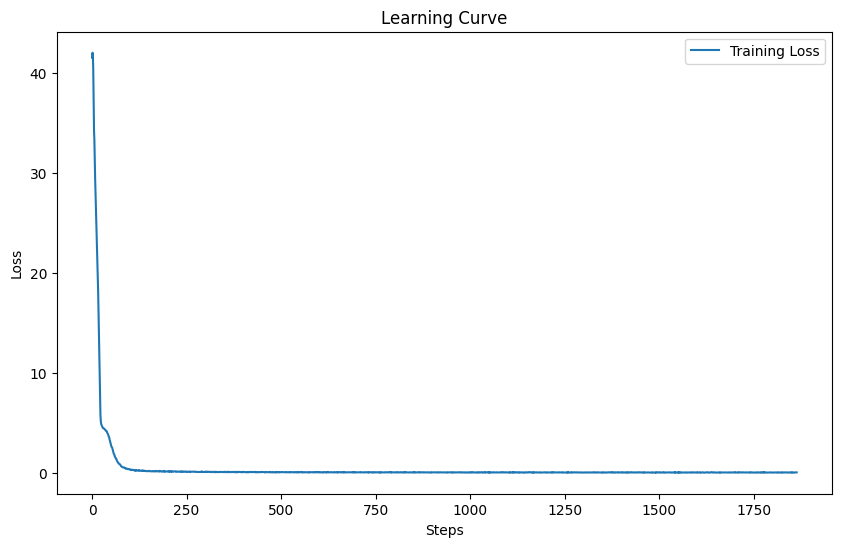

In [43]:
# Path to the log file
import json
log_file_path = f"{output_dir}/checkpoint-1865/trainer_state.json"

# Load the log file
with open(log_file_path, "r") as log_file:
    logs = json.load(log_file)

# Extract the training losses
training_losses = [entry["loss"] for entry in logs["log_history"] if "loss" in entry]

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

#### Save the fine-tuned model

In [26]:
peft_model_path="./peft-conversation-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-conversation-checkpoint-local\\tokenizer_config.json',
 './peft-conversation-checkpoint-local\\special_tokens_map.json',
 './peft-conversation-checkpoint-local\\tokenizer.json')

#### Adding an adapter to the original flan-t5 model

In [27]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base,
                                       'peft-conversation-checkpoint-local',
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [28]:
print(model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 248462592
percentage of trainable model parameters: 0.00%


In [29]:
def insert_prompt(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids 

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    return peft_model_text_output

In [30]:
prompt = "where is paris?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
where is paris?
PEFT MODEL: France


In [31]:
prompt = "What is the capital of california?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
What is the capital of california?
PEFT MODEL: San Francisco


In [32]:
prompt = "What is the capital of Italy"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
What is the capital of Italy
PEFT MODEL: Rome


In [33]:
prompt = "When does summer begin?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
When does summer begin?
PEFT MODEL: summer


In [34]:
prompt = "What is the best drink for a hangover?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
What is the best drink for a hangover?
PEFT MODEL: a stout


In [35]:
prompt = "What is the probability that two apples will fall at the same time?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
What is the probability that two apples will fall at the same time?
PEFT MODEL: 1 / 2
